In [1]:
library(rgdal)
library(gstat)
library(geoR)
library(sf)
library(sp)
library(terra)
library(ggplot2)

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.5.0, released 2022/05/10
Path to GDAL shared files: /usr/local/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.2.1, January 1st, 2022, [PJ_VERSION: 821]
Path to PROJ shared files: /home/jovyan/.local/share/proj:/usr/local/share/proj:/usr/local/share/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.5-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.

Warning message:
“no DISPLAY variable so Tk is not available”
--------------------------------------------------------------
 Analysis of Ge

In [2]:
# install.packages("ggpubr")

In [3]:
# # install.packages("ggnewscale")
# install.packages("gstlearn",repos="https://soft.mines-paristech.fr/cran")

In [4]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.1                         
year           2022                        
month          06                          
day            23                          
svn rev        82513                       
language       R                           
version.string R version 4.2.1 (2022-06-23)
nickname       Funny-Looking Kid           

In [5]:
library(ggpubr)
library(ggnewscale)
library(gstlearn)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:terra’:

    rotate


Warning message:
“package ‘gstlearn’ was built under R version 4.4.1”

Attaching package: ‘gstlearn’


The following objects are masked from ‘package:terra’:

    erase, trim


The following object is masked from ‘package:geoR’:

    xvalid


The following object is masked from ‘package:sp’:

    Polygons


The following objects are masked from ‘package:base’:

    message, toString




In [6]:
library(gridExtra)
library(grid)


Attaching package: ‘grid’


The following object is masked from ‘package:terra’:

    depth




In [7]:
library(MASS)


Attaching package: ‘MASS’


The following object is masked from ‘package:terra’:

    area




In [8]:
Jul = "/data/private/GPM/Data_1/July_2023_with_elev"

In [9]:
# as.data.frame(transformed_data_list[2])

In [10]:
# install.packages("corrplot")
library(corrplot)

corrplot 0.92 loaded



In [11]:
library(raster)


Attaching package: ‘raster’


The following object is masked from ‘package:MASS’:

    select




In [12]:
library(caret)

Loading required package: lattice



In [13]:
##grid of the kriging_simple (all)

In [14]:
extn_d = extent(c(800, 1100, 3180, 3500))
pix_siz = 25 #in Km
pix_siz_d = pix_siz/103 # in Degrees

In [15]:
grid_3 = raster(extn_d, res = c(pix_siz,pix_siz))
grid_3 #Target Resolution 0.25

class      : RasterLayer 
dimensions : 13, 12, 156  (nrow, ncol, ncell)
resolution : 25, 25  (x, y)
extent     : 800, 1100, 3175, 3500  (xmin, xmax, ymin, ymax)
crs        : NA 


In [16]:
grid_3sp = as(grid_3,"SpatialPixelsDataFrame")
proj4string(grid_3sp) = CRS("+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs")
colnames(grid_3sp@coords)  = c("lon","lat")

Warning message in asMethod(object):
“object has no values, returning a 'SpatialPixels' object”


In [17]:
summary(grid_3sp)

Object of class SpatialPixels
Coordinates:
   min  max
x  800 1100
y 3175 3500
Is projected: TRUE 
proj4string :
[+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs]
Number of points: 156
Grid attributes:
   cellcentre.offset cellsize cells.dim
s1             812.5       25        12
s2            3187.5       25        13

DAY 1

In [18]:
f1 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_1_July_23.csv"

[1] 0.1414141

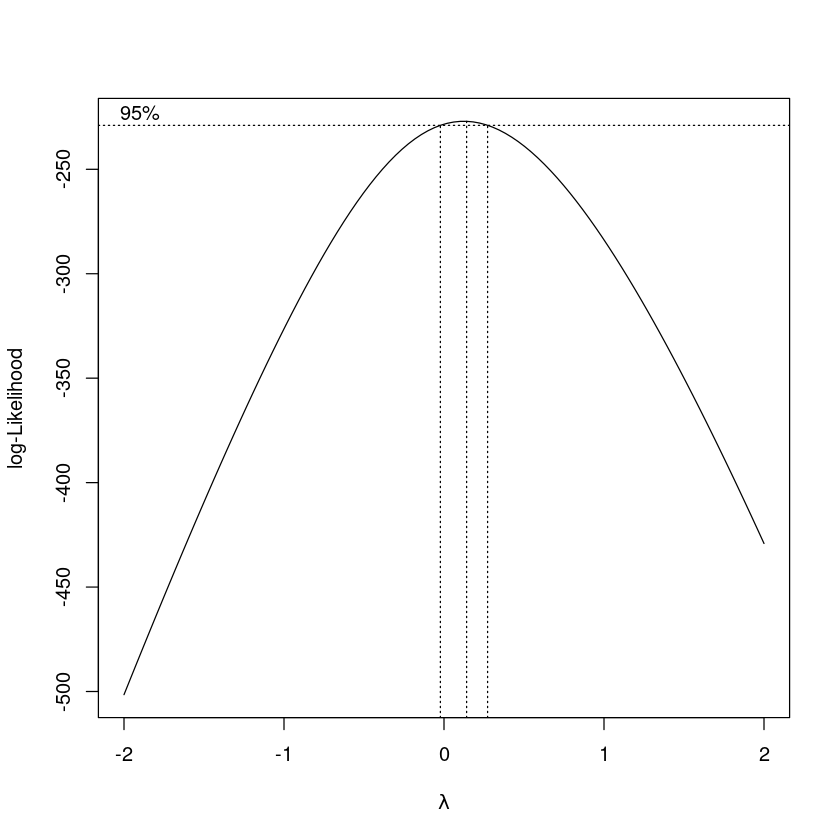

In [19]:
d1 = read.csv(f1)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d1$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda - 1) / lambda
  
  # Add the transformed rainfall data to the dataframe
  d1$Rainfall_Transformed <- rain_transformed

lambda
    

In [20]:
# Back-transform the data
if (lambda != 0) {
  original_data <- (lambda * rain_transformed + 1)^(1 / lambda)
} else {
  # When lambda is 0, the Box-Cox transformation is equivalent to a log transformation
  original_data <- exp(rain_transformed)
}

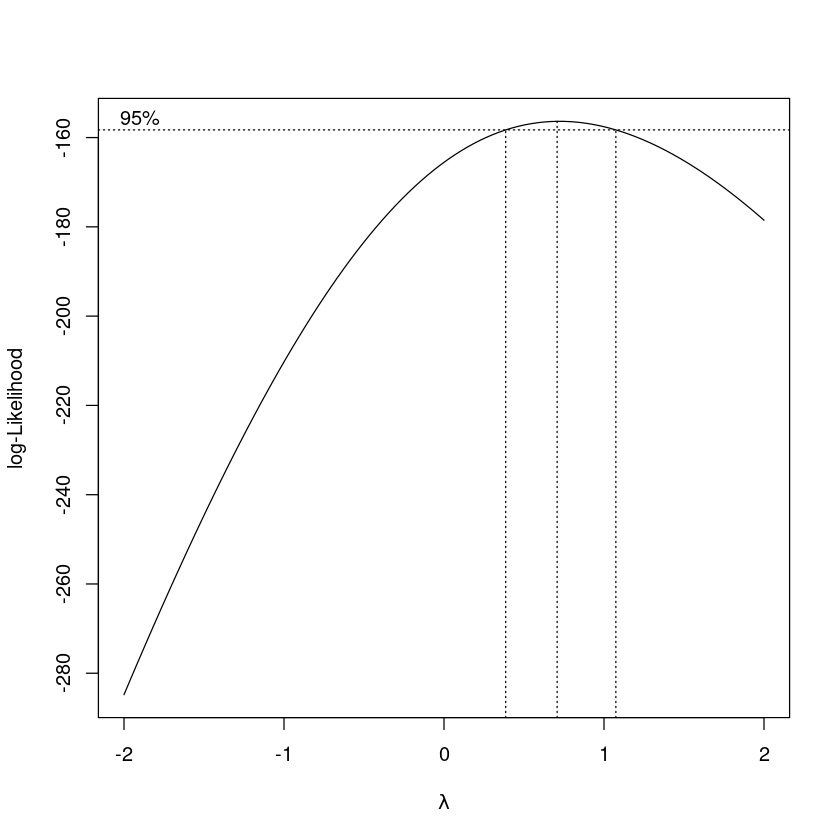

In [21]:
# Perform Box-Cox transformation on rainfall data
  elev <- d1$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d1$Elevation_Transformed <- el_transformed

In [22]:
lambda_el

[1] 0.7070707

In [23]:
coordinates1 = data.frame(lon = d1$Longitude, lat = d1$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d1_modb = subset(d1, select = -c(Longitude,Latitude))
sd_1 = SpatialPointsDataFrame(coords1,d1_modb)
class(sd_1)
proj4string(sd_1) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_1_prjtd <- spTransform(sd_1, CRS(desired_crs))
proj4string(sd_1_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [24]:
##### Regular Variogram

model psill    range   kappa ang1 ang2 ang3 anis1 anis2
1 Nug   2.331590  0.0000 0.0   0    0    0    1     1    
2 Exp   1.037967 31.8108 0.5   0    0    0    1     1

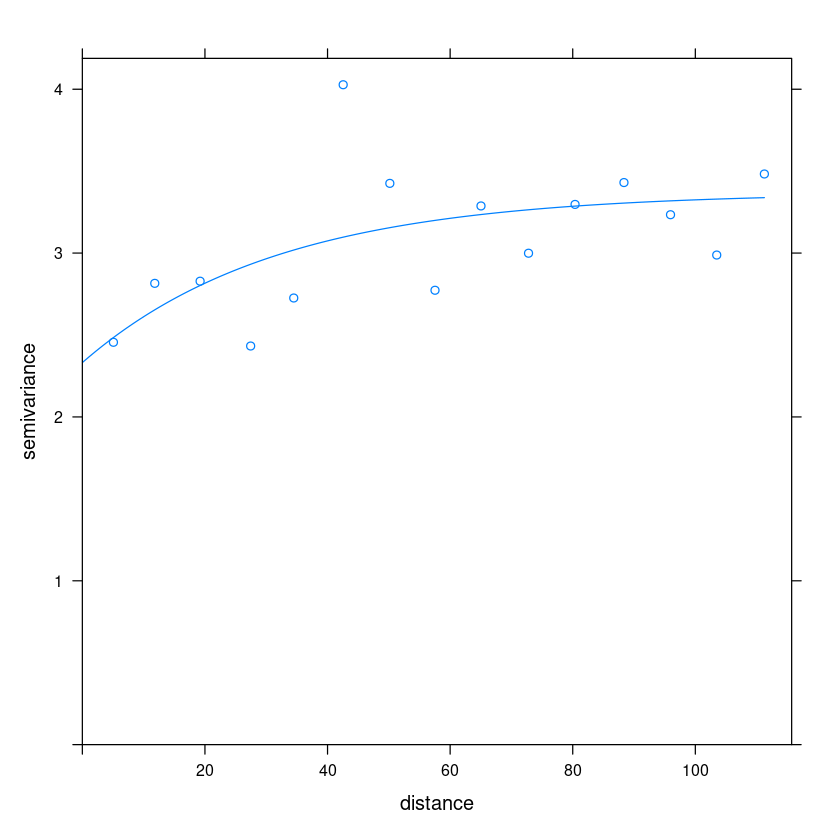

In [25]:
rain_vgm = variogram(rain_transformed ~1, data = sd_1_prjtd)
fit = vgm(3, "Exp", 30, 0.1)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
fit_rain_vgm 
plot(rain_vgm, model = fit_rain_vgm)

In [26]:
elev = d1$Elevation
elev_vgm = variogram(elev~1, data = sd_1_prjtd)
fit1 = vgm(330700, "Exp", 37, 94767)
fit_elev_vgm = fit.variogram(elev_vgm, fit1)


In [27]:
### Likfit Vraiogram(for rain)

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"47.5550" "-0.0004" "-0.0135" " 1.0477" " 1.9464" " 7.8796" 
Practical Range with cor=0.05 for asymptotic range: 23.60512

likfit: maximised log-likelihood = -319.7

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
47.5550 -0.0004 -0.0135 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.946
      (estimated) cor. fct. parameter phi (range parameter)  =  7.88
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.048

Transformation parameter:
      (fixed) Box-Cox parameter = 0.1414

Practical Range with cor=0.05 for asymptotic range: 23.60512

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-319.7"      "6"  "651.4"  "666.2" 

non spatial model:
   log.L n.params      AIC      BIC 
"-321.1"      "4"  "650.1"    "660" 

Call:
likfit(geodata = gdt_1, trend = "1st", ini.cov.pars = c(3, 50), 
    nugget

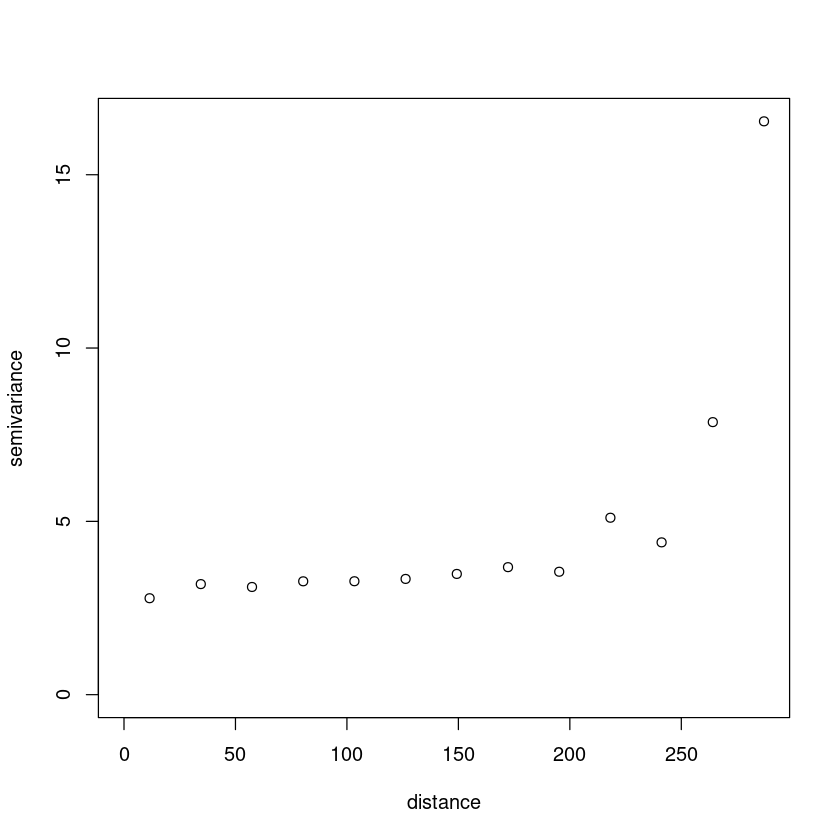

In [28]:
cord = coordinates(sd_1_prjtd)
rn = sd_1_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_1 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_1 = jitterDupCoords(gdt_1, max = jit_am)

vf = variog(gdt_1, lambda = 0.141414141414141, trend = "cte")
plot(vf)
vgm_rn_lk = likfit(geodata = gdt_1, trend = "1st",cov.model = "exponential", ini.cov.pars = c(3,50),nugget = 1, lambda = 0.141414141414141, lik.method = "ML", messages = FALSE)
vgm_rn_lk
summary(vgm_rn_lk)

In [29]:
## Grid _Simple + Kriging

In [30]:
# Extract coordinates
coords <- coordinates(sd_1_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_1_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_1_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_1_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_1_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_1_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_1_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_1st <- krige(rain_transformed ~ 1, sd_1_prjtd_jittered, grid_3sp, fit_rain_vgm)

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


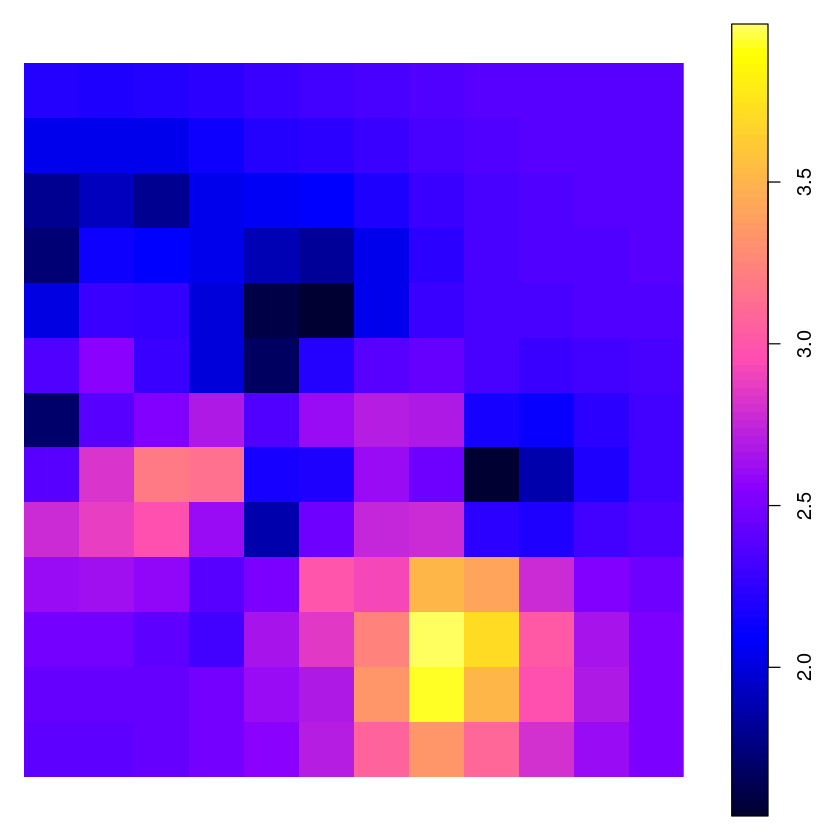

In [31]:
plot(resllt_1st)

In [32]:
## Grid_Likfit + Kriging

In [33]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


In [34]:
krig_lkft_1 <- krige.conv(gdt_1, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk))

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


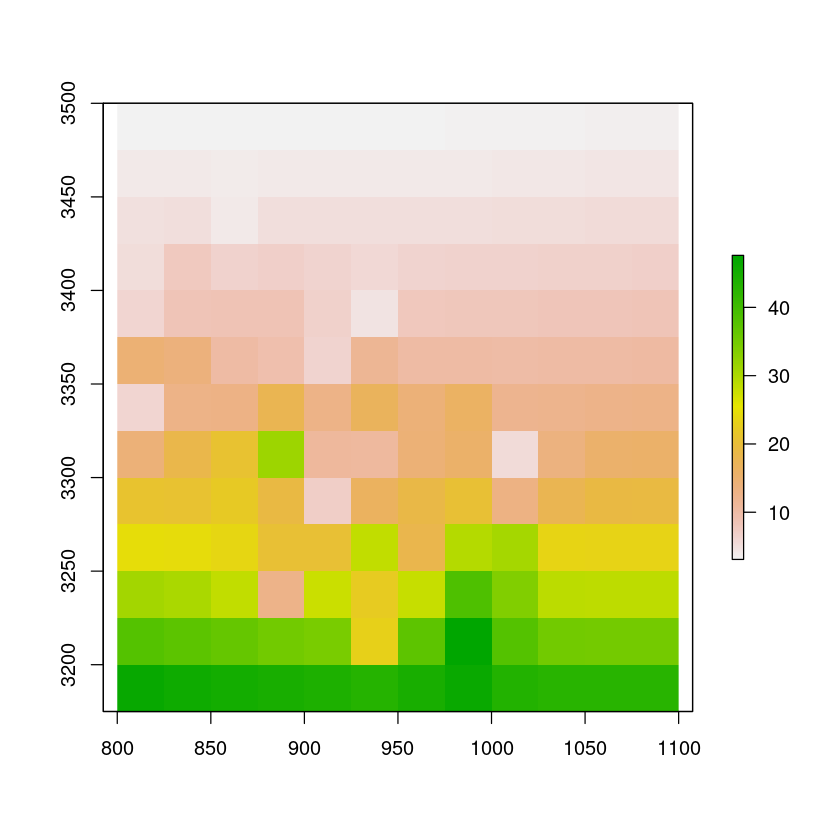

In [35]:
krig_rain_lkft_1 <- krig_lkft_1$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_1 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_1))
proj4string(pr_rain_lkft_1) <- proj4string(grid_3sp)
plot(pr_rain_lkft_1)

In [36]:
#### Regression and Staffs

In [37]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)

Generalized Linear Model 

88 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 78, 78, 80, 80, 80, 78, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.882948  0.2067422  1.560272



as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
53.0666 -0.0015 -0.0156 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.801
      (estimated) cor. fct. parameter phi (range parameter)  =  8.277
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.078

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 24.7945

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-169.7"      "6"  "351.3"  "366.2" 

non spatial model:
   log.L n.params      AIC      BIC 
  "-171"      "4"  "349.9"  "359.9" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars 

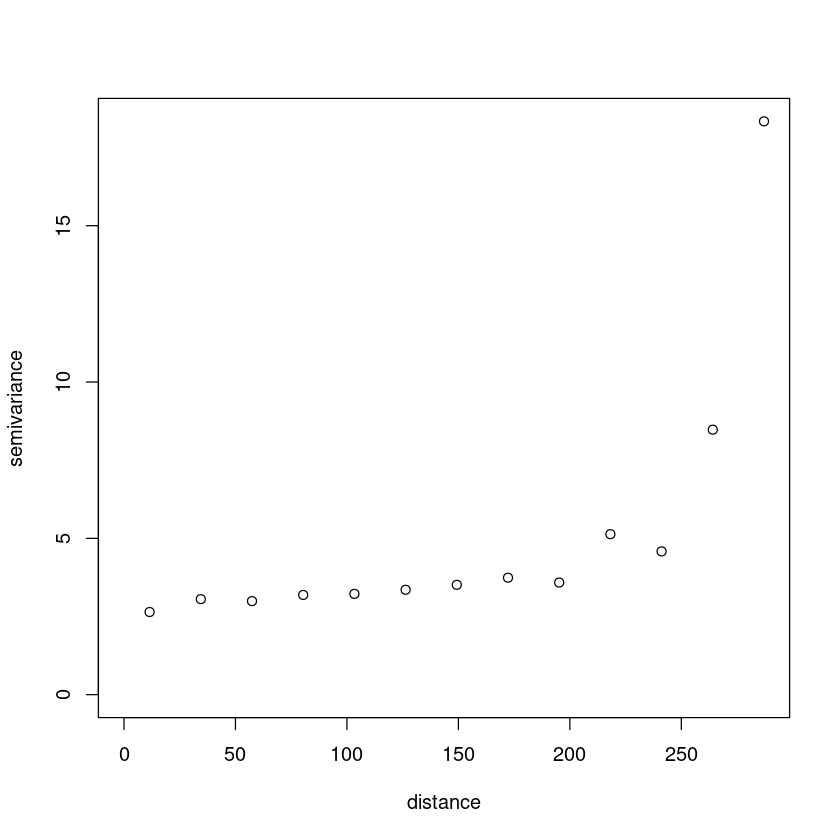

In [38]:
resd_glm_1 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_1))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "cte")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(3, 50), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk)

In [39]:
krig_lkft_regr_1 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk))

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


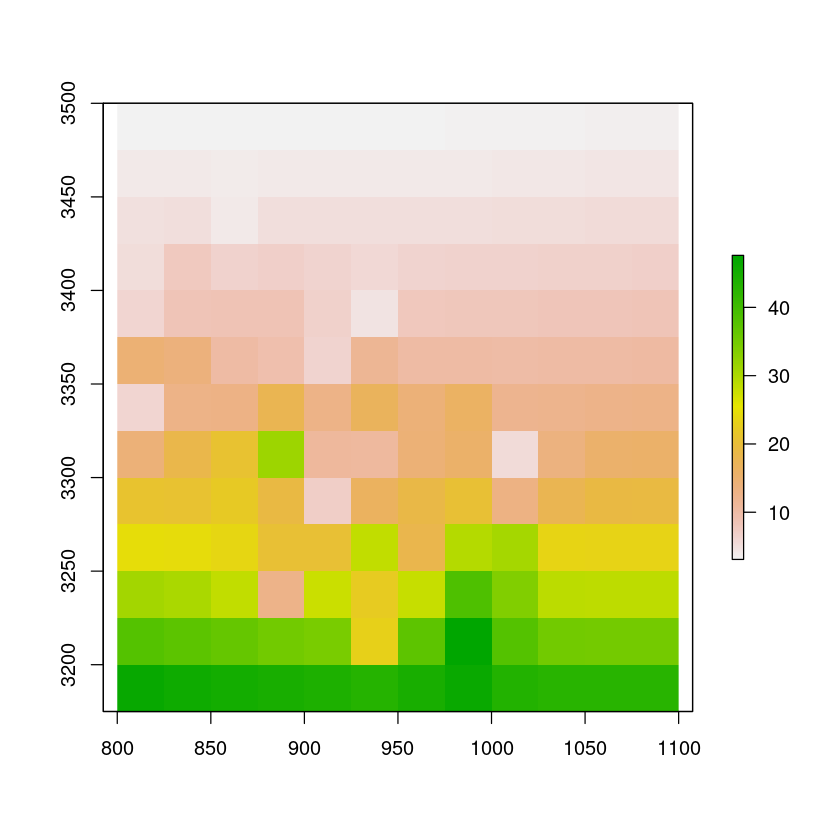

In [40]:
krig_regr_1 <- krig_lkft_1$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_1 <- rasterFromXYZ(cbind(grid_df, krig_regr_1))
proj4string(pr_regr_lkft_1) <- proj4string(grid_3sp)
plot(pr_regr_lkft_1)

In [41]:
## All Related to Correlation and Co Variogram

In [42]:
corr_mat = cor(rain_transformed, elev, use = 'complete')
corr_mat
# corrplot(corr_mat, method = "circle")

[1] 0.1009718

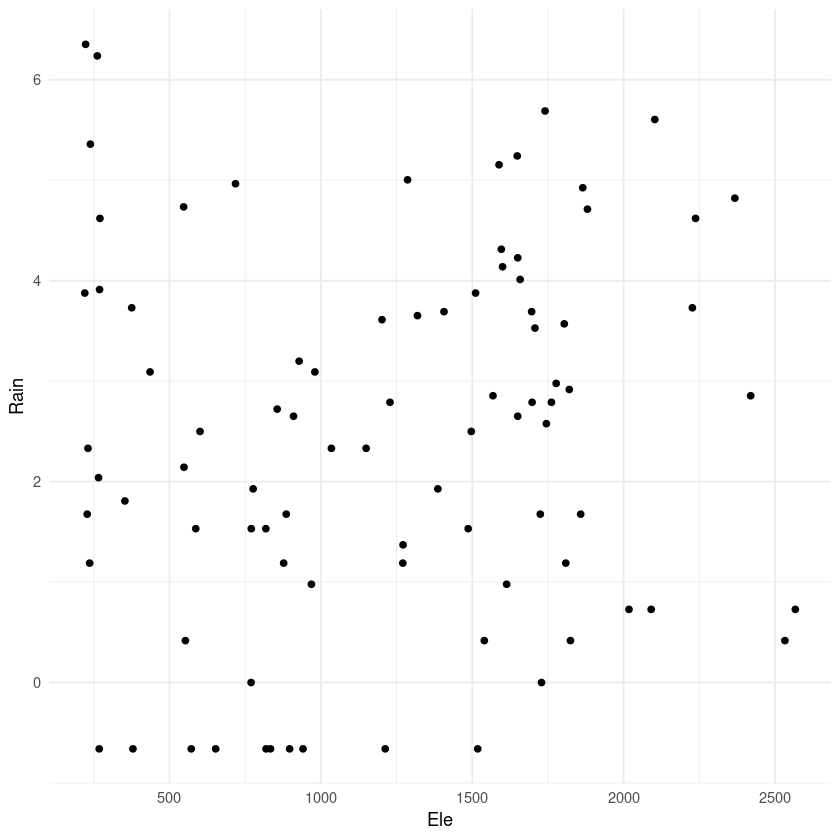

In [43]:
scatter_plot <- ggplot(d1, aes(x = elev, y = rain_transformed)) +
  geom_point() +
  theme_minimal() +
  labs(x = "Ele", y = "Rain")
scatter_plot

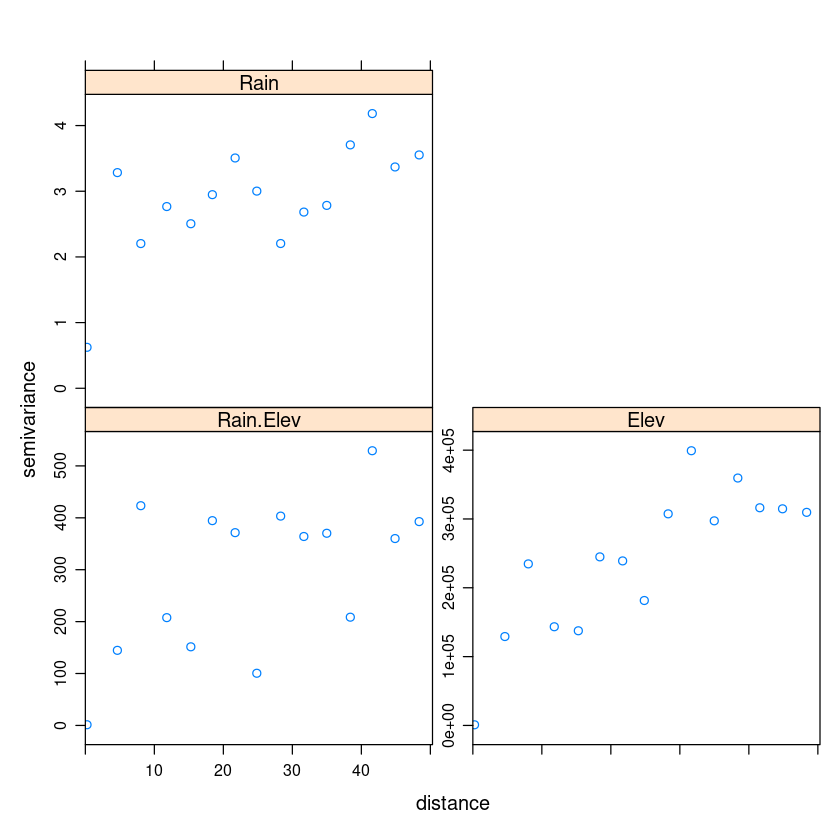

In [44]:
g = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_1_prjtd)
g= gstat(g, id = "Elev", form = elev~1, data = sd_1_prjtd)
v_cross = variogram(g, cutoff = 50)
plot(v_cross)

In [45]:
g = gstat(g, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g = fit.lmc(v_cross,g)
g

data:
Rain : formula = rain_transformed`~`1 ; data dim = 88 x 11
Elev : formula = elev`~`1 ; data dim = 88 x 11
variograms:
             model         psill   range
Rain[1]        Nug  1.242621e+00  0.0000
Rain[2]        Exp  4.800661e+00 31.8108
Elev[1]        Nug  8.887982e-01  0.0000
Elev[2]        Exp  5.129540e+05 31.8108
Rain.Elev[1]   Nug -1.050923e+00  0.0000
Rain.Elev[2]   Exp  6.506909e+02 31.8108

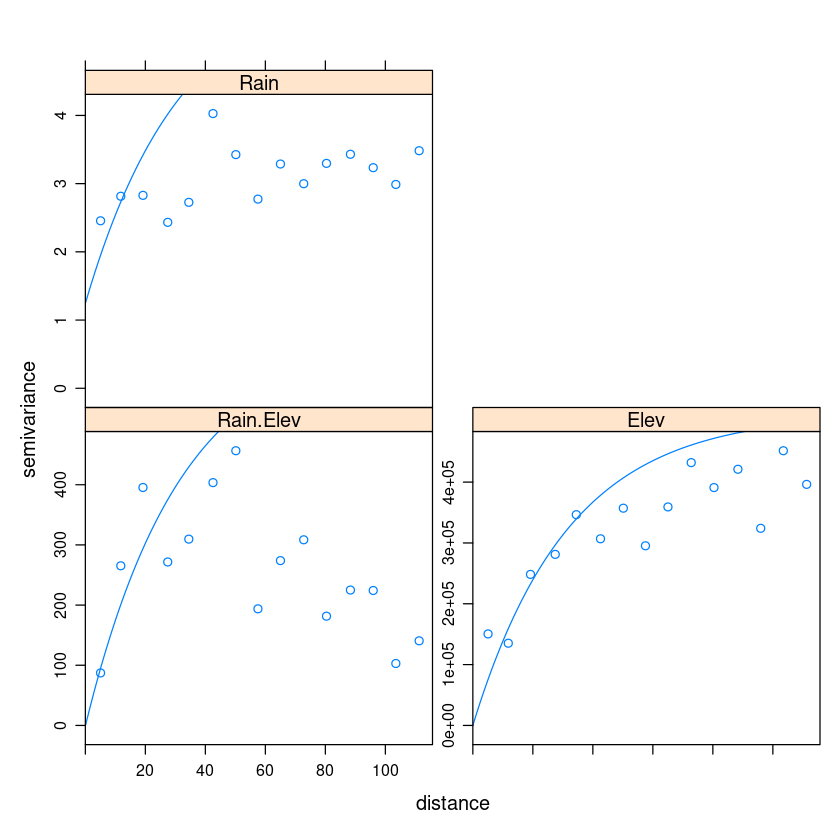

In [46]:
plot(variogram(g), model= g$model)

DAY 2

In [47]:
f2 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_2_July_23.csv"

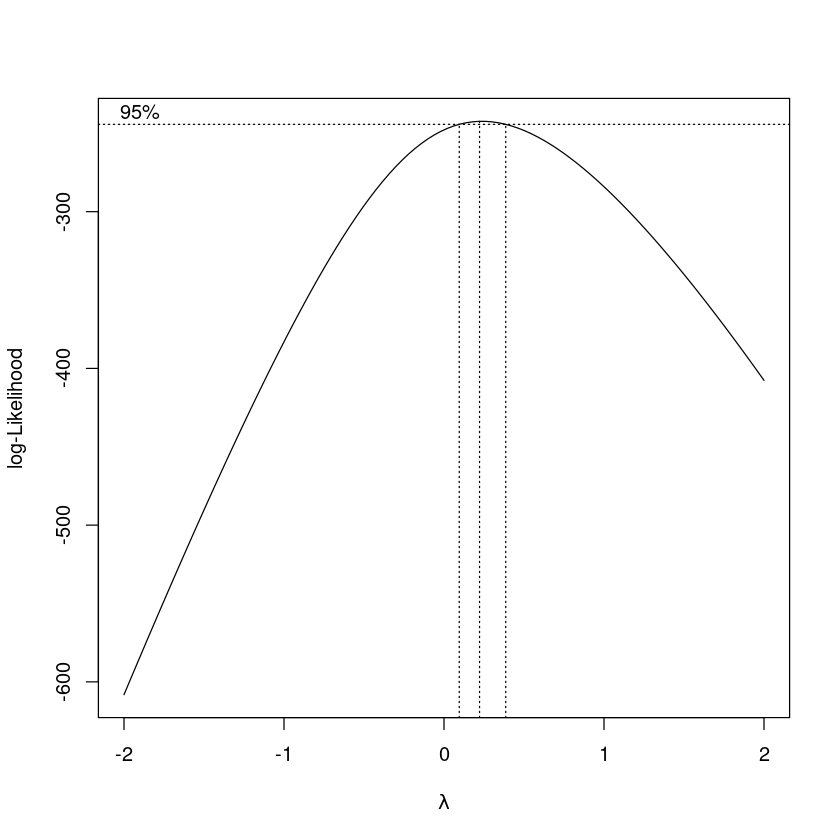

In [48]:
d2 = read.csv(f2)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d2$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d2$Rainfall_Transformed <- rain_transformed

In [49]:
lambda_rn

[1] 0.2222222

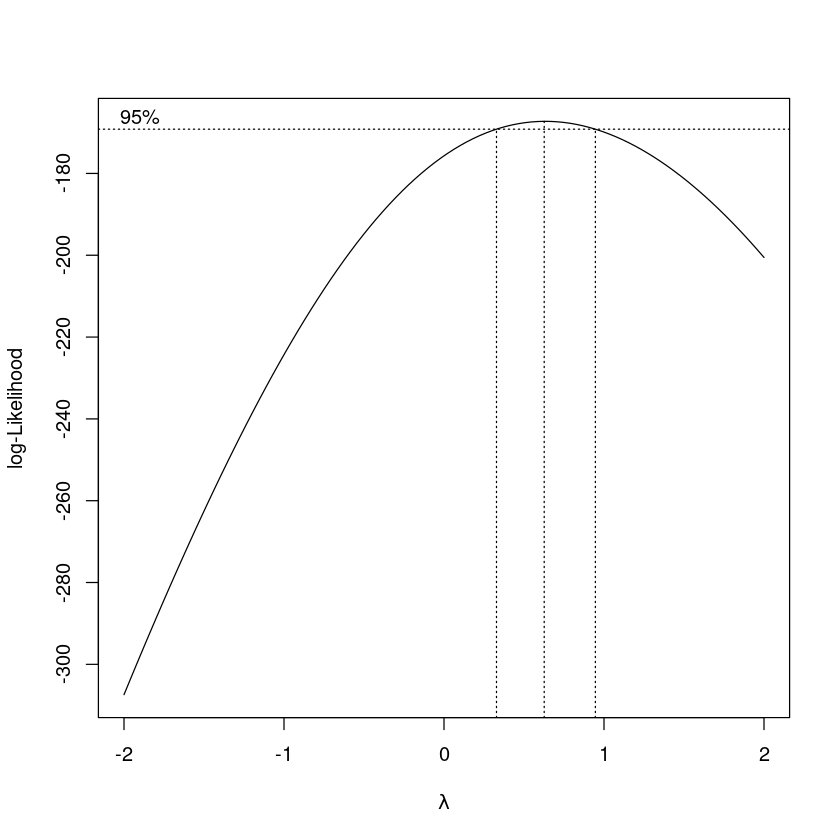

In [50]:
# Perform Box-Cox transformation on rainfall data
  elev <- d2$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d2$Elevation_Transformed <- el_transformed

In [51]:
length(rain_transformed)
length(el_transformed)

[1] 94

[1] 94

In [52]:
coordinates1 = data.frame(lon = d2$Longitude, lat = d2$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d2_modb = subset(d2, select = -c(Longitude,Latitude))
sd_2 = SpatialPointsDataFrame(coords1,d2_modb)
class(sd_2)
proj4string(sd_2) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_2_prjtd <- spTransform(sd_2, CRS(desired_crs))
proj4string(sd_2_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [53]:
################ Regular Variogram

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   0.000000  0.00000 0.0   0    0    0    1     1    
2 Exp   5.087242 11.82473 0.5   0    0    0    1     1

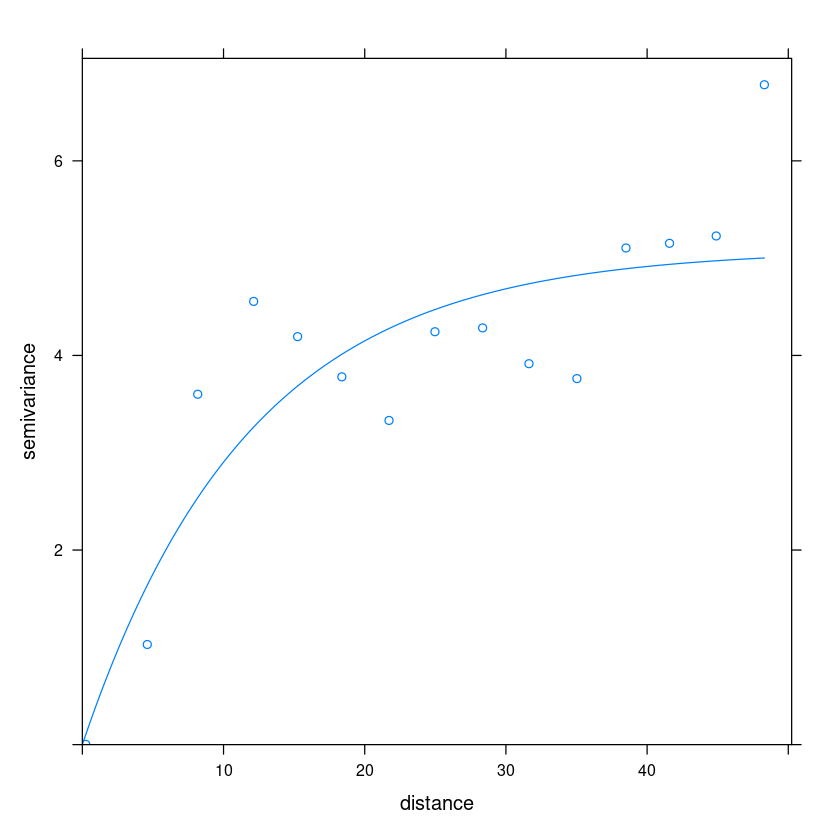

In [54]:
rain_vgm = variogram(rain_transformed ~1, data = sd_2_prjtd, cutoff = 50)
# plot(rain_vgm)
fit = vgm(5.08, "Exp", 12, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
fit_rain_vgm
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

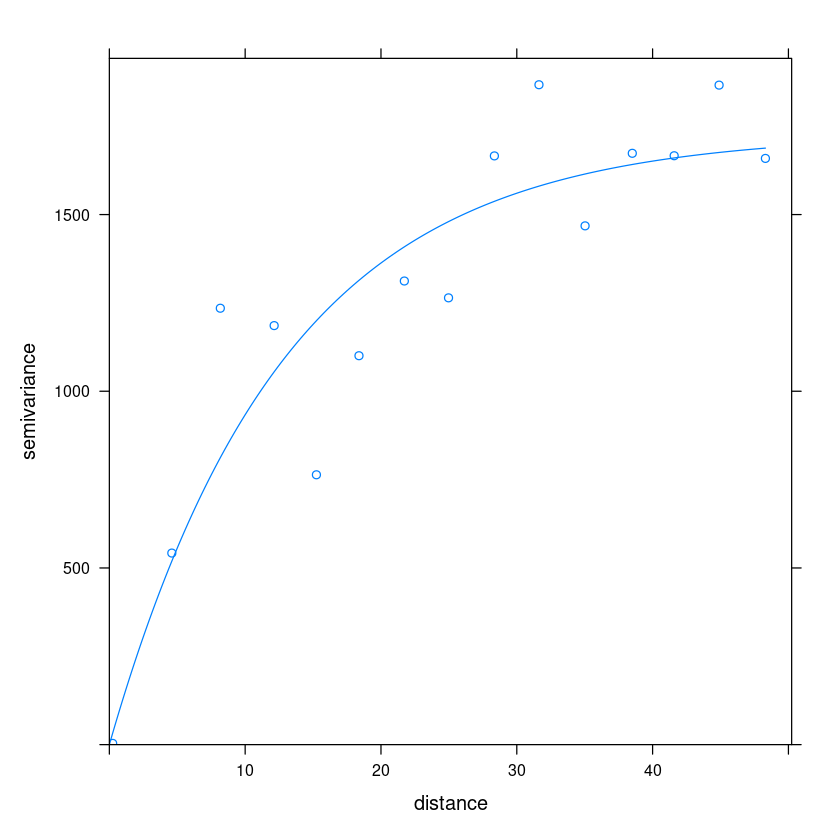

In [55]:
elev_vgm = variogram(el_transformed~1, data = sd_2_prjtd, cutoff = 50)
# plot(elev_vgm)
fit1 = vgm(1728.6, "Exp", 13, 2)
fit_elev_vgm = fit.variogram(elev_vgm, fit1)
plot(elev_vgm, model = fit_elev_vgm)
# v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v


In [56]:
##### LikFit Variogram(For Rainfall)

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"74.1911" "-0.0043" "-0.0201" " 0.0000" " 4.5933" " 9.7246" 
Practical Range with cor=0.05 for asymptotic range: 29.13215

likfit: maximised log-likelihood = -368.4

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
74.1911 -0.0043 -0.0201 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  4.593
      (estimated) cor. fct. parameter phi (range parameter)  =  9.725
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 0.2222

Practical Range with cor=0.05 for asymptotic range: 29.13215

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-368.4"      "6"  "748.9"  "764.1" 

non spatial model:
   log.L n.params      AIC      BIC 
"-379.3"      "4"  "766.5"  "776.7" 

Call:
likfit(geodata = gdt_2, trend = "1st", ini.cov.pars = c(6, 50), 
    nugget = 

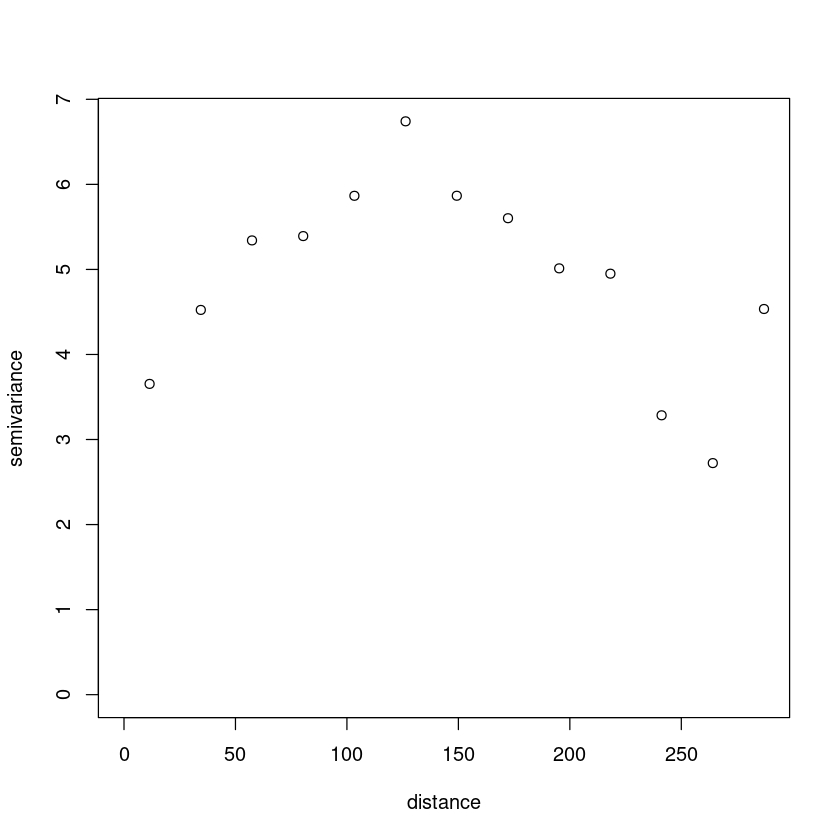

In [57]:
cord = coordinates(sd_2_prjtd)
rn = sd_2_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_2 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_2 = jitterDupCoords(gdt_2, max = jit_am)

vf_2 = variog(gdt_2, lambda = 0.222222222222222, trend = "cte")
plot(vf_2)
vgm_rn_lk_2 = likfit(geodata = gdt_2, trend = "1st",cov.model = "exponential", ini.cov.pars = c(6,50),nugget = 3.5, lambda = 0.222222222222222, lik.method = "ML", messages = FALSE)
vgm_rn_lk_2
summary(vgm_rn_lk_2)

In [58]:
### Simple Krig

In [59]:
# Extract coordinates
coords <- coordinates(sd_2_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_2_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_2_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_2_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_2_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_2_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_2_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_2nd <- krige(rain_transformed ~ 1, sd_2_prjtd_jittered, grid_3sp, fit_rain_vgm)

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


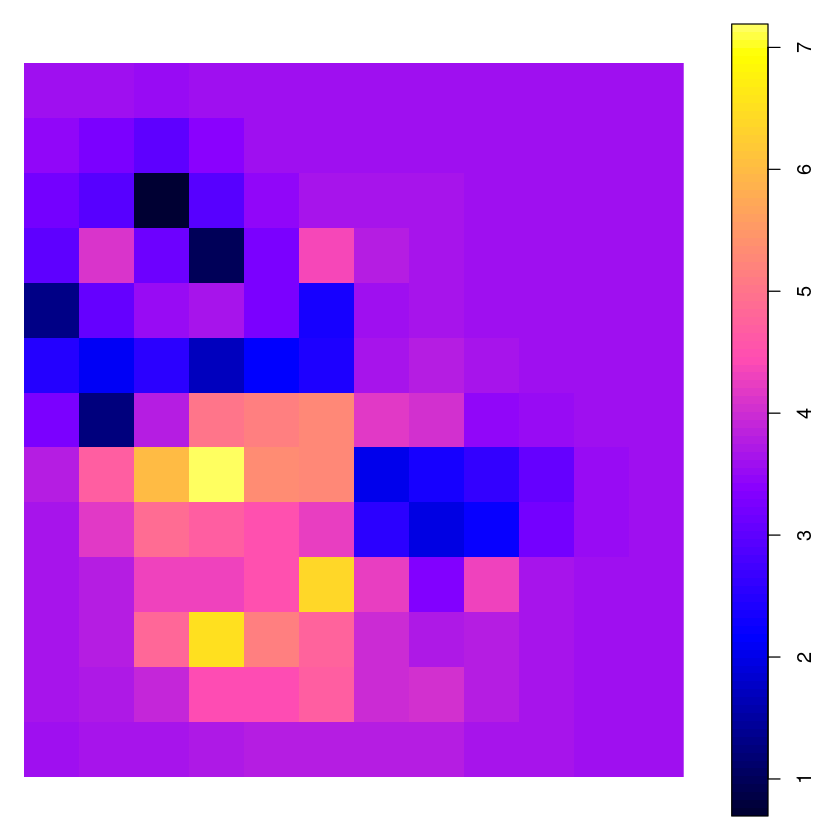

In [60]:
plot(resllt_2nd)

In [61]:
#### Likfit Krig

In [62]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 

In [63]:
krig_lkft_2 <- krige.conv(gdt_2, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_2))

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


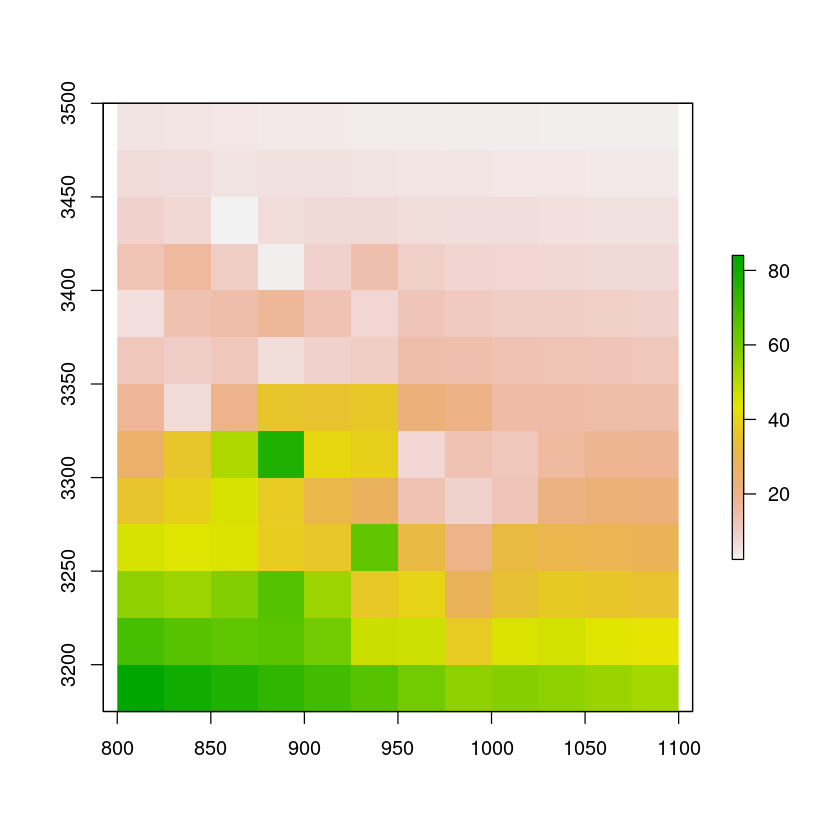

In [64]:
krig_rain_lkft_2 <- krig_lkft_2$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_2 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_2))
proj4string(pr_rain_lkft_2) <- proj4string(grid_3sp)
plot(pr_rain_lkft_2)

In [65]:
### Regression and staffs

In [66]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)

Generalized Linear Model 

94 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 86, 84, 85, 84, 84, 84, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  2.309074  0.178777  1.914598



as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
50.1782 -0.0017 -0.0146 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  4.726
      (estimated) cor. fct. parameter phi (range parameter)  =  9.79
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 29.32806

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-195.3"      "6"  "402.7"    "418" 

non spatial model:
   log.L n.params      AIC      BIC 
  "-206"      "4"    "420"  "430.2" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = c(

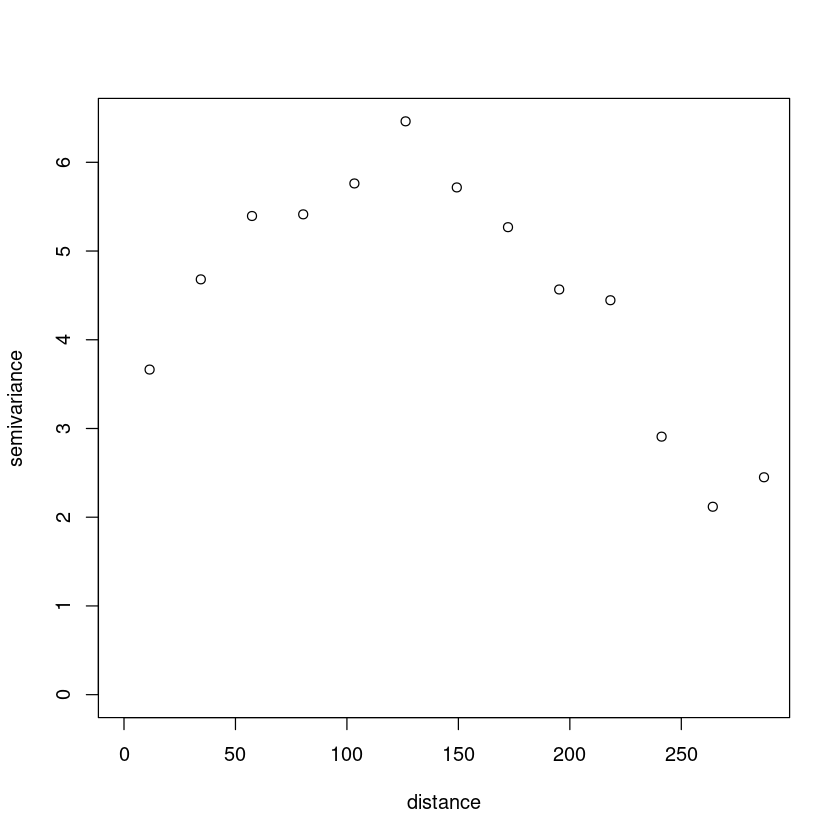

In [67]:
resd_glm_2 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_2))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "cte")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_2 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(6, 60), 
                     nugget = 3.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_2)

In [68]:
krig_lkft_regr_2 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_2))

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


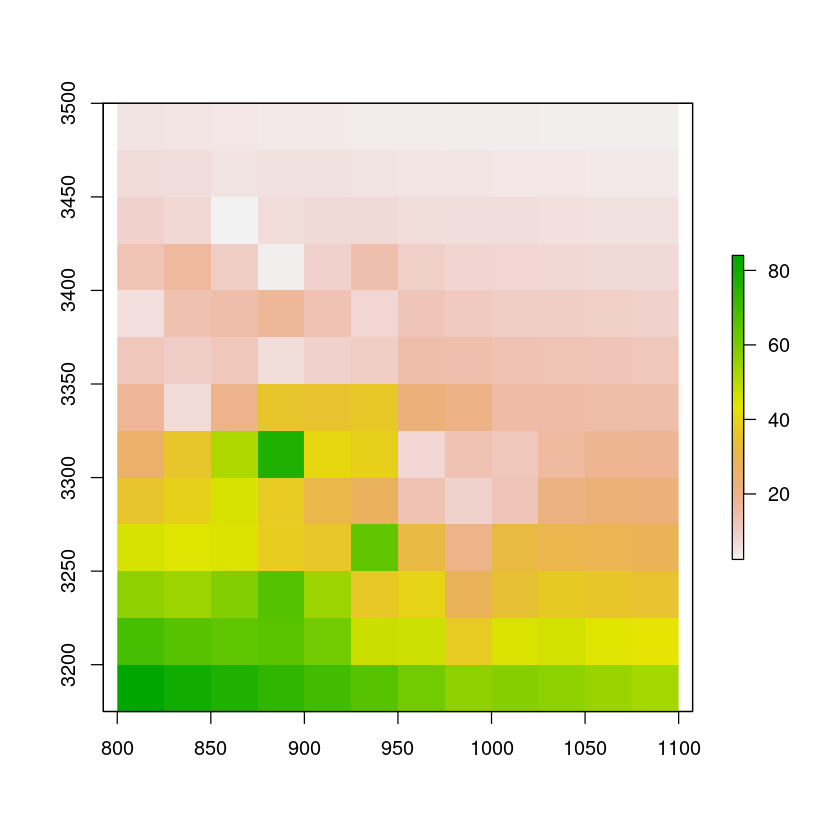

In [69]:
krig_regr_2 <- krig_lkft_2$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_2 <- rasterFromXYZ(cbind(grid_df, krig_regr_2))
proj4string(pr_regr_lkft_2) <- proj4string(grid_3sp)
plot(pr_regr_lkft_2)

In [70]:
### Related to Co-Var

In [71]:
cor(d2$Rainfall_Transformed, d2$Elevation_Transformed , use = 'complete')

[1] -0.1524282

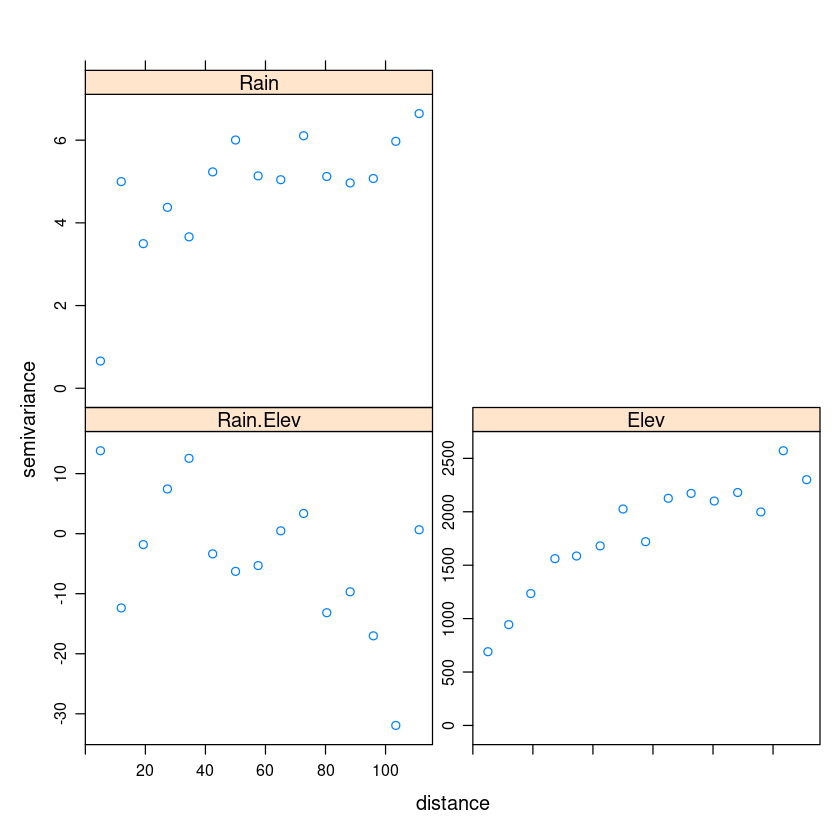

In [72]:
g1 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_2_prjtd)
g1= gstat(g1, id = "Elev", form = el_transformed~1, data = sd_2_prjtd)
v_cross = variogram(g1)
plot(v_cross)

In [73]:
g1 = gstat(g1, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g1 = fit.lmc(v_cross,g1)
g1

data:
Rain : formula = rain_transformed`~`1 ; data dim = 94 x 11
Elev : formula = el_transformed`~`1 ; data dim = 94 x 11
variograms:
             model       psill    range
Rain[1]        Nug    8.705397  0.00000
Rain[2]        Exp    5.105787 11.82473
Elev[1]        Nug    8.705397  0.00000
Elev[2]        Exp 1793.028376 11.82473
Rain.Elev[1]   Nug    8.705397  0.00000
Rain.Elev[2]   Exp  -22.113342 11.82473

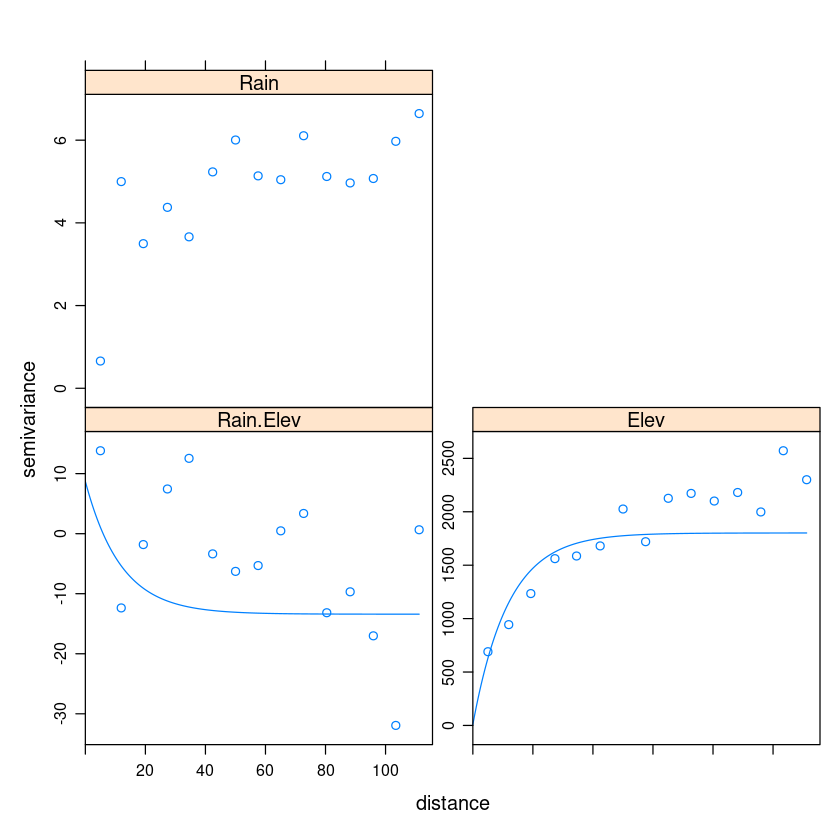

In [74]:
plot(variogram(g1), model= g1$model)

DAY 3

In [75]:
f3 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_3_July_23.csv"

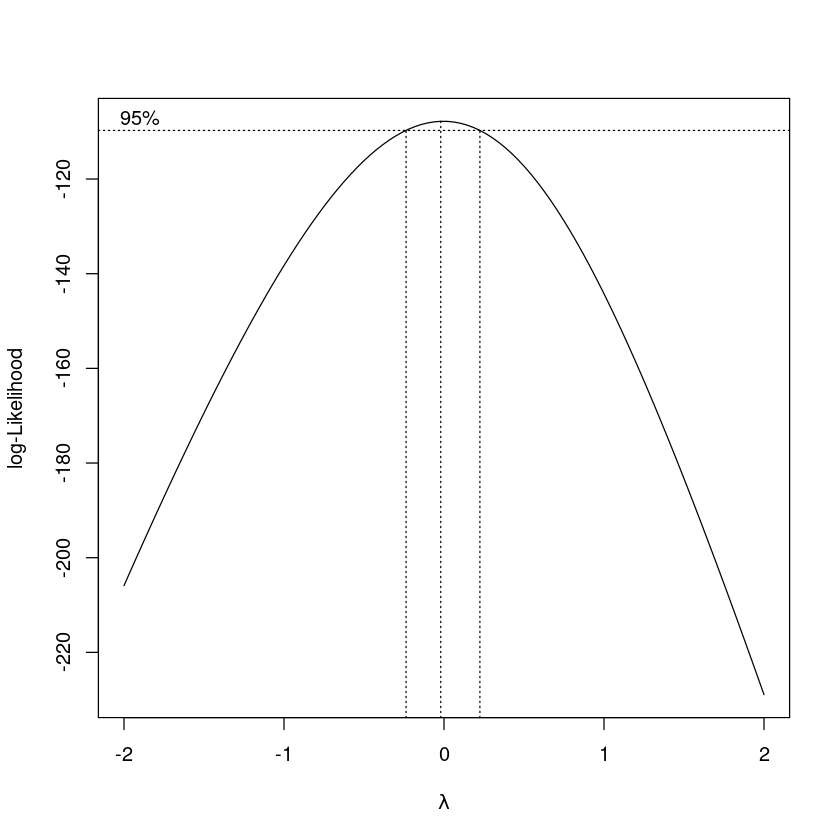

In [76]:
d3 = read.csv(f3)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d3$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d3$Rainfall_Transformed <- rain_transformed

In [77]:
lambda_rn

[1] -0.02020202

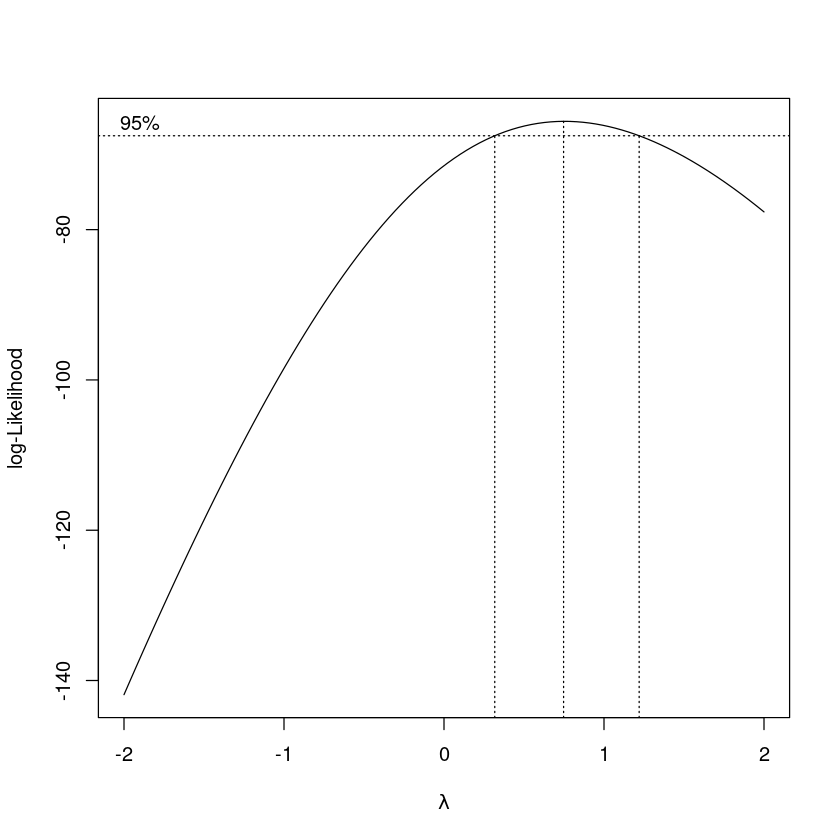

In [78]:
# Perform Box-Cox transformation on rainfall data
  elev <- d3$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d3$Elevation_Transformed <- el_transformed

In [79]:
coordinates1 = data.frame(lon = d3$Longitude, lat = d3$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d3_modb = subset(d3, select = -c(Longitude,Latitude))
sd_3 = SpatialPointsDataFrame(coords1,d3_modb)
class(sd_3)
proj4string(sd_3) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_3_prjtd <- spTransform(sd_3, CRS(desired_crs))
proj4string(sd_3_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

model psill    range   kappa ang1 ang2 ang3 anis1 anis2
1 Nug   0.000000 0.00000 0.0   0    0    0    1     1    
2 Exp   2.245749 9.88072 0.5   0    0    0    1     1

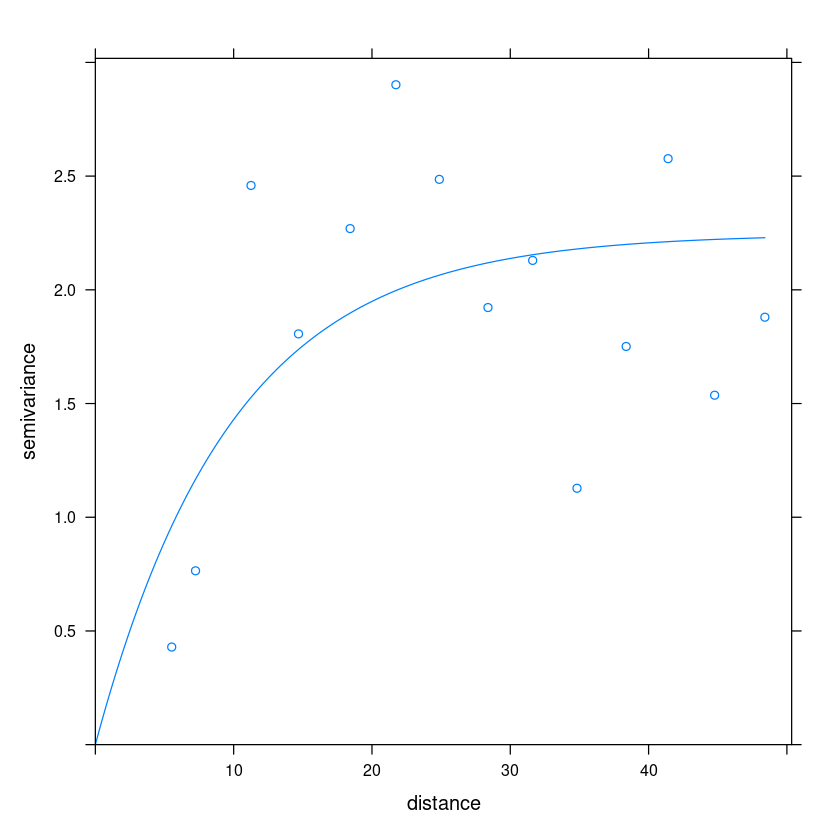

In [80]:
rain_vgm = variogram(rain_transformed ~1, data = sd_3_prjtd, cutoff = 50)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
fit_rain_vgm
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

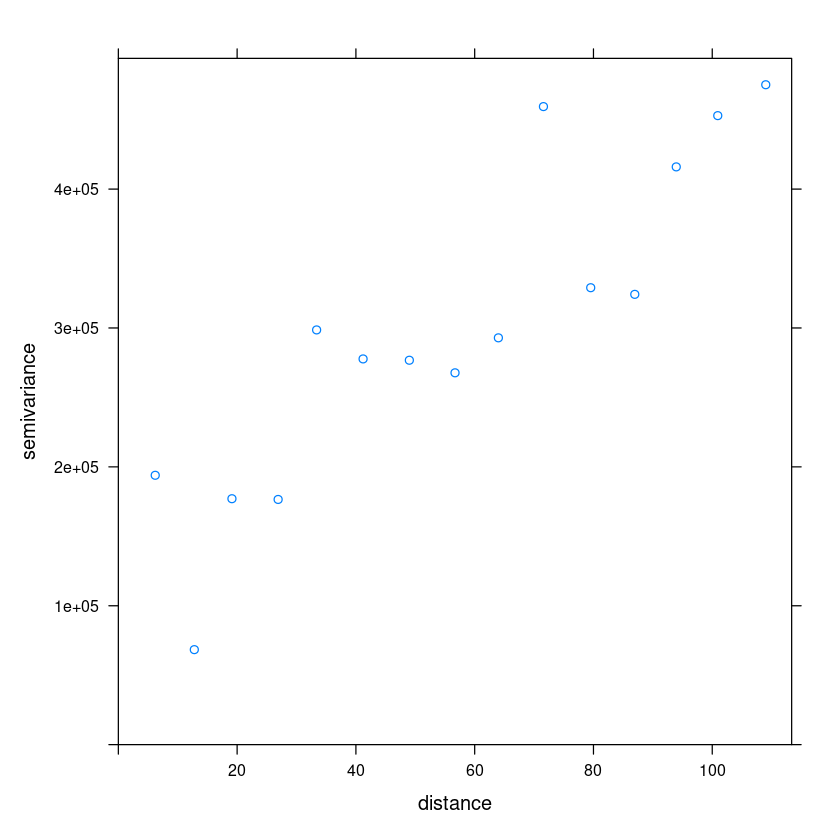

Warning message in fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat")):
“No convergence after 200 iterations: try different initial values?”


model psill      range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug     152228.9    0.000 0.0   0    0    0    1     1    
2 Exp   25856447.8 8971.213 0.5   0    0    0    1     1

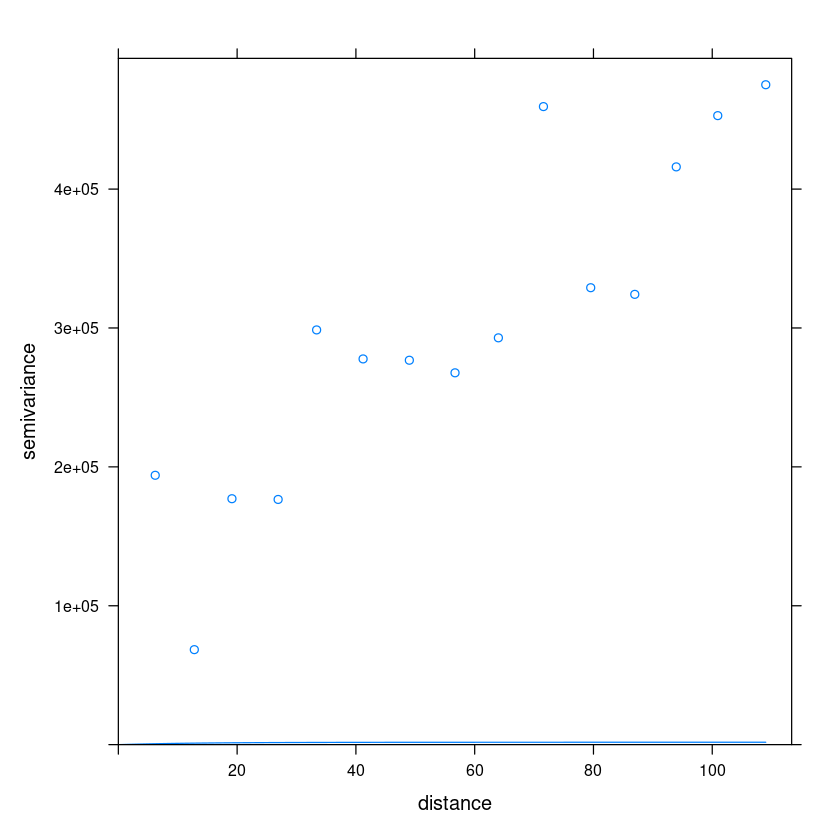

In [81]:
elev = d3$Elevation
elev_vgm = variogram(elev~1, data = sd_3_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v


In [82]:
### Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"34.8200" "-0.0049" "-0.0087" " 0.0000" " 1.5979" " 3.5413" 
Practical Range with cor=0.05 for asymptotic range: 10.60867

likfit: maximised log-likelihood = -147.6

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
34.8200 -0.0049 -0.0087 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.598
      (estimated) cor. fct. parameter phi (range parameter)  =  3.541
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = -0.0202

Practical Range with cor=0.05 for asymptotic range: 10.60867

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-147.6"      "6"  "307.3"  "318.5" 

non spatial model:
   log.L n.params      AIC      BIC 
"-147.9"      "4"  "303.8"  "311.3" 

Call:
likfit(geodata = gdt_3, trend = "1st", ini.cov.pars = c(1.5, 
    20), nugget

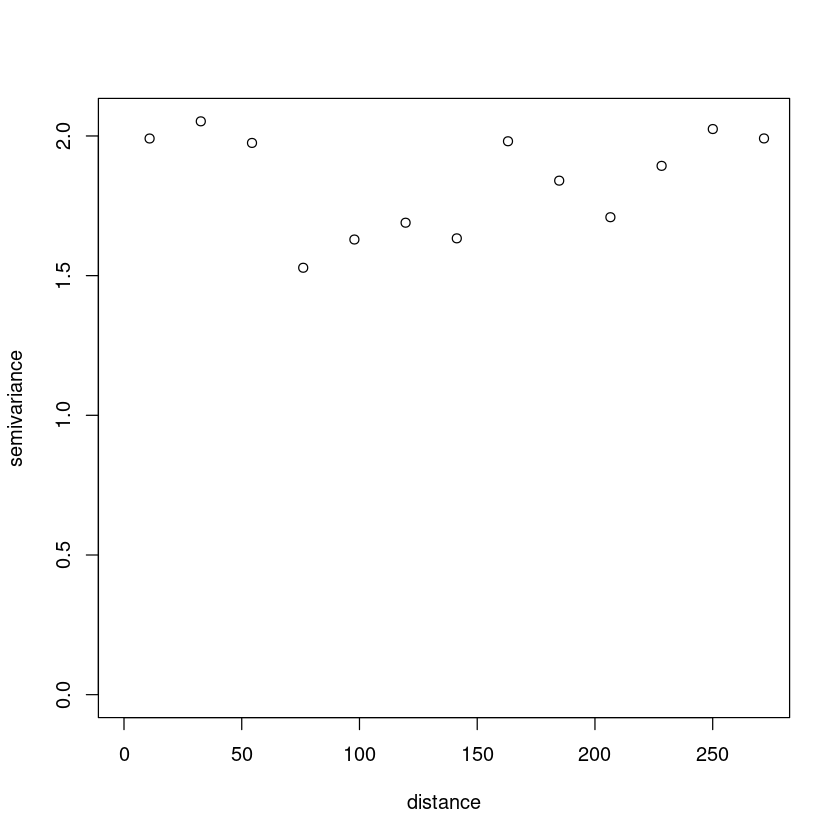

In [83]:
cord = coordinates(sd_3_prjtd)
rn = sd_3_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_3 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_3 = jitterDupCoords(gdt_3, max = jit_am)

vf_3 = variog(gdt_3, lambda = -0.0202020202020201, trend = "cte")
plot(vf_3)
vgm_rn_lk_3 = likfit(geodata = gdt_3, trend = "1st",cov.model = "exponential", ini.cov.pars = c(1.5,20),nugget = 0.5, lambda = -0.0202020202020201, lik.method = "ML", messages = FALSE)
vgm_rn_lk_3
summary(vgm_rn_lk_3)


In [84]:
### Simple krig

In [85]:
# Extract coordinates
coords <- coordinates(sd_3_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_3_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_3_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_3_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_3_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_3_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_3_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_3rd <- krige(rain_transformed ~ 1, sd_3_prjtd_jittered, grid_3sp, fit_rain_vgm)


[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


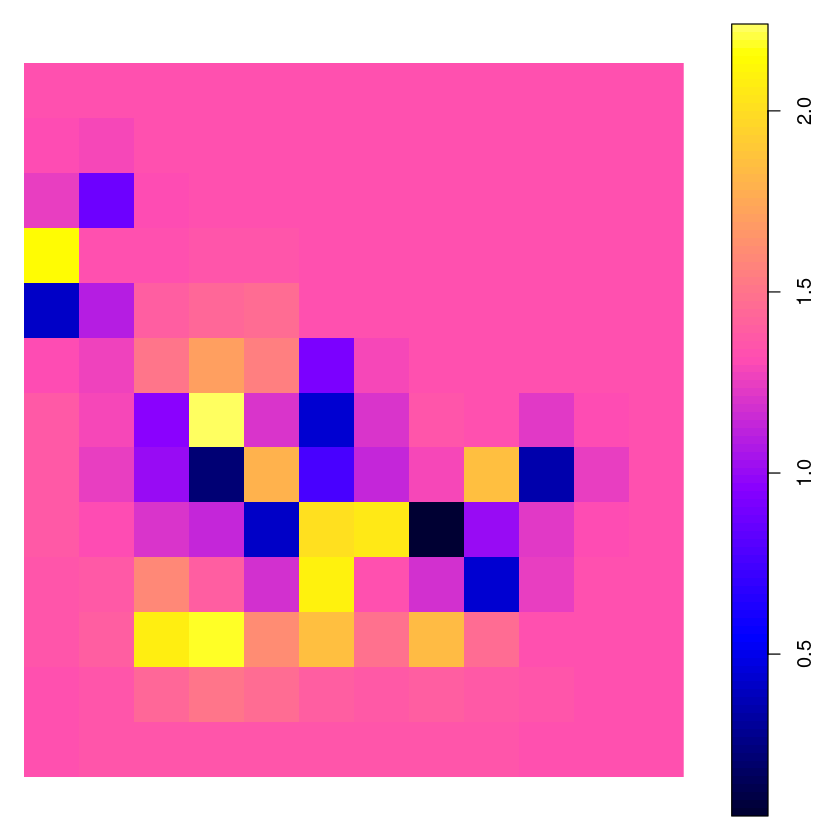

In [86]:
plot(resllt_3rd)

In [87]:
### Likfit krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


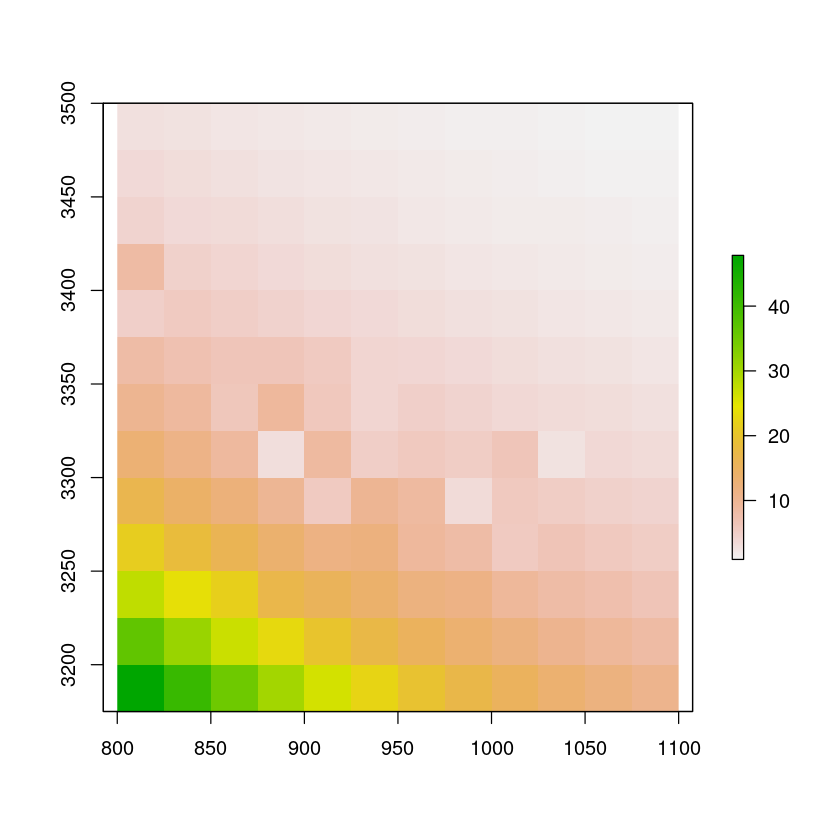

In [88]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_3 <- krige.conv(gdt_3, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_3))



krig_rain_lkft_3 <- krig_lkft_3$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_3 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_3))
proj4string(pr_rain_lkft_3) <- proj4string(grid_3sp)
plot(pr_rain_lkft_3)

In [89]:
## Regression and staff

Generalized Linear Model 

48 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 42, 44, 43, 44, 43, 44, ... 
Resampling results:

  RMSE      Rsquared  MAE    
  1.328915  0.198573  1.16445

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
23.5634 -0.0036 -0.0061 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.629
      (estimated) cor. fct. parameter phi (range parameter)  =  3.65
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 10.93434

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-79.72"      "6"  "171.4"  "182.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-80.02"      "4"    "168"  "175.5" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = c(

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


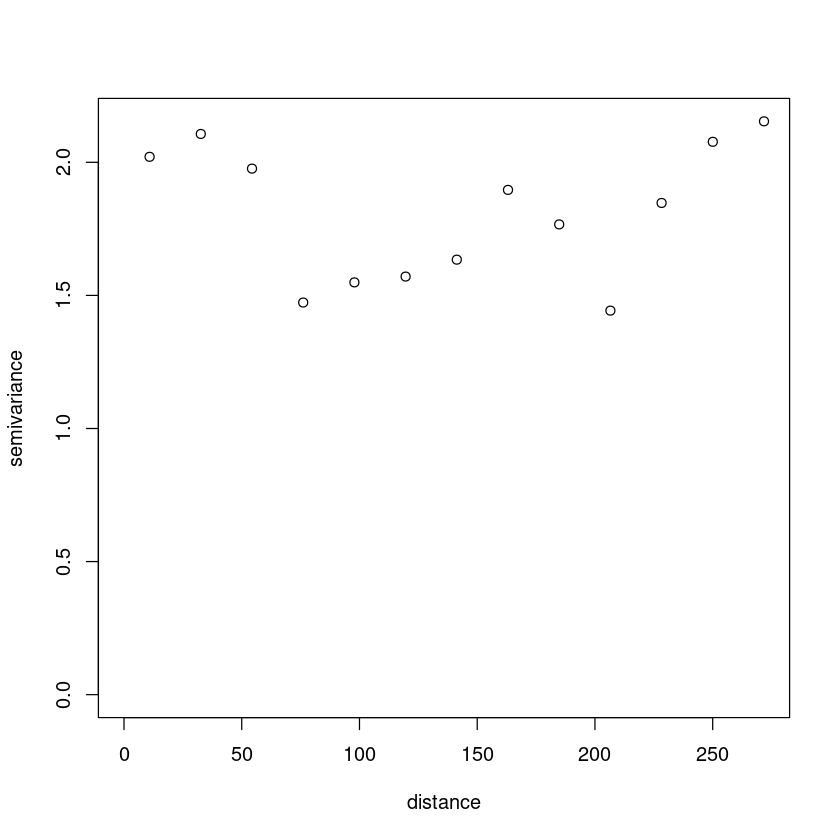

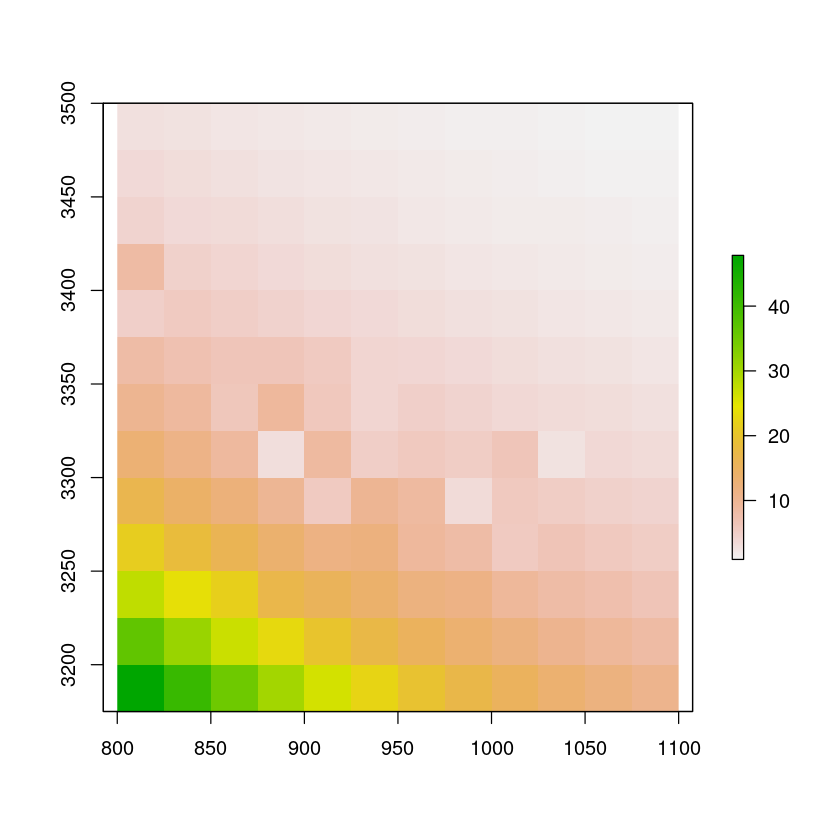

In [90]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_3 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_3))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "cte")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_3 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(0.2, 30), 
                     nugget = 2, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_3)

krig_lkft_regr_3 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_3))

krig_regr_3 <- krig_lkft_3$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_3 <- rasterFromXYZ(cbind(grid_df, krig_regr_3))
proj4string(pr_regr_lkft_3) <- proj4string(grid_3sp)
plot(pr_regr_lkft_3)

In [91]:
#### Correlation and Covariances

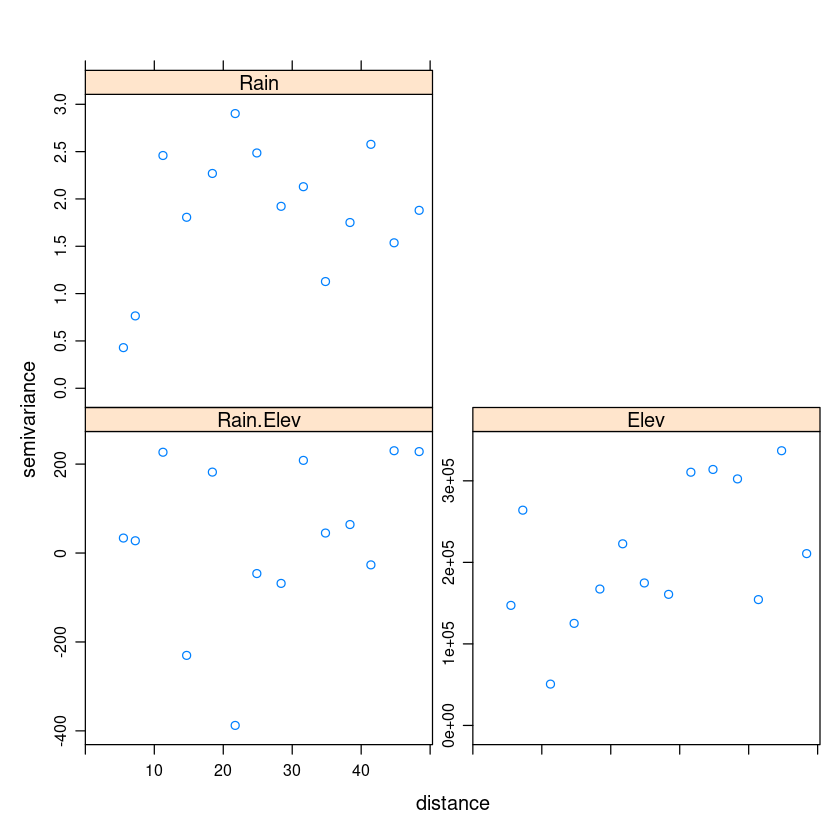

In [92]:
g2 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_3_prjtd)
g2 = gstat(g2, id = "Elev", form = elev~1, data = sd_3_prjtd)
v_cross = variogram(g2, cutoff = 50)
plot(v_cross)

In [93]:
g2 = gstat(g2, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g2 = fit.lmc(v_cross,g2)
g2

data:
Rain : formula = rain_transformed`~`1 ; data dim = 48 x 11
Elev : formula = elev`~`1 ; data dim = 48 x 11
variograms:
             model        psill   range
Rain[1]        Nug 1.678018e-02 0.00000
Rain[2]        Exp 2.245751e+00 9.88072
Elev[1]        Nug 8.207514e+04 0.00000
Elev[2]        Exp 1.408340e+05 9.88072
Rain.Elev[1]   Nug 3.711112e+01 0.00000
Rain.Elev[2]   Exp 1.039390e+00 9.88072

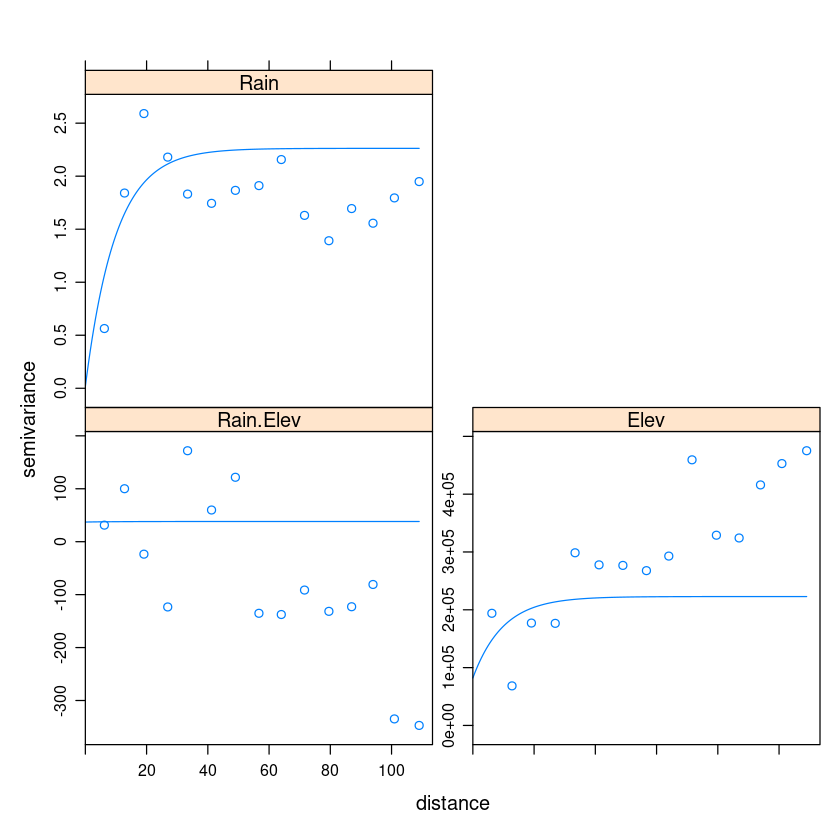

In [94]:
plot(variogram(g2), model= g2$model)

DAY 4

In [95]:
f4 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_4_July_23.csv"

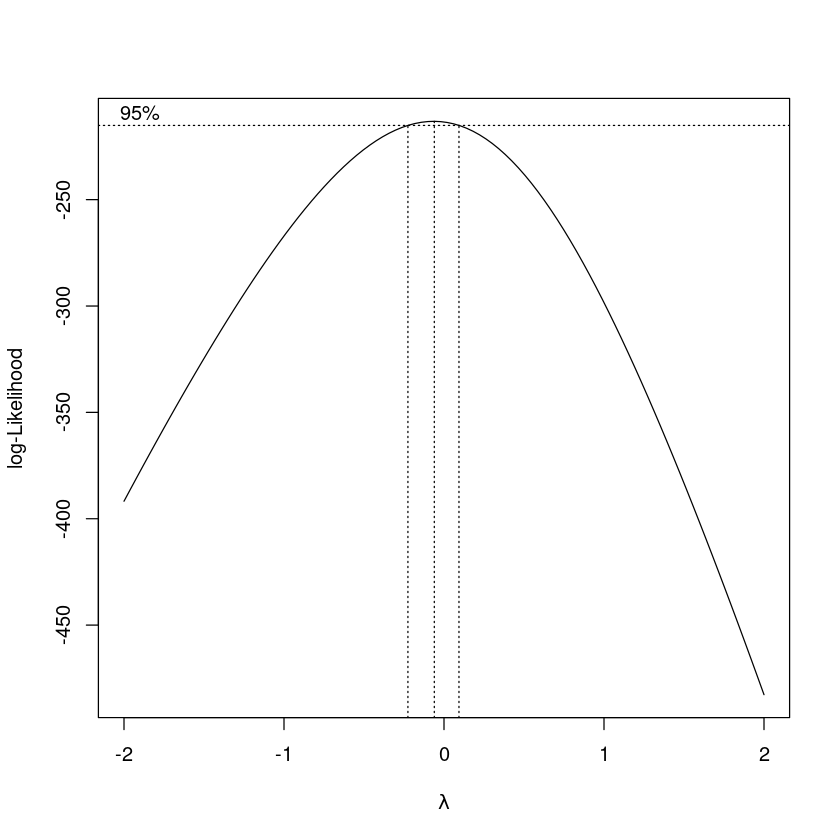

In [96]:
d4 = read.csv(f4)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d4$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d4$Rainfall_Transformed <- rain_transformed

In [97]:
lambda_rn

[1] -0.06060606

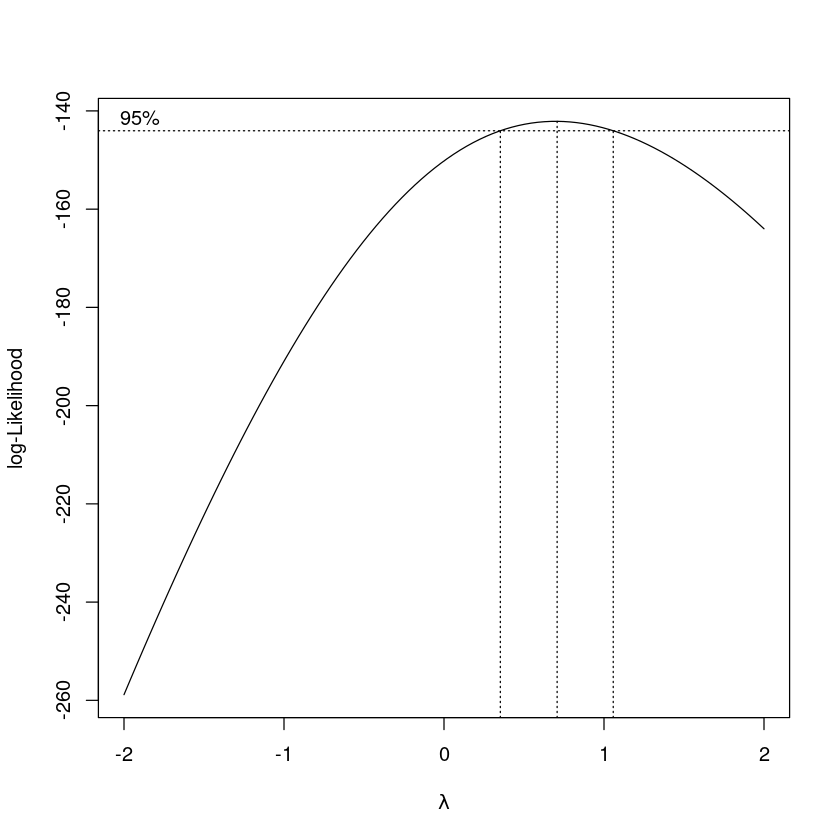

In [98]:
# Perform Box-Cox transformation on rainfall data
  elev <- d4$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d4$Elevation_Transformed <- el_transformed

In [99]:
coordinates1 = data.frame(lon = d4$Longitude, lat = d4$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d4_modb = subset(d4, select = -c(Longitude,Latitude))
sd_4 = SpatialPointsDataFrame(coords1,d4_modb)
class(sd_4)
proj4string(sd_4) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_4_prjtd <- spTransform(sd_4, CRS(desired_crs))
proj4string(sd_4_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

model psill     range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   0.1191896  0.00000 0.0   0    0    0    1     1    
2 Exp   2.6590780 30.58487 0.5   0    0    0    1     1

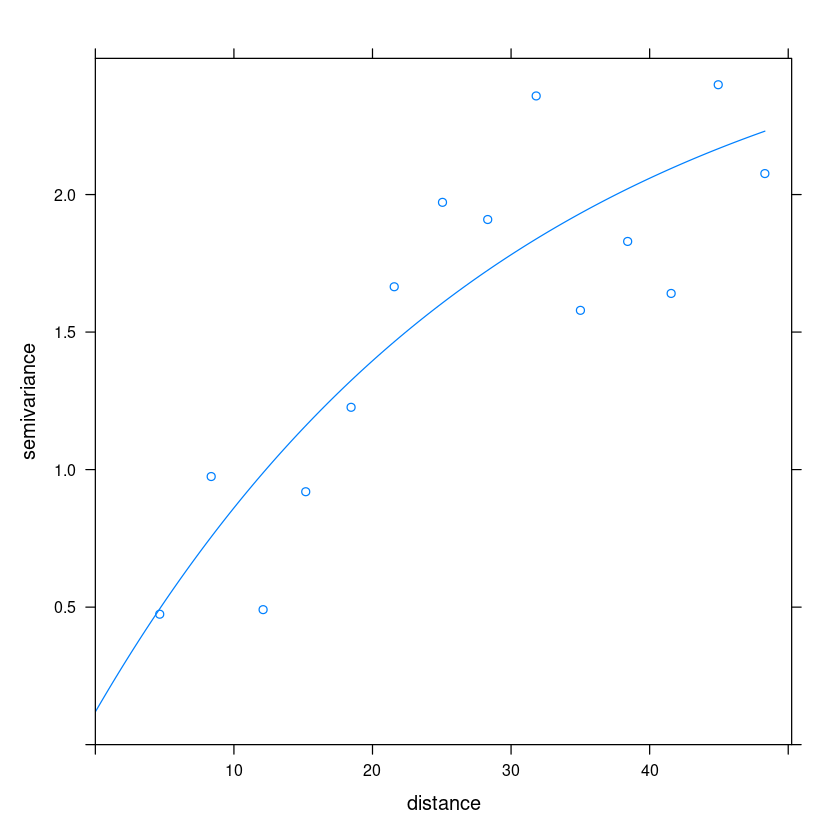

In [100]:
rain_vgm = variogram(rain_transformed ~1, data = sd_4_prjtd, cutoff = 50)
# plot(rain_vgm)
fit = vgm(2, "Exp", 30, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
fit_rain_vgm
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

Warning message in fit.variogram(elev_vgm, fit1):
“No convergence after 200 iterations: try different initial values?”


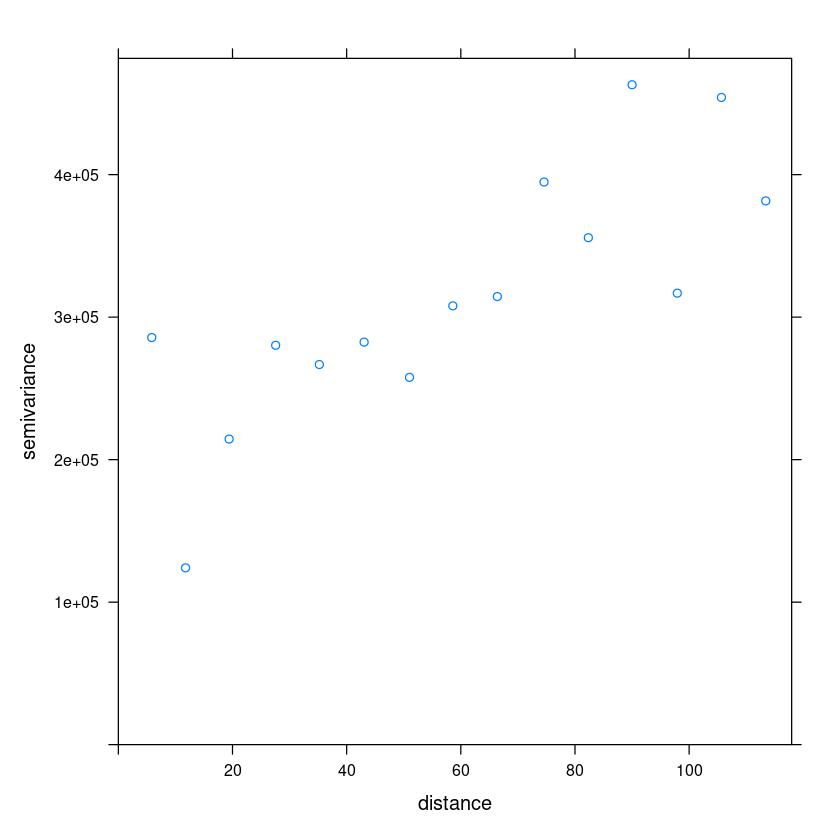

[1] -0.330113

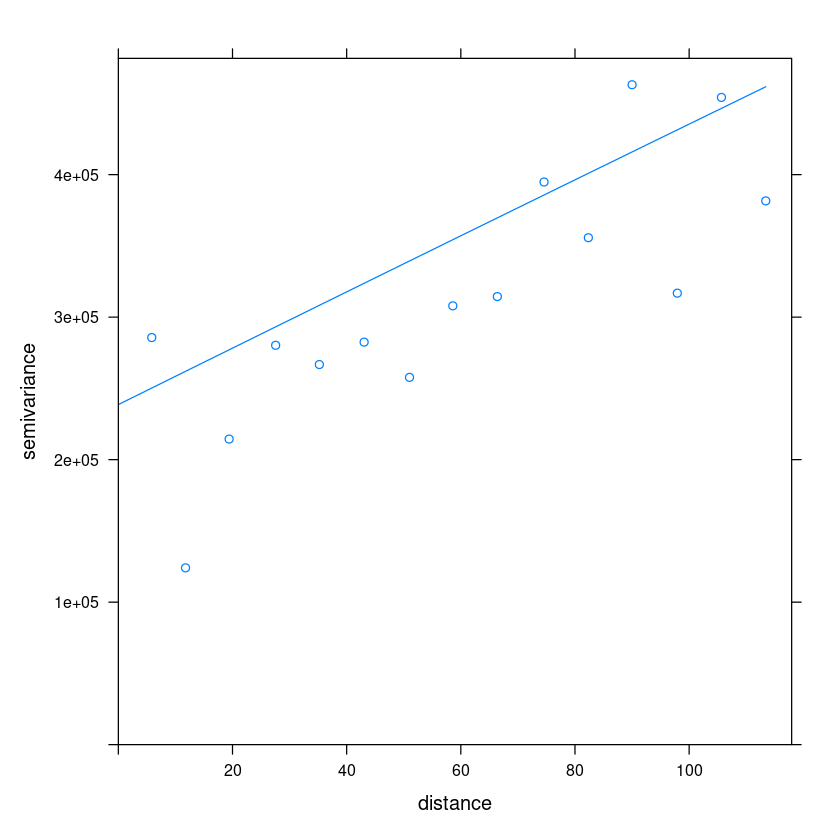

In [101]:
elev = d4$Elevation
elev_vgm = variogram(elev~1, data = sd_4_prjtd)
 plot(elev_vgm)
fit1 = vgm(6630272.8, "Exp", 3320.819, 239023.4)
fit_elev_vgm = fit.variogram(elev_vgm, fit1)
plot(elev_vgm, model = fit_elev_vgm)
# v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v
cor(rain_transformed,elev)

In [102]:
##likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"15.9607" " 0.0017" "-0.0048" " 0.3765" " 1.4487" "16.3557" 
Practical Range with cor=0.05 for asymptotic range: 28.30872

likfit: maximised log-likelihood = -263.4

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
15.9607  0.0017 -0.0048 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  1.449
      (estimated) cor. fct. parameter phi (range parameter)  =  16.36
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.3765

Transformation parameter:
      (fixed) Box-Cox parameter = -0.0606

Practical Range with cor=0.05 for asymptotic range: 28.30872

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-263.4"      "6"  "538.8"  "553.1" 

non spatial model:
   log.L n.params      AIC      BIC 
"-272.1"      "4"  "552.2"  "561.8" 

Call:
likfit(geodata = gdt_4, trend = "1st", ini.cov.pars = c(2.4, 
    50), nugg

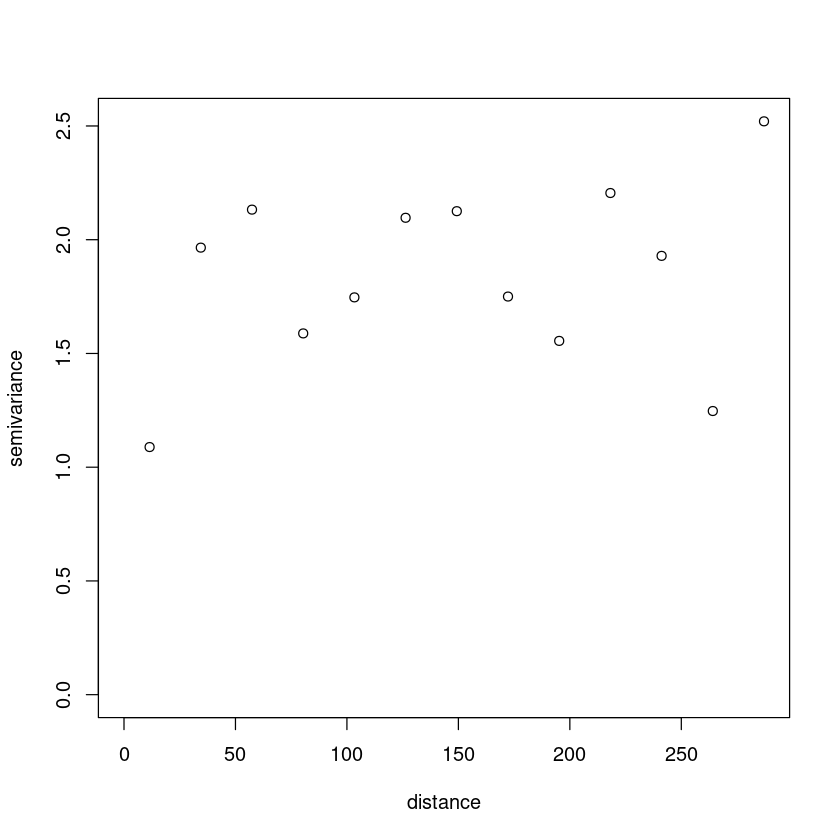

In [103]:
cord = coordinates(sd_4_prjtd)
rn = sd_4_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_4 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_4 = jitterDupCoords(gdt_4, max = jit_am)

vf_4 = variog(gdt_4, lambda = -0.0606060606060606, trend = "1st")
plot(vf_4)
vgm_rn_lk_4 = likfit(geodata = gdt_4, trend = "1st",cov.model = "gaussian", ini.cov.pars = c(2.4,50),nugget = 0.2, lambda = -0.0606060606060606, lik.method = "ML", messages = FALSE)
vgm_rn_lk_4
summary(vgm_rn_lk_4)


In [104]:
## Simpel krg

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


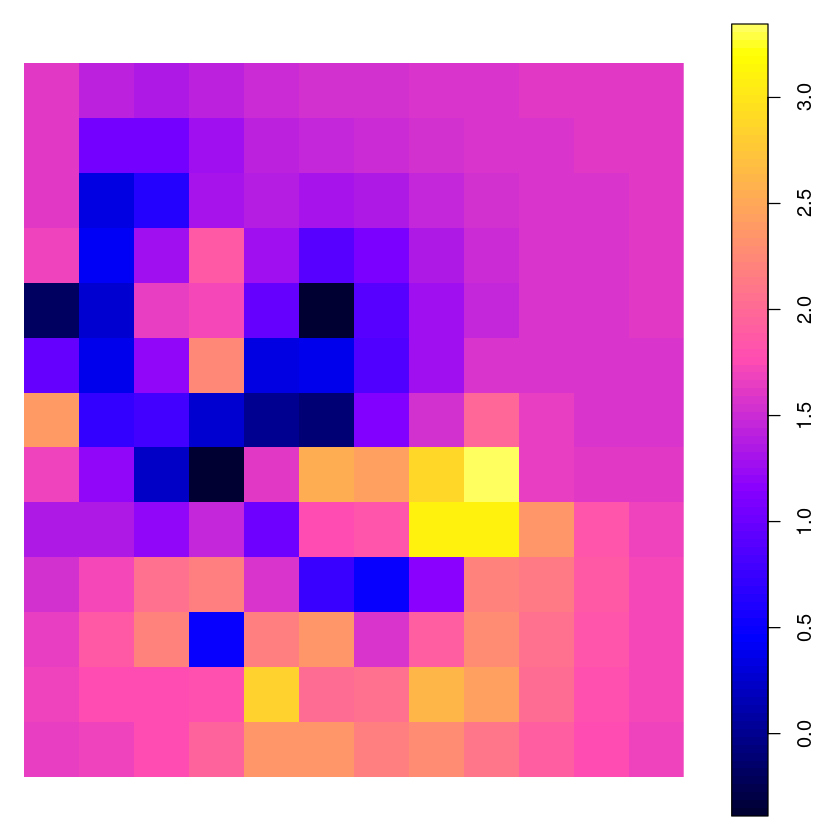

In [105]:
# Extract coordinates
coords <- coordinates(sd_4_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_4_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_4_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_4_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_4_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_4_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_4_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_4 <- krige(rain_transformed ~ 1, sd_4_prjtd_jittered, grid_3sp, fit_rain_vgm)




plot(resllt_4)


In [106]:
### Likfit Krg

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


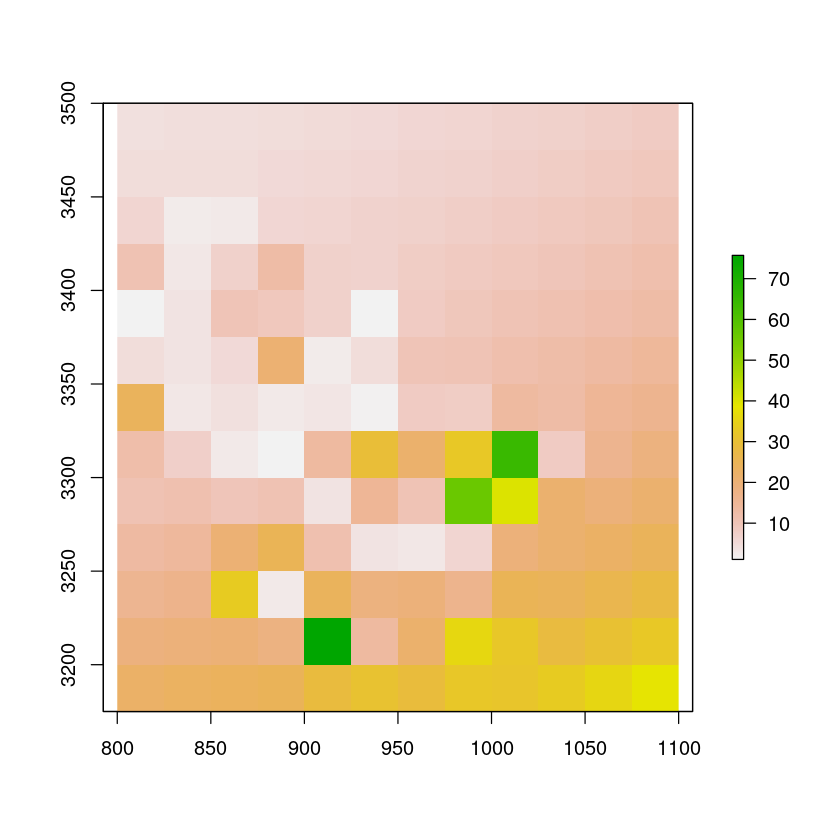

In [107]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_4 <- krige.conv(gdt_4, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_4))



krig_rain_lkft_4 <- krig_lkft_4$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_4 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_4))
proj4string(pr_rain_lkft_4) <- proj4string(grid_3sp)
plot(pr_rain_lkft_4)

In [108]:
### Regression

Generalized Linear Model 

81 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 73, 75, 72, 72, 73, 72, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.357812  0.2129468  1.153607

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-9.9154  0.0049  0.0017 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  1.138
      (estimated) cor. fct. parameter phi (range parameter)  =  16.7
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.484

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 28.90595

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-128.1"      "6"  "268.2"  "282.6" 

non spatial model:
   log.L n.params      AIC      BIC 
"-134.9"      "4"  "277.9"  "287.5" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = c

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


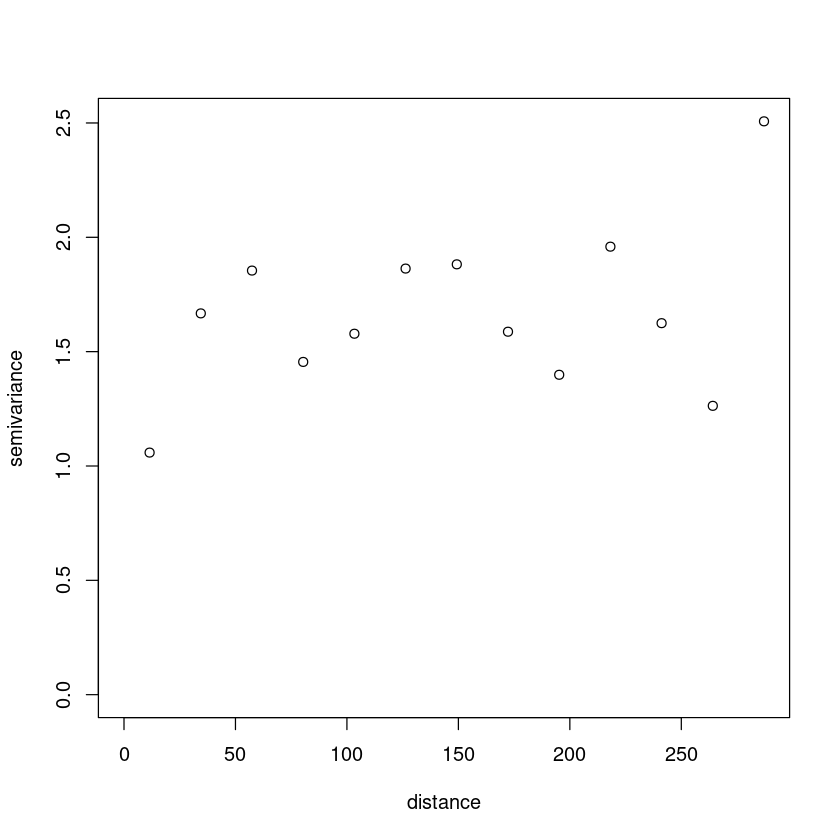

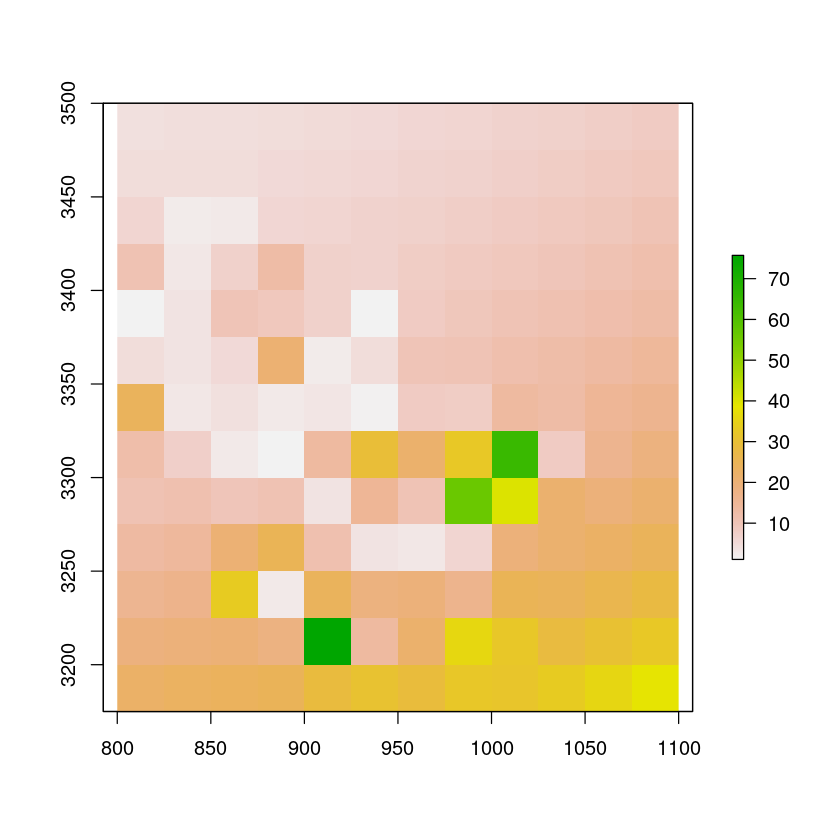

In [109]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_4 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_4))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_4 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "gaussian", 
                     ini.cov.pars = c(2.5, 50), 
                     nugget = 0.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_4)

krig_lkft_regr_4 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_4))

krig_regr_4 <- krig_lkft_4$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_4 <- rasterFromXYZ(cbind(grid_df, krig_regr_4))
proj4string(pr_regr_lkft_4) <- proj4string(grid_3sp)
plot(pr_regr_lkft_4)

In [110]:
### Corrleation and Covar

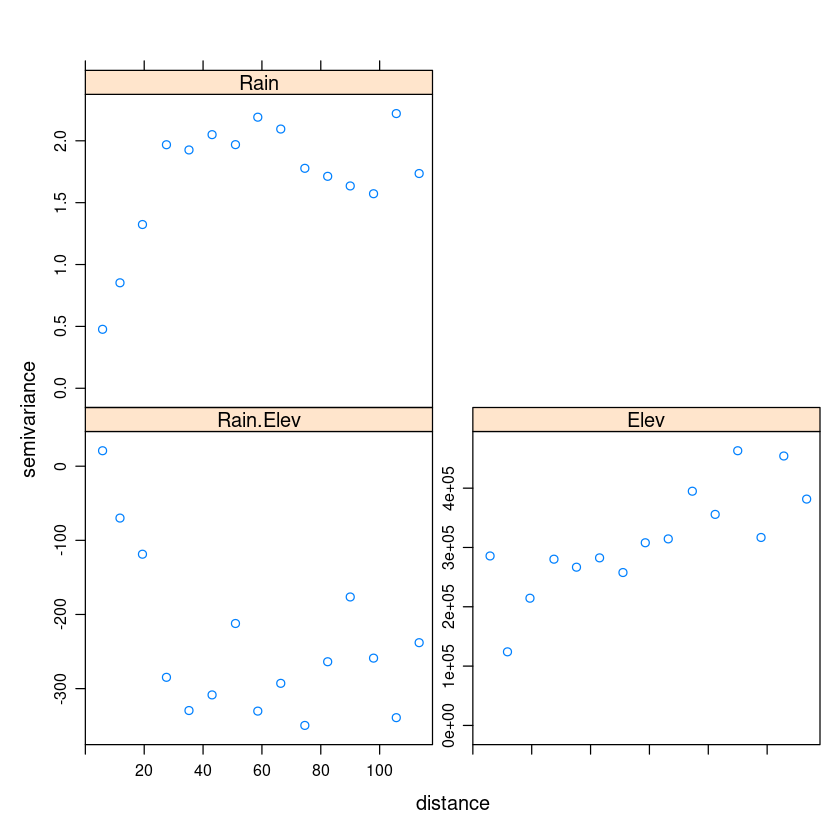

In [111]:
g3 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_4_prjtd)
g3 = gstat(g3, id = "Elev", form = elev~1, data = sd_4_prjtd)
v_cross = variogram(g3)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 81 x 11
Elev : formula = elev`~`1 ; data dim = 81 x 11
variograms:
             model         psill    range
Rain[1]        Nug  2.207172e-01  0.00000
Rain[2]        Exp  2.158895e+00 30.58487
Elev[1]        Nug  1.678801e+05  0.00000
Elev[2]        Exp  1.627801e+05 30.58487
Rain.Elev[1]   Nug  7.505277e+01  0.00000
Rain.Elev[2]   Exp -4.497223e+02 30.58487

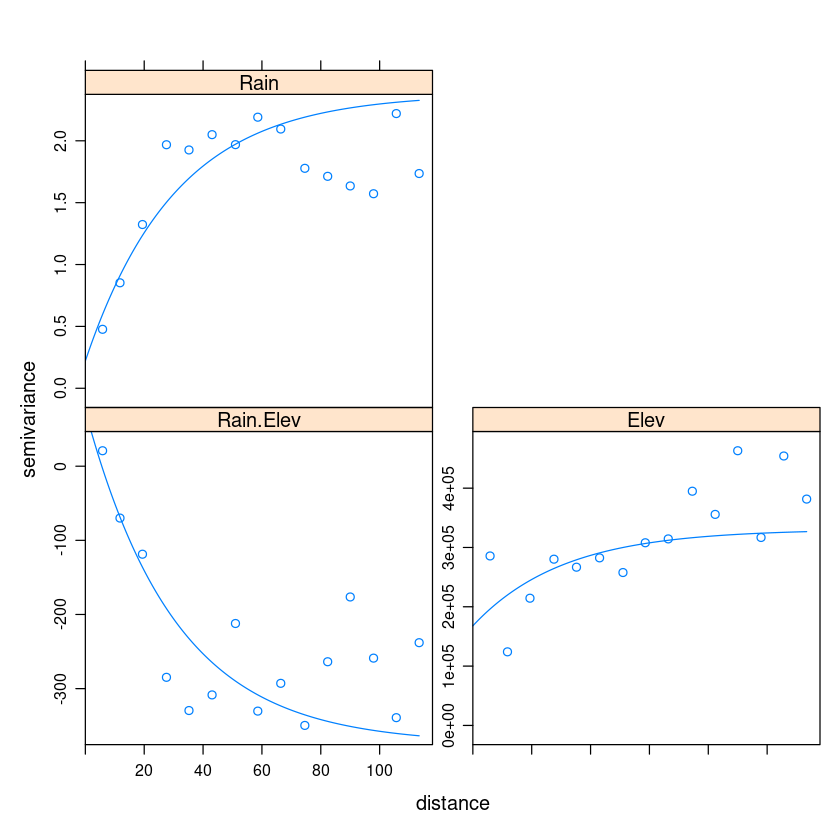

In [112]:
g3 = gstat(g3, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g3 = fit.lmc(v_cross,g3)
g3
plot(variogram(g3), model= g3$model)

DAY 5

In [113]:
f5 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_5_July_23.csv"

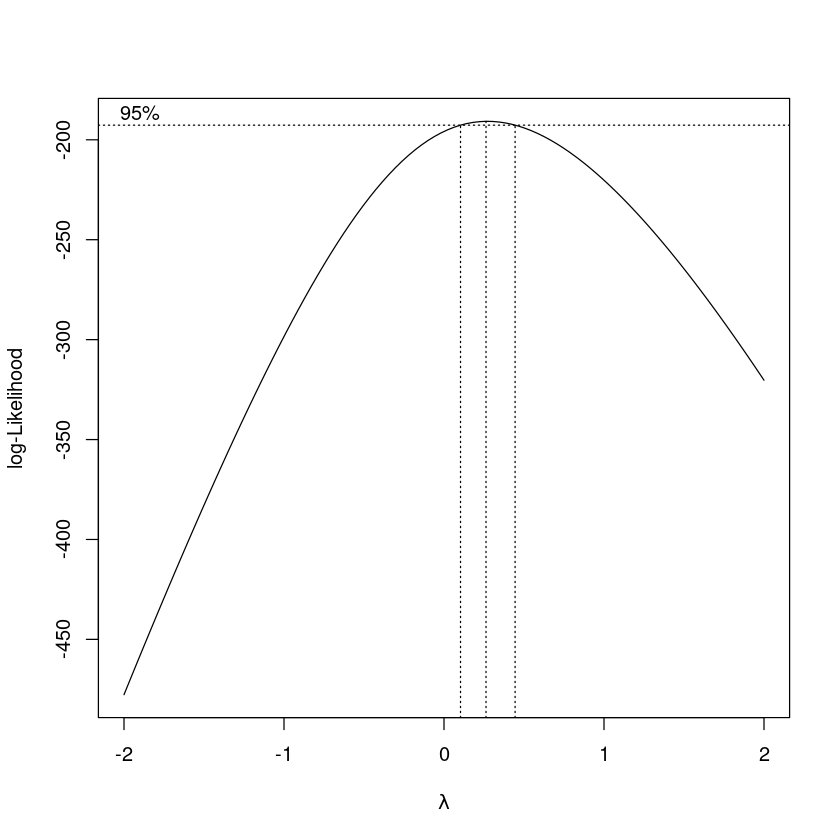

In [114]:
d5 = read.csv(f5)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d5$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d5$Rainfall_Transformed <- rain_transformed

In [115]:
lambda_rn

[1] 0.2626263

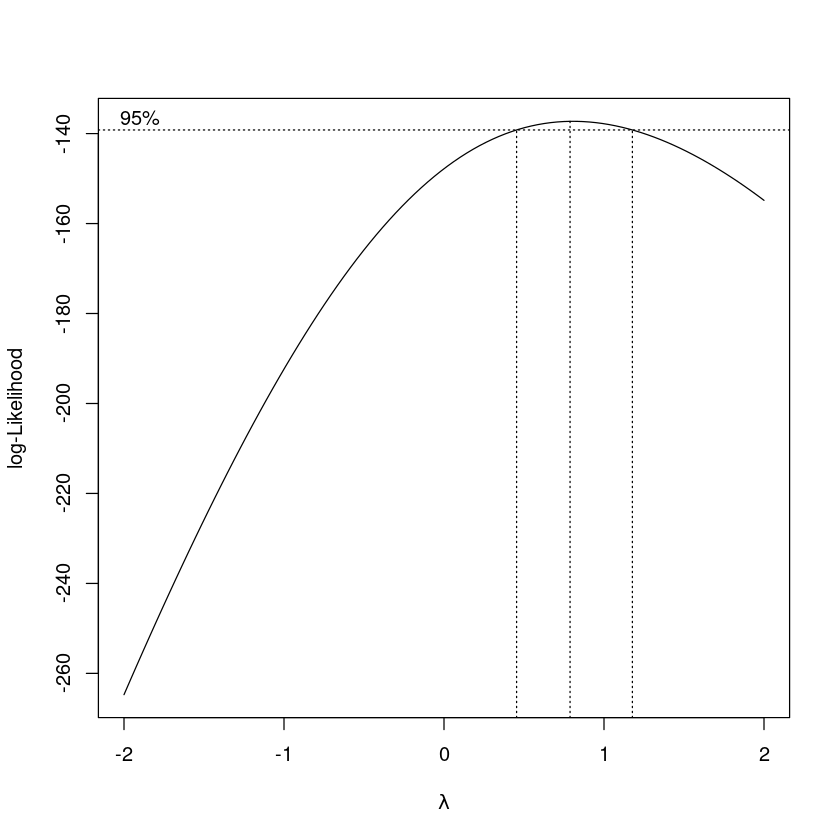

In [116]:
# Perform Box-Cox transformation on rainfall data
  elev <- d5$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d5$Elevation_Transformed <- el_transformed

In [117]:
coordinates1 = data.frame(lon = d5$Longitude, lat = d5$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d5_modb = subset(d5, select = -c(Longitude,Latitude))
sd_5 = SpatialPointsDataFrame(coords1,d5_modb)
class(sd_5)
proj4string(sd_5) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_5_prjtd <- spTransform(sd_5, CRS(desired_crs))
proj4string(sd_5_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   0.000000 0.000000 0.0   0    0    0    1     1    
2 Exp   4.701356 5.429554 0.5   0    0    0    1     1

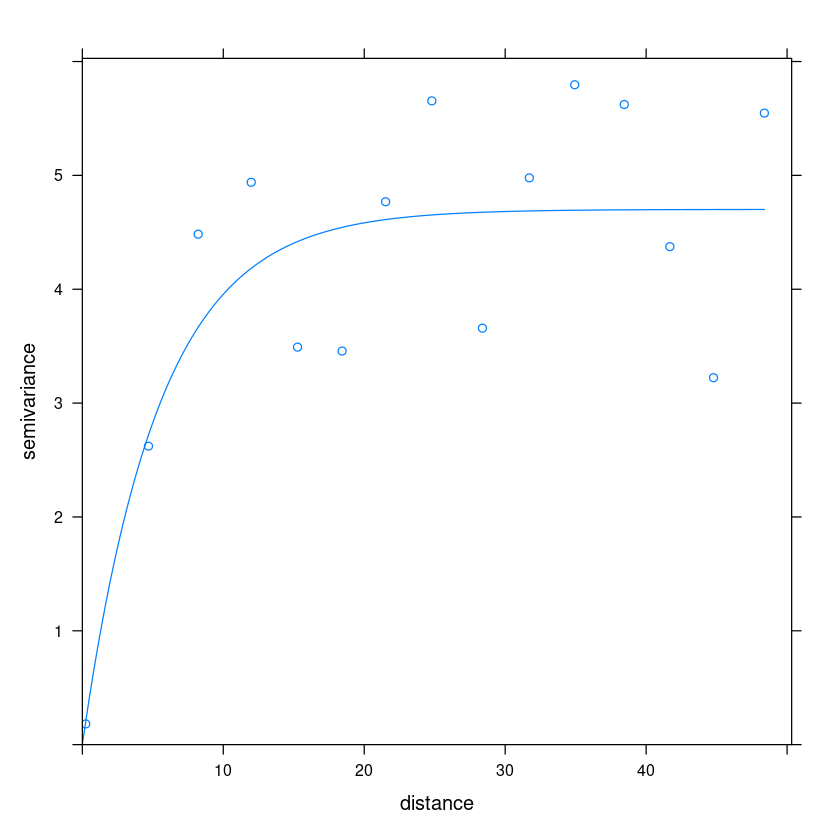

In [118]:
rain_vgm = variogram(rain_transformed ~1, data = sd_5_prjtd, cutoff = 50)
fit = vgm(4.7, "Exp", 5.4, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
fit_rain_vgm 
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

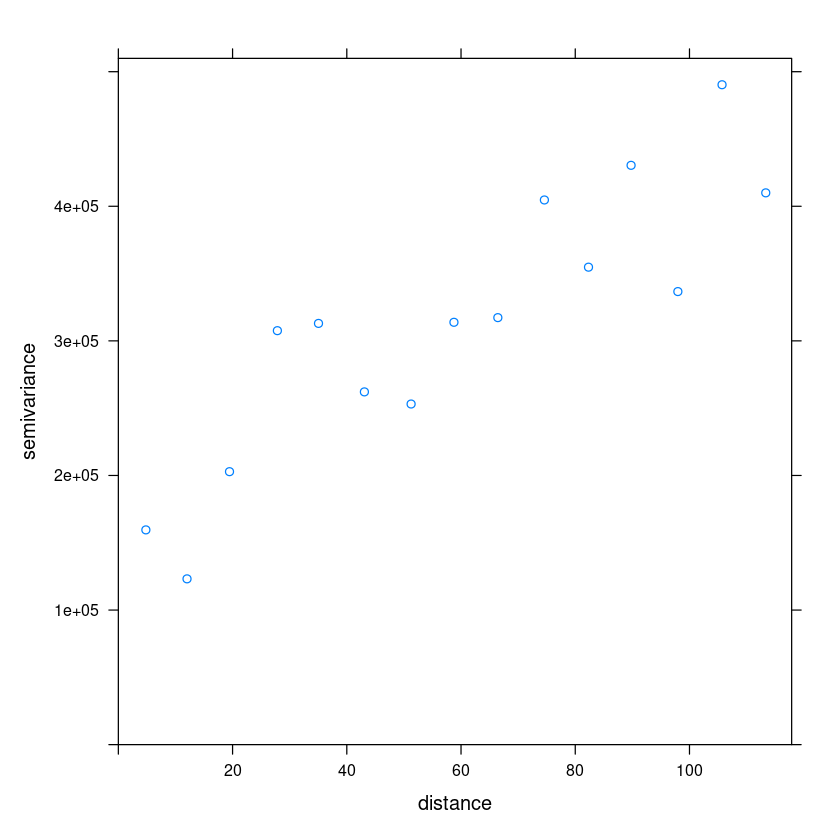

[1] 0.03596281

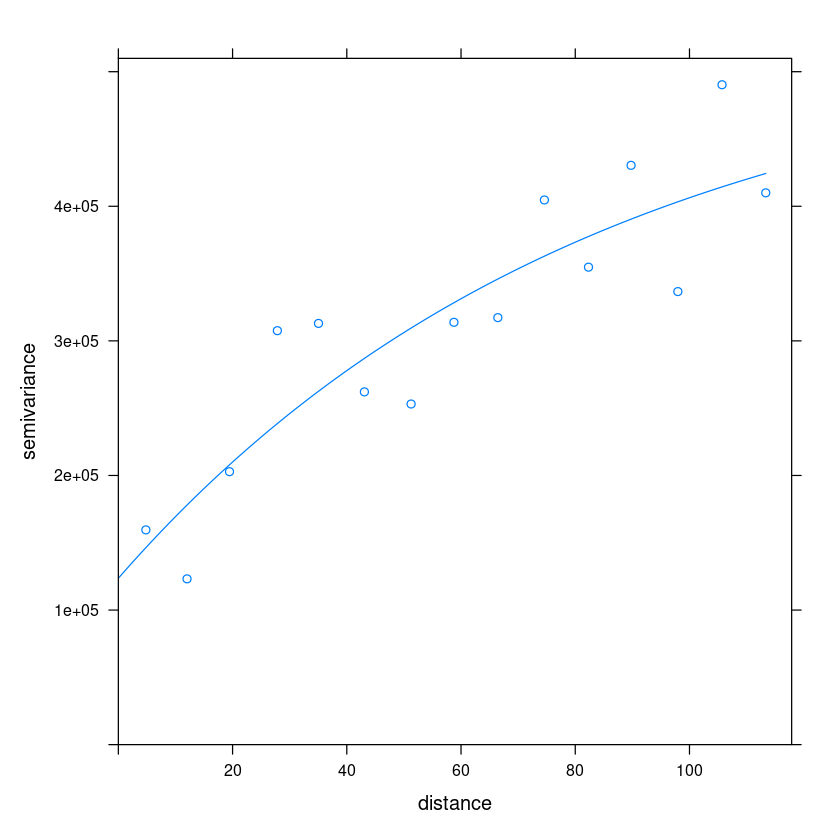

In [119]:
elev = d5$Elevation
elev_vgm = variogram(elev~1, data = sd_5_prjtd)
 plot(elev_vgm)
fit1 = vgm(404320.0, "Exp",83.24396 , 123629.9)
fit_elev_vgm = fit.variogram(elev_vgm, fit1)
plot(elev_vgm, model = fit_elev_vgm)
# v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v
cor(rain_transformed,elev)

In [120]:
## Likfit Var

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"81.3251" "-0.0048" "-0.0220" " 0.0000" " 5.5905" "10.0905" 
Practical Range with cor=0.05 for asymptotic range: 30.22837

likfit: maximised log-likelihood = -368.2

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
81.3251 -0.0048 -0.0220 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  5.59
      (estimated) cor. fct. parameter phi (range parameter)  =  10.09
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 0.2626

Practical Range with cor=0.05 for asymptotic range: 30.22837

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-368.2"      "6"  "748.3"  "763.6" 

non spatial model:
   log.L n.params      AIC      BIC 
"-379.4"      "4"  "766.7"  "776.9" 

Call:
likfit(geodata = gdt_5, trend = "1st", ini.cov.pars = c(6.5, 
    60), nugget =

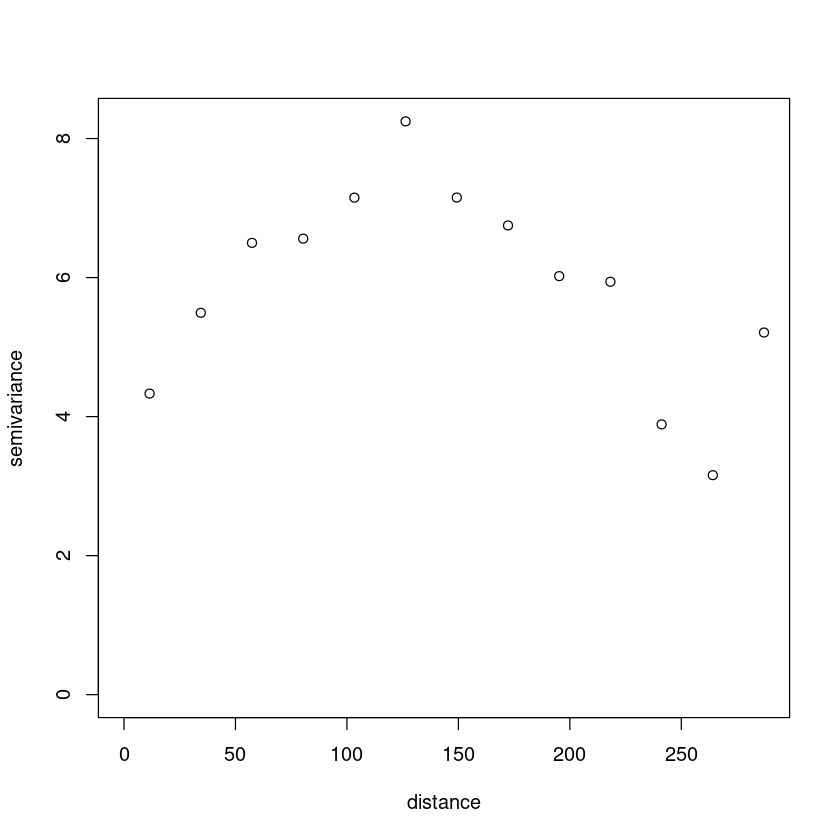

In [121]:
cord = coordinates(sd_5_prjtd)
rn = sd_5_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_5 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_5 = jitterDupCoords(gdt_2, max = jit_am)

vf_5 = variog(gdt_5, lambda = 0.262626262626263, trend = "cte")
plot(vf_5)
vgm_rn_lk_5 = likfit(geodata = gdt_5, trend = "1st",cov.model = "exponential", ini.cov.pars = c(6.5,60),nugget = 3, lambda = 0.262626262626263, lik.method = "ML", messages = FALSE)
vgm_rn_lk_5
summary(vgm_rn_lk_5)

In [122]:
## Simple krg

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


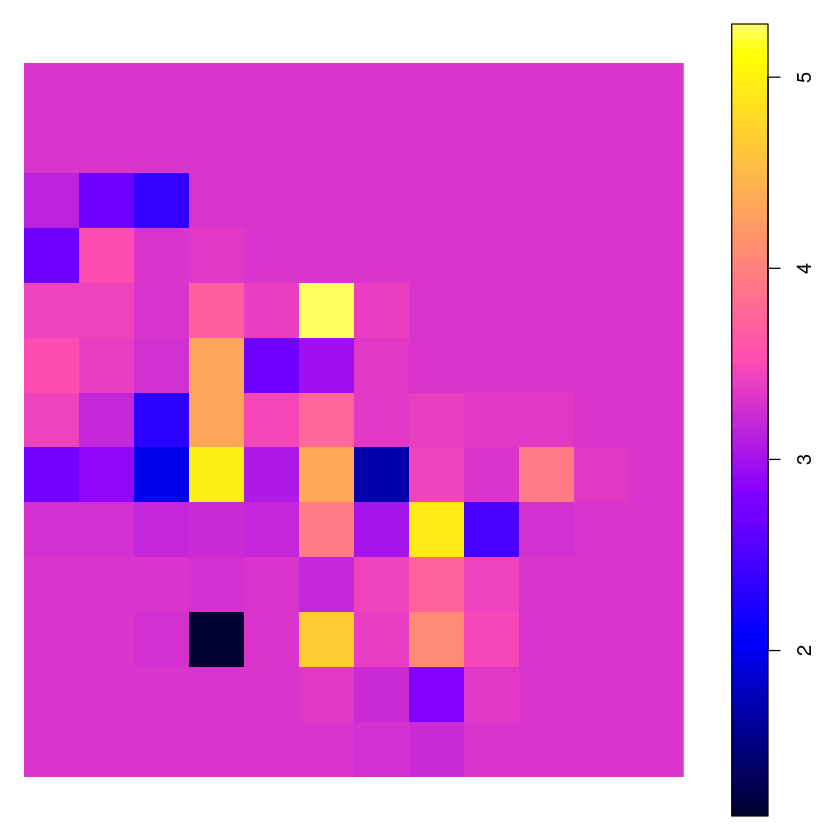

In [123]:
# Extract coordinates
coords <- coordinates(sd_5_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_5_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_5_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_5_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_5_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_2_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_5_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_5 <- krige(rain_transformed ~ 1, sd_5_prjtd_jittered, grid_3sp, fit_rain_vgm)




plot(resllt_5)

In [124]:
## Likfit krg

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


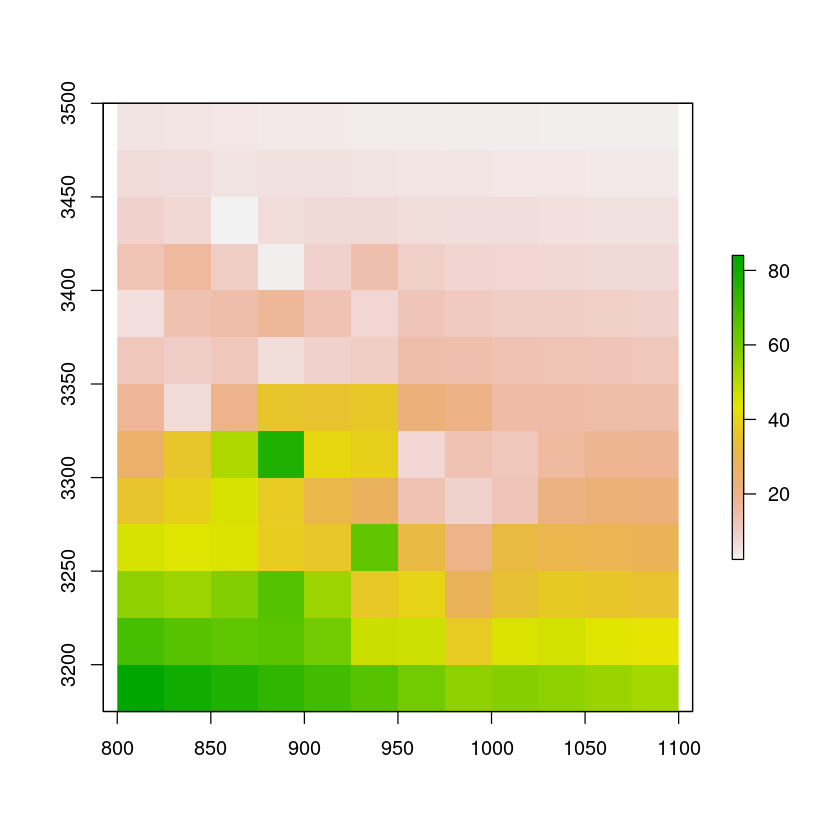

In [125]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_5 <- krige.conv(gdt_5, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_5))


krig_rain_lkft_5 <- krig_lkft_5$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_5 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_5))
proj4string(pr_rain_lkft_5) <- proj4string(grid_3sp)
plot(pr_rain_lkft_2)

In [126]:
## Regression

Generalized Linear Model 

81 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 73, 74, 73, 74, 72, 73, ... 
Resampling results:

  RMSE      Rsquared   MAE    
  2.124774  0.1440531  1.73788

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-10.2890   0.0028   0.0023 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  4.246
      (estimated) cor. fct. parameter phi (range parameter)  =  3.943
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.2809

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 11.81215

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-174"      "6"  "360.1"  "374.4" 

non spatial model:
   log.L n.params      AIC      BIC 
"-175.4"      "4"  "358.8"  "368.4" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.c

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


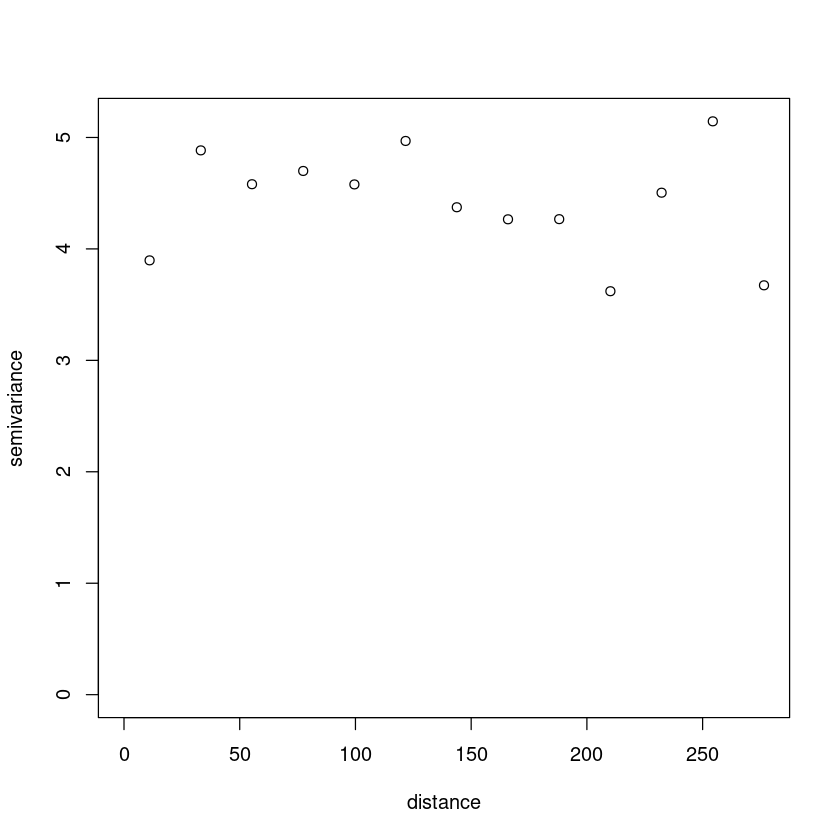

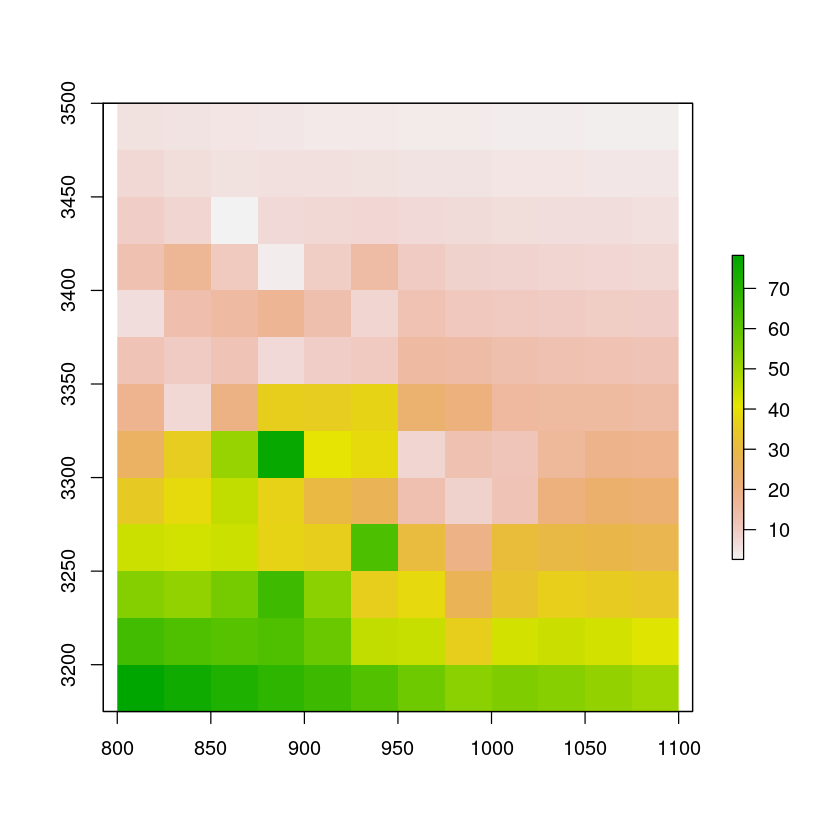

In [127]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_5 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_5))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "cte")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_5 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(5, 60), 
                     nugget = 3, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_5)

krig_lkft_regr_5 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_5))

krig_regr_5 <- krig_lkft_5$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_5 <- rasterFromXYZ(cbind(grid_df, krig_regr_5))
proj4string(pr_regr_lkft_5) <- proj4string(grid_3sp)
plot(pr_regr_lkft_5)


In [128]:
### Covariances

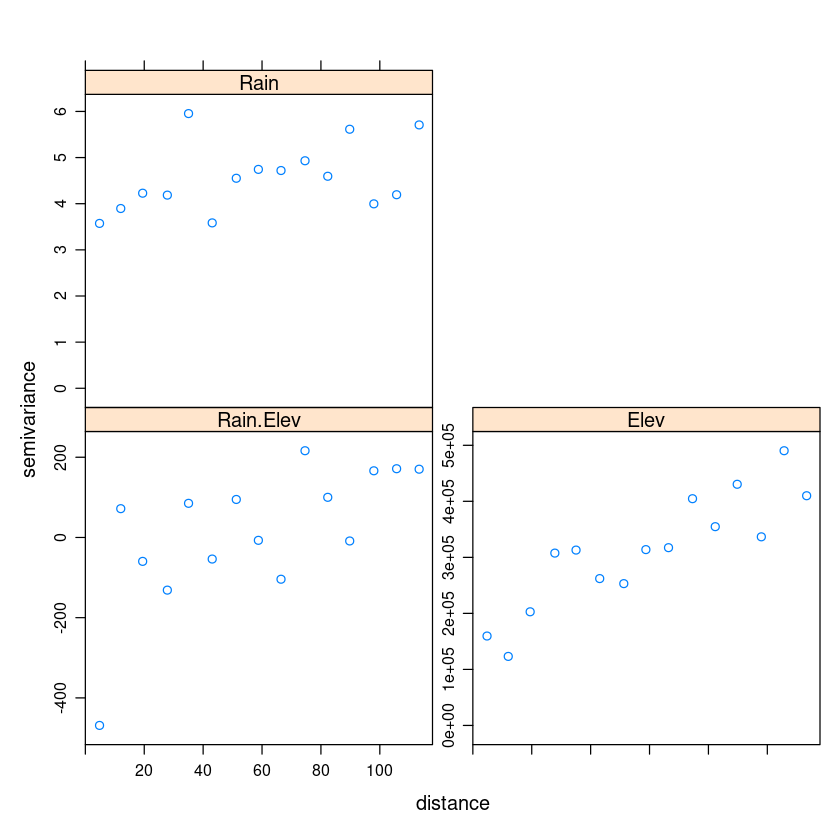

In [129]:
g4 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_5_prjtd)
g4 = gstat(g4, id = "Elev", form = elev~1, data = sd_5_prjtd)
v_cross = variogram(g4)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 81 x 11
Elev : formula = elev`~`1 ; data dim = 81 x 11
variograms:
             model         psill    range
Rain[1]        Nug    583.108379 0.000000
Rain[2]        Exp      5.642023 5.429554
Elev[1]        Nug    582.045743 0.000000
Elev[2]        Exp 259583.896745 5.429554
Rain.Elev[1]   Nug   -582.576819 0.000000
Rain.Elev[2]   Exp   1210.197597 5.429554

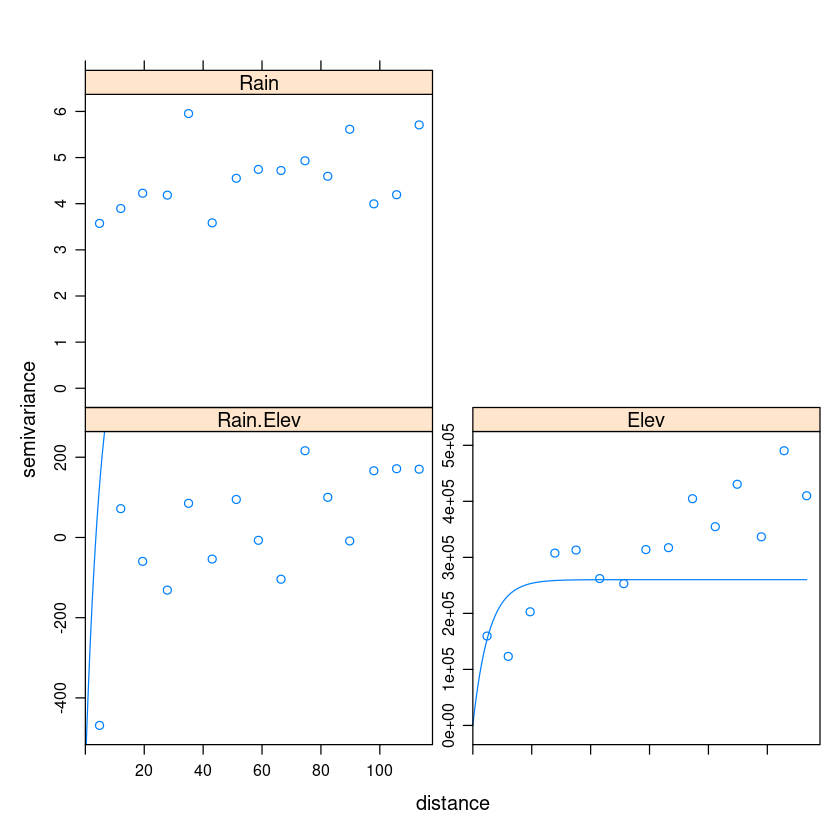

In [130]:
g4 = gstat(g4, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g4 = fit.lmc(v_cross,g4)
g4
plot(variogram(g4), model= g4$model)

DAY 6

In [131]:
f6 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_6_July_23.csv"

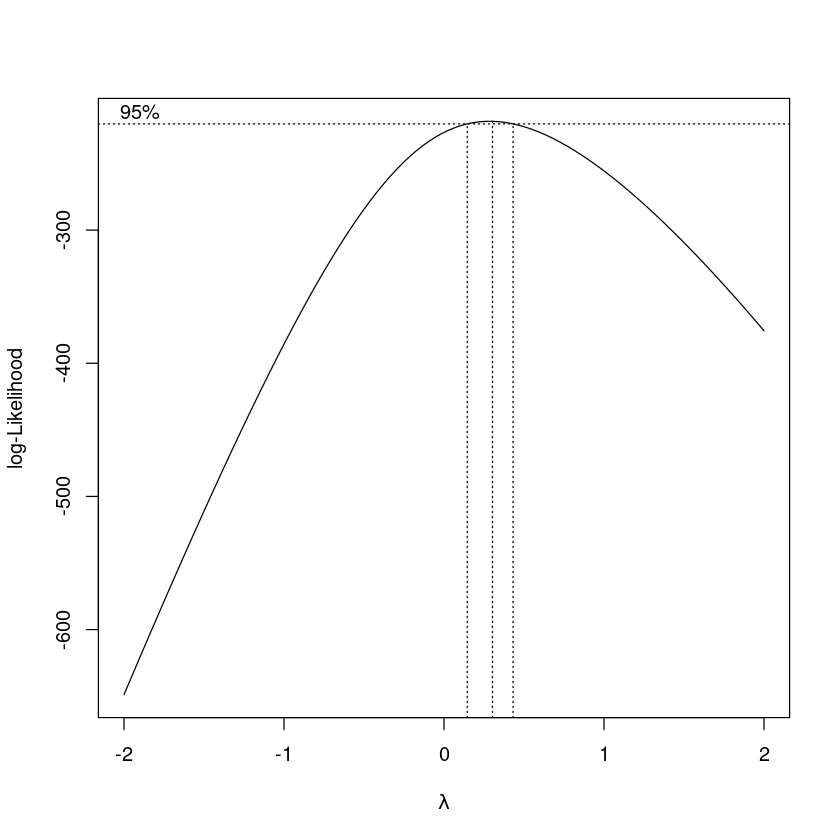

In [132]:
d6 = read.csv(f6)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d6$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d6$Rainfall_Transformed <- rain_transformed

In [133]:
lambda_rn

[1] 0.3030303

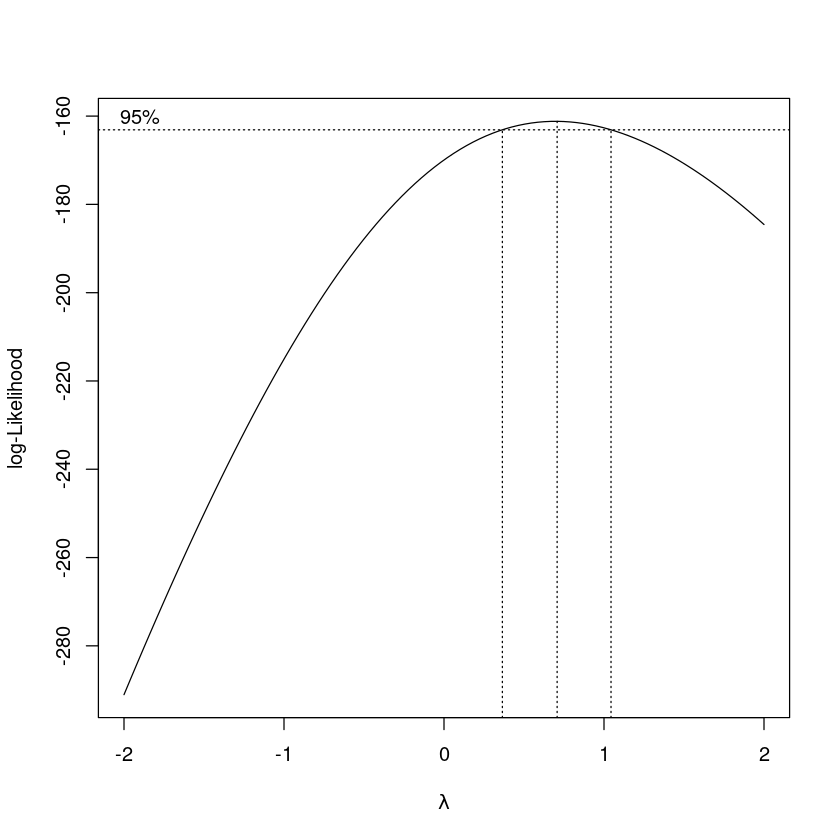

In [134]:
# Perform Box-Cox transformation on rainfall data
  elev <- d6$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d6$Elevation_Transformed <- el_transformed

In [135]:
coordinates1 = data.frame(lon = d6$Longitude, lat = d6$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d6_modb = subset(d6, select = -c(Longitude,Latitude))
sd_6 = SpatialPointsDataFrame(coords1,d6_modb)
class(sd_6)
proj4string(sd_6) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_6_prjtd <- spTransform(sd_6, CRS(desired_crs))
proj4string(sd_6_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(rain_vgm, fit):
“No convergence after 200 iterations: try different initial values?”


model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   4.626518   0.0000 0.0   0    0    0    1     1    
2 Exp   2.845897 120.8503 0.5   0    0    0    1     1

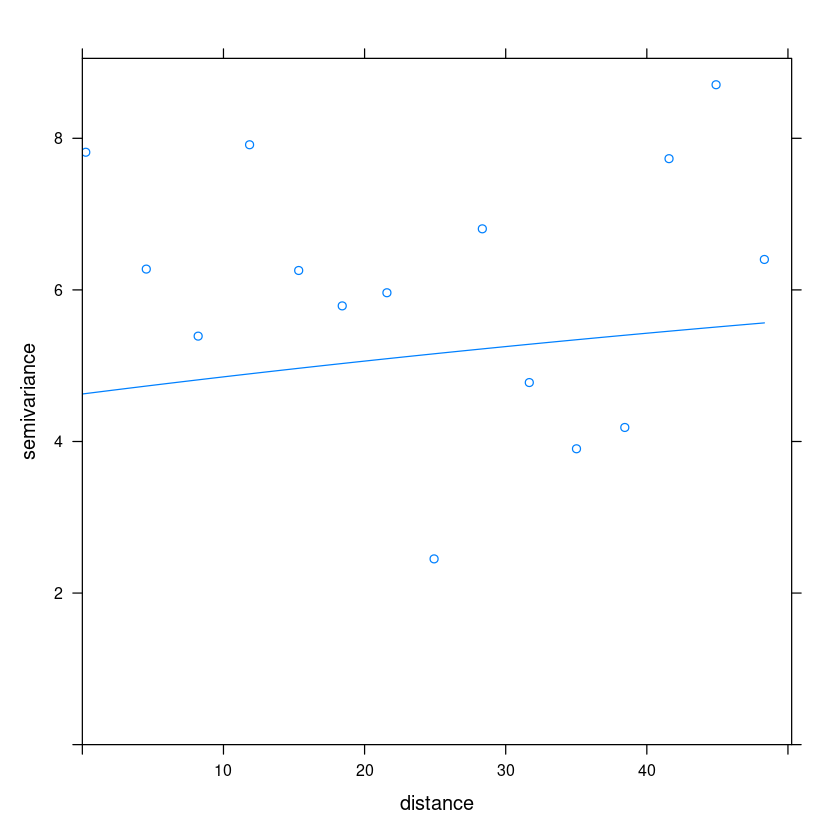

In [136]:
rain_vgm = variogram(rain_transformed ~1, data = sd_6_prjtd, cutoff = 50)
fit = vgm(3, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
fit_rain_vgm
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

In [137]:
elev = d6$Elevation
elev_vgm = variogram(elev~1, data = sd_6_prjtd)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug    95204.5  0.00000 0.0   0    0    0    1     1    
2 Exp   336200.6 35.11553 0.5   0    0    0    1     1

[1] -0.2977894

In [138]:
## Likfit Var

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"115.4990" " -0.0198" " -0.0279" "  4.3875" "  2.8195" " 36.9898" 
Practical Range with cor=0.05 for asymptotic range: 110.8115

likfit: maximised log-likelihood = -398.2

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
115.4990  -0.0198  -0.0279 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  2.82
      (estimated) cor. fct. parameter phi (range parameter)  =  36.99
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  4.388

Transformation parameter:
      (fixed) Box-Cox parameter = 0.303

Practical Range with cor=0.05 for asymptotic range: 110.8115

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-398.2"      "6"  "808.5"  "823.5" 

non spatial model:
   log.L n.params      AIC      BIC 
  "-400"      "4"  "808.1"  "818.1" 

Call:
likfit(geodata = gdt_6, trend = "1st", ini.cov.pars = c(5, 60), 
    n

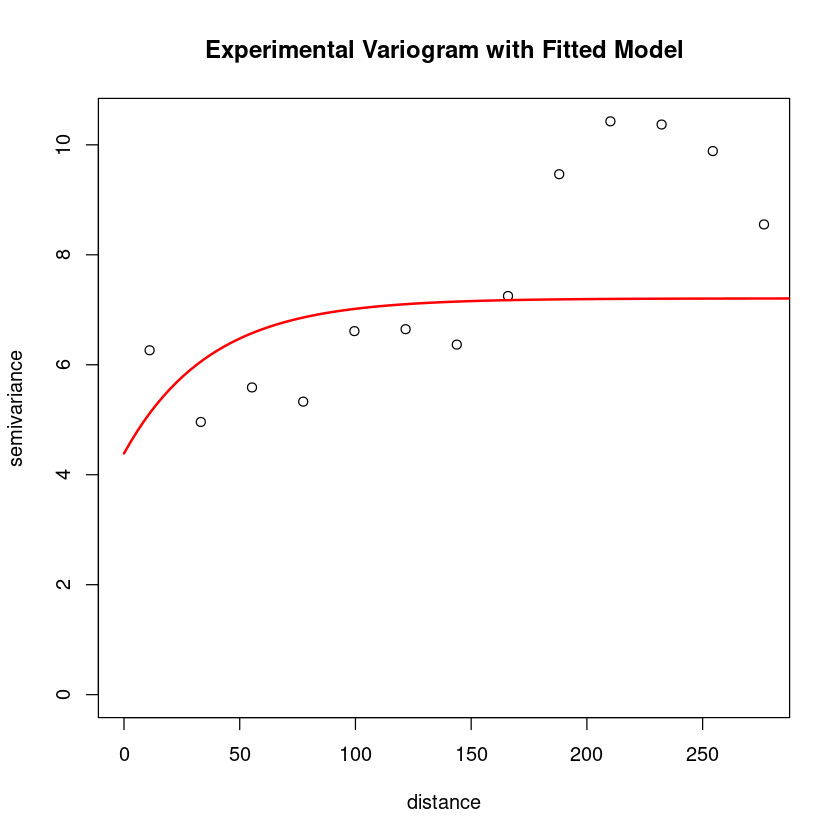

In [139]:
cord = coordinates(sd_6_prjtd)
rn = sd_6_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_6 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_6 = jitterDupCoords(gdt_6, max = jit_am)

vf_6 = variog(gdt_6, lambda = 0.303030303030303, trend = "1st")
vgm_rn_lk_6 = likfit(geodata = gdt_6, trend = "1st",cov.model = "exponential", ini.cov.pars = c(5,60),nugget = 2, lambda = 0.303030303030303, lik.method = "ML", messages = FALSE)
vgm_rn_lk_6
summary(vgm_rn_lk_6)
# Plot the experimental variogram
plot(vf_6, main = "Experimental Variogram with Fitted Model")

# Add the fitted model
lines(vgm_rn_lk_6, col = "red", lwd = 2)

In [140]:
### Simple krig

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


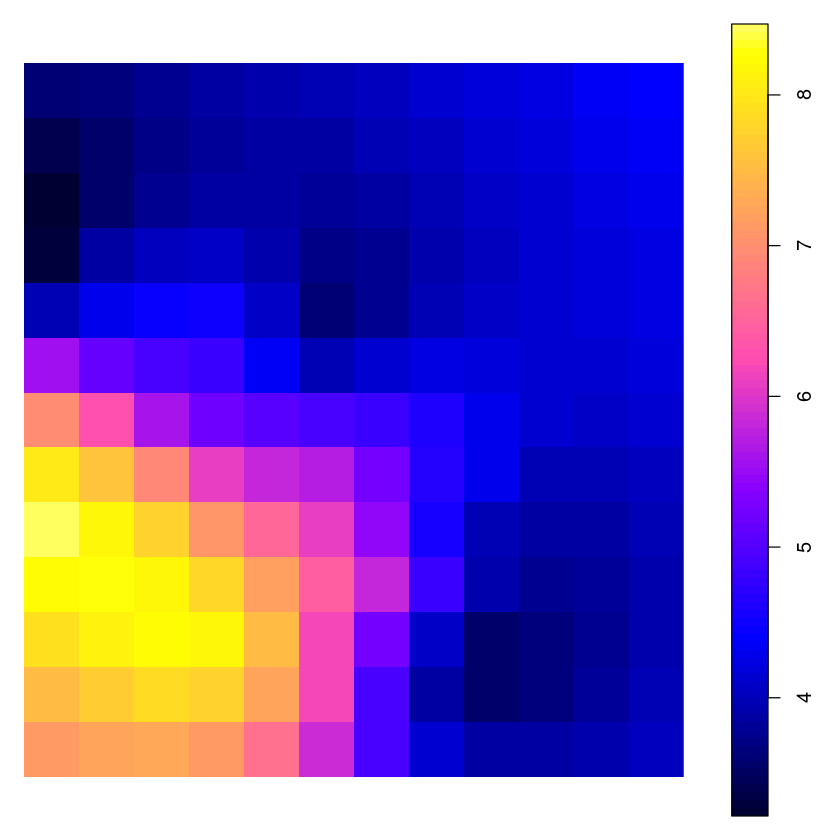

In [141]:
# Extract coordinates
coords <- coordinates(sd_6_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_6_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_6_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_6_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_6_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_6_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_6_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_6 <- krige(rain_transformed ~ 1, sd_6_prjtd_jittered, grid_3sp, fit_rain_vgm)

plot(resllt_6)

In [142]:
### Likfit Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


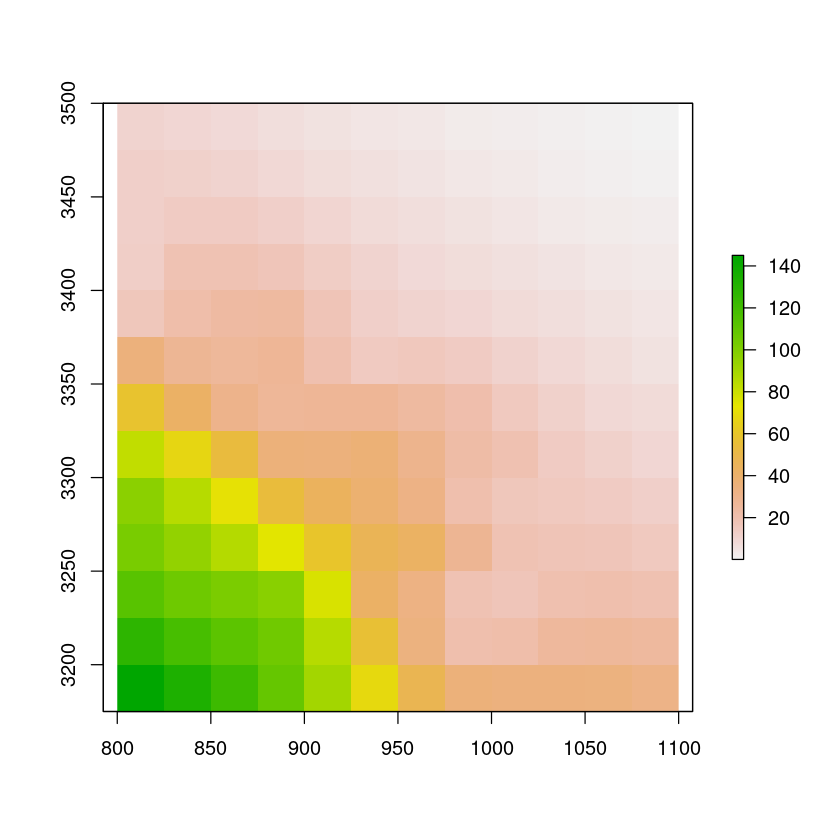

In [143]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_6 <- krige.conv(gdt_6, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_6))



krig_rain_lkft_6 <- krig_lkft_6$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_6 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_6))
proj4string(pr_rain_lkft_6) <- proj4string(grid_3sp)
plot(pr_rain_lkft_6)


In [144]:
## Regression

Generalized Linear Model 

90 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 81, 82, 80, 80, 80, 81, ... 
Resampling results:

  RMSE      Rsquared   MAE    
  2.831479  0.2507459  2.23078

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
62.4856 -0.0138 -0.0151 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  2.783
      (estimated) cor. fct. parameter phi (range parameter)  =  59.21
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  4.645

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 59.20697

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-214"      "6"    "440"    "455" 

non spatial model:
   log.L n.params      AIC      BIC 
"-215.7"      "4"  "439.4"  "449.4" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars =

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


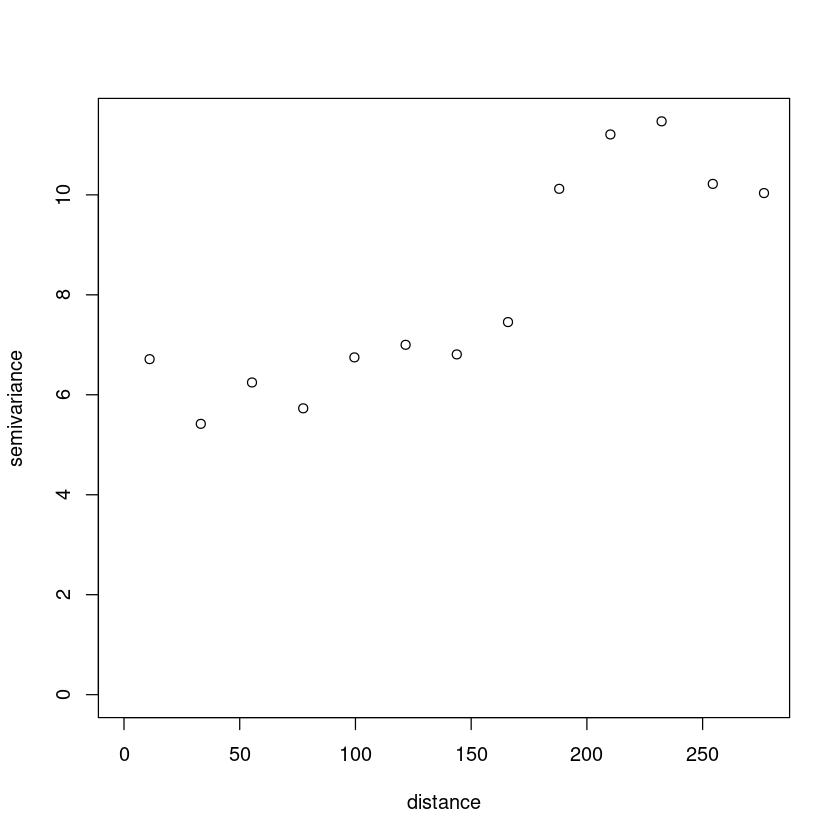

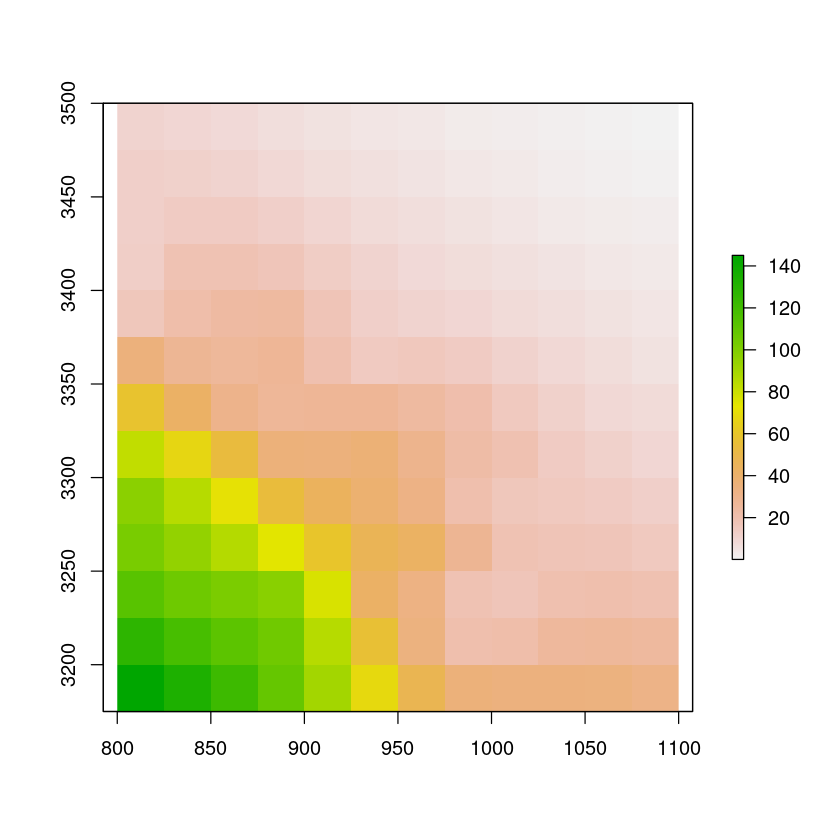

In [145]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_6 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_6))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_6 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "spherical", 
                     ini.cov.pars = c(6.5, 50), 
                     nugget = 3.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_6)

krig_lkft_regr_6 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_6))

krig_regr_6 <- krig_lkft_6$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_6 <- rasterFromXYZ(cbind(grid_df, krig_regr_6))
proj4string(pr_regr_lkft_6) <- proj4string(grid_3sp)
plot(pr_regr_lkft_6)

In [146]:
## Covariance

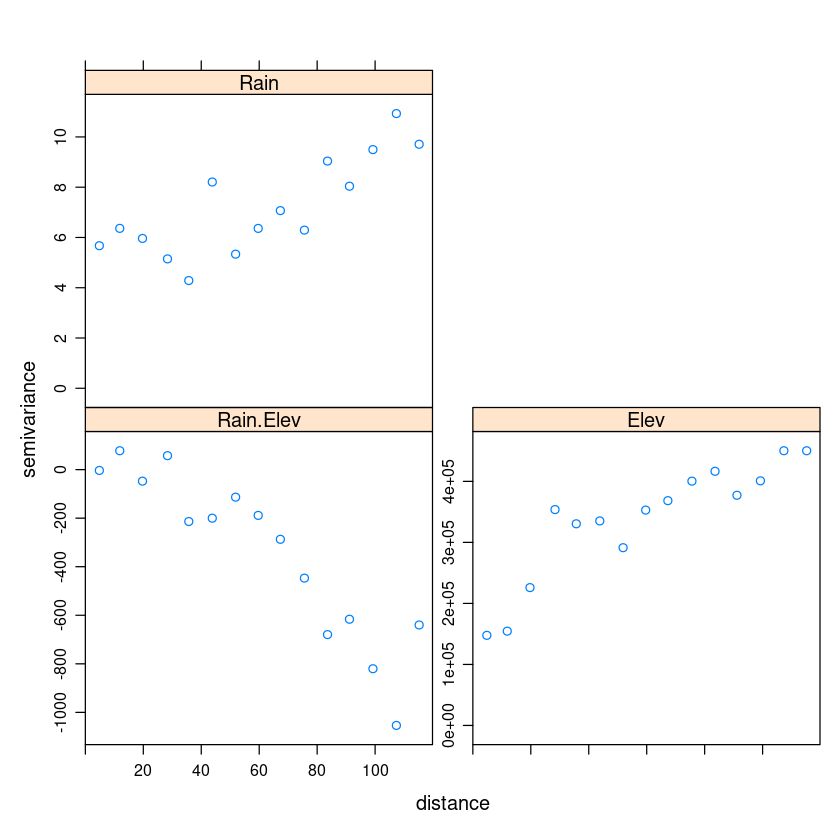

In [147]:
g5 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_6_prjtd)
g5 = gstat(g5, id = "Elev", form = elev~1, data = sd_6_prjtd)
v_cross = variogram(g5)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 90 x 11
Elev : formula = elev`~`1 ; data dim = 90 x 11
variograms:
             model         psill    range
Rain[1]        Nug      5.386576   0.0000
Rain[2]        Exp      4.063373 120.8503
Elev[1]        Nug 131102.075205   0.0000
Elev[2]        Exp 593230.854644 120.8503
Rain.Elev[1]   Nug    108.953063   0.0000
Rain.Elev[2]   Exp  -1125.679817 120.8503

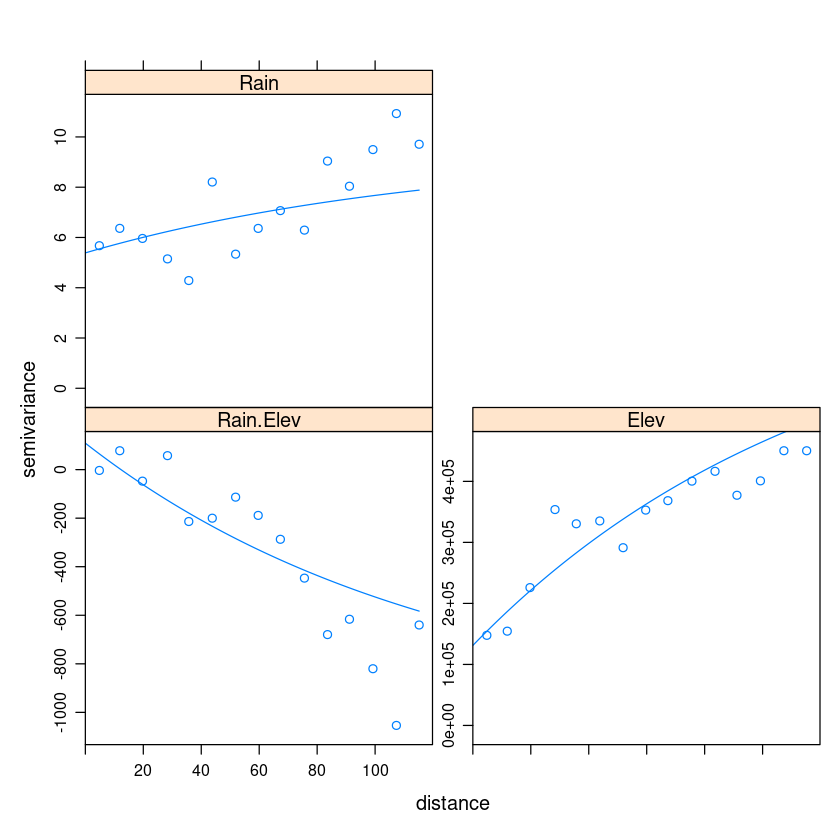

In [148]:
g5 = gstat(g5, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g5 = fit.lmc(v_cross,g5)
g5
plot(variogram(g5), model= g5$model)

DAY 7

In [149]:
f7 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_7_July_23.csv"

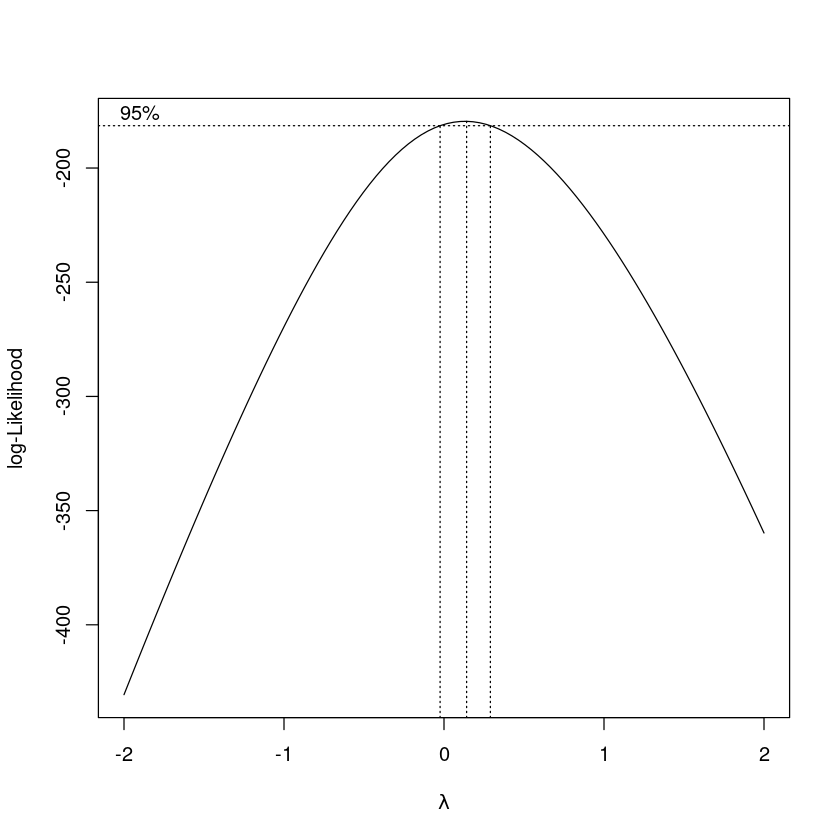

In [150]:
d7 = read.csv(f7)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d7$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d7$Rainfall_Transformed <- rain_transformed

In [151]:
lambda_rn

[1] 0.1414141

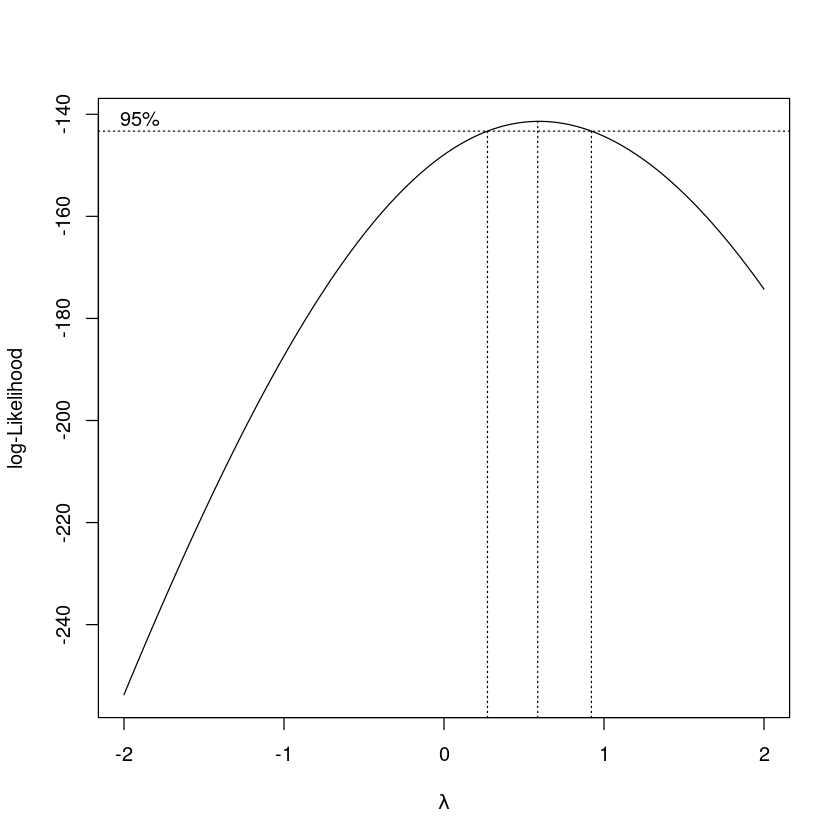

In [152]:
# Perform Box-Cox transformation on rainfall data
  elev <- d7$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d7$Elevation_Transformed <- el_transformed

In [153]:
coordinates1 = data.frame(lon = d7$Longitude, lat = d7$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d7_modb = subset(d7, select = -c(Longitude,Latitude))
sd_7 = SpatialPointsDataFrame(coords1,d7_modb)
class(sd_7)
proj4string(sd_7) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_7_prjtd <- spTransform(sd_7, CRS(desired_crs))
proj4string(sd_7_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

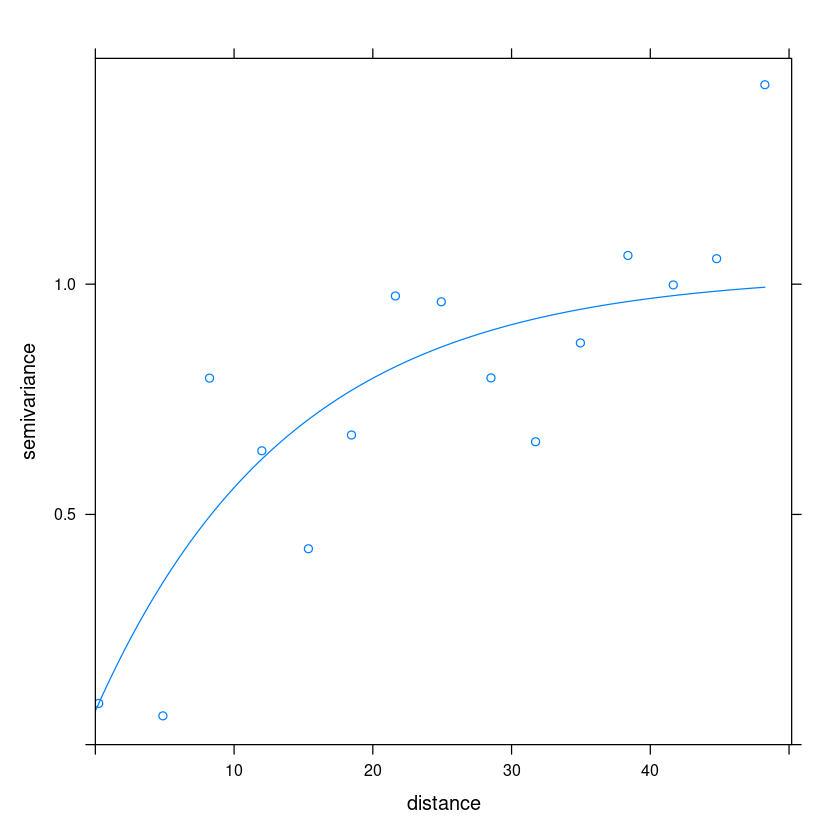

In [154]:
rain_vgm = variogram(rain_transformed ~1, data = sd_7_prjtd, cutoff = 50)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   167376.7   0.0000 0.0   0    0    0    1     1    
2 Exp   742520.8 189.6875 0.5   0    0    0    1     1

[1] -0.2393674

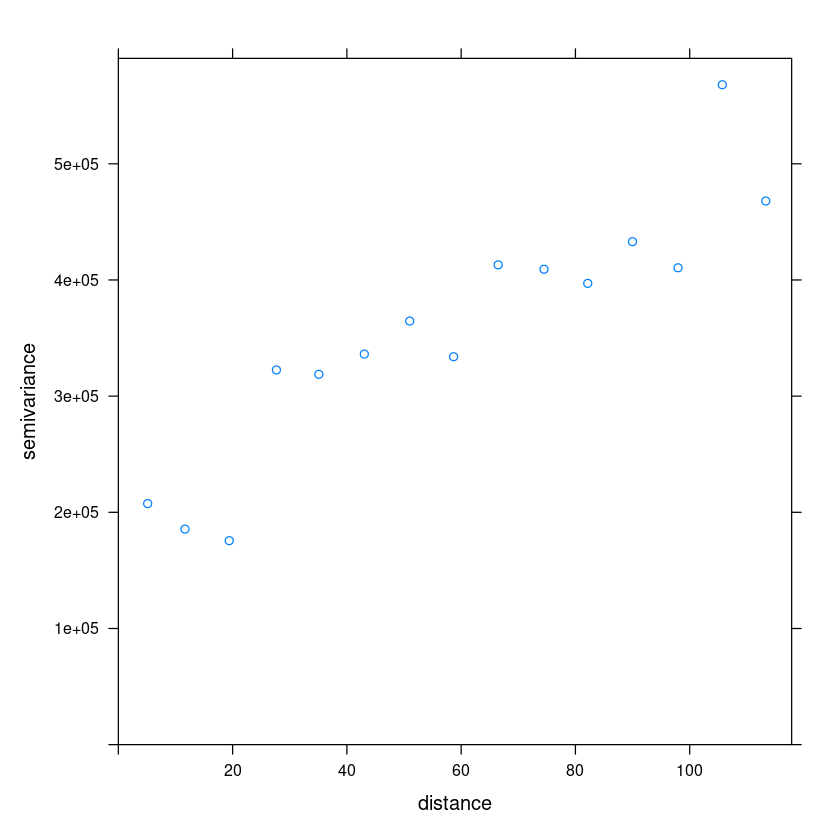

In [155]:
elev = d7$Elevation
elev_vgm = variogram(elev~1, data = sd_7_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [156]:
### Likfit Var

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"58.6252" "-0.0015" "-0.0165" " 0.4607" " 0.9469" "78.4101" 
Practical Range with cor=0.05 for asymptotic range: 78.41005

likfit: maximised log-likelihood = -251

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
58.6252 -0.0015 -0.0165 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  0.9469
      (estimated) cor. fct. parameter phi (range parameter)  =  78.41
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.4607

Transformation parameter:
      (fixed) Box-Cox parameter = 0.1414

Practical Range with cor=0.05 for asymptotic range: 78.41005

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-251"      "6"  "514.1"  "528.3" 

non spatial model:
   log.L n.params      AIC      BIC 
"-258.3"      "4"  "524.6"    "534" 

Call:
likfit(geodata = gdt_7, trend = "1st", ini.cov.pars = c(3, 100), 
    nugg

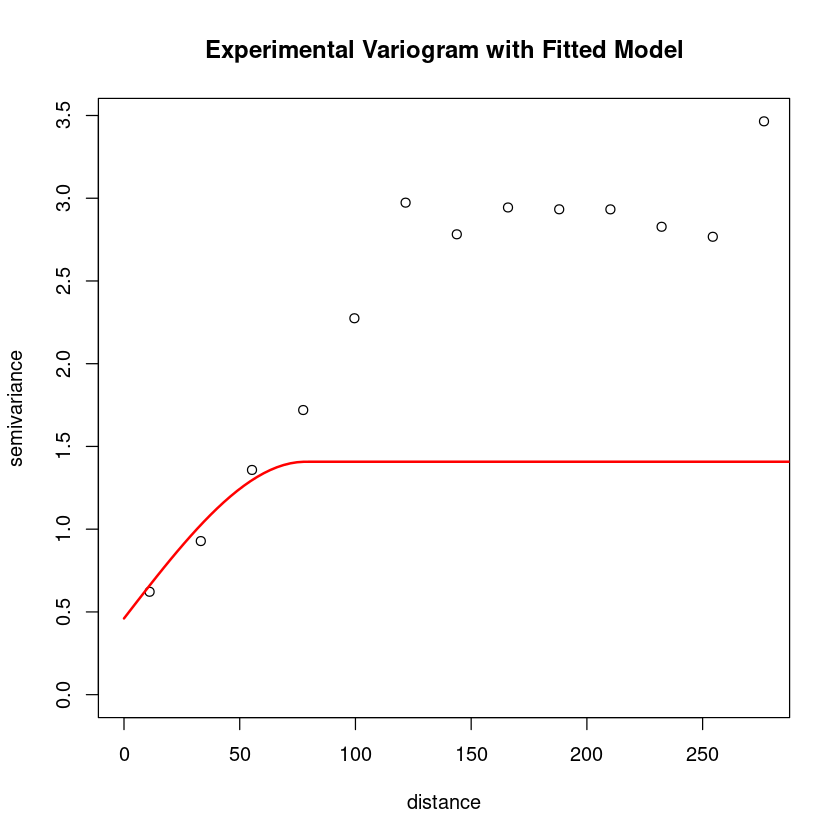

In [157]:
cord = coordinates(sd_7_prjtd)
rn = sd_7_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_7 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_7 = jitterDupCoords(gdt_7, max = jit_am)

vf_7 = variog(gdt_7, lambda = 0.141414141414141, trend = "cte")
vgm_rn_lk_7 = likfit(geodata = gdt_7, trend = "1st",cov.model = "spherical", ini.cov.pars = c(3,100),nugget = 0.5, lambda = 0.141414141414141, lik.method = "ML", messages = FALSE)
vgm_rn_lk_7
summary(vgm_rn_lk_7)
# Plot the experimental variogram
plot(vf_7, main = "Experimental Variogram with Fitted Model")

# Add the fitted model
lines(vgm_rn_lk_7, col = "red", lwd = 2)

In [158]:
## Simple krig

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


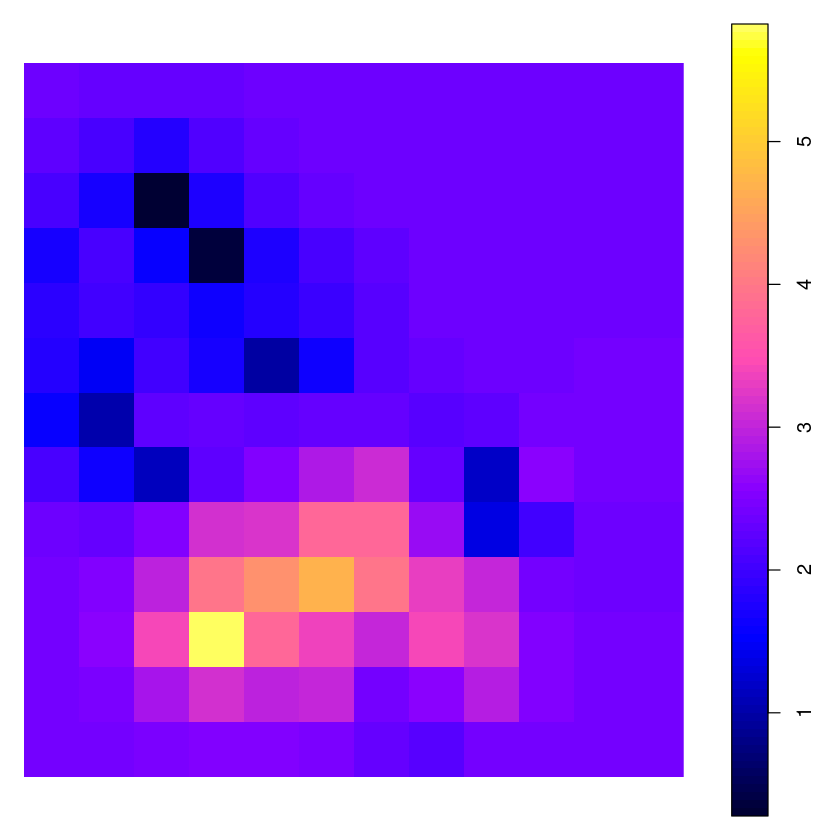

In [159]:
# Extract coordinates
coords <- coordinates(sd_7_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_7_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_7_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_7_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_7_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_7_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_7_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_7 <- krige(rain_transformed ~ 1, sd_7_prjtd_jittered, grid_3sp, fit_rain_vgm)
plot(resllt_7)


In [160]:
## Likfit krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


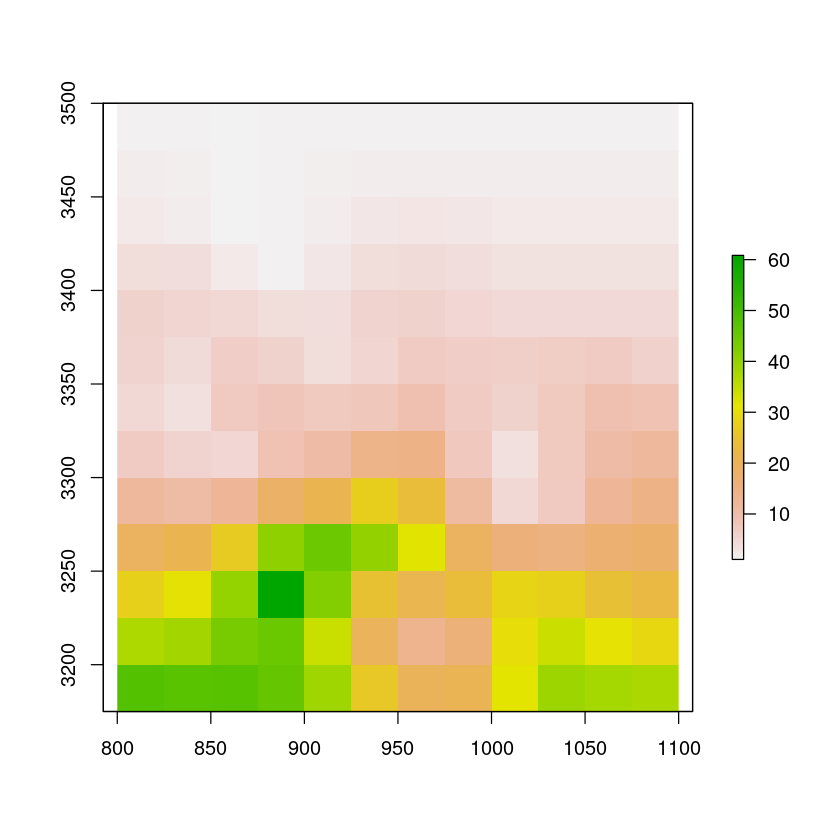

In [161]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_7 <- krige.conv(gdt_7, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_7))



krig_rain_lkft_7 <- krig_lkft_7$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_7 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_7))
proj4string(pr_rain_lkft_7) <- proj4string(grid_3sp)
plot(pr_rain_lkft_7)

In [162]:
## Regression

Generalized Linear Model 

79 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 72, 71, 71, 71, 70, 71, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.422748  0.2152477  1.120709

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
35.1674  0.0004 -0.0107 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  1.019
      (estimated) cor. fct. parameter phi (range parameter)  =  82.72
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.4918

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 82.72167

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-114.5"      "6"  "240.9"  "255.1" 

non spatial model:
   log.L n.params      AIC      BIC 
"-124.1"      "4"  "256.1"  "265.6" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars 

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


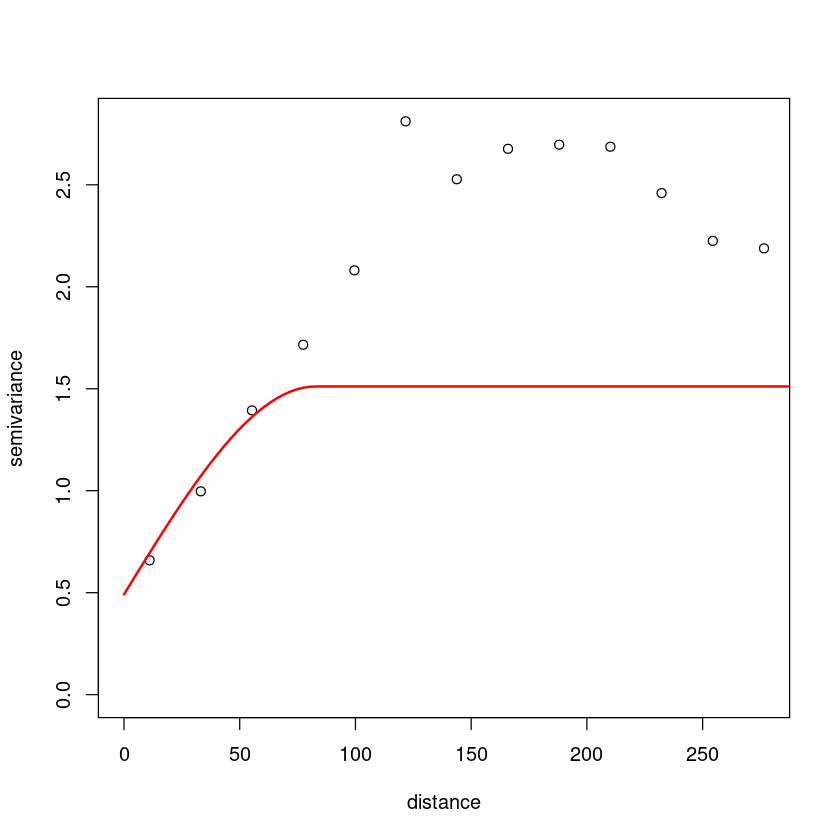

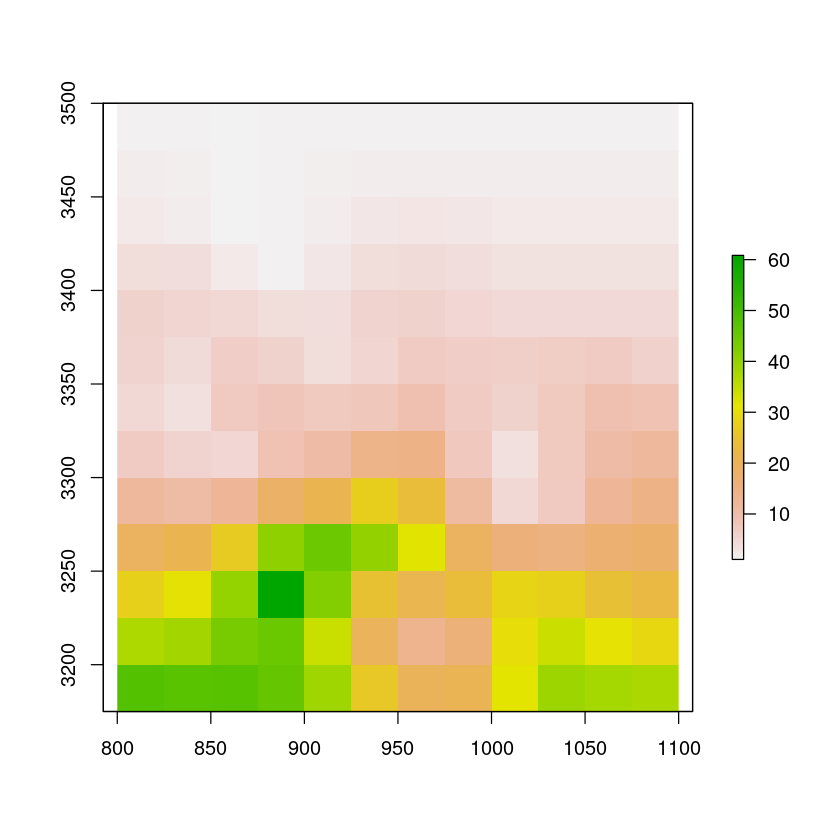

In [163]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_7 = resid(GLM)
# Filter the coordinates to match the rows used in the GLM mode
cord_filtered <- cord[1:nrow(train.x), ]
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord_filtered, residuals = resd_glm_7))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "cte")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_7 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "spherical", 
                     ini.cov.pars = c(3, 100), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_7)
lines(vgm_res_lk_7 , col = "red", lwd = 2)

krig_lkft_regr_7 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_7))

krig_regr_7 <- krig_lkft_7$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_7 <- rasterFromXYZ(cbind(grid_df, krig_regr_7))
proj4string(pr_regr_lkft_7) <- proj4string(grid_3sp)
plot(pr_regr_lkft_7)

In [164]:
### Cov

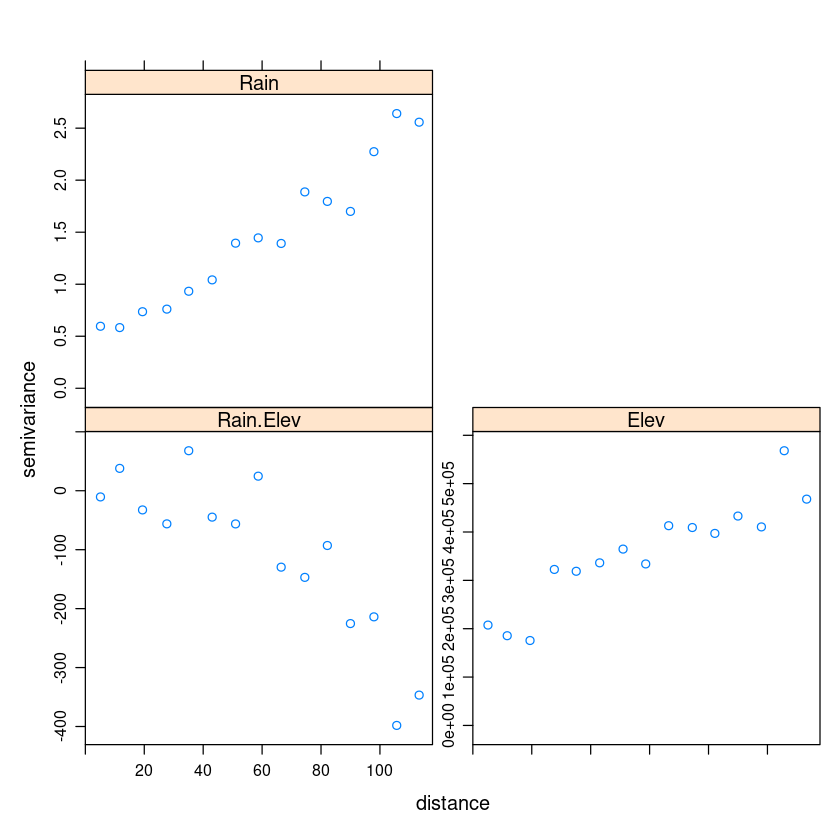

In [165]:
g6 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_7_prjtd)
g6 = gstat(g6, id = "Elev", form = elev~1, data = sd_7_prjtd)
v_cross = variogram(g6)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 79 x 11
Elev : formula = elev`~`1 ; data dim = 79 x 11
variograms:
             model         psill    range
Rain[1]        Nug  1.015942e-01  0.00000
Rain[2]        Exp  1.179454e+00 14.00707
Elev[1]        Nug  9.923120e+04  0.00000
Elev[2]        Exp  2.424160e+05 14.00707
Rain.Elev[1]   Nug  4.646895e+01  0.00000
Rain.Elev[2]   Exp -1.099145e+02 14.00707

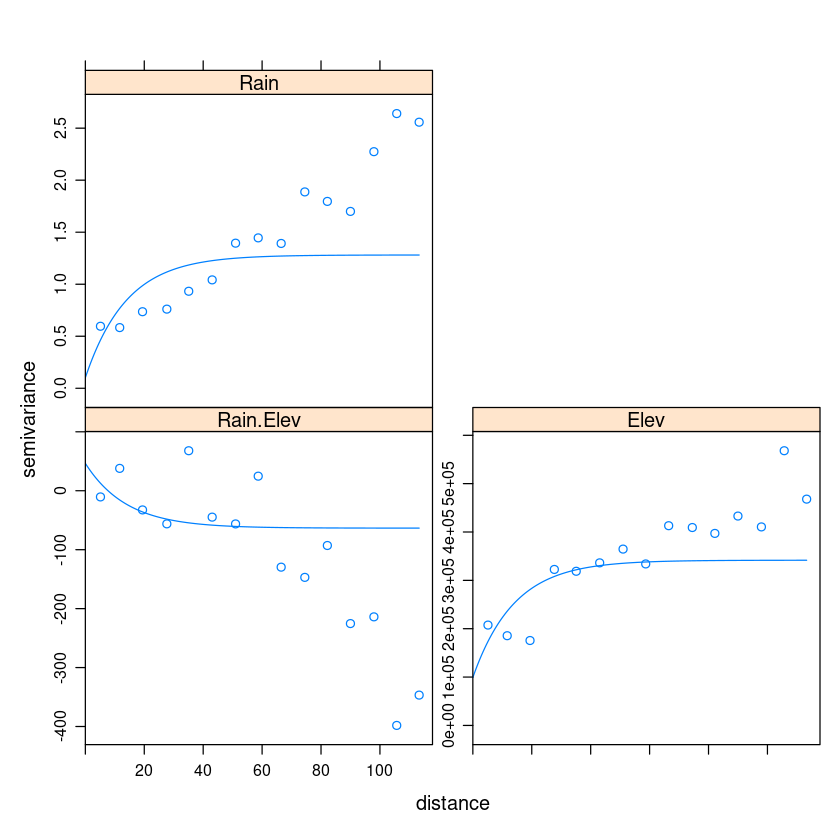

In [166]:
g6 = gstat(g6, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g6 = fit.lmc(v_cross,g6)
g6
plot(variogram(g6), model= g6$model)

DAY 8

In [167]:
f8 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_8_July_23.csv"

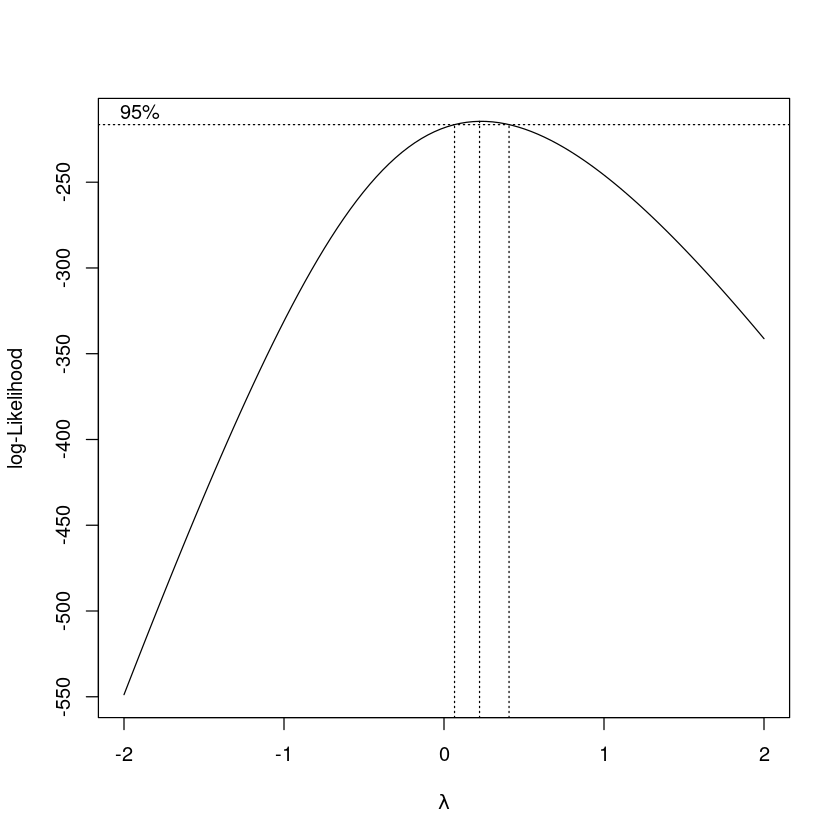

In [168]:
d8 = read.csv(f8)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d8$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d8$Rainfall_Transformed <- rain_transformed

In [169]:
lambda_rn

[1] 0.2222222

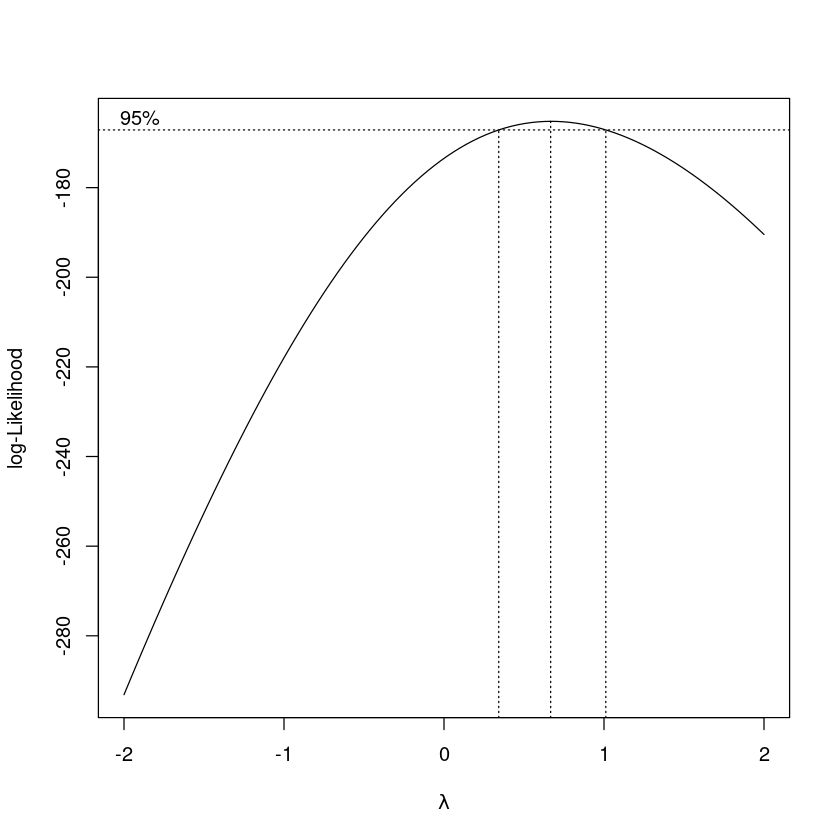

In [170]:
# Perform Box-Cox transformation on rainfall data
  elev <- d8$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d8$Elevation_Transformed <- el_transformed

In [171]:
coordinates1 = data.frame(lon = d8$Longitude, lat = d8$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d8_modb = subset(d8, select = -c(Longitude,Latitude))
sd_8 = SpatialPointsDataFrame(coords1,d8_modb)
class(sd_8)
proj4string(sd_8) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_8_prjtd <- spTransform(sd_8, CRS(desired_crs))
proj4string(sd_8_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(rain_vgm, fit):
“No convergence after 200 iterations: try different initial values?”


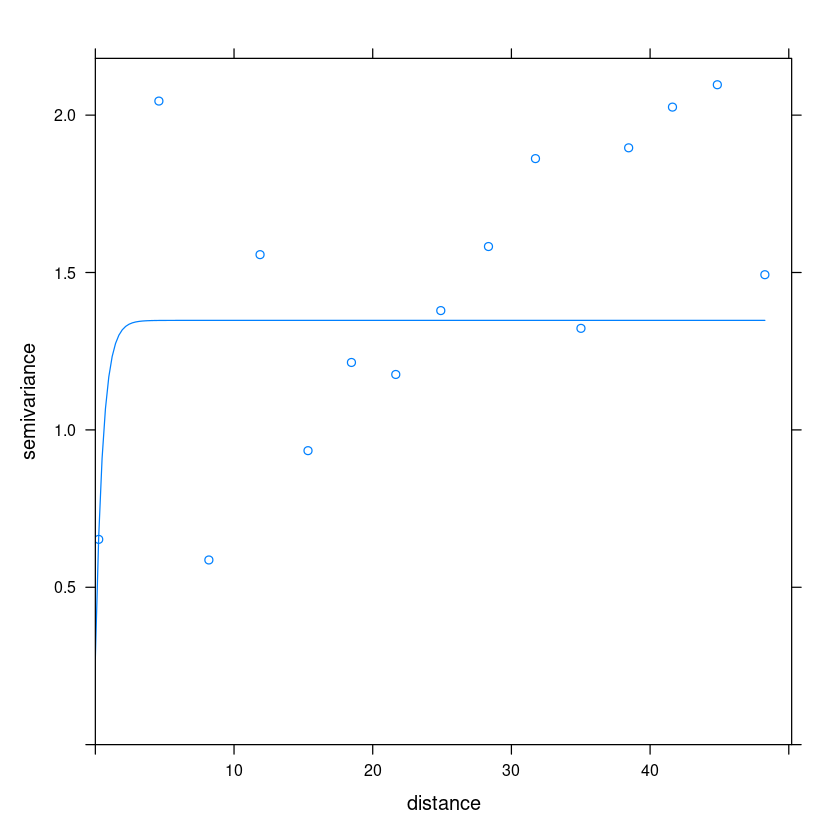

In [172]:
rain_vgm = variogram(rain_transformed ~1, data = sd_8_prjtd, cutoff = 50)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   104543.9  0.00000 0.0   0    0    0    1     1    
2 Exp   346730.0 43.58012 0.5   0    0    0    1     1

[1] -0.2027232

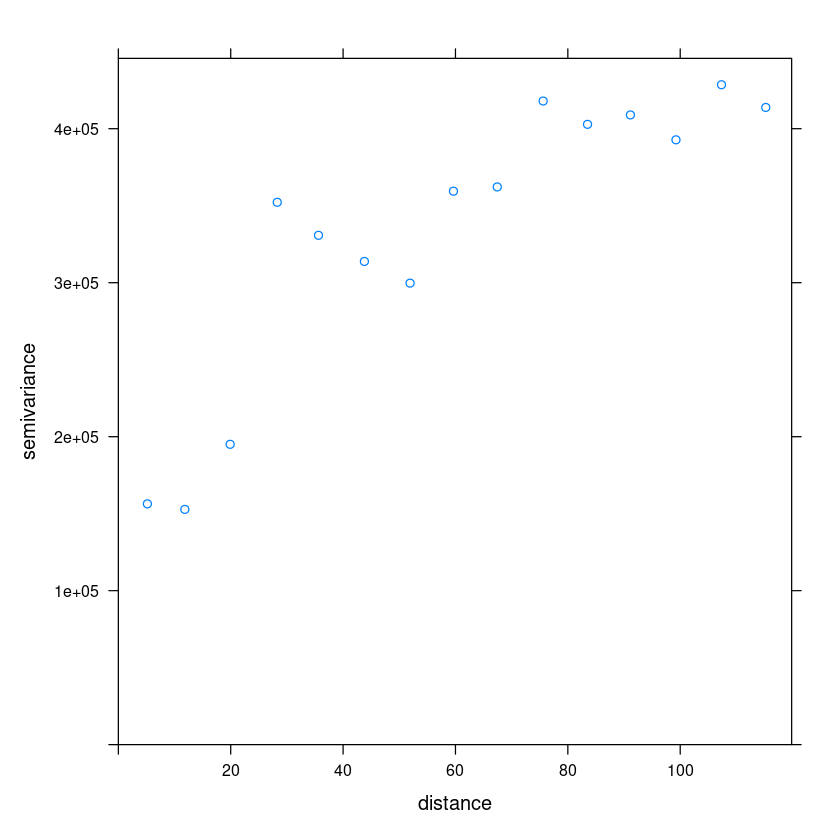

In [173]:
elev = d8$Elevation
elev_vgm = variogram(elev~1, data = sd_8_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [174]:
## Likfit Var

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"105.8792" " -0.0030" " -0.0300" "  0.7330" "  0.6447" " 44.8097" 
Practical Range with cor=0.05 for asymptotic range: 44.8097

likfit: maximised log-likelihood = -315.8

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
105.8792  -0.0030  -0.0300 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  0.6447
      (estimated) cor. fct. parameter phi (range parameter)  =  44.81
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.733

Transformation parameter:
      (fixed) Box-Cox parameter = 0.2222

Practical Range with cor=0.05 for asymptotic range: 44.8097

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-315.8"      "6"  "643.5"  "658.6" 

non spatial model:
   log.L n.params      AIC      BIC 
"-319.8"      "4"  "647.6"  "657.6" 

Call:
likfit(geodata = gdt_8, trend = "1st", ini.cov.pars = c(8, 100), 
    

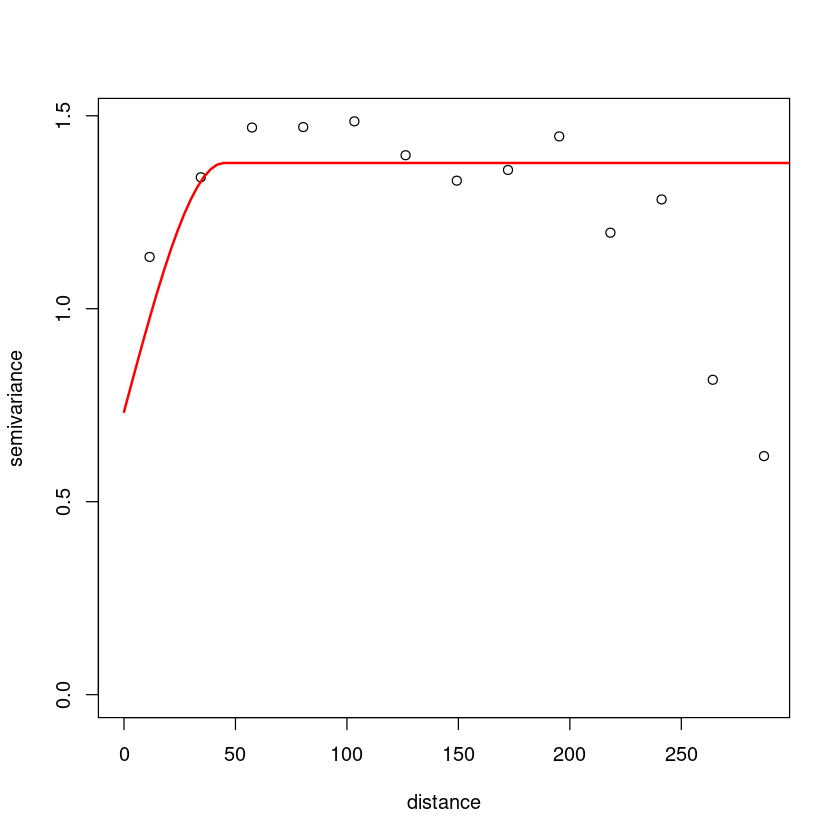

In [175]:
cord = coordinates(sd_8_prjtd)
rn = sd_8_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_8 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_8 = jitterDupCoords(gdt_8, max = jit_am)

vf_8 = variog(gdt_8, lambda = 0.222222222222222, trend = "1st")
plot(vf_8)
vgm_rn_lk_8 = likfit(geodata = gdt_8, trend = "1st",cov.model = "spherical", ini.cov.pars = c(8,100),nugget = 0.2, lambda = 0.222222222222222, lik.method = "ML", messages = FALSE)
vgm_rn_lk_8
summary(vgm_rn_lk_8)
# Add the fitted model
lines(vgm_rn_lk_8, col = "red", lwd = 2)


In [176]:
## Simple Krig

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
[using ordinary kriging]


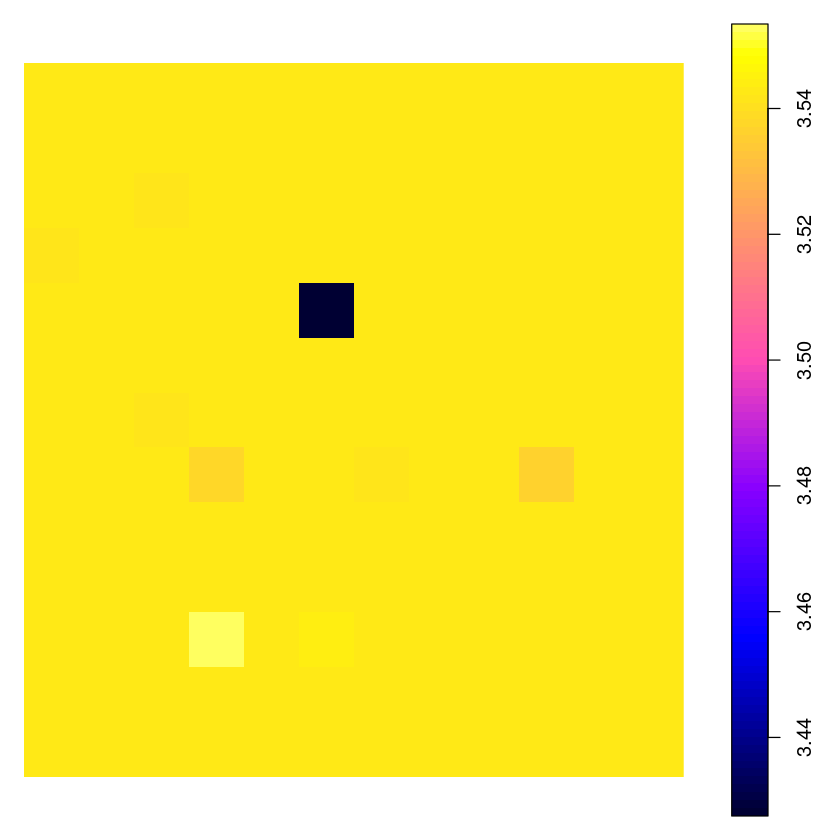

In [177]:
# Extract coordinates
coords <- coordinates(sd_8_prjtd)

# Jitter the coordinates
coords_jittered <- jitterDupCoords(coords, max = 1e-6)

# Extract the data from the original SpatialPointsDataFrame
data_original <- as.data.frame(sd_8_prjtd)

# Create a new SpatialPointsDataFrame with the jittered coordinates
sd_8_prjtd_jittered <- SpatialPointsDataFrame(coords_jittered, data = data_original, proj4string = CRS(proj4string(sd_8_prjtd)))

# Check the CRS of the jittered object
print(proj4string(sd_8_prjtd_jittered))

# Ensure grid_3sp has the same CRS
print(proj4string(grid_3sp))

# If the CRS is different, set the CRS of grid_3sp to match sd_1_prjtd_jittered
if (!identical(proj4string(sd_8_prjtd_jittered), proj4string(grid_3sp))) {
  grid_3sp <- spTransform(grid_3sp, CRS(proj4string(sd_8_prjtd_jittered)))
}

# Perform kriging with the jittered coordinates
resllt_8 <- krige(rain_transformed ~ 1, sd_8_prjtd_jittered, grid_3sp, fit_rain_vgm)

plot(resllt_8)

In [178]:
## Llikfit krg

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


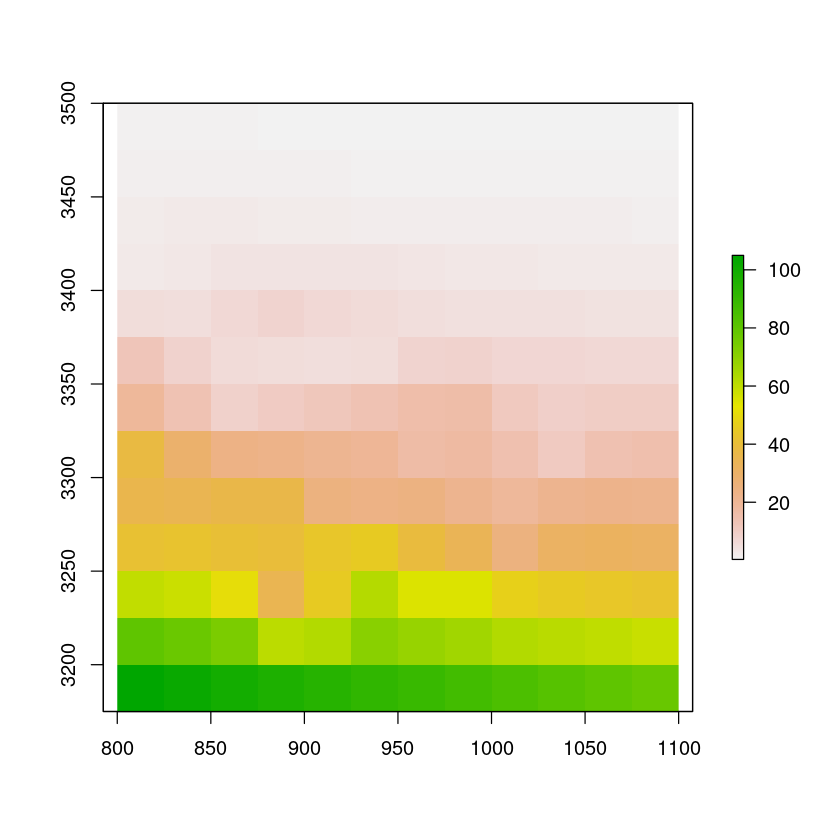

In [179]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 

krig_lkft_8 <- krige.conv(gdt_8, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_8))

krig_rain_lkft_8 <- krig_lkft_8$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_8 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_8))
proj4string(pr_rain_lkft_8) <- proj4string(grid_3sp)
plot(pr_rain_lkft_8)

In [180]:
## Rgression 

Generalized Linear Model 

91 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 82, 81, 83, 81, 81, 81, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  1.85071  0.1470012  1.533172

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
79.6448 -0.0001 -0.0239 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  0.8992
      (estimated) cor. fct. parameter phi (range parameter)  =  42.42
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.7717

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 42.42022

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-147.4"      "6"  "306.9"  "321.9" 

non spatial model:
   log.L n.params      AIC      BIC 
"-153.3"      "4"  "314.5"  "324.6" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


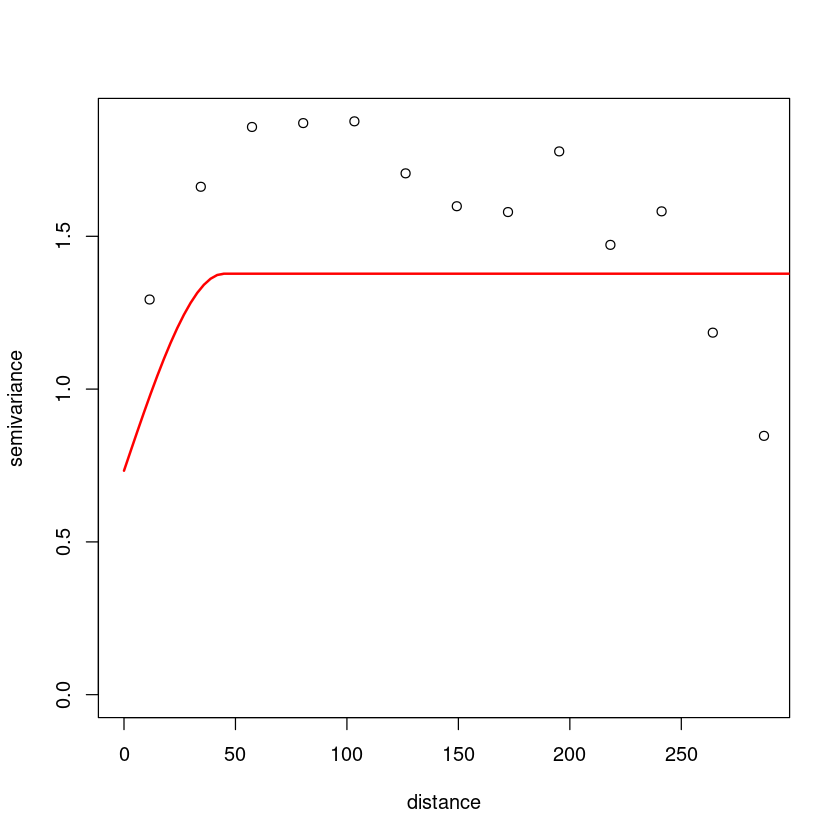

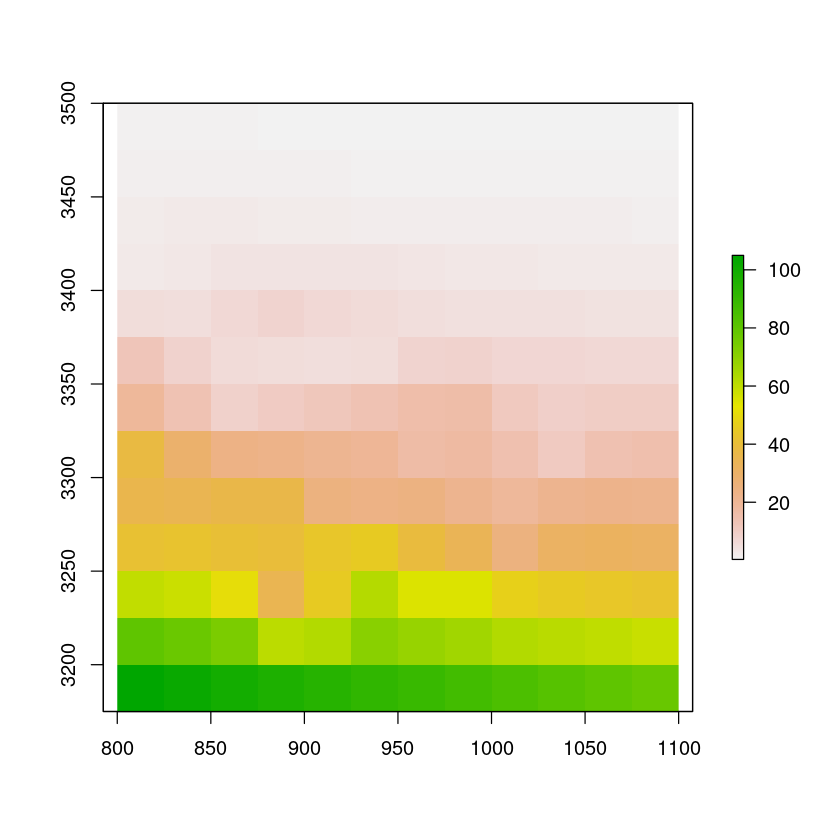

In [181]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)


resd_glm_8 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_8))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_8 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "spherical", 
                     ini.cov.pars = c(6, 150), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_8)
# Add the fitted model
lines(vgm_rn_lk_8, col = "red", lwd = 2)

krig_lkft_regr_8 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_8))

krig_regr_8 <- krig_lkft_8$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_8 <- rasterFromXYZ(cbind(grid_df, krig_regr_8))
proj4string(pr_regr_lkft_8) <- proj4string(grid_3sp)
plot(pr_regr_lkft_8)


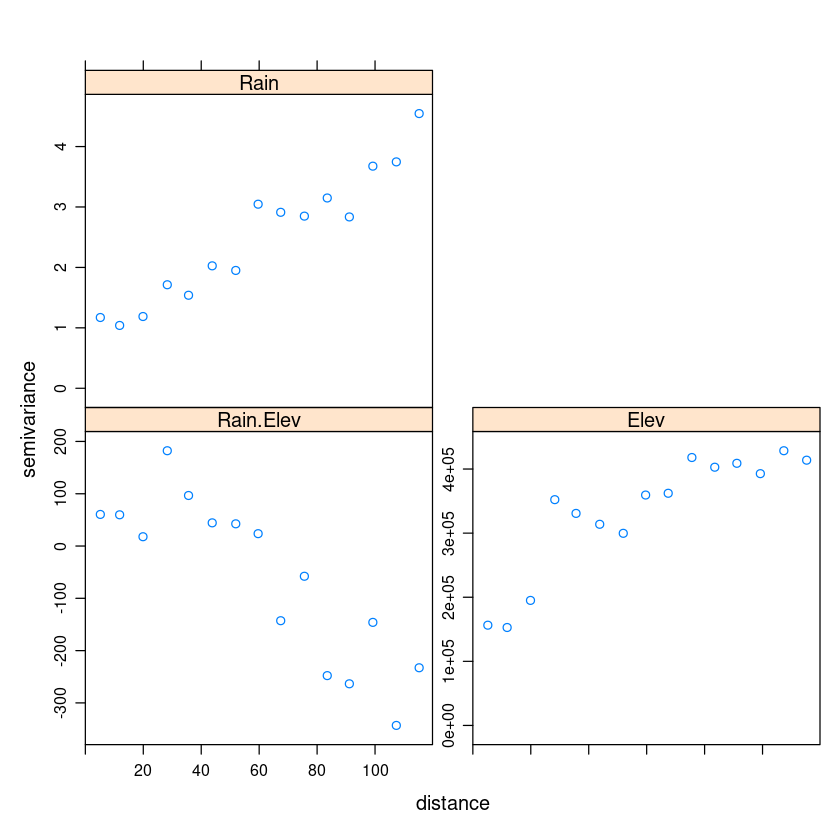

In [182]:
g7 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_8_prjtd)
g7 = gstat(g7, id = "Elev", form = elev~1, data = sd_8_prjtd)
v_cross = variogram(g7)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 91 x 11
Elev : formula = elev`~`1 ; data dim = 91 x 11
variograms:
             model     psill     range
Rain[1]        Nug  226602.8 0.0000000
Rain[2]        Exp  219605.9 0.5423872
Elev[1]        Nug  226602.8 0.0000000
Elev[2]        Exp  363178.8 0.5423872
Rain.Elev[1]   Nug  226602.8 0.0000000
Rain.Elev[2]   Exp -282411.4 0.5423872

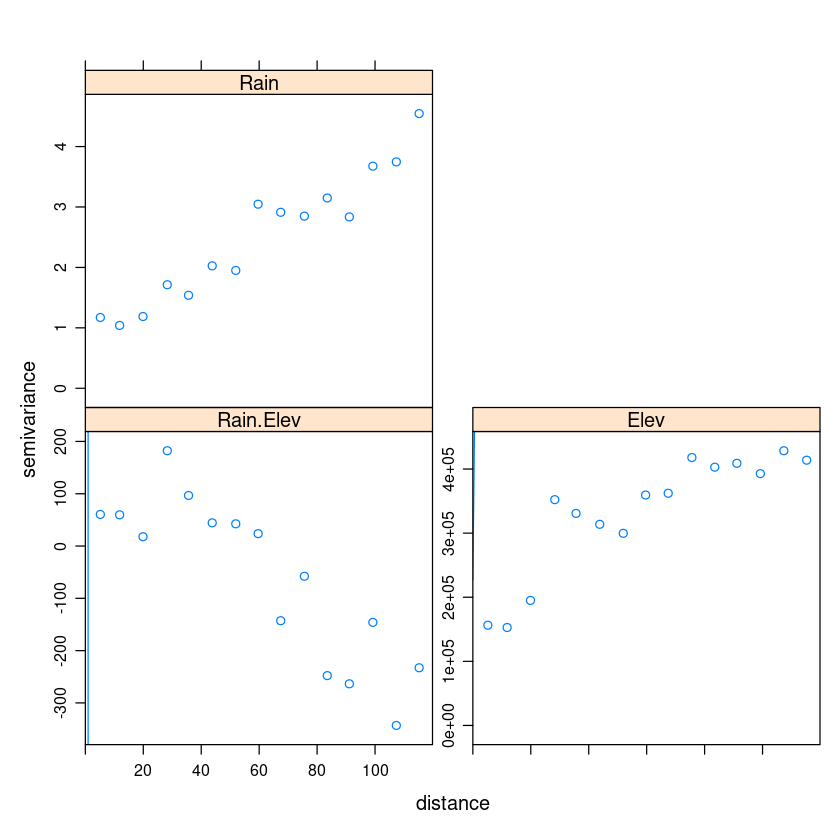

In [183]:
g7 = gstat(g7, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g7 = fit.lmc(v_cross,g7)
g7
plot(variogram(g7), model= g7$model)

DAY 9

In [184]:
f9 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_9_July_23.csv"

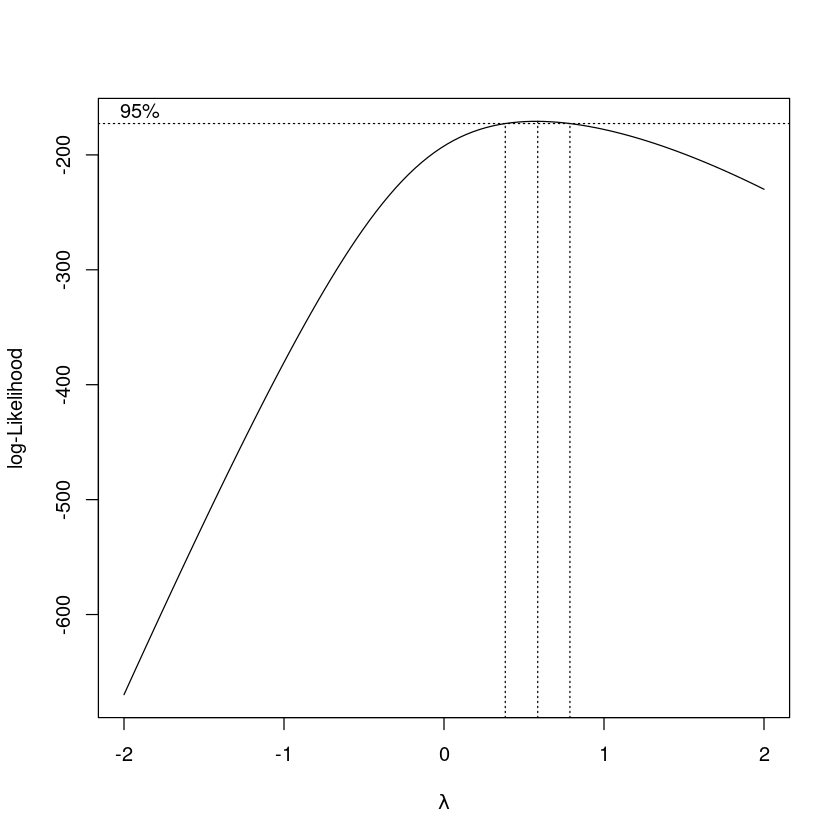

In [185]:
d9 = read.csv(f9)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d9$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d9$Rainfall_Transformed <- rain_transformed

In [186]:
lambda_rn

[1] 0.5858586

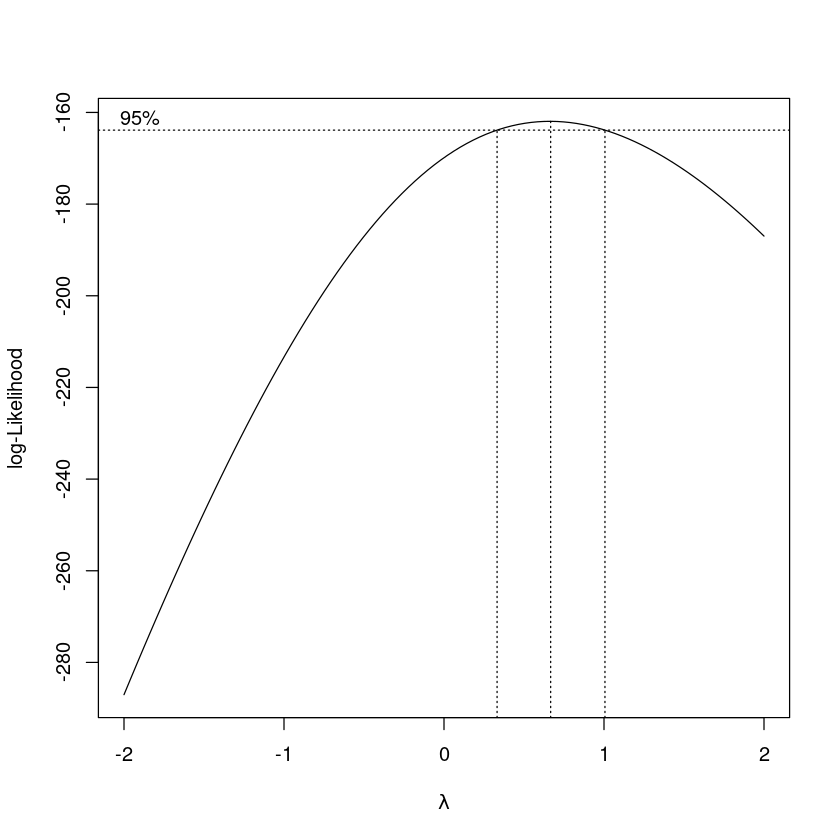

In [187]:
# Perform Box-Cox transformation on rainfall data
  elev <- d9$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d9$Elevation_Transformed <- el_transformed

In [188]:
coordinates1 = data.frame(lon = d9$Longitude, lat = d9$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d9_modb = subset(d9, select = -c(Longitude,Latitude))
sd_9 = SpatialPointsDataFrame(coords1,d9_modb)
class(sd_9)
proj4string(sd_9) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_9_prjtd <- spTransform(sd_9, CRS(desired_crs))
proj4string(sd_9_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(rain_vgm, fit):
“No convergence after 200 iterations: try different initial values?”


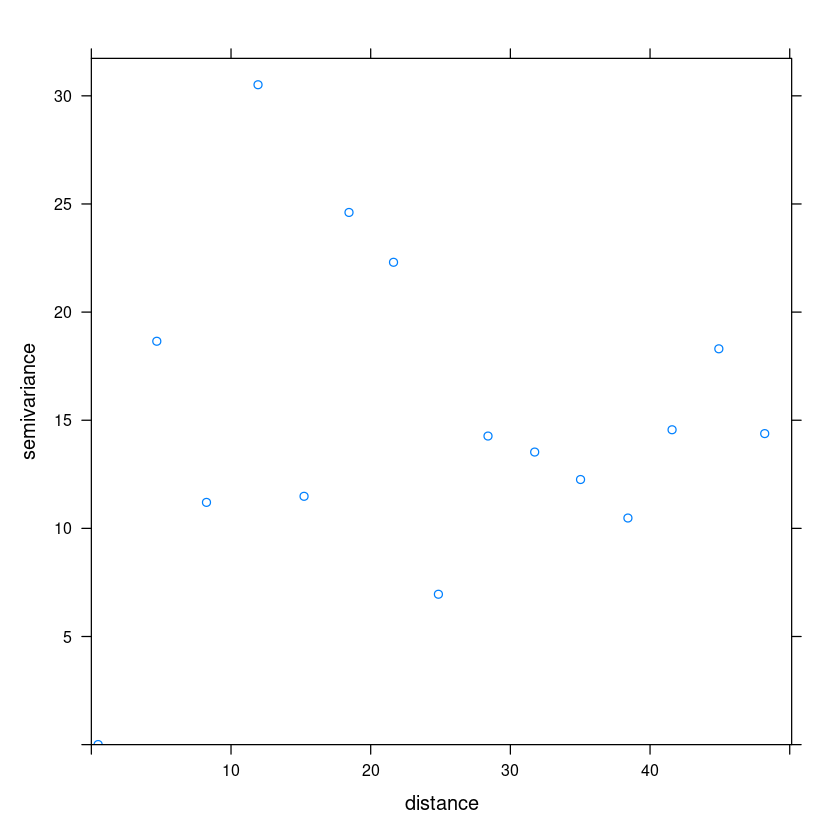

In [189]:
rain_vgm = variogram(rain_transformed ~1, data = sd_9_prjtd, cutoff = 50)
 plot(rain_vgm)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
# plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   135779.4  0.00000 0.0   0    0    0    1     1    
2 Exp   344766.4 52.10846 0.5   0    0    0    1     1

[1] -0.04922229

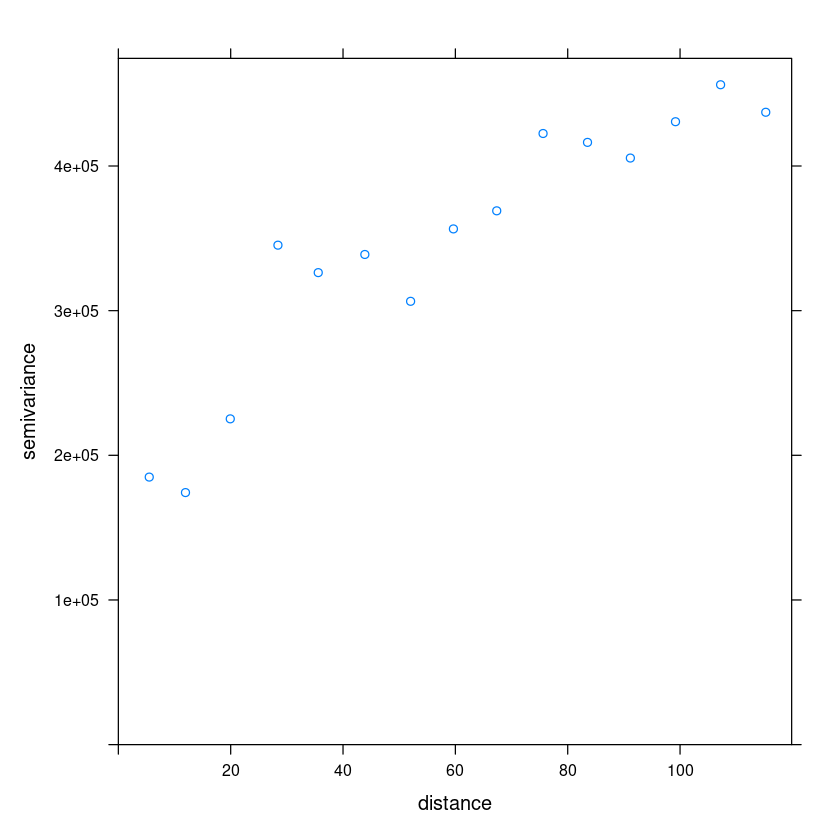

In [190]:
elev = d9$Elevation
elev_vgm = variogram(elev~1, data = sd_9_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [191]:
##likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"144.0989" " -0.0255" " -0.0330" " 16.3848" "  4.4410" " 59.9795" 
Practical Range with cor=0.05 for asymptotic range: 179.6825

likfit: maximised log-likelihood = -378

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
144.0989  -0.0255  -0.0330 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  4.441
      (estimated) cor. fct. parameter phi (range parameter)  =  59.98
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  16.38

Transformation parameter:
      (fixed) Box-Cox parameter = 0.5859

Practical Range with cor=0.05 for asymptotic range: 179.6825

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-378"      "6"    "768"    "783" 

non spatial model:
   log.L n.params      AIC      BIC 
"-379.9"      "4"  "767.7"  "777.7" 

Call:
likfit(geodata = gdt_9, trend = "1st", ini.cov.pars = c(20, 100), 
 

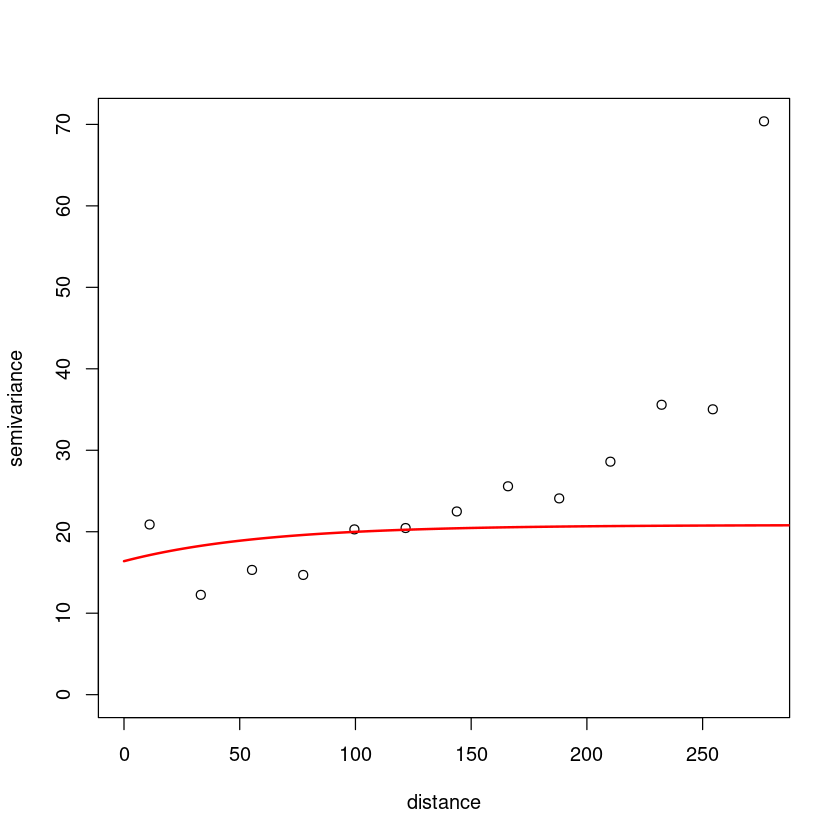

In [192]:
cord = coordinates(sd_9_prjtd)
rn = sd_9_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_9 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_9 = jitterDupCoords(gdt_9, max = jit_am)

vf_9 = variog(gdt_9, lambda = 
0.585858585858586, trend = "1st")
plot(vf_9)

vgm_rn_lk_9 = likfit(geodata = gdt_9, trend = "1st",cov.model = "exponential", ini.cov.pars = c(20,100),nugget = 8, lambda = 0.585858585858586, lik.method = "ML", messages = FALSE)
vgm_rn_lk_9
summary(vgm_rn_lk_9)

# Add the fitted model
lines(vgm_rn_lk_9, col = "red", lwd = 2)

In [193]:
## Likfit Kirg

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


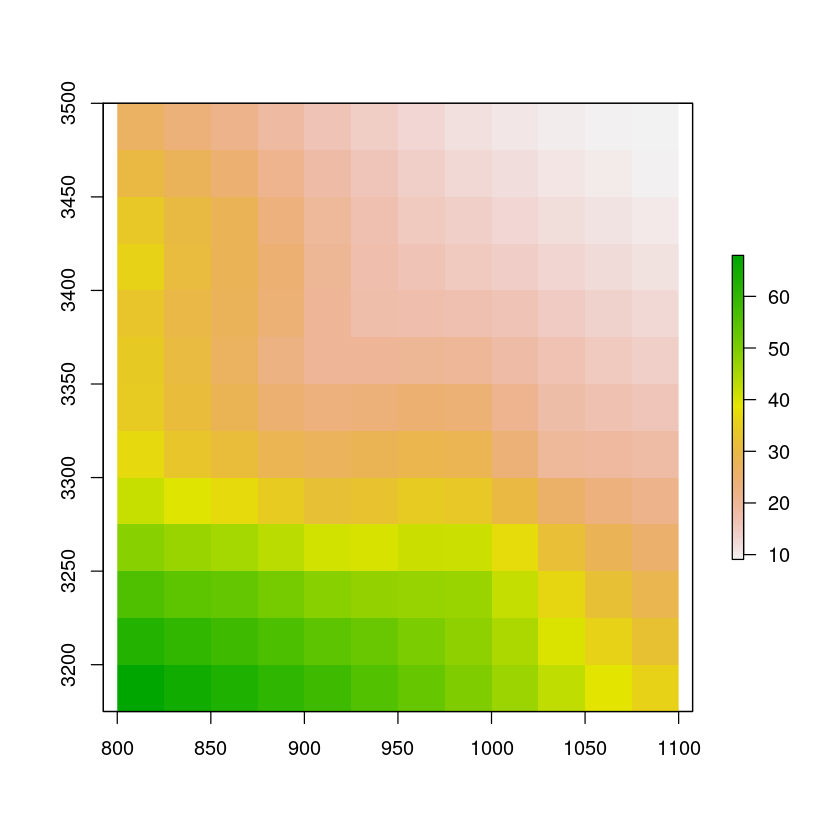

In [194]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_9 <- krige.conv(gdt_9, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_9))



krig_rain_lkft_9 <- krig_lkft_9$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_9 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_9))
proj4string(pr_rain_lkft_9) <- proj4string(grid_3sp)
plot(pr_rain_lkft_9)


In [195]:
## Regression

Generalized Linear Model 

89 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 81, 81, 81, 81, 79, 79, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  4.793745  0.1135893  3.922255

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
106.0338  -0.0251  -0.0250 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  5.091
      (estimated) cor. fct. parameter phi (range parameter)  =  181.7
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  16.9

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 181.7333

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-258.9"      "6"  "529.8"  "544.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-261.5"      "4"  "531.1"    "541" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.p

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


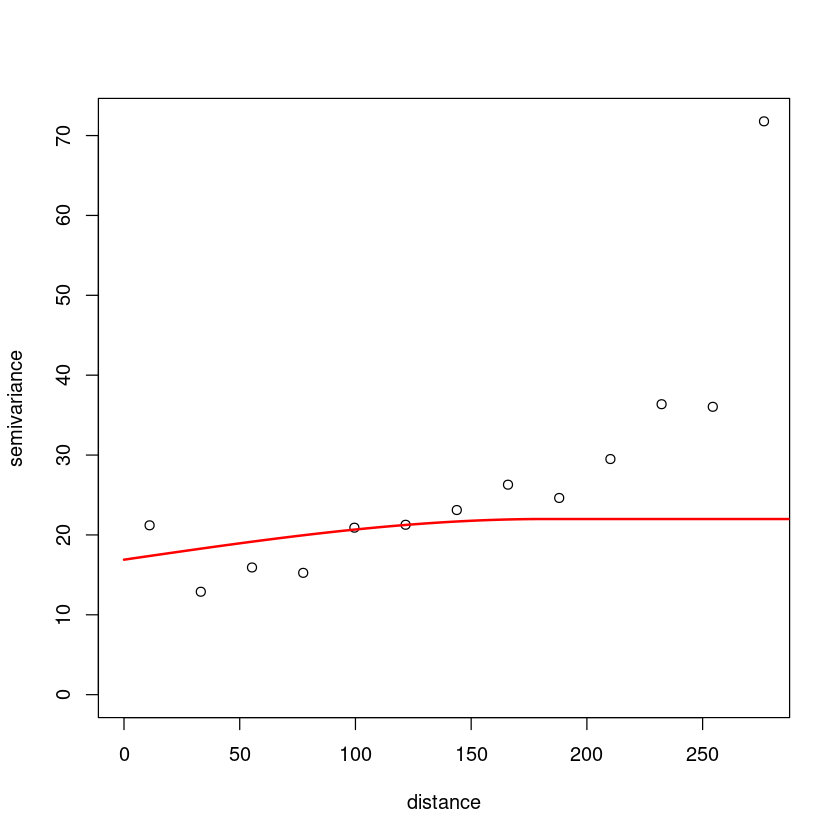

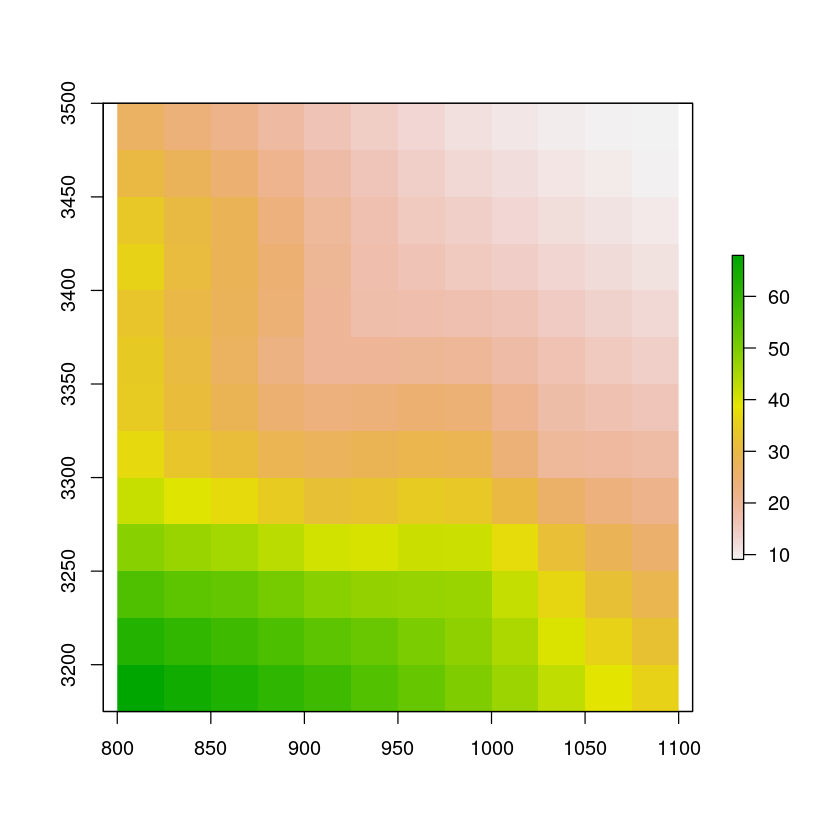

In [196]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_9 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_9))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_9 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "spherical", 
                     ini.cov.pars = c(20, 100), 
                     nugget = 0, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_9)
lines(vgm_res_lk_9, col = "red", lwd = 2)

krig_lkft_regr_9 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_9))

krig_regr_9 <- krig_lkft_9$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_9 <- rasterFromXYZ(cbind(grid_df, krig_regr_9))
proj4string(pr_regr_lkft_9) <- proj4string(grid_3sp)
plot(pr_regr_lkft_9)


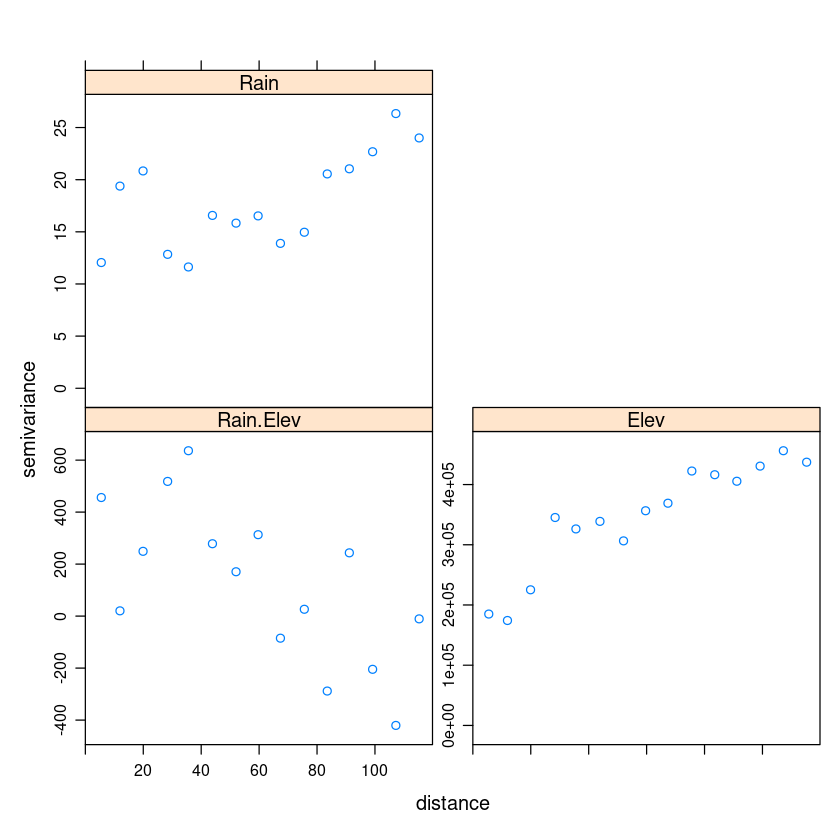

In [197]:
g8 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_9_prjtd)
g8 = gstat(g8, id = "Elev", form = elev~1, data = sd_9_prjtd)
v_cross = variogram(g8)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 89 x 11
Elev : formula = elev`~`1 ; data dim = 89 x 11
variograms:
             model        psill   range
Rain[1]        Nug    488.13632 0.00000
Rain[2]        Exp     17.72288 4.36732
Elev[1]        Nug    488.13632 0.00000
Elev[2]        Exp 284535.33906 4.36732
Rain.Elev[1]   Nug    488.13632 0.00000
Rain.Elev[2]   Exp   -774.71799 4.36732

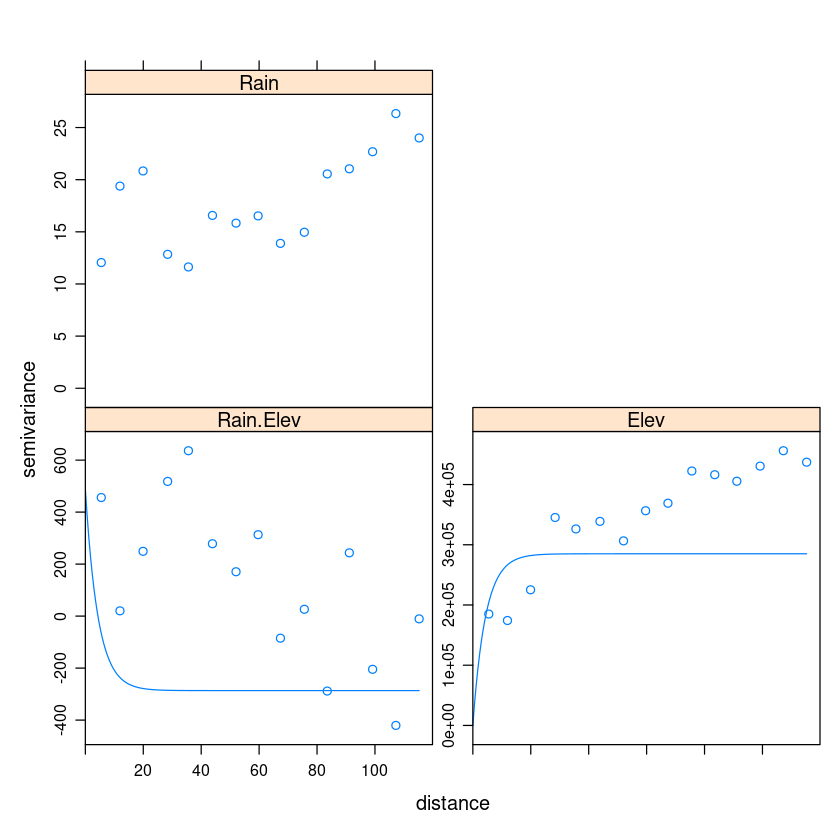

In [198]:
g8 = gstat(g8, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g8 = fit.lmc(v_cross,g8)
g8
plot(variogram(g8), model= g8$model)

DAY 10

In [199]:
f10 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_10_July_23.csv"

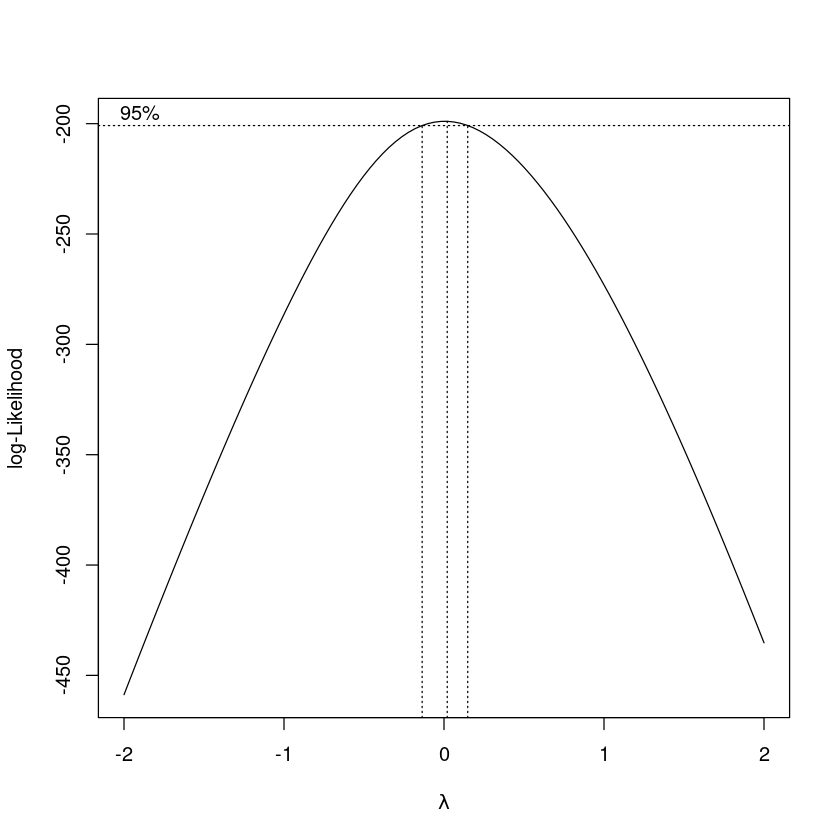

In [200]:
d10 = read.csv(f10)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d10$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d10$Rainfall_Transformed <- rain_transformed

In [201]:
lambda_rn

[1] 0.02020202

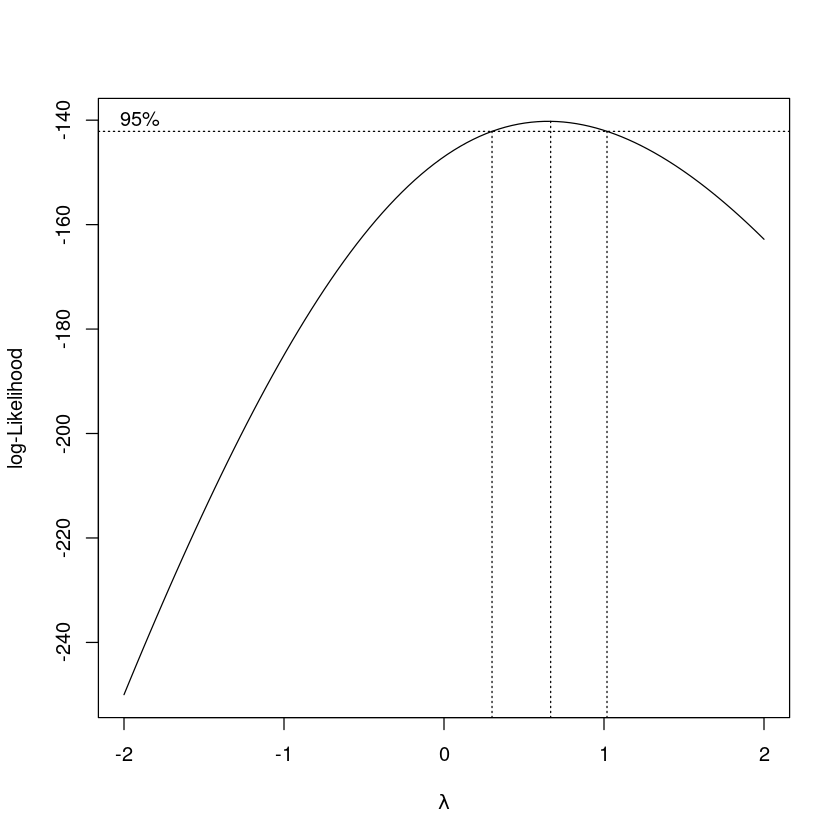

In [202]:
# Perform Box-Cox transformation on rainfall data
  elev <- d10$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d10$Elevation_Transformed <- el_transformed

In [203]:
coordinates1 = data.frame(lon = d10$Longitude, lat = d10$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d10_modb = subset(d10, select = -c(Longitude,Latitude))
sd_10 = SpatialPointsDataFrame(coords1,d10_modb)
class(sd_10)
proj4string(sd_10) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_10_prjtd <- spTransform(sd_10, CRS(desired_crs))
proj4string(sd_10_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(object, model, fit.sills = fit.sills, fit.ranges = fit.ranges, :
“singular model in variogram fit”


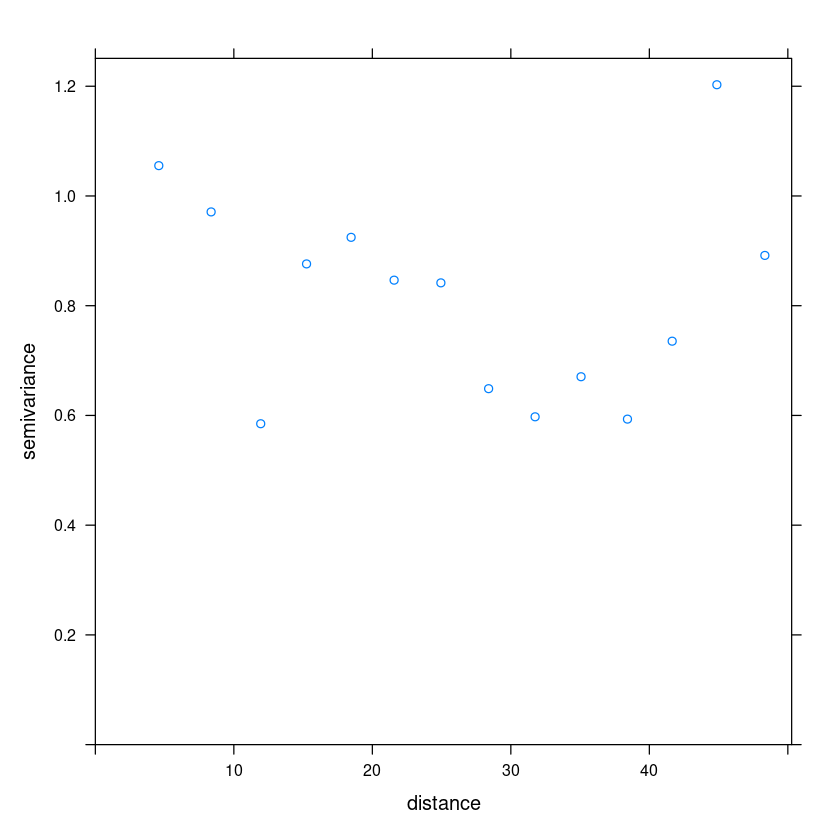

In [204]:
rain_vgm = variogram(rain_transformed ~1, data = sd_10_prjtd, cutoff = 50)
 plot(rain_vgm)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
# plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

model psill     range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug    83055.18  0.00000 0.0   0    0    0    1     1    
2 Exp   382511.71 40.91788 0.5   0    0    0    1     1

[1] 0.03019978

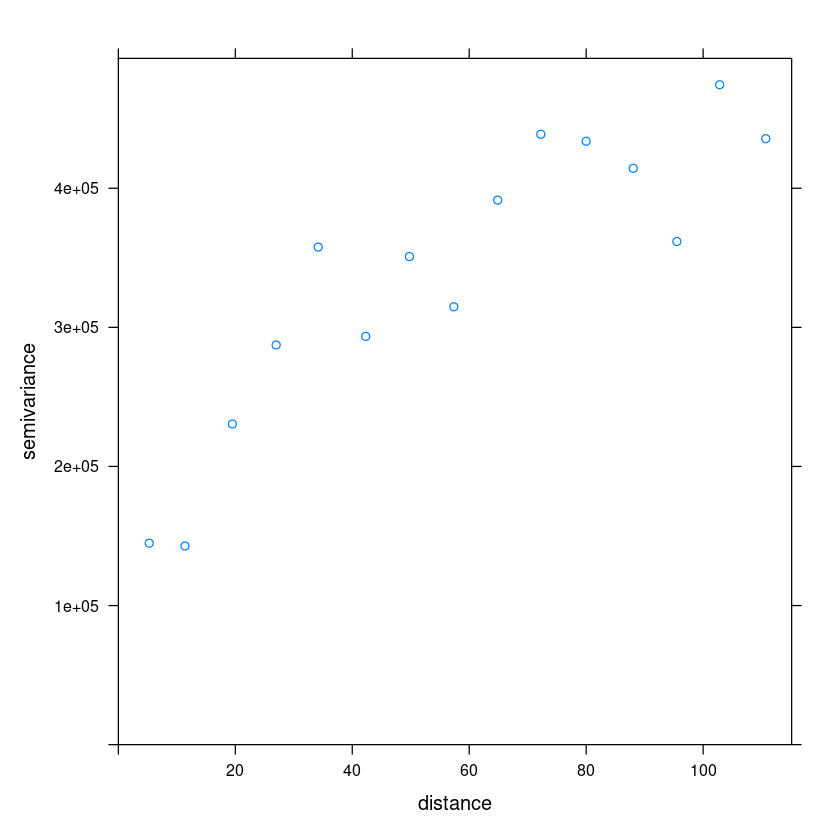

In [205]:
elev = d10$Elevation
elev_vgm = variogram(elev~1, data = sd_10_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [206]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-10.4501" " -0.0099" "  0.0065" "  0.6495" "  0.4195" " 38.7364" 
Practical Range with cor=0.05 for asymptotic range: 116.0439

likfit: maximised log-likelihood = -278.7

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-10.4501  -0.0099   0.0065 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0.4195
      (estimated) cor. fct. parameter phi (range parameter)  =  38.74
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.6495

Transformation parameter:
      (fixed) Box-Cox parameter = 0.0202

Practical Range with cor=0.05 for asymptotic range: 116.0439

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-278.7"      "6"  "569.5"  "583.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-282.7"      "4"  "573.4"  "582.9" 

Call:
likfit(geodata = gdt_10, trend = "1st", ini.cov.pars = c(1.5, 
   

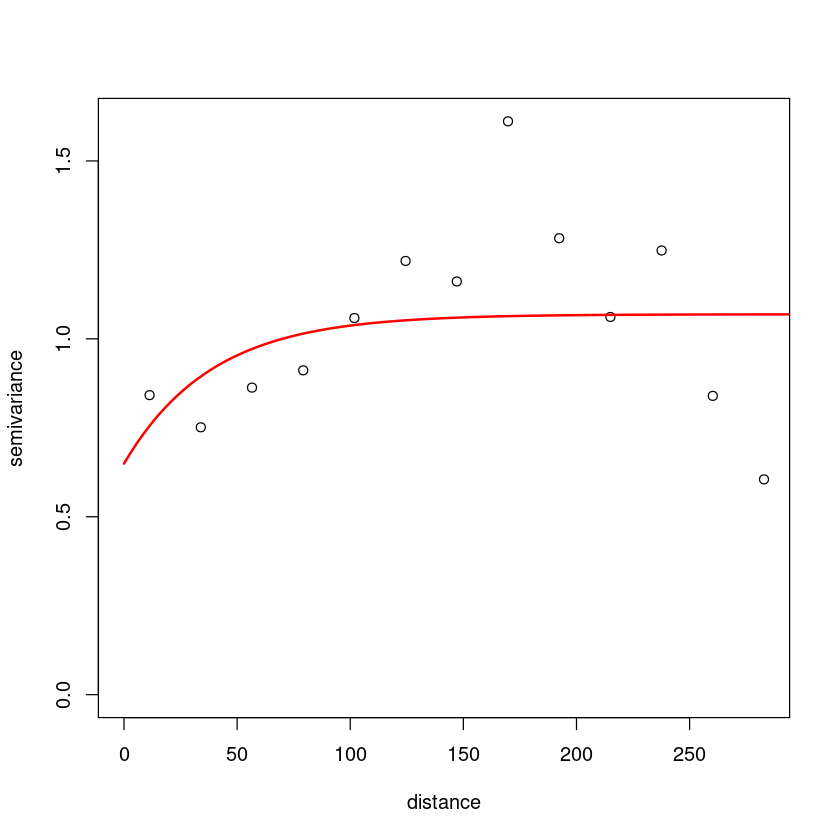

In [207]:
cord = coordinates(sd_10_prjtd)
rn = sd_10_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_10 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_10 = jitterDupCoords(gdt_10, max = jit_am)

vf_10 = variog(gdt_10, lambda = 0.0202020202020203, trend = "1st")
plot(vf_10)

vgm_rn_lk_10 = likfit(geodata = gdt_10, trend = "1st",cov.model = "exponential", ini.cov.pars = c(1.5,80),nugget = 0.8, lambda = 0.0202020202020203, lik.method = "ML", messages = FALSE)
vgm_rn_lk_10
summary(vgm_rn_lk_10)

# Add the fitted model
lines(vgm_rn_lk_10, col = "red", lwd = 2)


In [208]:
## Likfit Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


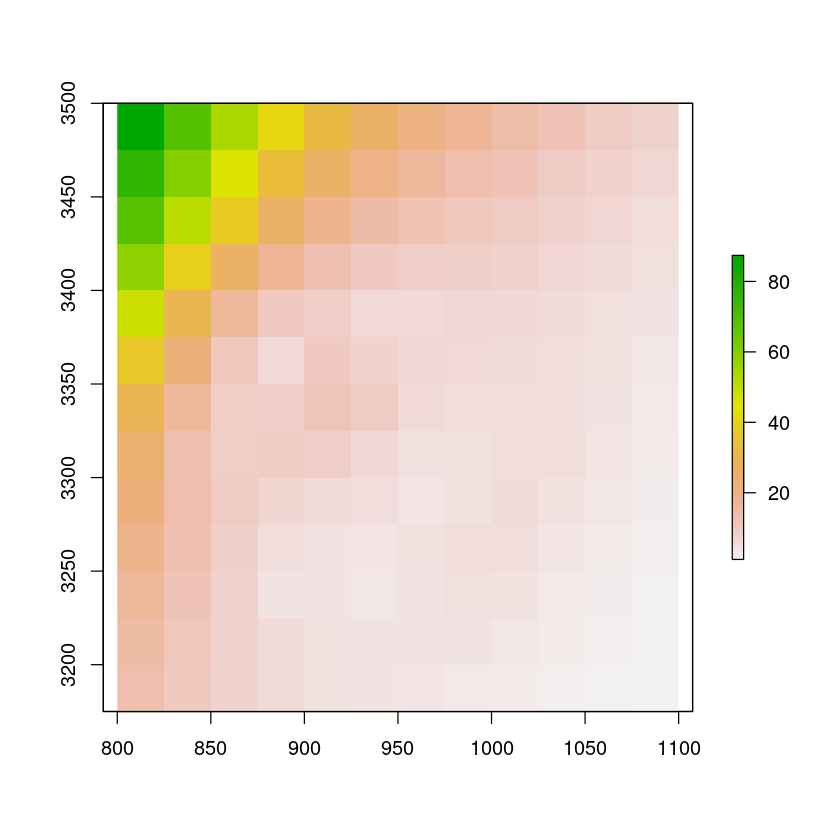

In [209]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_10 <- krige.conv(gdt_10, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_10))



krig_rain_lkft_10 <- krig_lkft_10$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_10 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_10))
proj4string(pr_rain_lkft_10) <- proj4string(grid_3sp)
plot(pr_rain_lkft_10)

In [210]:
## Regression

Generalized Linear Model 

80 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 71, 71, 72, 73, 72, 72, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.426945  0.2323262  1.126659

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-12.0004  -0.0100   0.0063 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0.4225
      (estimated) cor. fct. parameter phi (range parameter)  =  39.48
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.6473

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 118.2823

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-111.1"      "6"  "234.3"  "248.5" 

non spatial model:
   log.L n.params      AIC      BIC 
"-115.1"      "4"  "238.2"  "247.7" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


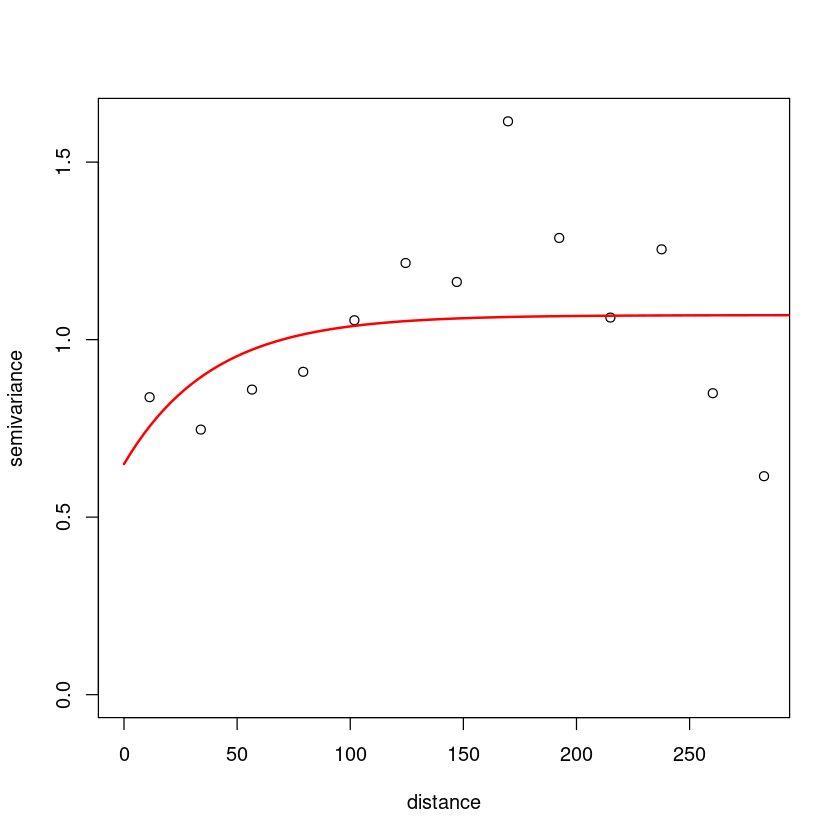

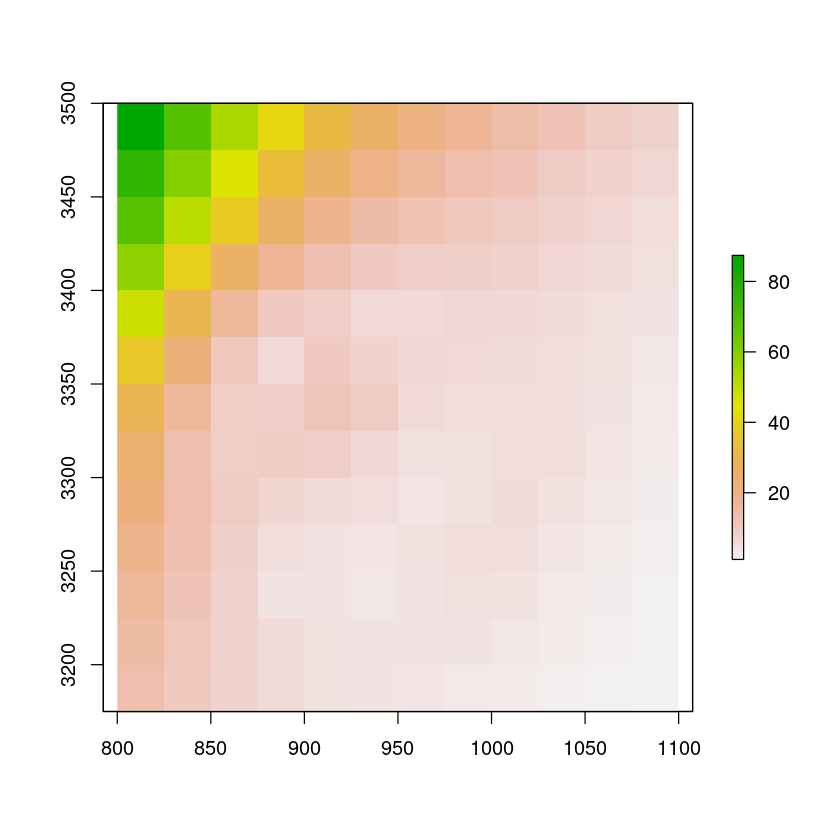

In [211]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_10 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_10))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_10 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(1.5, 80), 
                     nugget = 0.8, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_10)
lines(vgm_rn_lk_10, col = "red", lwd = 2)

krig_lkft_regr_10 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_10))

krig_regr_10 <- krig_lkft_10$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_10 <- rasterFromXYZ(cbind(grid_df, krig_regr_10))
proj4string(pr_regr_lkft_10) <- proj4string(grid_3sp)
plot(pr_regr_lkft_10)


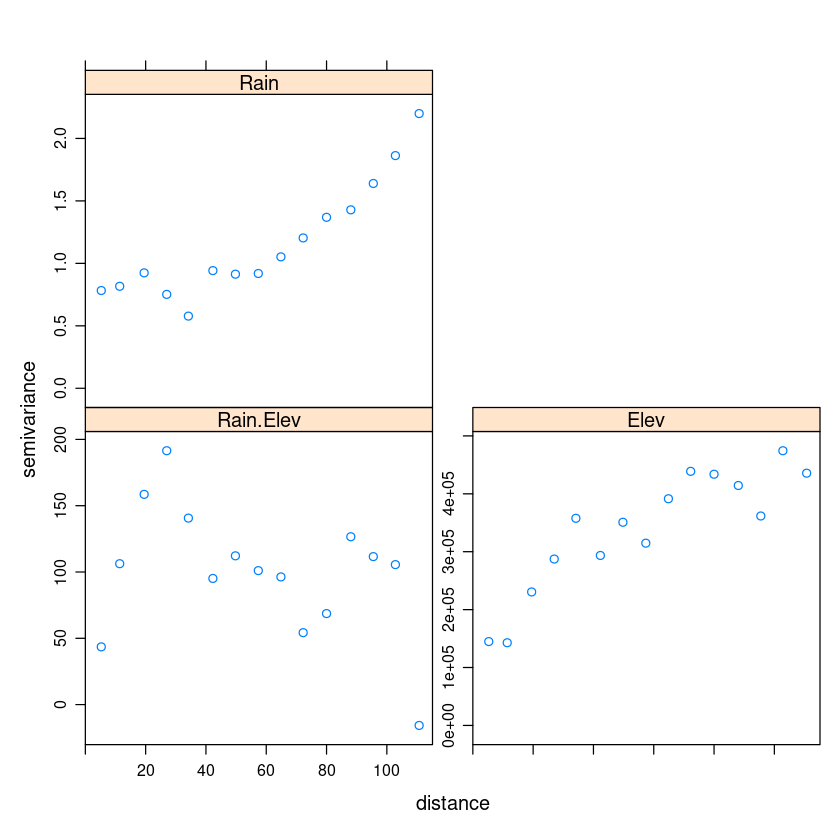

In [212]:
g9 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_10_prjtd)
g9 = gstat(g9, id = "Elev", form = elev~1, data = sd_10_prjtd)
v_cross = variogram(g9)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 80 x 11
Elev : formula = elev`~`1 ; data dim = 80 x 11
variograms:
             model         psill range
Rain[1]        Nug  8.434851e-01     0
Rain[2]        Exp  3.883077e-01    10
Elev[1]        Nug  4.598705e-01     0
Elev[2]        Exp  3.188801e+05    10
Rain.Elev[1]   Nug -6.228113e-01     0
Rain.Elev[2]   Exp  1.379921e+02    10

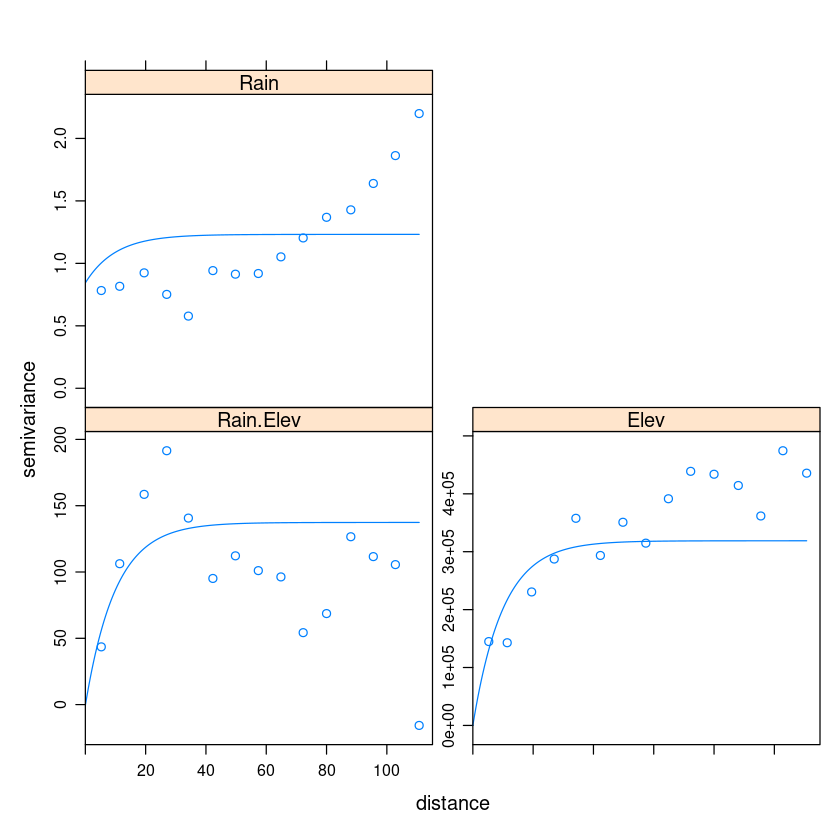

In [213]:
g9 = gstat(g9, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g9 = fit.lmc(v_cross,g9)
g9
plot(variogram(g9), model= g9$model)

DAY 11

In [214]:
f11 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_11_July_23.csv"

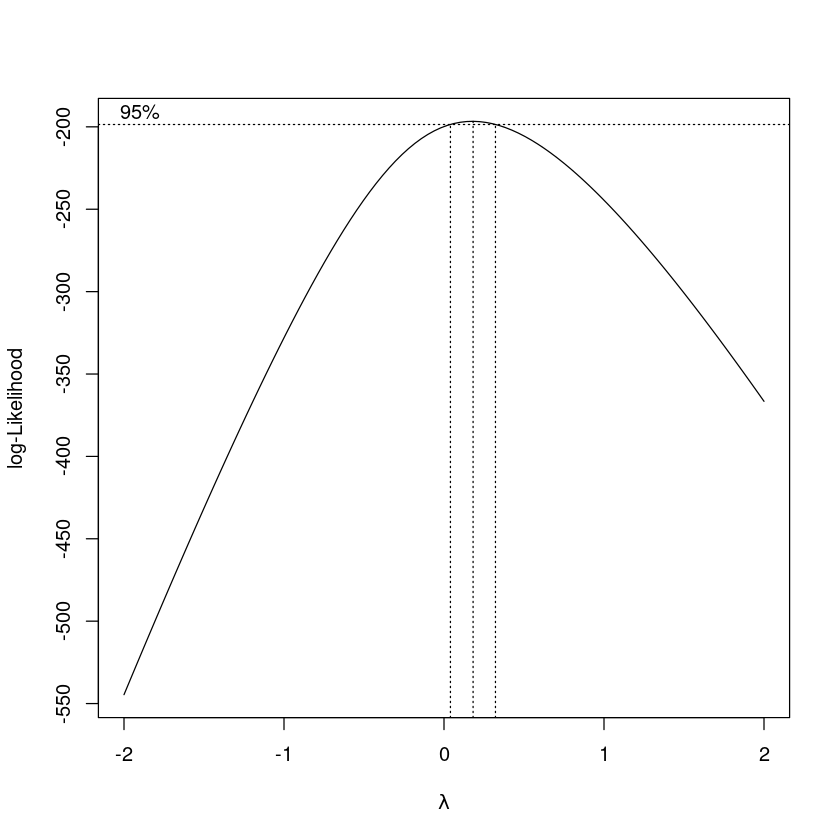

In [215]:
d11 = read.csv(f11)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d11$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d11$Rainfall_Transformed <- rain_transformed

In [216]:
lambda_rn

[1] 0.1818182

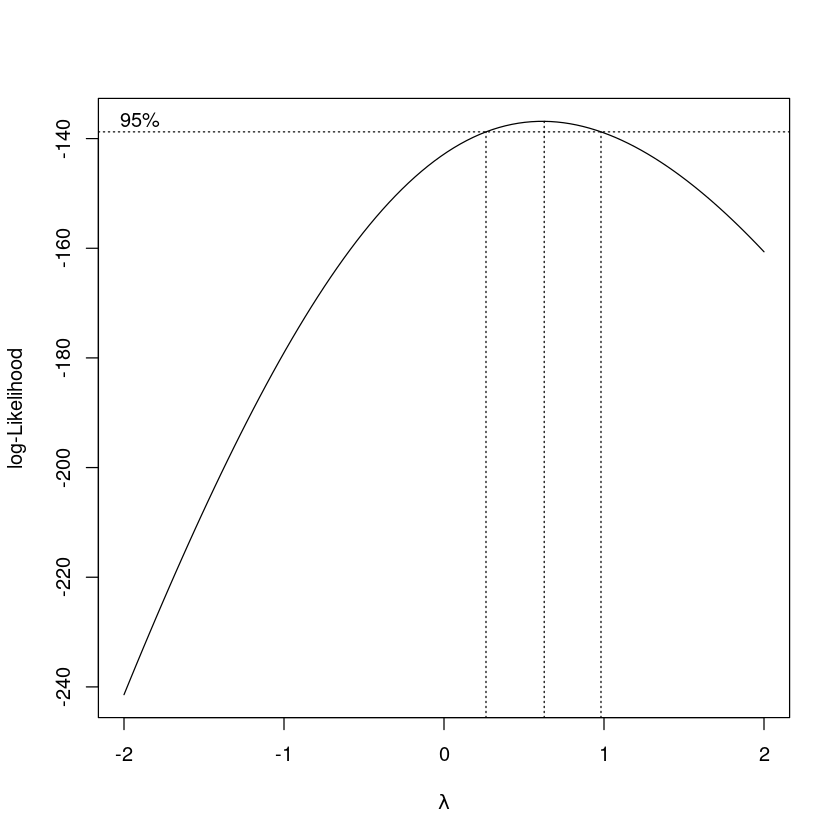

In [217]:
# Perform Box-Cox transformation on rainfall data
  elev <- d11$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d11$Elevation_Transformed <- el_transformed

In [218]:
coordinates1 = data.frame(lon = d11$Longitude, lat = d11$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d11_modb = subset(d11, select = -c(Longitude,Latitude))
sd_11 = SpatialPointsDataFrame(coords1,d11_modb)
class(sd_11)
proj4string(sd_11) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_11_prjtd <- spTransform(sd_11, CRS(desired_crs))
proj4string(sd_11_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(rain_vgm, fit):
“No convergence after 200 iterations: try different initial values?”


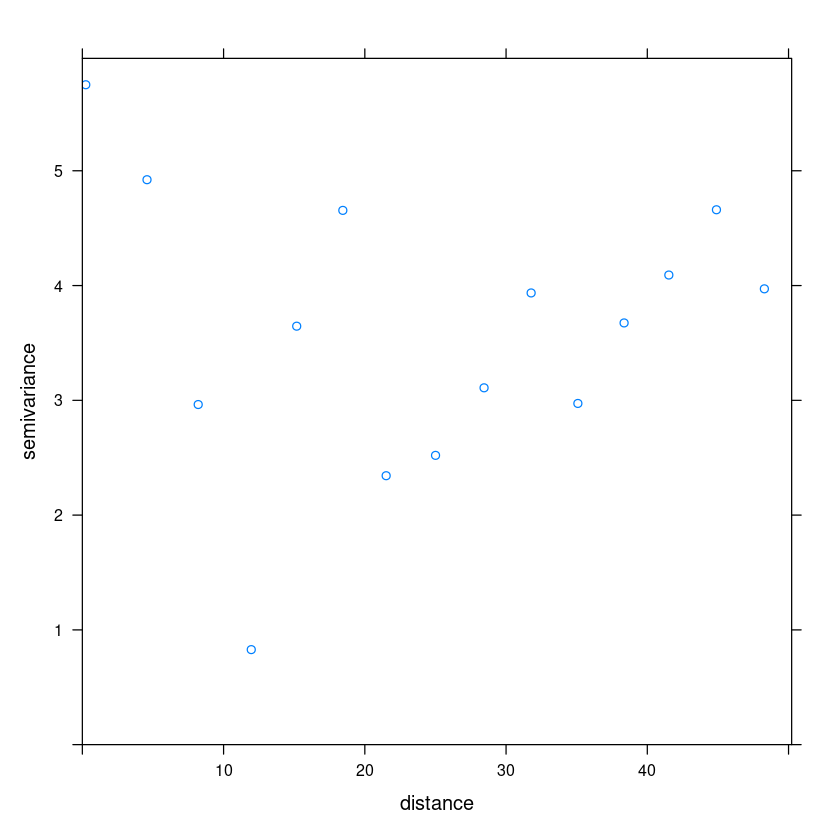

In [219]:
rain_vgm = variogram(rain_transformed ~1, data = sd_11_prjtd, cutoff = 50)
 plot(rain_vgm)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
# plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   126371.9  0.00000 0.0   0    0    0    1     1    
2 Exp   348987.0 44.45762 0.5   0    0    0    1     1

[1] 0.06354969

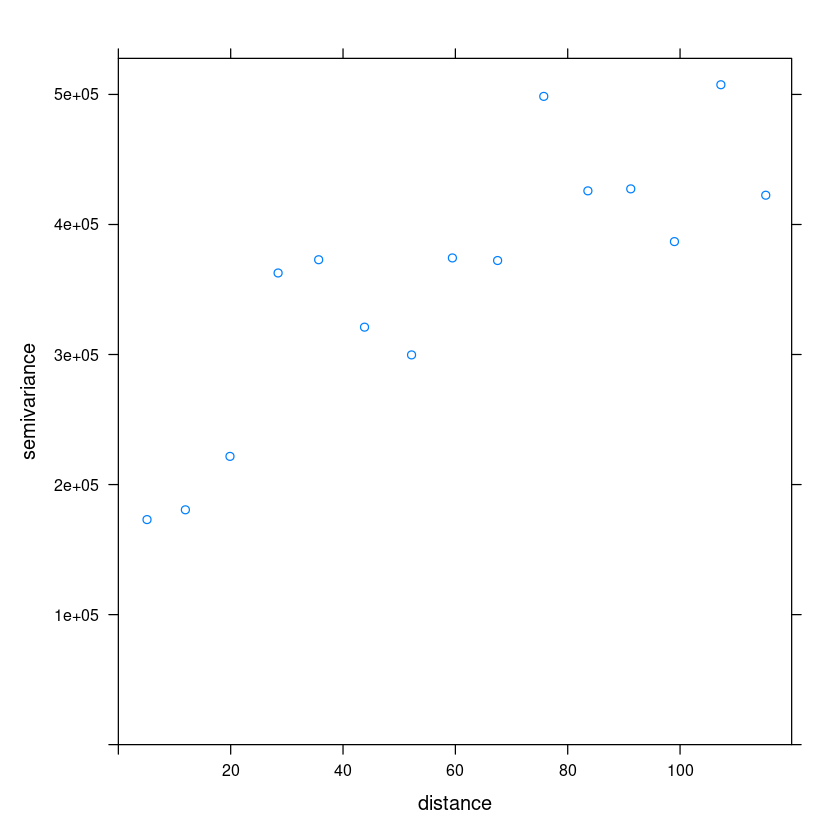

In [220]:
elev = d11$Elevation
elev_vgm = variogram(elev~1, data = sd_11_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [221]:
## Likfit Variog

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-25.3732" " -0.0141" "  0.0126" "  2.1497" "  1.9391" " 26.9532" 
Practical Range with cor=0.05 for asymptotic range: 80.74442

likfit: maximised log-likelihood = -338.7

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-25.3732  -0.0141   0.0126 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.939
      (estimated) cor. fct. parameter phi (range parameter)  =  26.95
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.15

Transformation parameter:
      (fixed) Box-Cox parameter = 0.1818

Practical Range with cor=0.05 for asymptotic range: 80.74442

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-338.7"      "6"  "689.4"  "703.5" 

non spatial model:
   log.L n.params      AIC      BIC 
"-342.3"      "4"  "692.6"    "702" 

Call:
likfit(geodata = gdt_11, trend = "1st", ini.cov.pars = c(5, 100), 
  

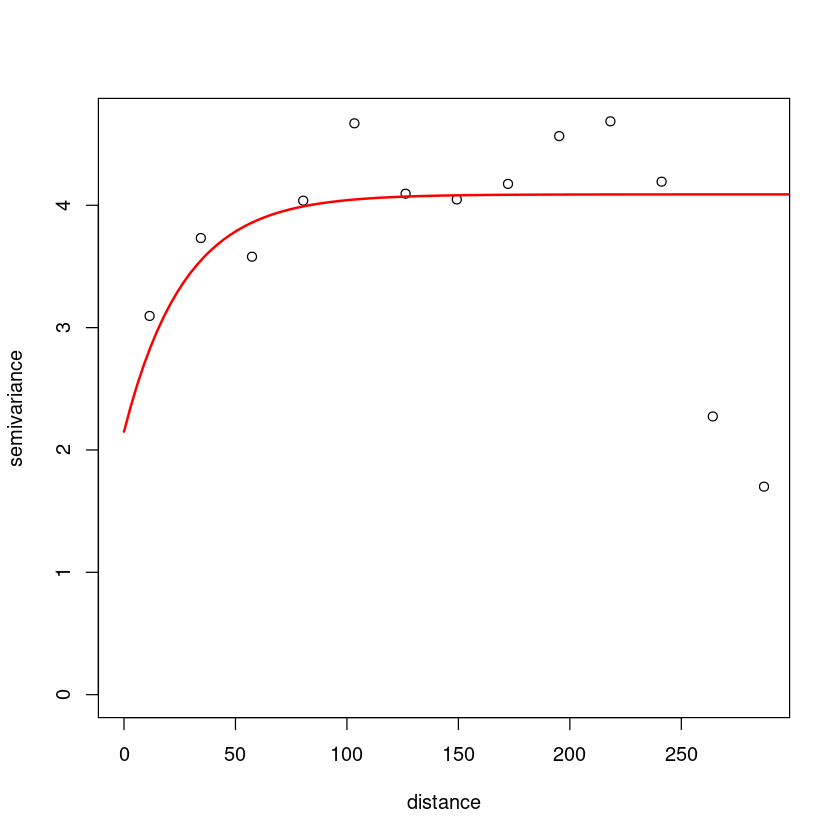

In [222]:
cord = coordinates(sd_11_prjtd)
rn = sd_11_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_11 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_11 = jitterDupCoords(gdt_11, max = jit_am)

vf_11 = variog(gdt_11, lambda = 0.181818181818182, trend = "1st")
plot(vf_11)

vgm_rn_lk_11 = likfit(geodata = gdt_11, trend = "1st",cov.model = "exponential", ini.cov.pars = c(5,100),nugget = 2.8, lambda = 0.181818181818182, lik.method = "ML", messages = FALSE)
vgm_rn_lk_11
summary(vgm_rn_lk_11)

# Add the fitted model
lines(vgm_rn_lk_11, col = "red", lwd = 2)

In [223]:
## Likfit krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


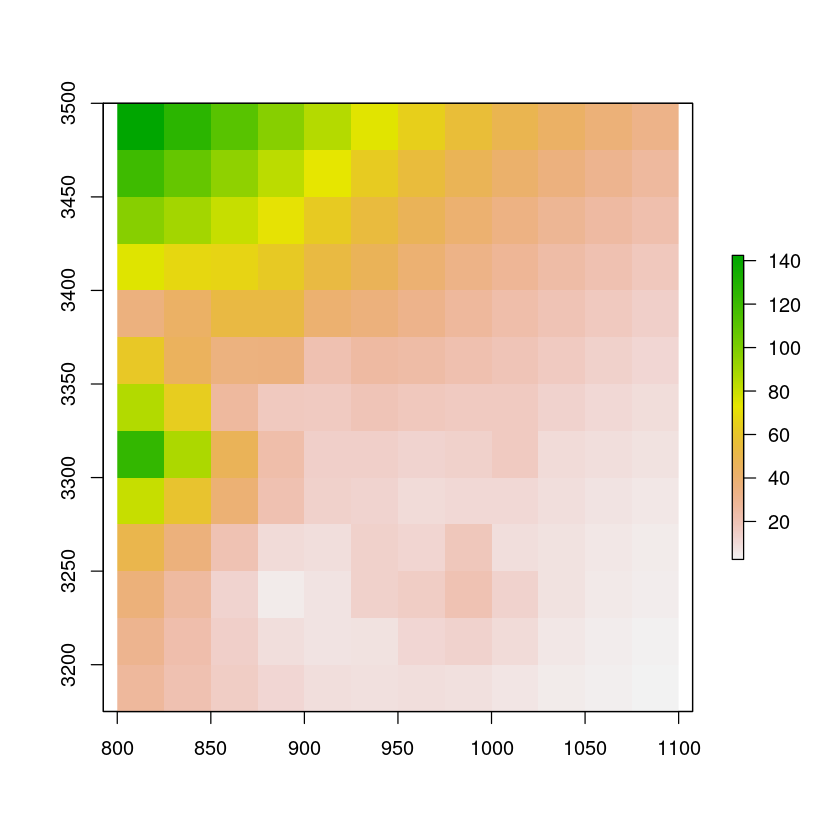

In [224]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_11 <- krige.conv(gdt_11, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_11))



krig_rain_lkft_11 <- krig_lkft_11$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_11 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_11))
proj4string(pr_rain_lkft_11) <- proj4string(grid_3sp)
plot(pr_rain_lkft_11)


In [225]:
## Regression

Generalized Linear Model 

77 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 69, 70, 69, 69, 69, 70, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  2.447838  0.1399118  2.076163

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-21.7218  -0.0149   0.0106 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.966
      (estimated) cor. fct. parameter phi (range parameter)  =  28.54
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.105

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 85.4862

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-158.5"      "6"  "328.9"    "343" 

non spatial model:
   log.L n.params      AIC      BIC 
"-162.3"      "4"  "332.7"    "342" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


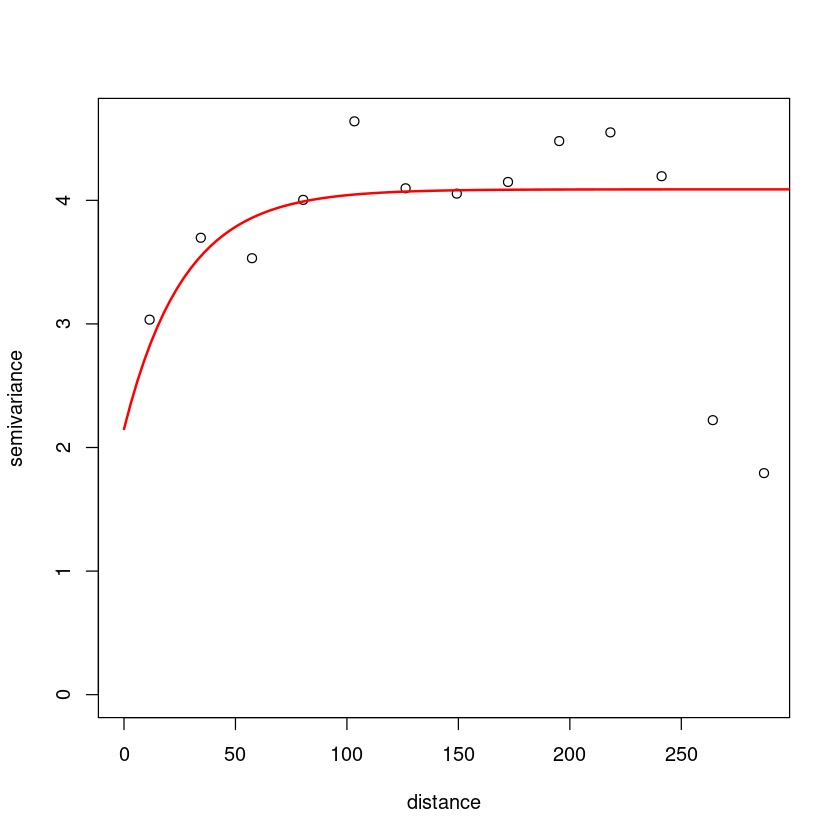

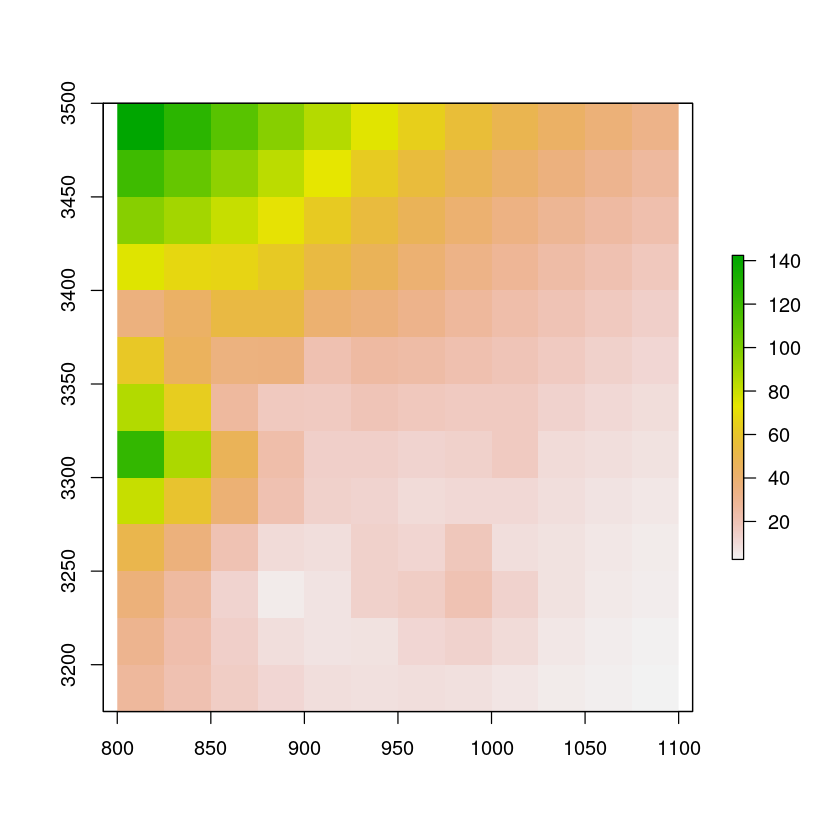

In [226]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_11 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_11))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_11 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(5, 100), 
                     nugget = 2.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_11)
lines(vgm_rn_lk_11, col = "red", lwd = 2)

krig_lkft_regr_11 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_11))

krig_regr_11 <- krig_lkft_11$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_11 <- rasterFromXYZ(cbind(grid_df, krig_regr_11))
proj4string(pr_regr_lkft_11) <- proj4string(grid_3sp)
plot(pr_regr_lkft_11)

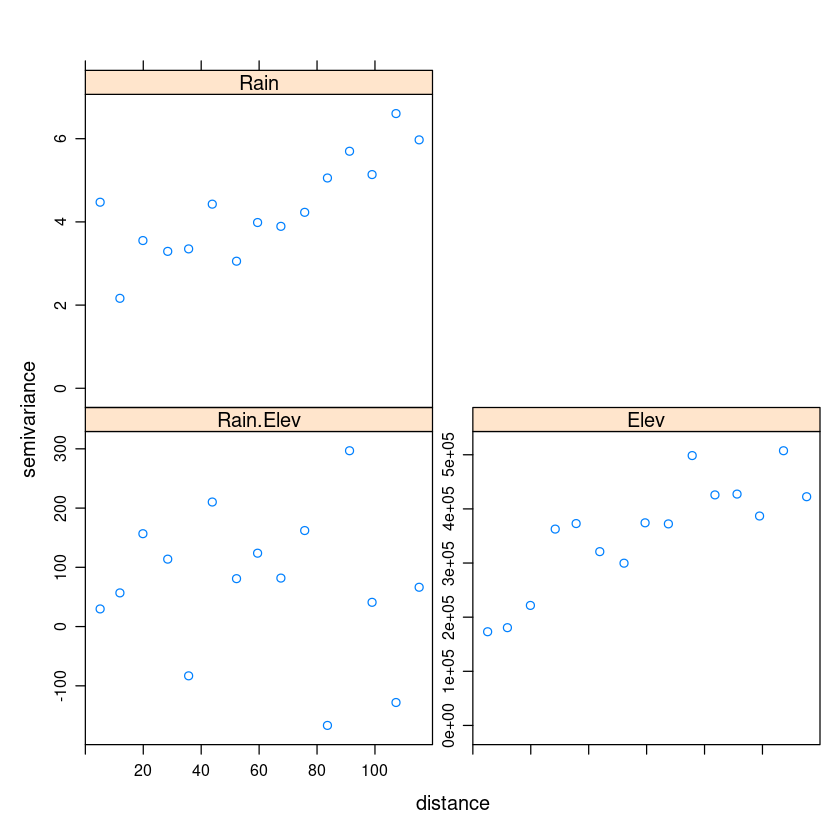

In [227]:
g10 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_11_prjtd)
g10 = gstat(g10, id = "Elev", form = elev~1, data = sd_11_prjtd)
v_cross = variogram(g10)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 77 x 11
Elev : formula = elev`~`1 ; data dim = 77 x 11
variograms:
             model        psill    range
Rain[1]        Nug 3.603600e+00   0.0000
Rain[2]        Exp 1.057931e+00 102.0019
Elev[1]        Nug 1.479061e+05   0.0000
Elev[2]        Exp 5.197919e+05 102.0019
Rain.Elev[1]   Nug 4.716154e+01   0.0000
Rain.Elev[2]   Exp 9.215342e+01 102.0019

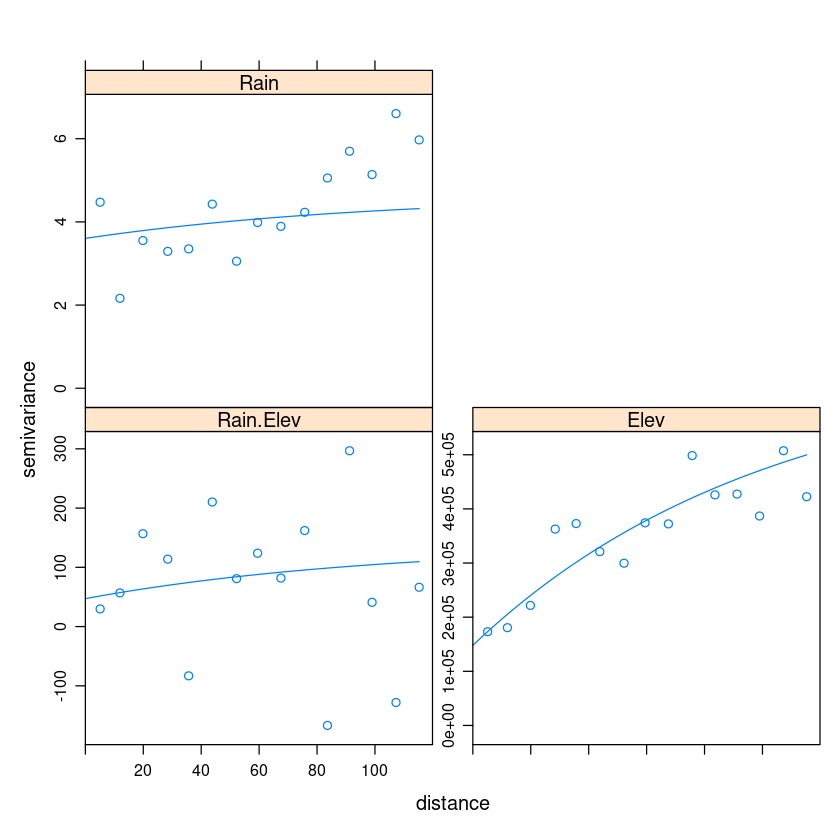

In [228]:
g10 = gstat(g10, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g10 = fit.lmc(v_cross,g10)
g10
plot(variogram(g10), model= g10$model)

DAY 12

In [229]:
f12 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_12_July_23.csv"

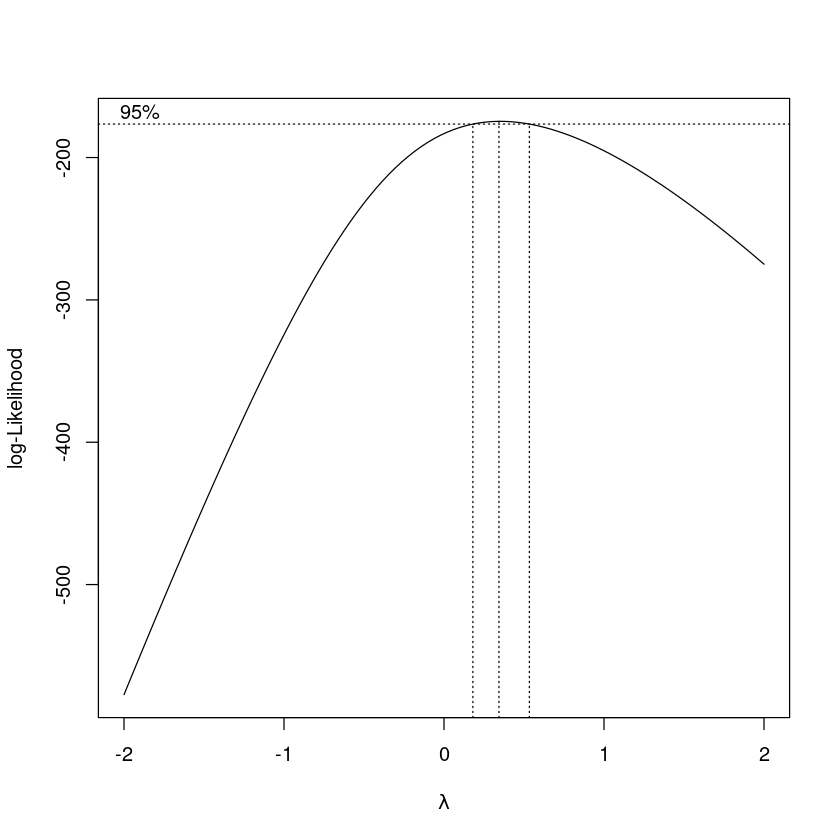

In [230]:
d12 = read.csv(f12)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d12$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d12$Rainfall_Transformed <- rain_transformed

In [231]:
lambda_rn

[1] 0.3434343

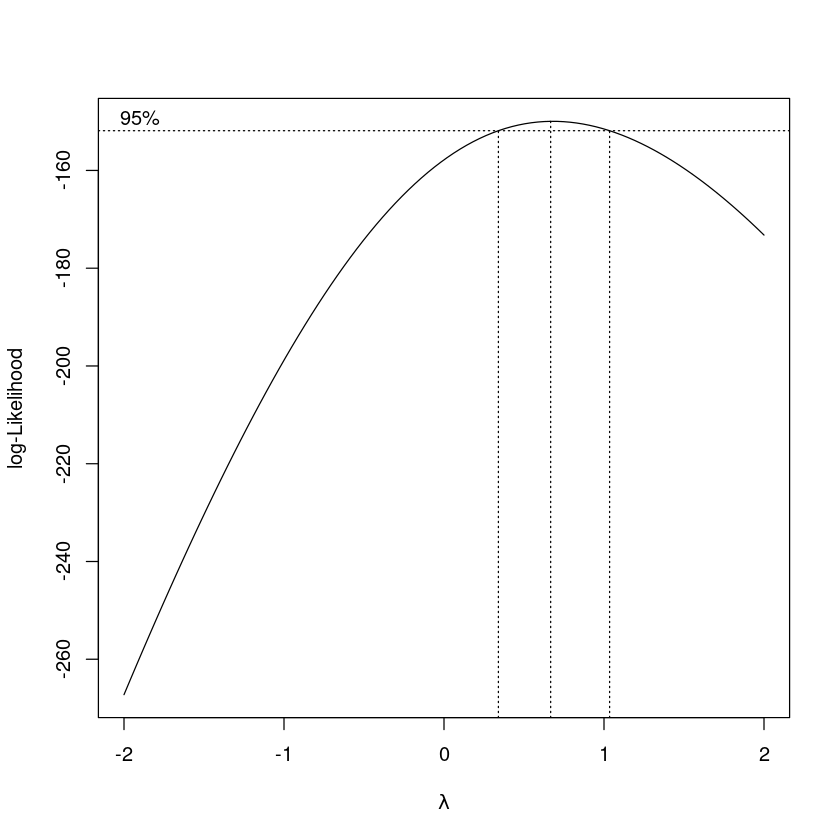

In [232]:
# Perform Box-Cox transformation on rainfall data
  elev <- d12$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d12$Elevation_Transformed <- el_transformed

In [233]:
coordinates1 = data.frame(lon = d12$Longitude, lat = d12$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d12_modb = subset(d12, select = -c(Longitude,Latitude))
sd_12 = SpatialPointsDataFrame(coords1,d12_modb)
class(sd_12)
proj4string(sd_12) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_12_prjtd <- spTransform(sd_12, CRS(desired_crs))
proj4string(sd_12_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(rain_vgm, fit):
“No convergence after 200 iterations: try different initial values?”


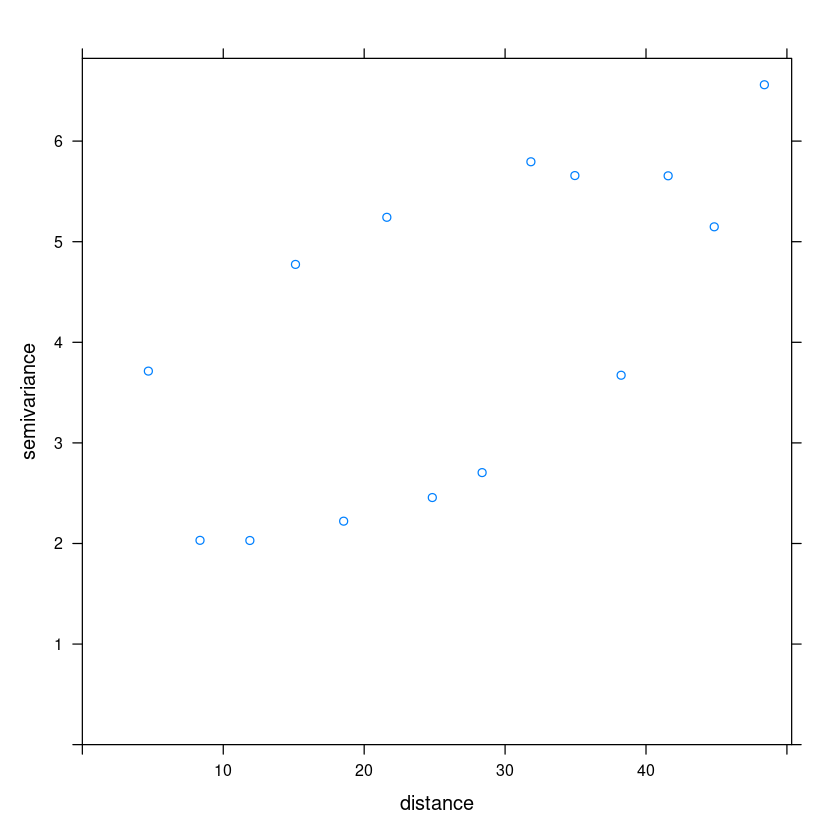

In [234]:
rain_vgm = variogram(rain_transformed ~1, data = sd_12_prjtd, cutoff = 50)
 plot(rain_vgm)
fit = vgm(2, "Exp", 10, 2)
fit_rain_vgm = fit.variogram(rain_vgm, fit)
# plot(rain_vgm, model = fit_rain_vgm)
# v = fit.variogram(rain_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
# v

model psill    range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug   163624.5   0.0000 0.0   0    0    0    1     1    
2 Exp   602888.1 164.6349 0.5   0    0    0    1     1

[1] 0.3311795

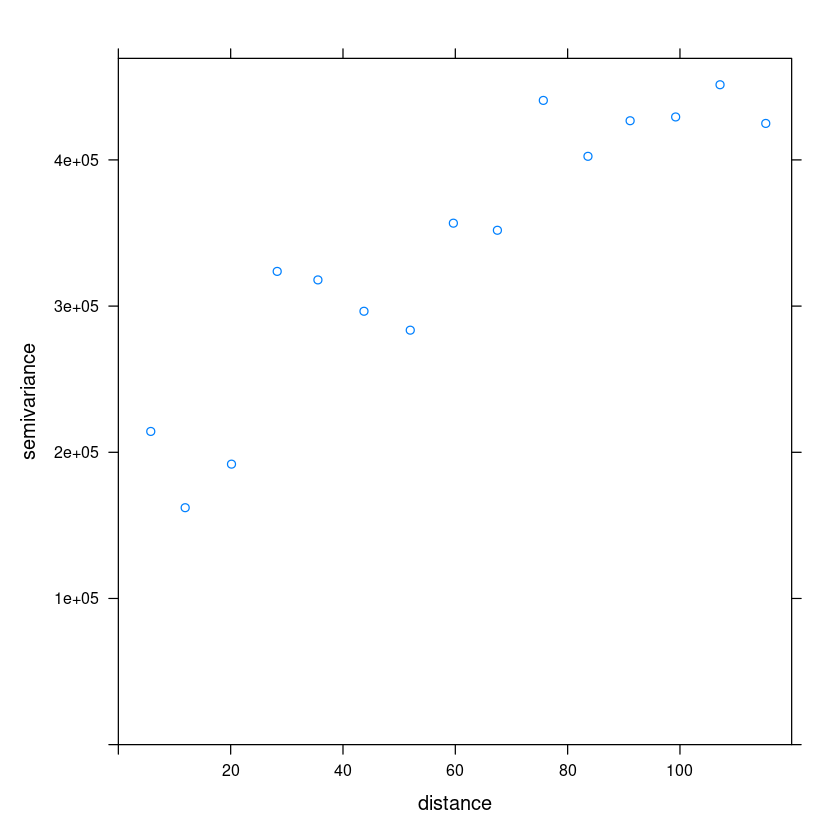

In [235]:
elev = d12$Elevation
elev_vgm = variogram(elev~1, data = sd_12_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [236]:
##likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"-5.2067" "-0.0063" " 0.0048" " 1.2604" " 6.1099" "40.7614" 
Practical Range with cor=0.05 for asymptotic range: 122.1101

likfit: maximised log-likelihood = -350.6

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-5.2067 -0.0063  0.0048 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  6.11
      (estimated) cor. fct. parameter phi (range parameter)  =  40.76
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.26

Transformation parameter:
      (fixed) Box-Cox parameter = 0.3434

Practical Range with cor=0.05 for asymptotic range: 122.1101

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-350.6"      "6"  "713.3"  "727.8" 

non spatial model:
   log.L n.params      AIC      BIC 
  "-368"      "4"  "744.1"  "753.7" 

Call:
likfit(geodata = gdt_12, trend = "1st", ini.cov.pars = c(8, 100), 
    nugge

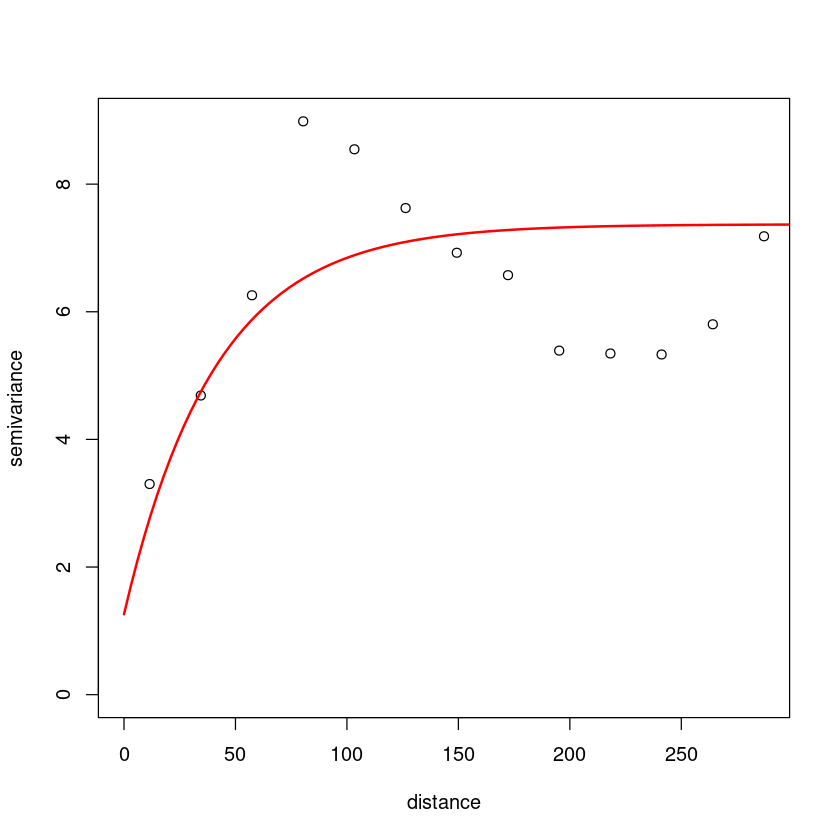

In [237]:
cord = coordinates(sd_12_prjtd)
rn = sd_12_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_12 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_12 = jitterDupCoords(gdt_12, max = jit_am)

vf_12 = variog(gdt_12, lambda = 0.343434343434343, trend = "1st")
plot(vf_12)

vgm_rn_lk_12 = likfit(geodata = gdt_12, trend = "1st",cov.model = "exponential", ini.cov.pars = c(8,100),nugget = 3.5, lambda = 0.343434343434343, lik.method = "ML", messages = FALSE)
vgm_rn_lk_12
summary(vgm_rn_lk_12)

# Add the fitted model
lines(vgm_rn_lk_12, col = "red", lwd = 2)

In [238]:
## Likfit krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


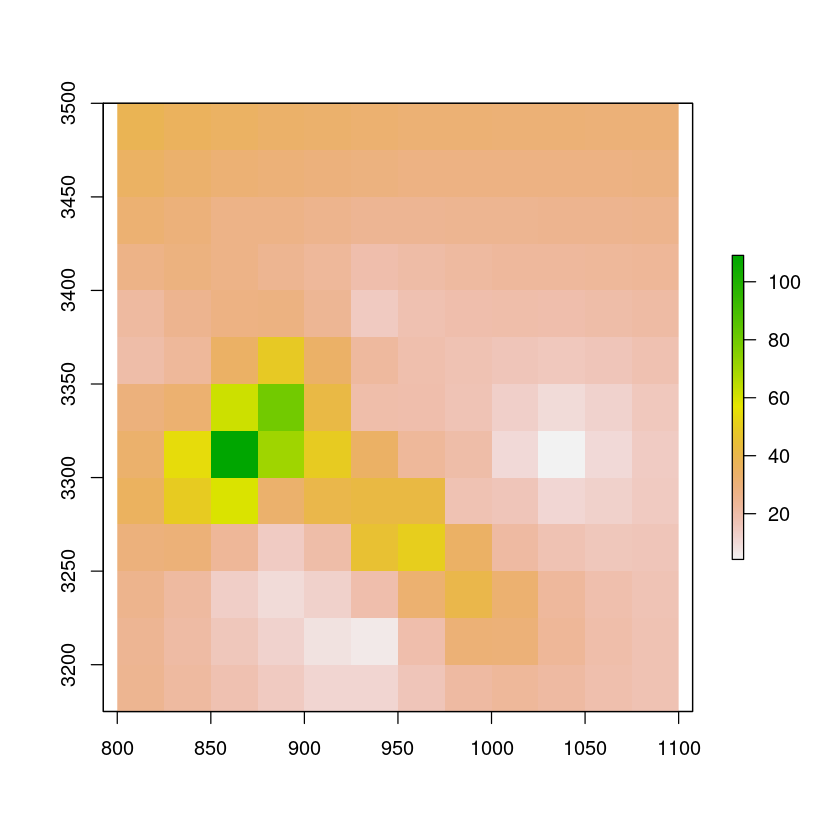

In [239]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_12 <- krige.conv(gdt_12, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_12))



krig_rain_lkft_12 <- krig_lkft_12$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_12 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_12))
proj4string(pr_rain_lkft_12) <- proj4string(grid_3sp)
plot(pr_rain_lkft_12)


In [240]:
## Regression

Generalized Linear Model 

83 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 75, 75, 75, 74, 75, 76, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  2.424193  0.1646046  1.993832

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
40.7682 -0.0111 -0.0095 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  4.953
      (estimated) cor. fct. parameter phi (range parameter)  =  30.72
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.191

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 92.03097

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-178.1"      "6"  "368.3"  "382.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-191.5"      "4"  "391.1"  "400.8" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


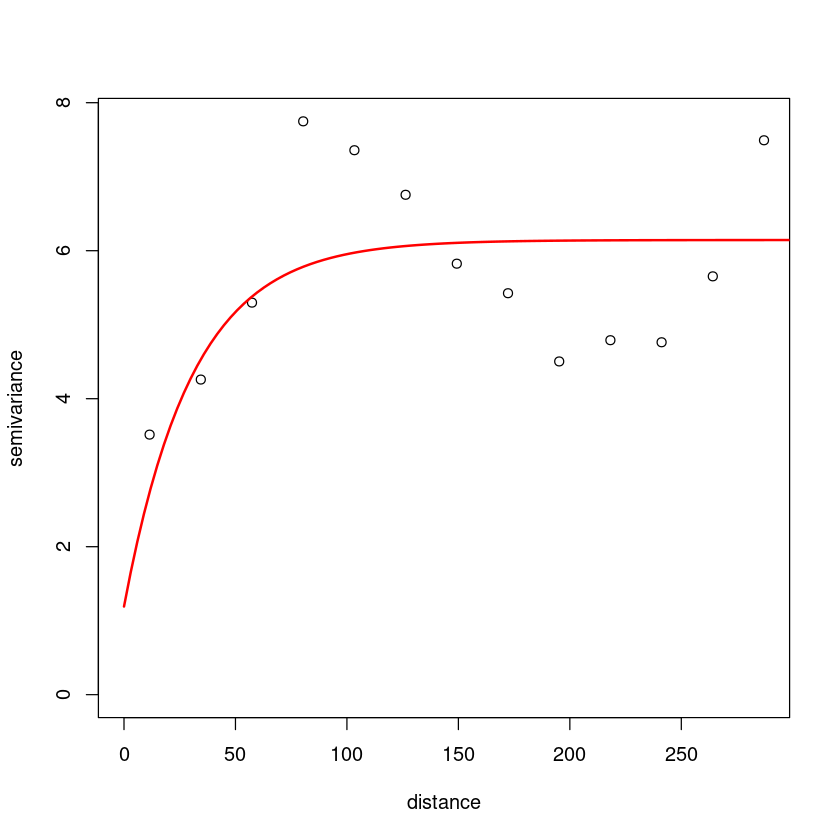

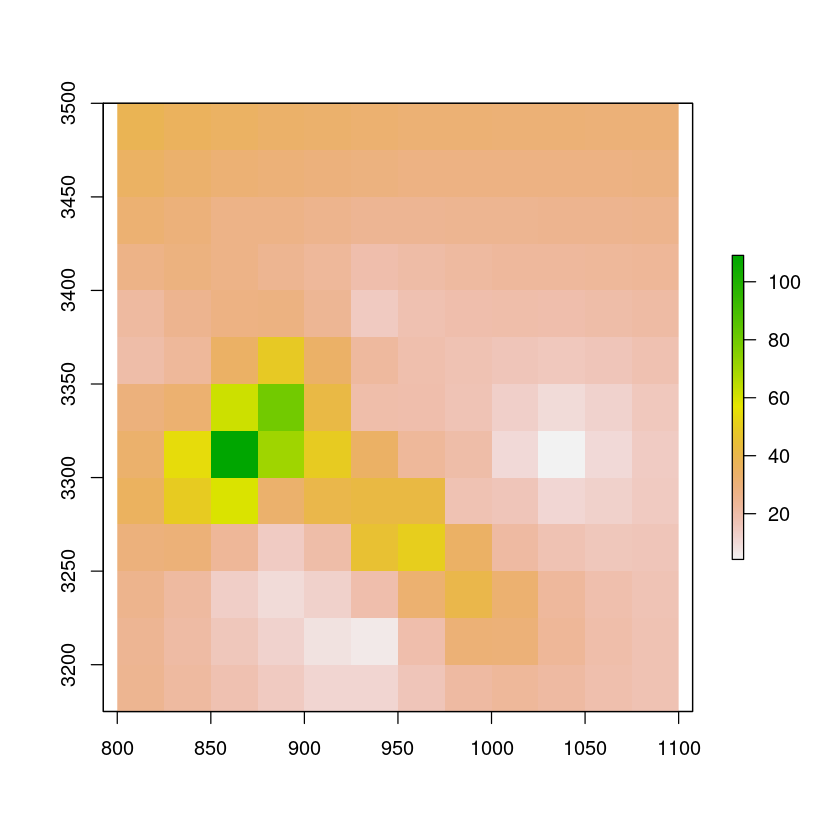

In [241]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_12 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_12))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_12 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(8, 60), 
                     nugget = 3.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_12)
lines(vgm_res_lk_12, col = "red", lwd = 2)

krig_lkft_regr_12 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_12))

krig_regr_12 <- krig_lkft_12$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_12 <- rasterFromXYZ(cbind(grid_df, krig_regr_12))
proj4string(pr_regr_lkft_12) <- proj4string(grid_3sp)
plot(pr_regr_lkft_12)


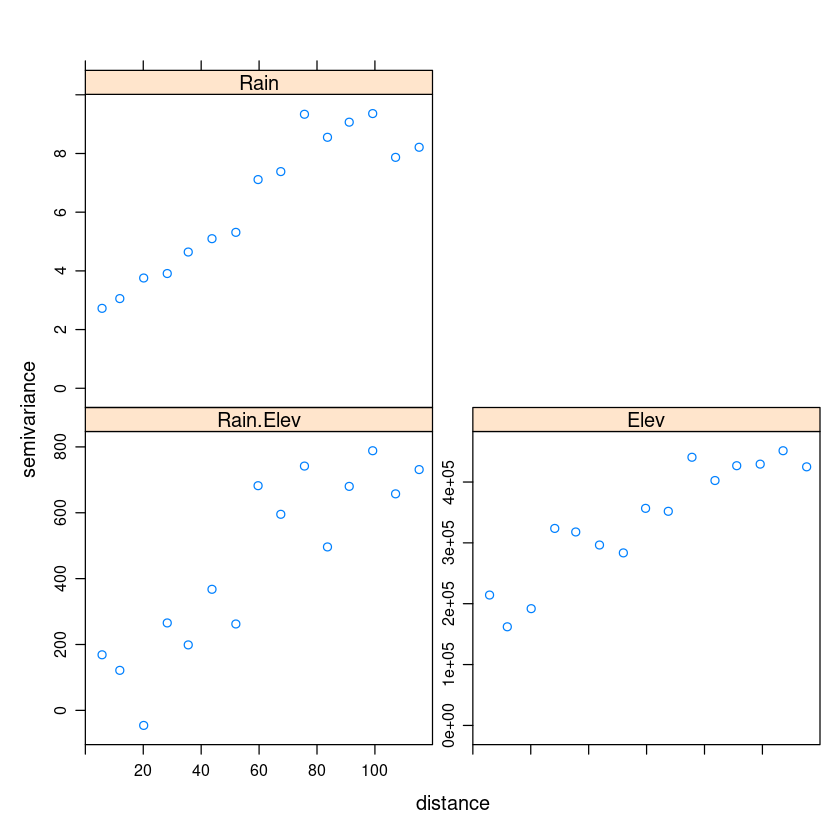

In [242]:
g11 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_12_prjtd)
g11 = gstat(g11, id = "Elev", form = elev~1, data = sd_12_prjtd)
v_cross = variogram(g11)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 83 x 11
Elev : formula = elev`~`1 ; data dim = 83 x 11
variograms:
             model        psill    range
Rain[1]        Nug      2.13061   0.0000
Rain[2]        Exp     21.96839 268.6907
Elev[1]        Nug 167543.10526   0.0000
Elev[2]        Exp 889023.01706 268.6907
Rain.Elev[1]   Nug     31.92766   0.0000
Rain.Elev[2]   Exp   2091.86993 268.6907

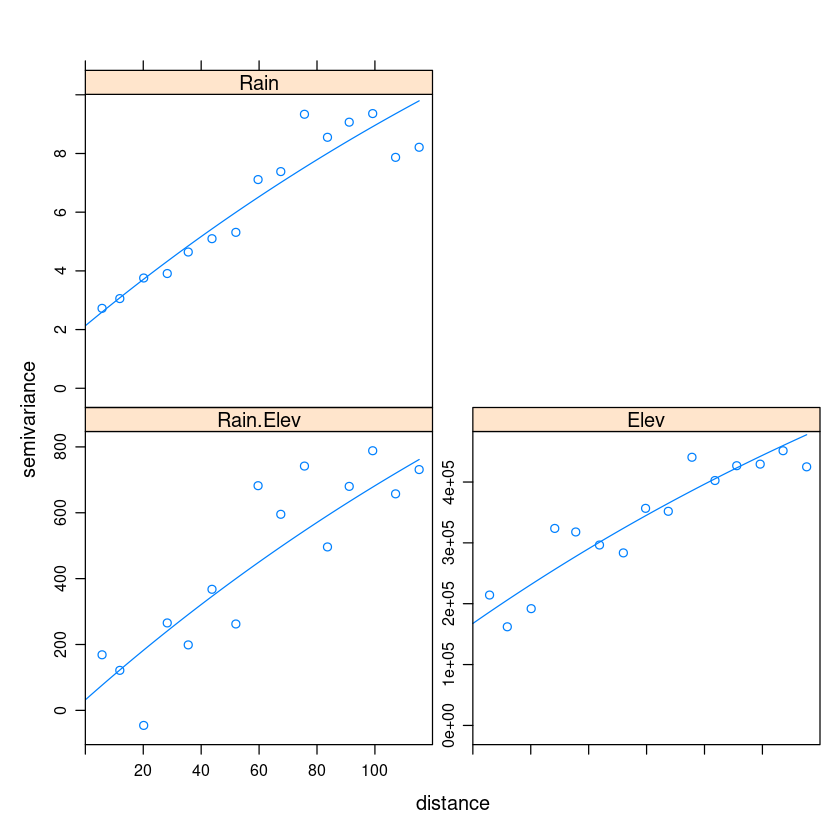

In [243]:
g11 = gstat(g11, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g11 = fit.lmc(v_cross,g11)
g11
plot(variogram(g11), model= g11$model)

DAY 13

In [244]:
f13 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_13_July_23.csv"

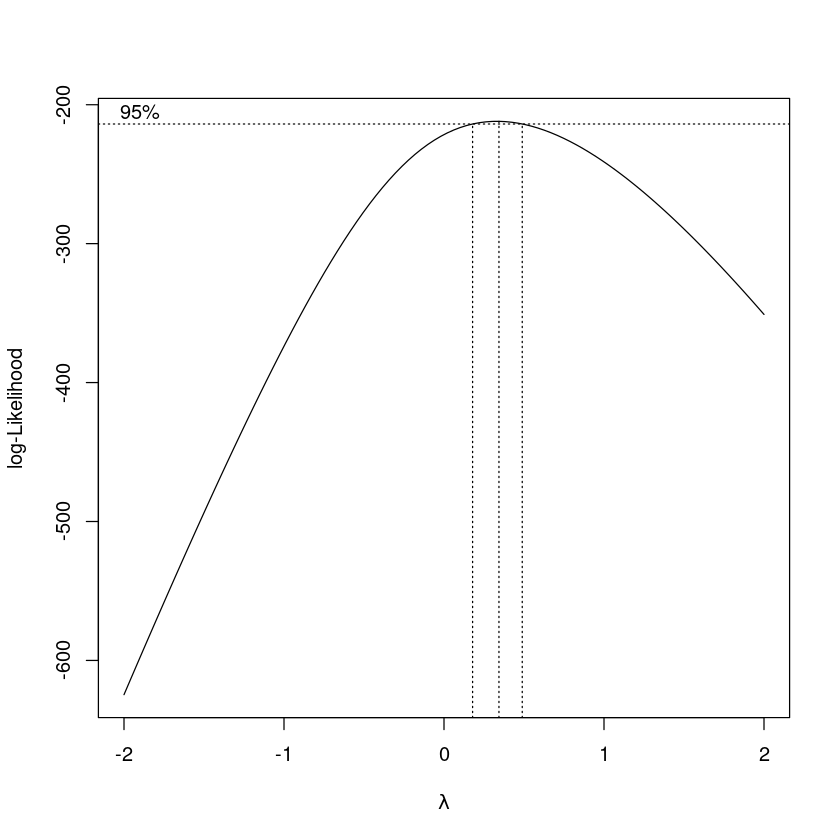

In [245]:
d13 = read.csv(f13)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d13$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d13$Rainfall_Transformed <- rain_transformed

In [246]:
lambda_rn

[1] 0.3434343

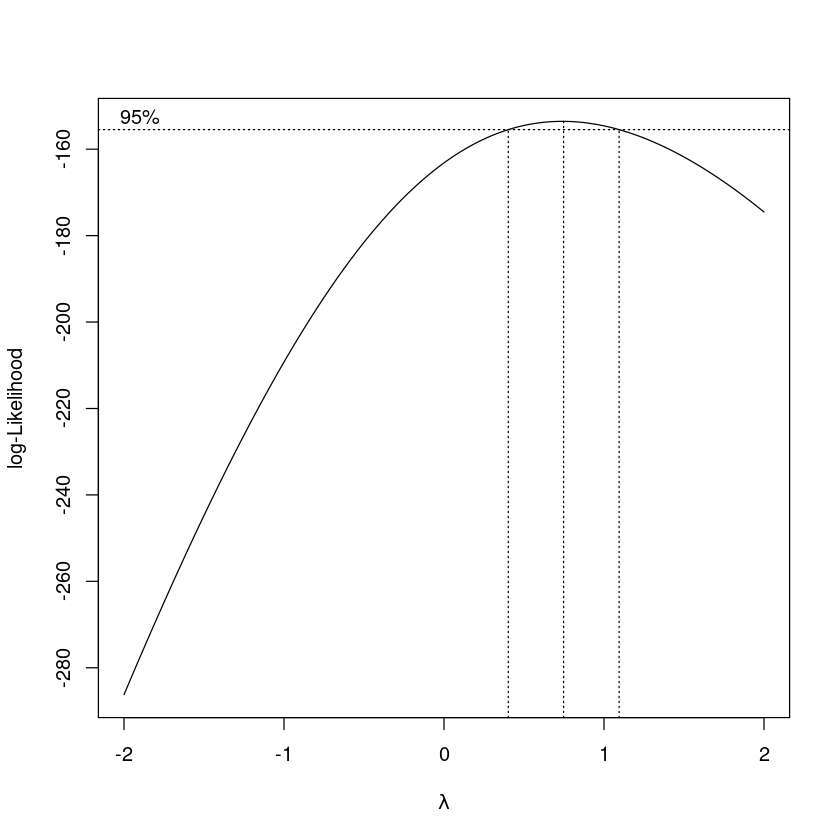

In [247]:
# Perform Box-Cox transformation on rainfall data
  elev <- d13$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d13$Elevation_Transformed <- el_transformed

In [248]:
coordinates1 = data.frame(lon = d13$Longitude, lat = d13$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d13_modb = subset(d13, select = -c(Longitude,Latitude))
sd_13 = SpatialPointsDataFrame(coords1,d13_modb)
class(sd_13)
proj4string(sd_13) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_13_prjtd <- spTransform(sd_13, CRS(desired_crs))
proj4string(sd_13_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

model psill    range   kappa ang1 ang2 ang3 anis1 anis2
1 Nug   159688.7  0.0000 0.0   0    0    0    1     1    
2 Exp   294867.3 50.4641 0.5   0    0    0    1     1

[1] 0.02920297

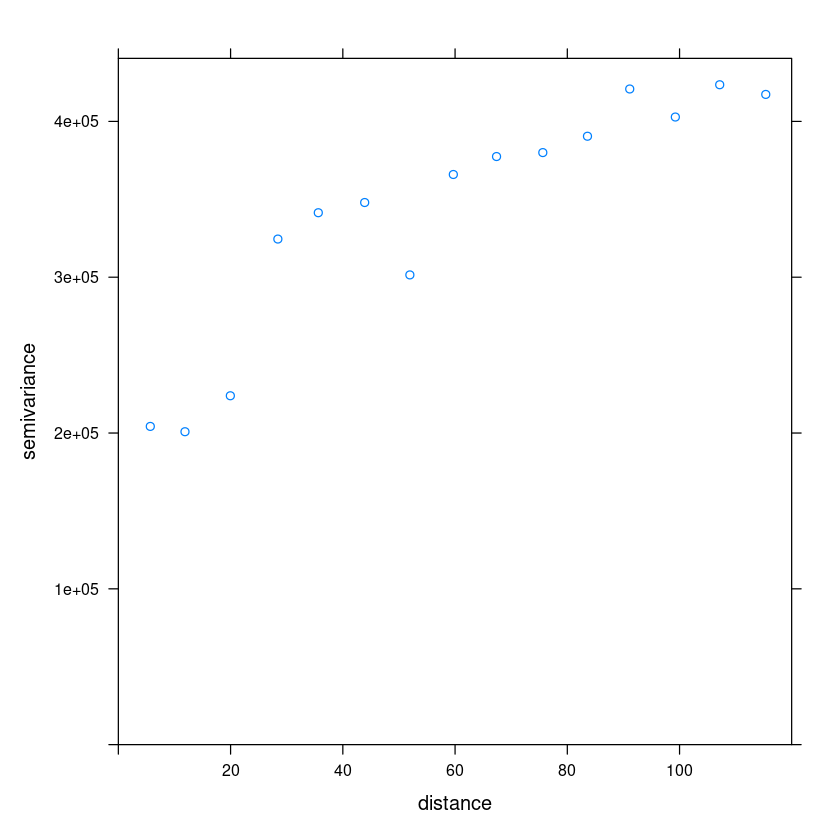

In [249]:
elev = d13$Elevation
elev_vgm = variogram(elev~1, data = sd_13_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [250]:
## Likfit Variog

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"-4.1483" "-0.0203" " 0.0084" " 7.4417" " 0.6544" "27.2409" 
Practical Range with cor=0.05 for asymptotic range: 27.24093

likfit: maximised log-likelihood = -380.5

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-4.1483 -0.0203  0.0084 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  0.6544
      (estimated) cor. fct. parameter phi (range parameter)  =  27.24
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  7.442

Transformation parameter:
      (fixed) Box-Cox parameter = 0.3434

Practical Range with cor=0.05 for asymptotic range: 27.24093

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-380.5"      "6"  "772.9"  "787.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-380.5"      "4"  "769.1"  "778.9" 

Call:
likfit(geodata = gdt_13, trend = "1st", ini.cov.pars = c(9, 70), 
    nugge

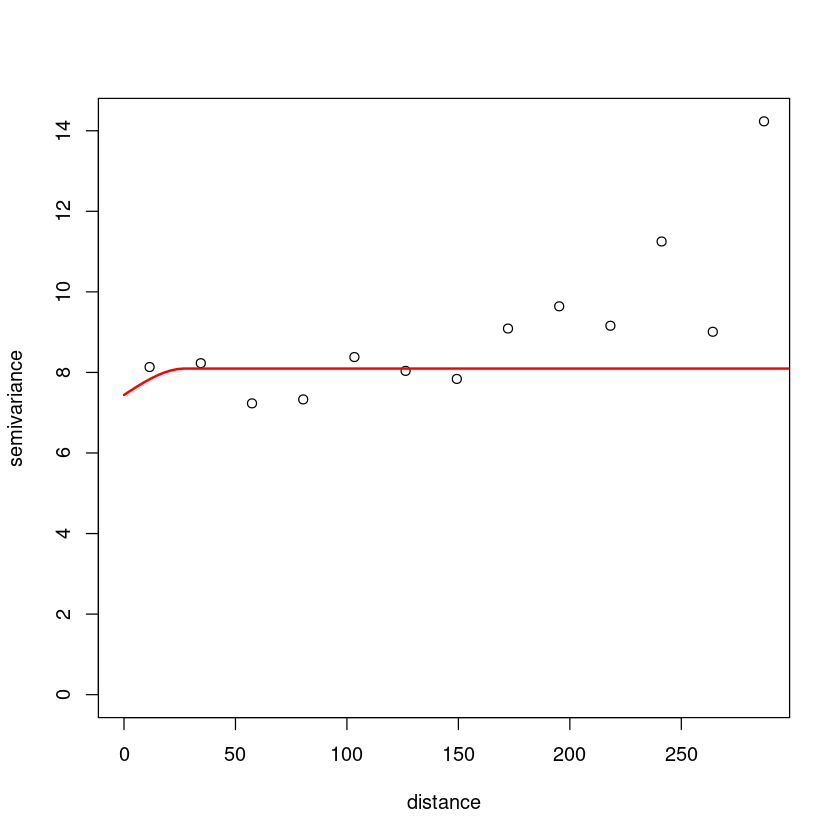

In [251]:
cord = coordinates(sd_13_prjtd)
rn = sd_13_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_13 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_13 = jitterDupCoords(gdt_13, max = jit_am)

vf_13 = variog(gdt_13, lambda = 0.343434343434343, trend = "1st")
plot(vf_13)
vgm_rn_lk_13 = likfit(geodata = gdt_13, trend = "1st",cov.model = "spherical", ini.cov.pars = c(9,70),nugget = 4, lambda = 0.343434343434343, lik.method = "ML", messages = FALSE)
vgm_rn_lk_13
summary(vgm_rn_lk_13)

# Add the fitted model
lines(vgm_rn_lk_13, col = "red", lwd = 2)

In [252]:
##likfit krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


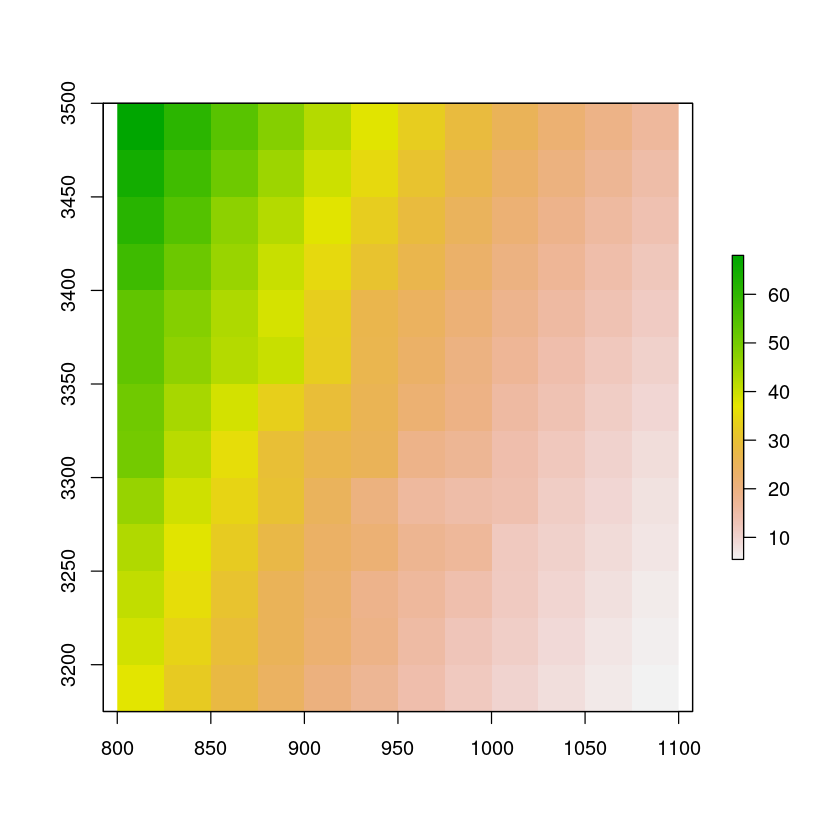

In [253]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_13 <- krige.conv(gdt_13, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_13))



krig_rain_lkft_13 <- krig_lkft_13$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_13 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_13))
proj4string(pr_rain_lkft_13) <- proj4string(grid_3sp)
plot(pr_rain_lkft_13)


In [254]:
## Regression

Generalized Linear Model 

87 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 79, 79, 77, 77, 78, 79, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  3.369334  0.2047555  2.786973

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-5.3571 -0.0209  0.0072 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  0.7022
      (estimated) cor. fct. parameter phi (range parameter)  =  28.8
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  7.406

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 28.7971

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-214.4"      "6"  "440.9"  "455.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-214.5"      "4"    "437"  "446.9" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = 

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


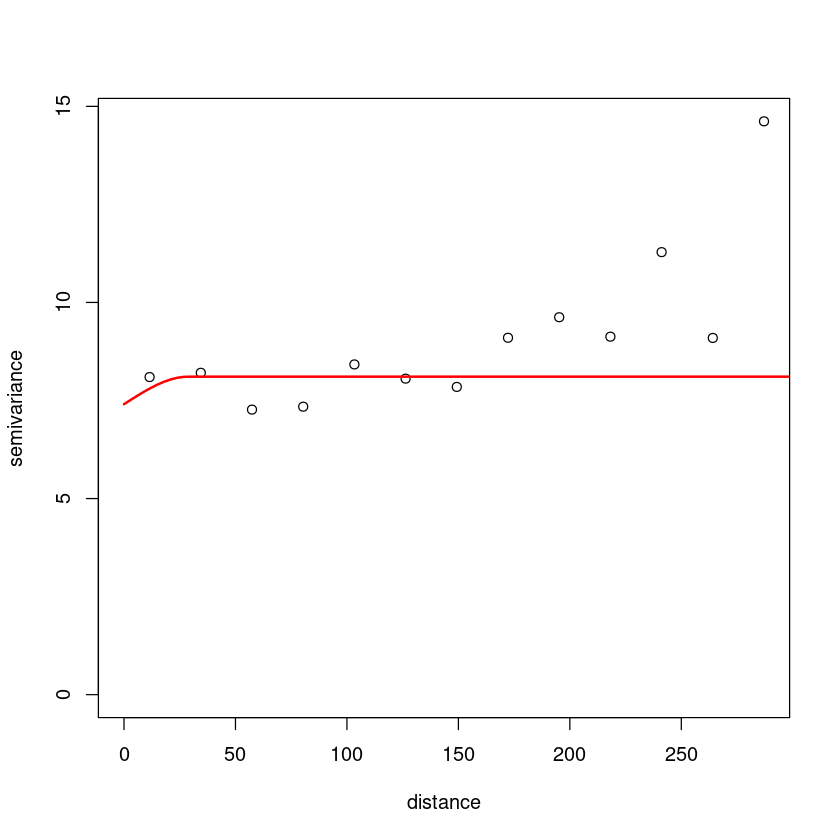

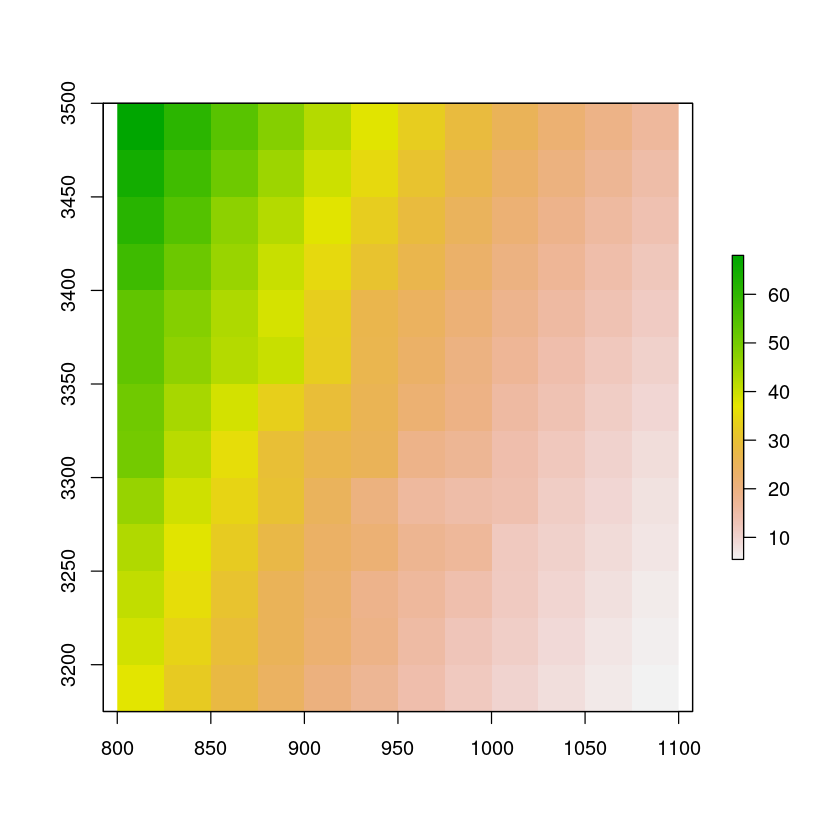

In [255]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_13 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_13))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_13 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "spherical", 
                     ini.cov.pars = c(9, 70), 
                     nugget = 4, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_13)

lines(vgm_res_lk_13, col = "red", lwd = 2)

krig_lkft_regr_13 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_13))

krig_regr_13 <- krig_lkft_13$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_13 <- rasterFromXYZ(cbind(grid_df, krig_regr_13))
proj4string(pr_regr_lkft_13) <- proj4string(grid_3sp)
plot(pr_regr_lkft_13)

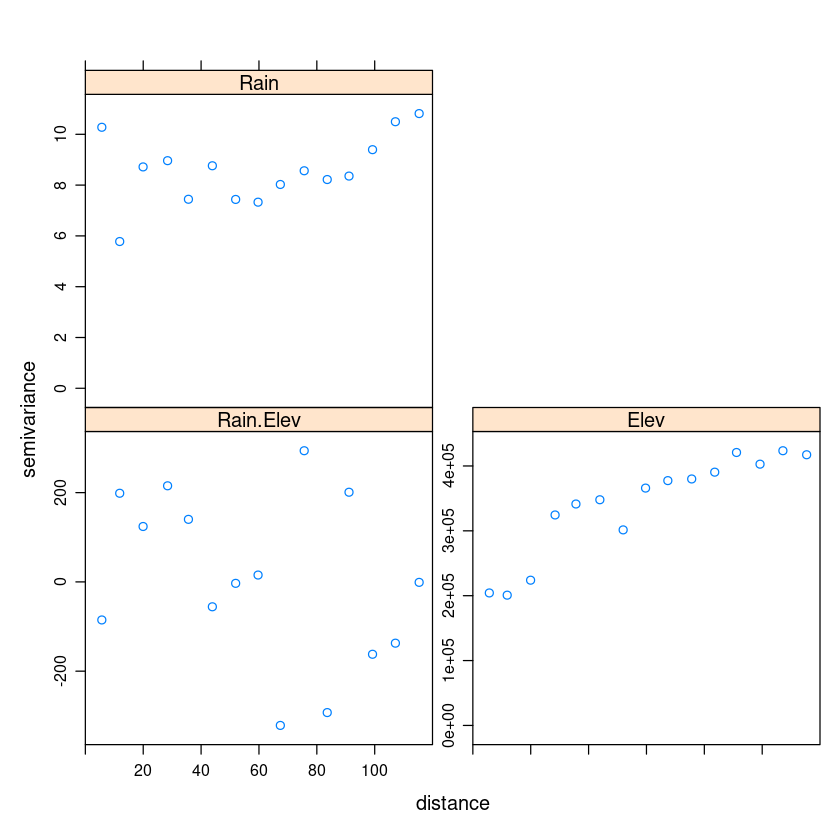

In [256]:
g12 = gstat(NULL, id = "Rain", form = rain_transformed ~1, data = sd_13_prjtd)
g12 = gstat(g12, id = "Elev", form = elev~1, data = sd_13_prjtd)
v_cross = variogram(g12)
plot(v_cross)

data:
Rain : formula = rain_transformed`~`1 ; data dim = 87 x 11
Elev : formula = elev`~`1 ; data dim = 87 x 11
variograms:
             model         psill    range
Rain[1]        Nug  8.435555e+00   0.0000
Rain[2]        Exp  7.370655e-02 268.6907
Elev[1]        Nug  1.871231e+05   0.0000
Elev[2]        Exp  8.360938e+05 268.6907
Rain.Elev[1]   Nug  7.261905e+01   0.0000
Rain.Elev[2]   Exp -2.482450e+02 268.6907

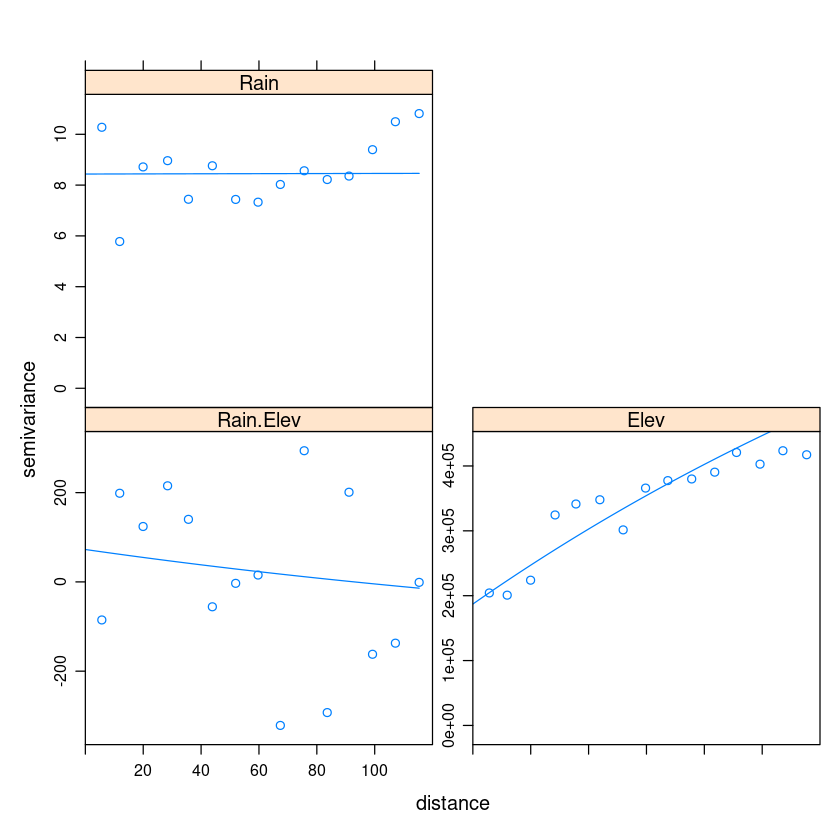

In [257]:
g12 = gstat(g12, id = "Rain", model = fit_rain_vgm, fill.all = T)
# g
g12 = fit.lmc(v_cross,g12)
g12
plot(variogram(g12), model= g12$model)

DAY 14

In [258]:
f14 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_14_July_23.csv"

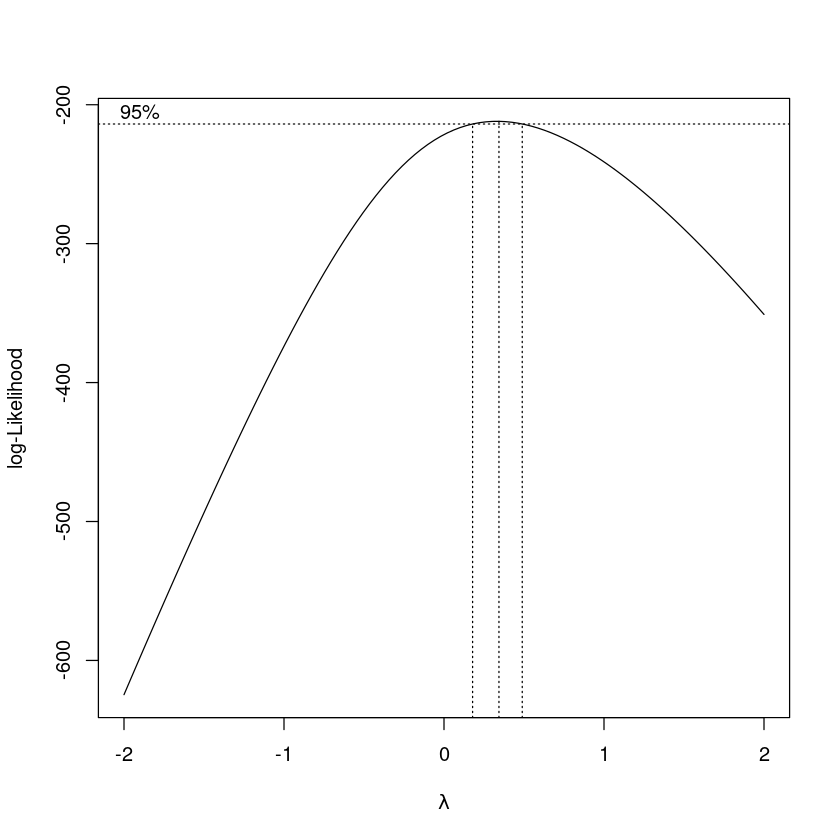

In [259]:
d14 = read.csv(f14)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d14$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d14$Rainfall_Transformed <- rain_transformed

In [260]:
lambda_rn

[1] 0.3434343

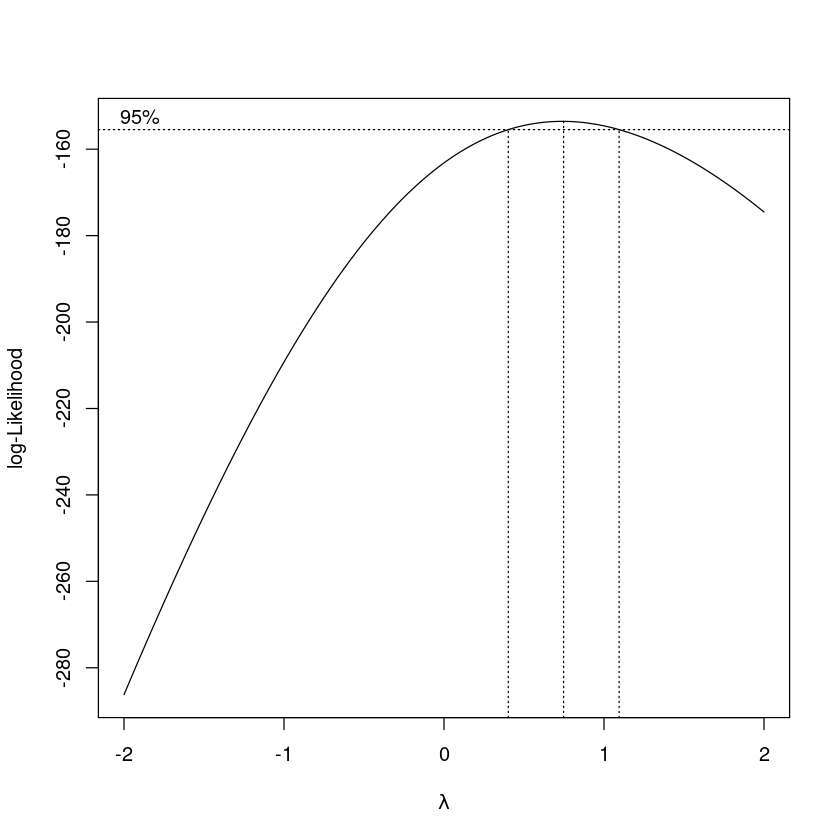

In [261]:
# Perform Box-Cox transformation on rainfall data
  elev <- d14$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d14$Elevation_Transformed <- el_transformed

In [262]:
coordinates1 = data.frame(lon = d14$Longitude, lat = d14$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d14_modb = subset(d14, select = -c(Longitude,Latitude))
sd_14 = SpatialPointsDataFrame(coords1,d14_modb)
class(sd_14)
proj4string(sd_14) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_14_prjtd <- spTransform(sd_14, CRS(desired_crs))
proj4string(sd_14_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

model psill    range   kappa ang1 ang2 ang3 anis1 anis2
1 Nug   159688.7  0.0000 0.0   0    0    0    1     1    
2 Exp   294867.3 50.4641 0.5   0    0    0    1     1

[1] 0.02920297

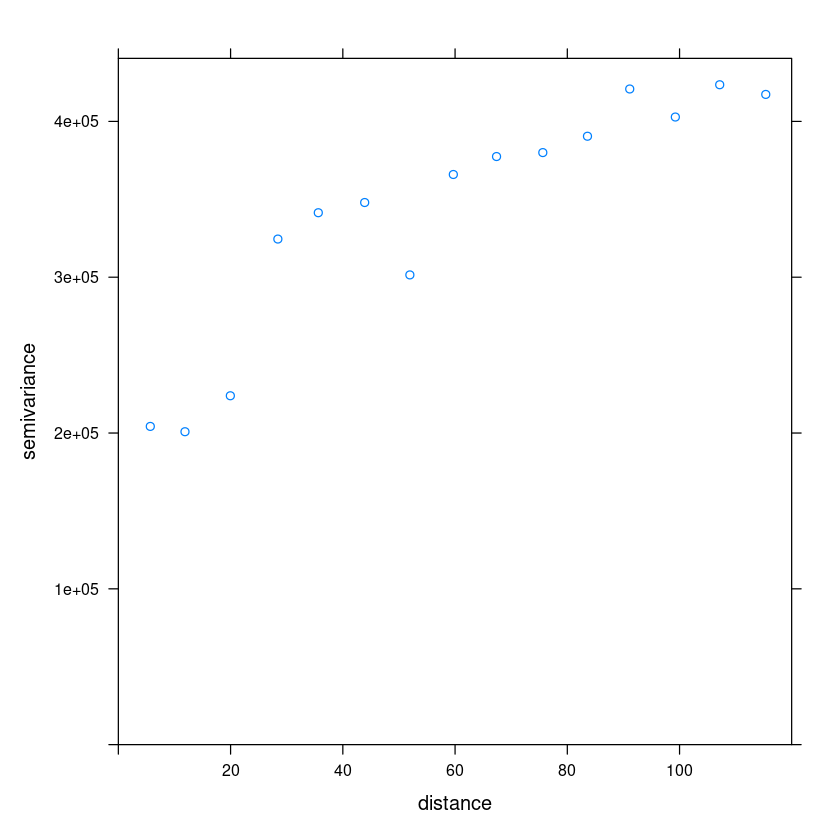

In [263]:
elev = d14$Elevation
elev_vgm = variogram(elev~1, data = sd_14_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [264]:
## likfit Var

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"-4.1484" "-0.0203" " 0.0084" " 7.4416" " 0.6545" "27.2396" 
Practical Range with cor=0.05 for asymptotic range: 27.23963

likfit: maximised log-likelihood = -380.5

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-4.1484 -0.0203  0.0084 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  0.6545
      (estimated) cor. fct. parameter phi (range parameter)  =  27.24
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  7.442

Transformation parameter:
      (fixed) Box-Cox parameter = 0.3434

Practical Range with cor=0.05 for asymptotic range: 27.23963

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-380.5"      "6"  "772.9"  "787.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-380.5"      "4"  "769.1"  "778.9" 

Call:
likfit(geodata = gdt_14, trend = "1st", ini.cov.pars = c(8, 70), 
    nugge

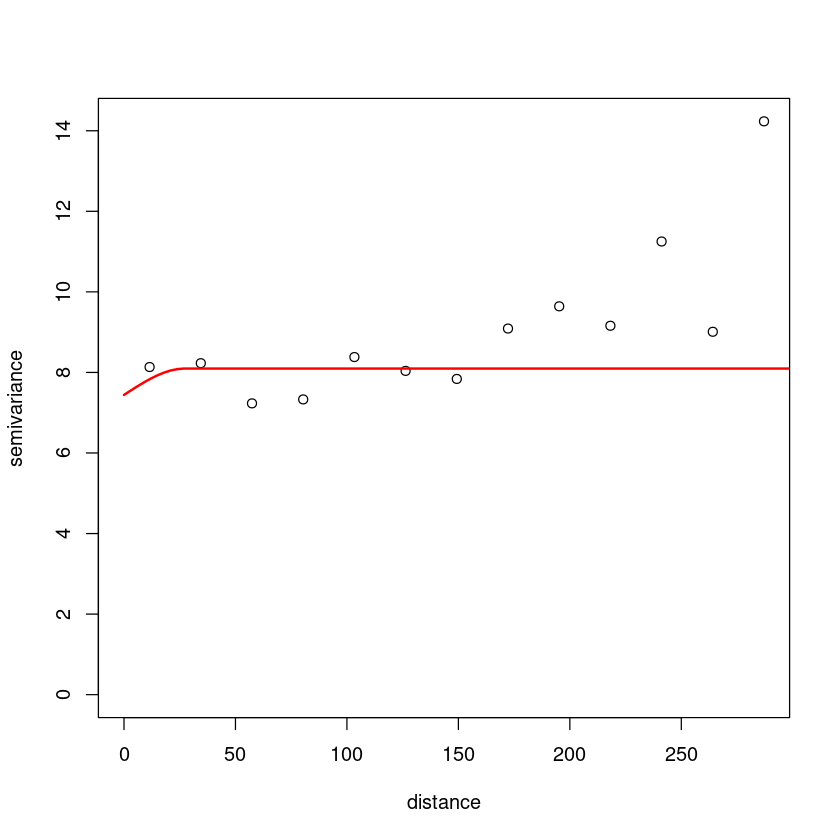

In [265]:
cord = coordinates(sd_14_prjtd)
rn = sd_14_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_14 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_14 = jitterDupCoords(gdt_14, max = jit_am)

vf_14 = variog(gdt_14, lambda = 0.343434343434343, trend = "1st")
plot(vf_14)

vgm_rn_lk_14 = likfit(geodata = gdt_14, trend = "1st",cov.model = "spherical", ini.cov.pars = c(8,70),nugget = 4, lambda = 0.343434343434343, lik.method = "ML", messages = FALSE)
vgm_rn_lk_14
summary(vgm_rn_lk_14)

# Add the fitted model
lines(vgm_rn_lk_14, col = "red", lwd = 2)

In [266]:
## Likfit Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


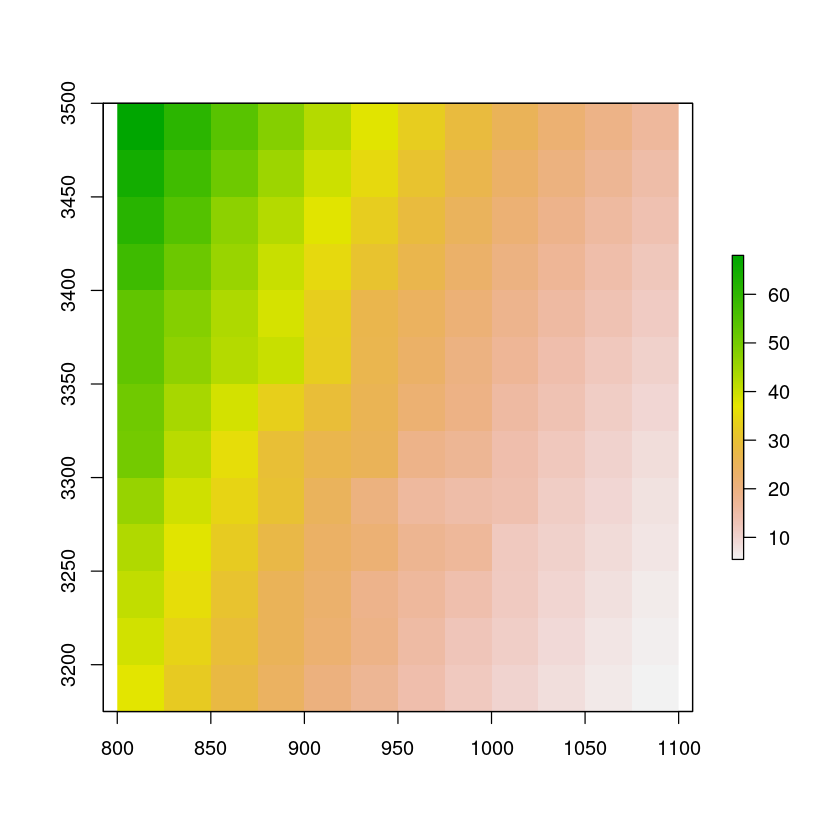

In [267]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_14 <- krige.conv(gdt_14, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_14))



krig_rain_lkft_14 <- krig_lkft_14$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_14 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_14))
proj4string(pr_rain_lkft_14) <- proj4string(grid_3sp)
plot(pr_rain_lkft_14)


In [268]:
## Regression

Generalized Linear Model 

87 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 78, 79, 78, 78, 78, 78, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  3.34811  0.1848017  2.757079

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-6.2411 -0.0206  0.0074 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0
      (estimated) cor. fct. parameter phi (range parameter)  =  0
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  8.115

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 0.0001159668

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-214.5"      "6"    "441"  "455.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-214.5"      "4"    "437"  "446.9" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = c

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


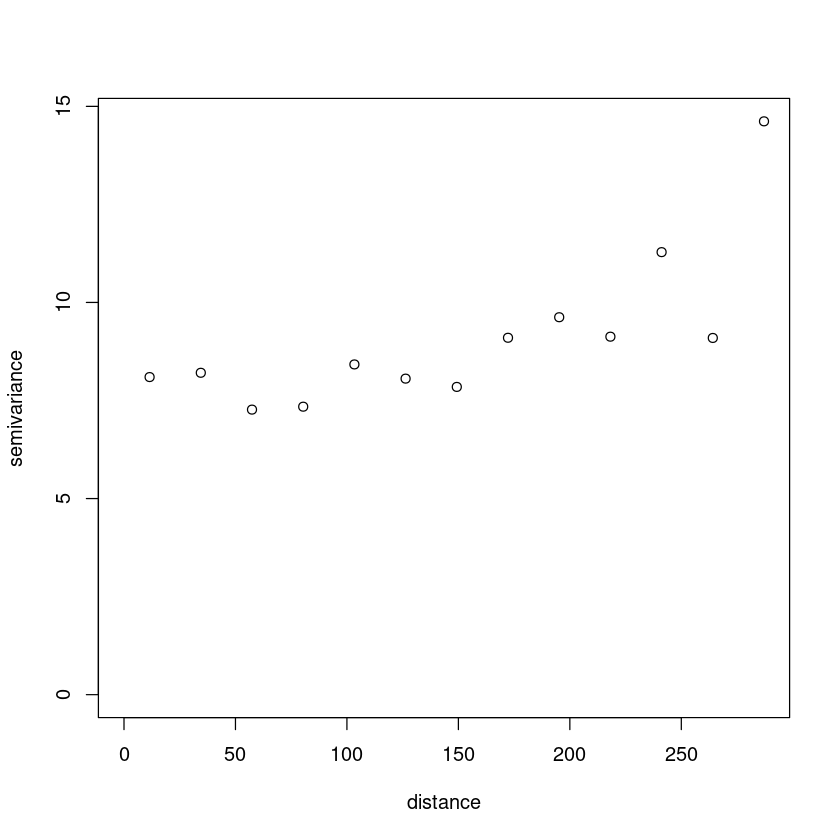

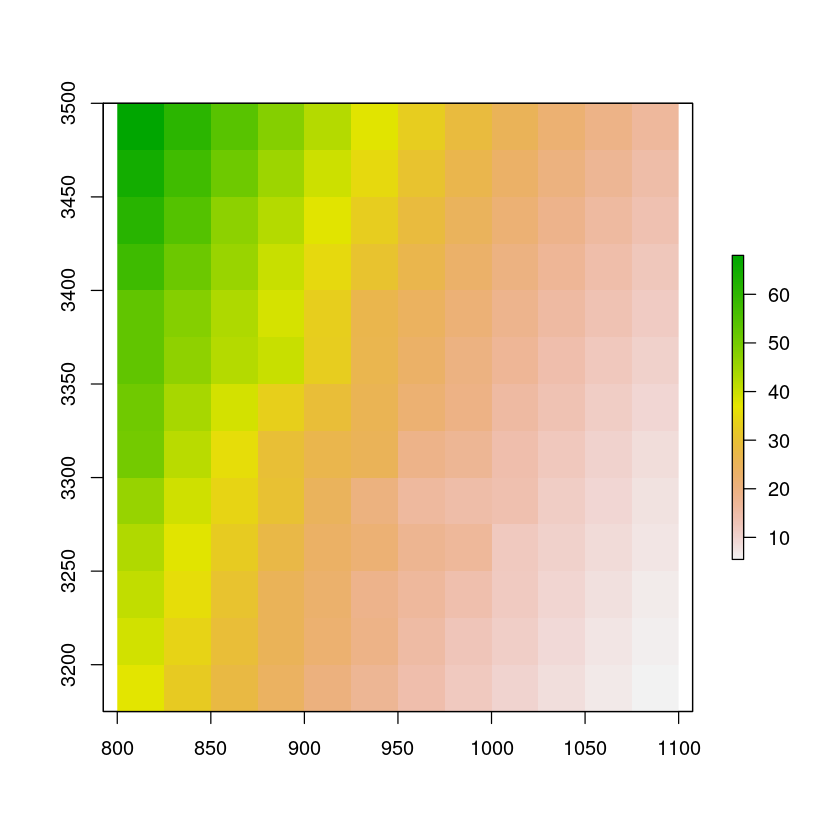

In [269]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_14 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_14))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_14 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(8, 70), 
                     nugget = 4, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_14)

krig_lkft_regr_14 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_14))

krig_regr_14 <- krig_lkft_14$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_14 <- rasterFromXYZ(cbind(grid_df, krig_regr_14))
proj4string(pr_regr_lkft_14) <- proj4string(grid_3sp)
plot(pr_regr_lkft_14)


DAY 15

In [270]:
f15 =  "/data/private/GPM/Data_1/July_2023_with_elev/processed_15_July_23.csv"

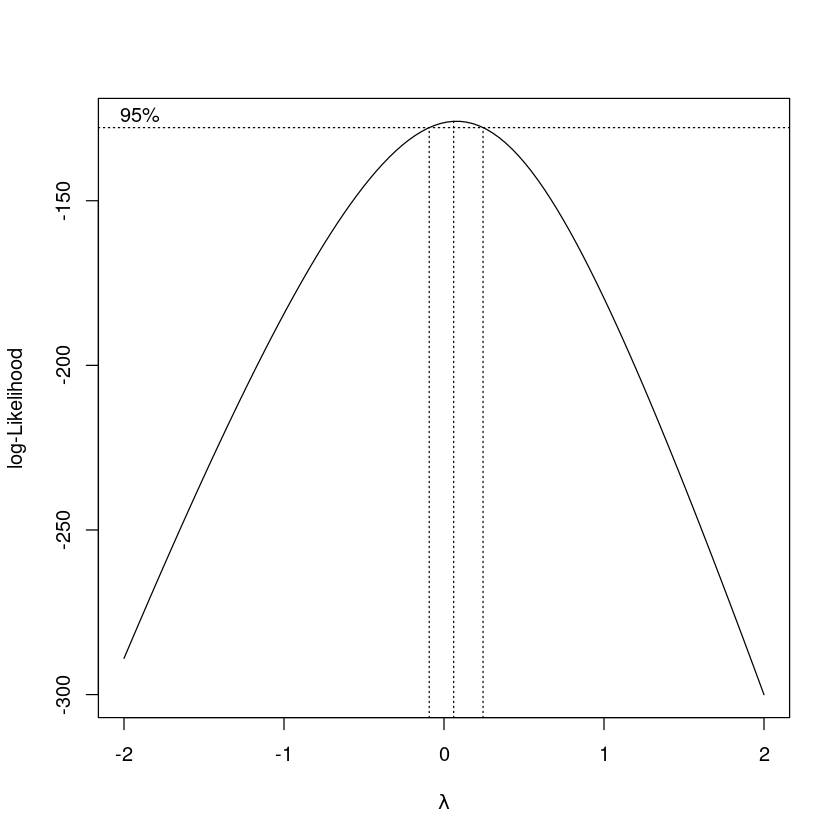

In [271]:
d15 = read.csv(f15)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d15$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d15$Rainfall_Transformed <- rain_transformed

In [272]:
lambda_rn

[1] 0.06060606

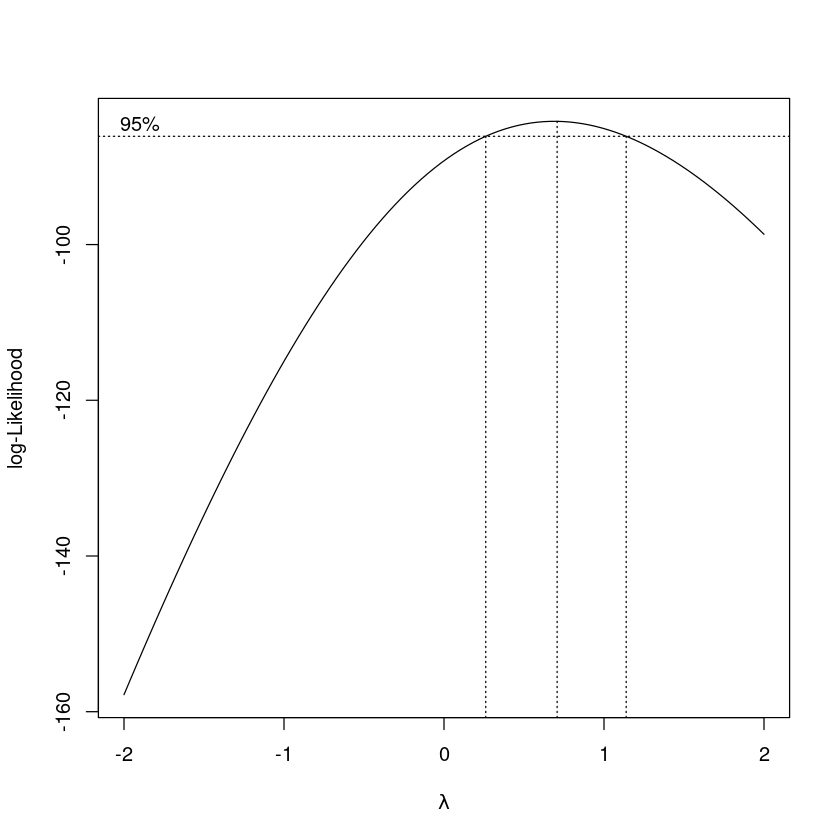

In [273]:
# Perform Box-Cox transformation on rainfall data
  elev <- d15$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d15$Elevation_Transformed <- el_transformed

In [274]:
coordinates1 = data.frame(lon = d15$Longitude, lat = d15$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d15_modb = subset(d15, select = -c(Longitude,Latitude))
sd_15 = SpatialPointsDataFrame(coords1,d15_modb)
class(sd_15)
proj4string(sd_15) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_15_prjtd <- spTransform(sd_15, CRS(desired_crs))
proj4string(sd_15_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

Warning message in fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat")):
“No convergence after 200 iterations: try different initial values?”


model psill     range    kappa ang1 ang2 ang3 anis1 anis2
1 Nug    236408.1    0.000 0.0   0    0    0    1     1    
2 Exp   9445895.7 3573.078 0.5   0    0    0    1     1

[1] -0.2161444

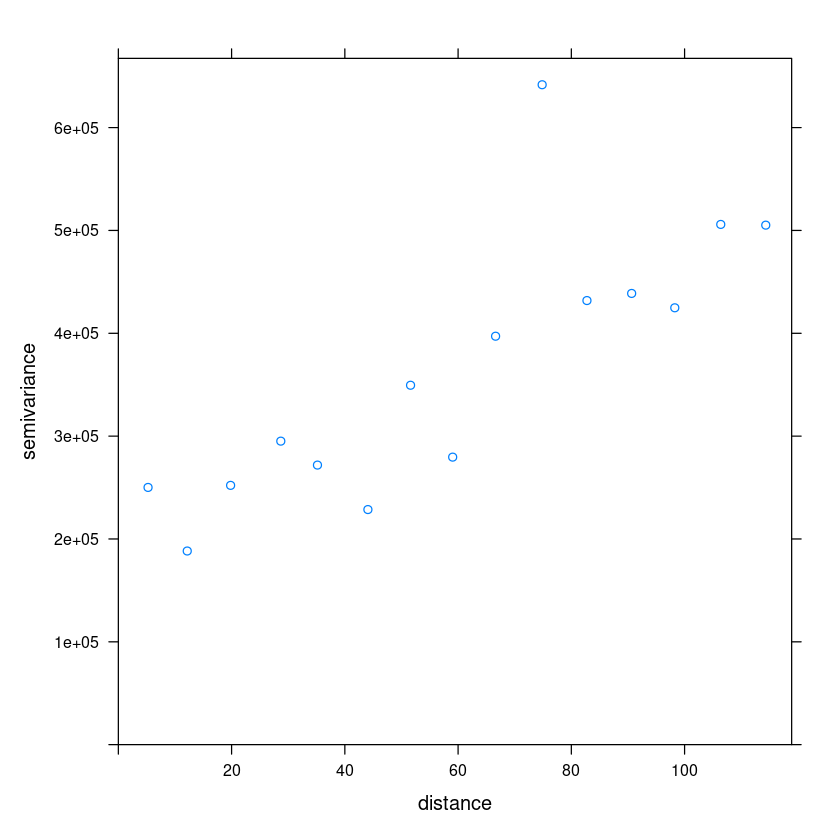

In [275]:
elev = d15$Elevation
elev_vgm = variogram(elev~1, data = sd_15_prjtd)
 plot(elev_vgm)
# fit1 = vgm(360778, "Exp", 13, 94767)
# fit_elev_vgm = fit.variogram(elev_vgm, fit1)
# plot(elev_vgm, model = fit_elev_vgm)
v = fit.variogram(elev_vgm, vgm("Exp", "Lin", " Sph", "Mat"))
v
cor(rain_transformed,elev)

In [276]:
## likfit var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"-5.2165" "-0.0023" " 0.0029" " 0.0000" " 2.7750" "14.5891" 
Practical Range with cor=0.05 for asymptotic range: 43.70506

likfit: maximised log-likelihood = -196.1

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-5.2165 -0.0023  0.0029 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  2.775
      (estimated) cor. fct. parameter phi (range parameter)  =  14.59
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 0.0606

Practical Range with cor=0.05 for asymptotic range: 43.70506

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-196.1"      "6"  "404.2"    "416" 

non spatial model:
   log.L n.params      AIC      BIC 
"-199.3"      "4"  "406.6"  "414.5" 

Call:
likfit(geodata = gdt_15, trend = "1st", ini.cov.pars = c(3, 50), 
    nugget =

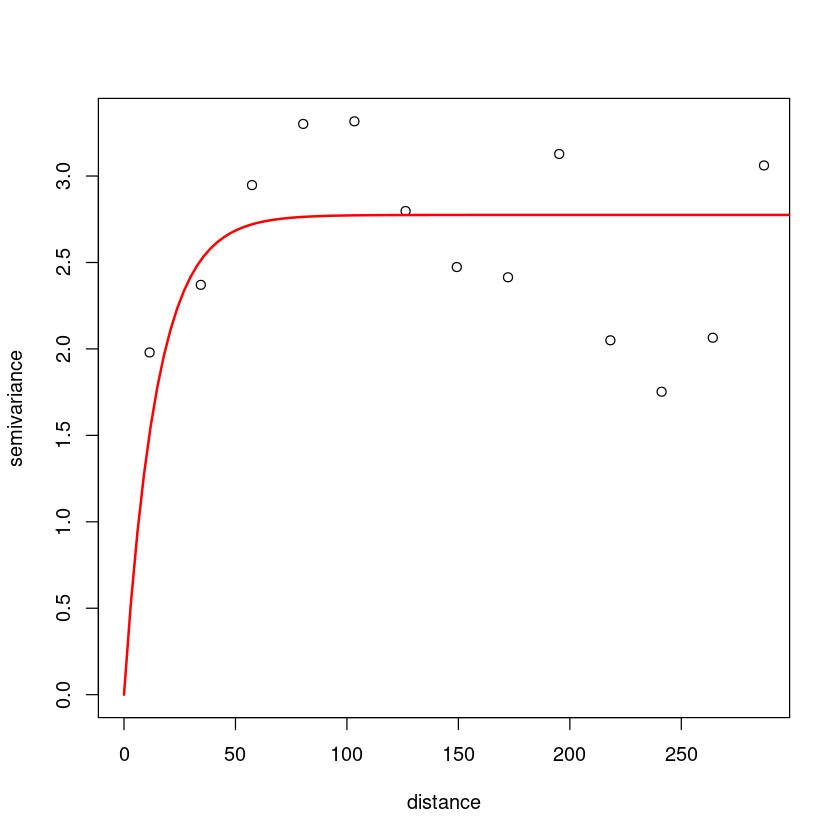

In [277]:
cord = coordinates(sd_15_prjtd)
rn = sd_15_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_15 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_15 = jitterDupCoords(gdt_15, max = jit_am)

vf_15 = variog(gdt_15, lambda = 0.060606060606061, trend = "1st")
plot(vf_15)
vgm_rn_lk_15 = likfit(geodata = gdt_15, trend = "1st",cov.model = "exponential", ini.cov.pars = c(3,50),nugget = 2, lambda = 0.060606060606061, lik.method = "ML", messages = FALSE)
vgm_rn_lk_15
summary(vgm_rn_lk_15)

# Add the fitted model
lines(vgm_rn_lk_15, col = "red", lwd = 2)

In [278]:
## Likfit Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


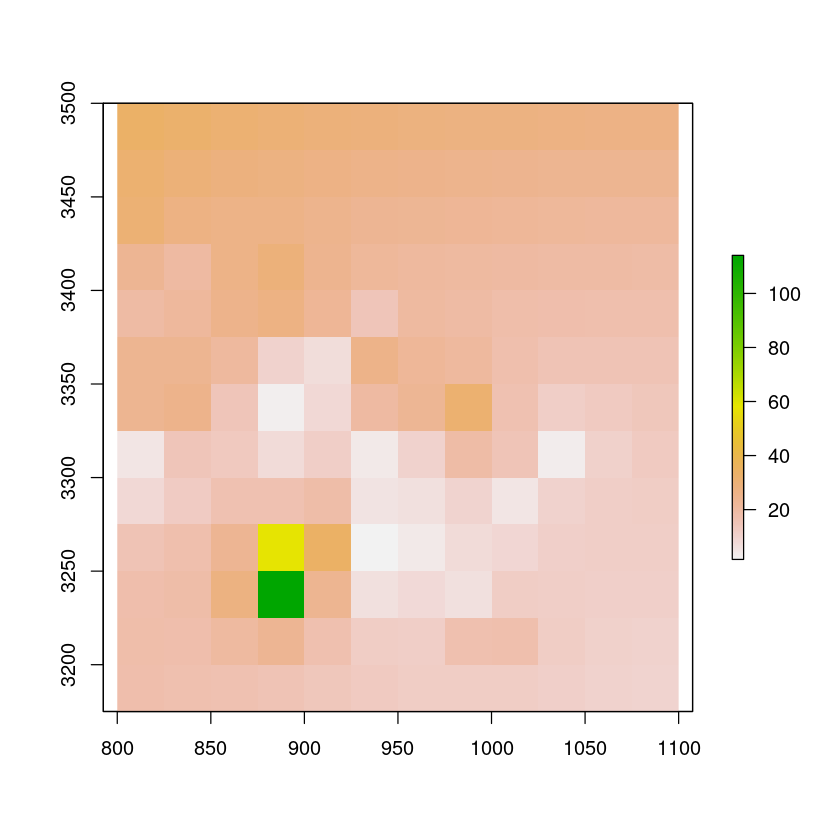

In [279]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_15 <- krige.conv(gdt_15, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_15))



krig_rain_lkft_15 <- krig_lkft_15$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_15 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_15))
proj4string(pr_rain_lkft_15) <- proj4string(grid_3sp)
plot(pr_rain_lkft_15)

In [280]:
## Regression

Generalized Linear Model 

53 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 47, 49, 47, 49, 48, 47, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.653265  0.2416352  1.388475

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-30.5335   0.0012   0.0089 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0
      (estimated) cor. fct. parameter phi (range parameter)  =  0
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.451

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 0.0001159668

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-98.96"      "6"  "209.9"  "221.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-98.96"      "4"  "205.9"  "213.8" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pa

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


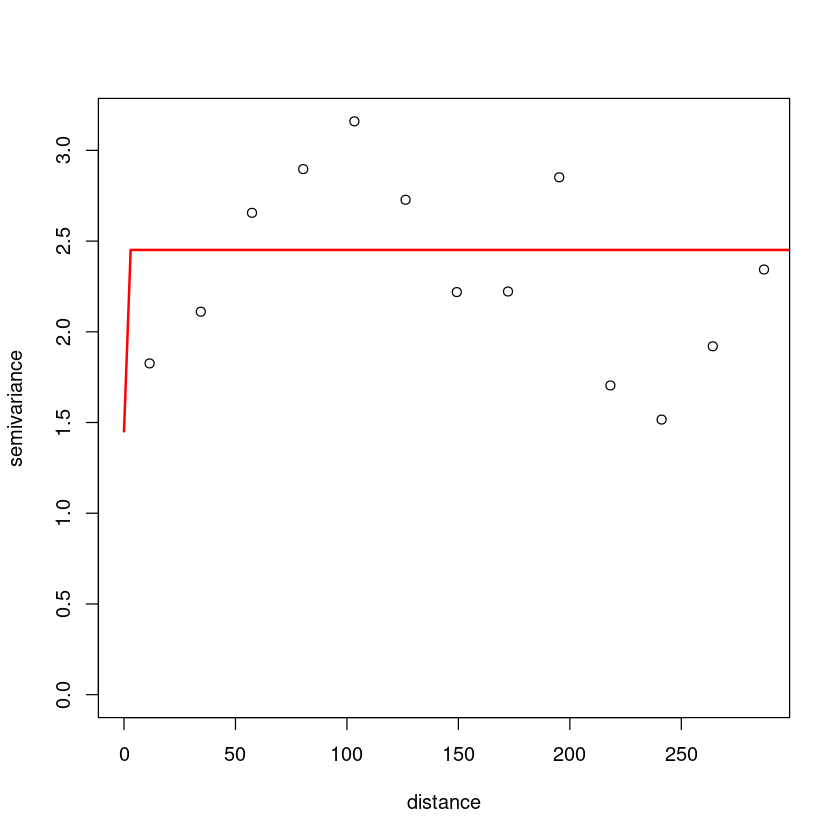

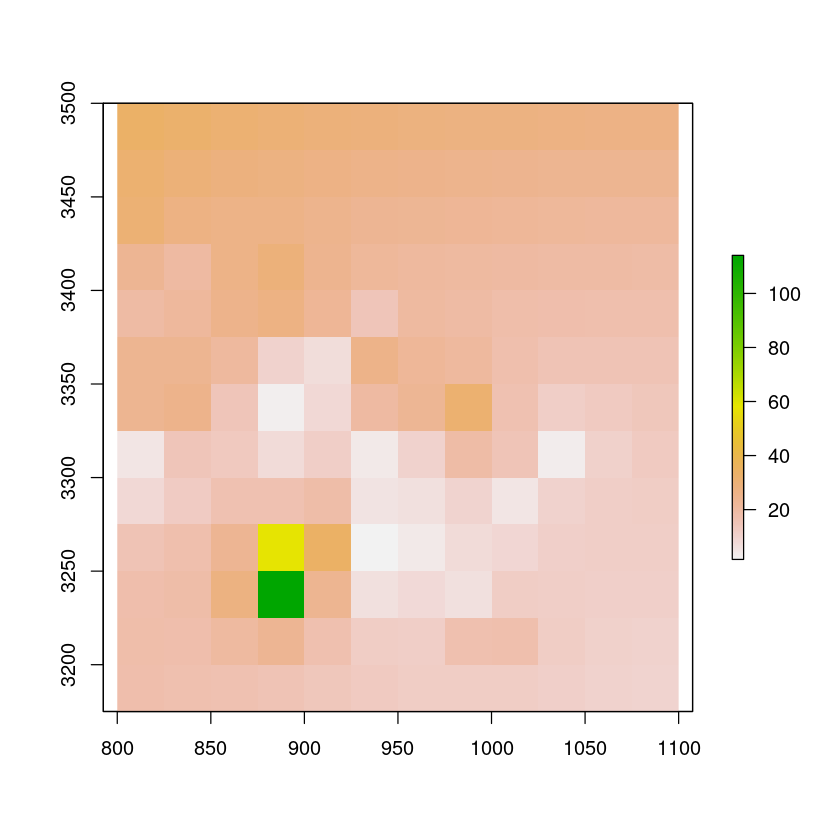

In [281]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_15 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_15))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_15 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(3, 60), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_15)
lines(vgm_res_lk_15, col = "red", lwd = 2)

krig_lkft_regr_15 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_15, trend.l = "1st"))

krig_regr_15 <- krig_lkft_15$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_15 <- rasterFromXYZ(cbind(grid_df, krig_regr_15))
proj4string(pr_regr_lkft_15) <- proj4string(grid_3sp)
plot(pr_regr_lkft_15)


DAY 16

In [282]:
f16 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_16_July_23.csv"

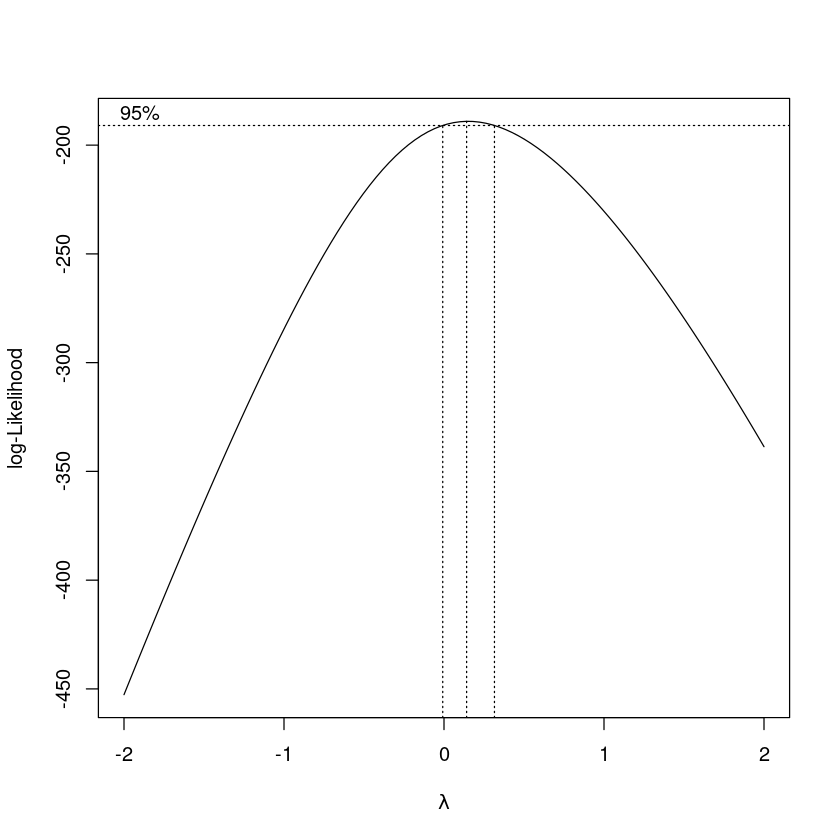

In [283]:
d16 = read.csv(f16)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d16$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d16$Rainfall_Transformed <- rain_transformed

In [284]:
lambda_rn

[1] 0.1414141

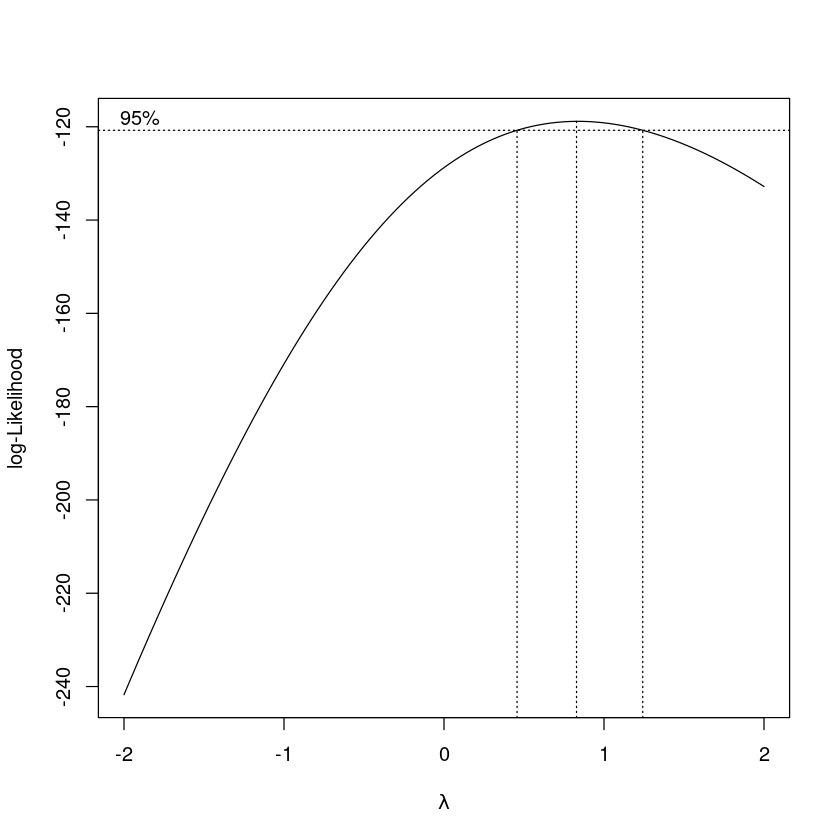

In [285]:
# Perform Box-Cox transformation on rainfall data
  elev <- d16$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d16$Elevation_Transformed <- el_transformed

In [286]:
coordinates1 = data.frame(lon = d16$Longitude, lat = d16$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d16_modb = subset(d16, select = -c(Longitude,Latitude))
sd_16 = SpatialPointsDataFrame(coords1,d16_modb)
class(sd_16)
proj4string(sd_16) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_16_prjtd <- spTransform(sd_16, CRS(desired_crs))
proj4string(sd_16_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [287]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-77.1189" "  0.0045" "  0.0227" "  0.6654" "  1.9831" " 13.6568" 
Practical Range with cor=0.05 for asymptotic range: 40.91216

likfit: maximised log-likelihood = -284.7

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-77.1189   0.0045   0.0227 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.983
      (estimated) cor. fct. parameter phi (range parameter)  =  13.66
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.6654

Transformation parameter:
      (fixed) Box-Cox parameter = 0.1414

Practical Range with cor=0.05 for asymptotic range: 40.91216

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-284.7"      "6"  "581.5"  "595.4" 

non spatial model:
   log.L n.params      AIC      BIC 
"-288.7"      "4"  "585.3"  "594.6" 

Call:
likfit(geodata = gdt_16, trend = "1st", ini.cov.pars = c(4, 70), 
 

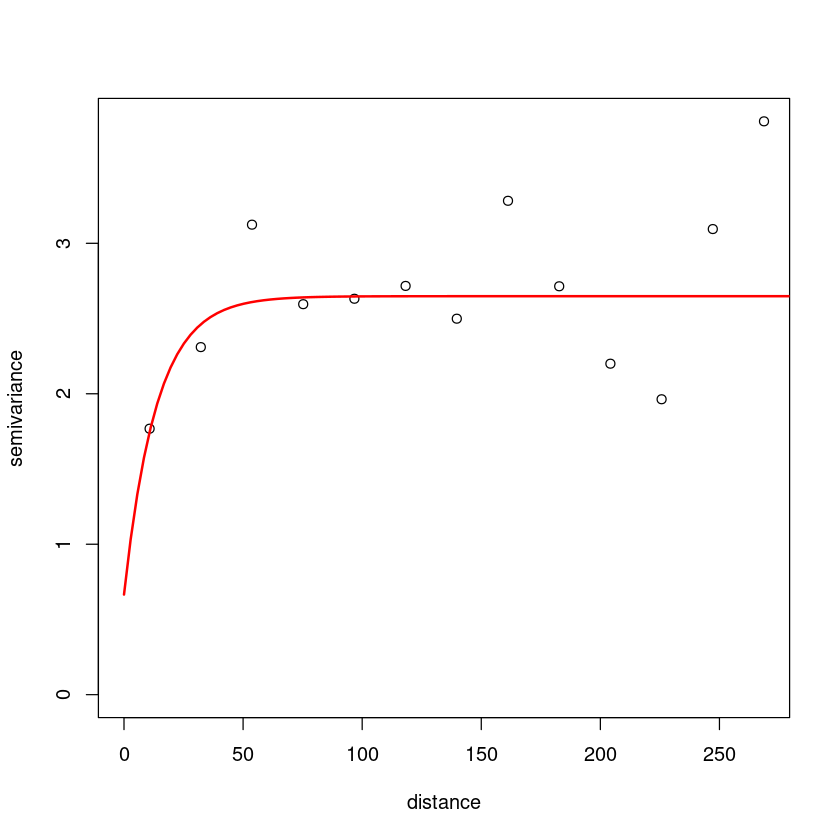

In [288]:
cord = coordinates(sd_16_prjtd)
rn = sd_16_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_16 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_16 = jitterDupCoords(gdt_16, max = jit_am)

vf_16 = variog(gdt_16, lambda = 0.141414141414141, trend = "1st")
plot(vf_16)

vgm_rn_lk_16 = likfit(geodata = gdt_16, trend = "1st",cov.model = "exponential", ini.cov.pars = c(4,70),nugget = 1, lambda = 0.141414141414141, lik.method = "ML", messages = FALSE)
vgm_rn_lk_16
summary(vgm_rn_lk_16)

# Add the fitted model
lines(vgm_rn_lk_16, col = "red", lwd = 2)

In [289]:
## krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


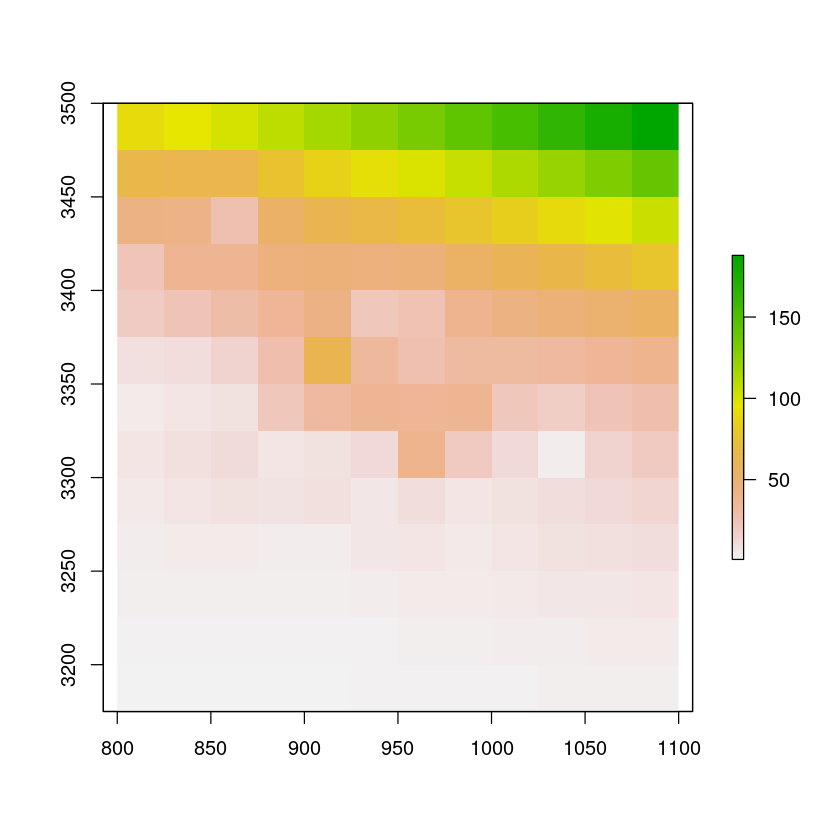

In [290]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_16 <- krige.conv(gdt_16, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_16))



krig_rain_lkft_16 <- krig_lkft_16$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_16 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_16))
proj4string(pr_rain_lkft_16) <- proj4string(grid_3sp)
plot(pr_rain_lkft_16)


In [291]:
## Regression

Generalized Linear Model 

76 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 68, 69, 69, 68, 68, 69, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  1.85202  0.1047154  1.599135

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-63.1787   0.0020   0.0183 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  1.273
      (estimated) cor. fct. parameter phi (range parameter)  =  25.38
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.585

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 43.9313

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-142.9"      "6"  "297.8"  "311.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-147.1"      "4"  "302.2"  "311.5" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pa

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


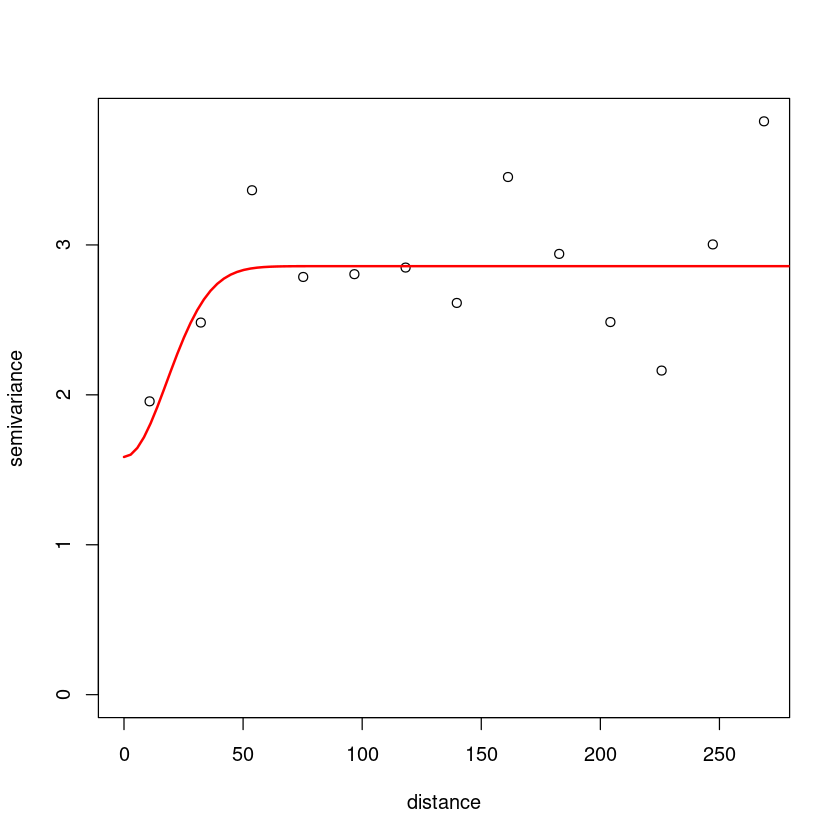

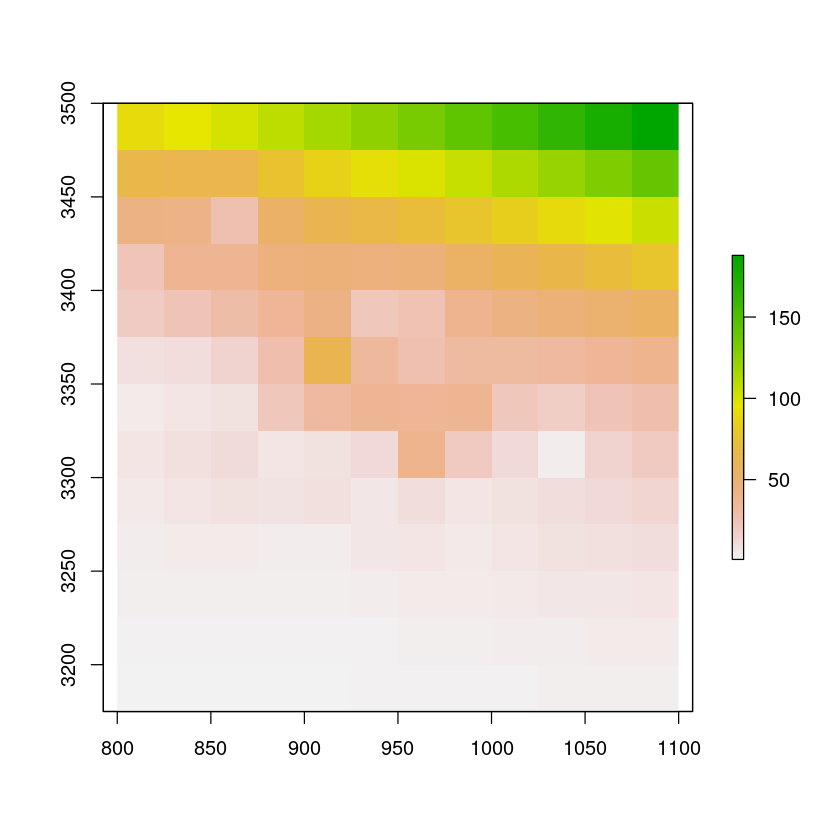

In [292]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_16 = resid(GLM)
# Filter the coordinates to match the rows used in the GLM model based on the index
cord_filtered <- cord[1:nrow(train.x), ]
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord_filtered, residuals = resd_glm_16))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_16 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "gaussian", 
                     ini.cov.pars = c(3, 80), 
                     nugget = 0.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_16)
lines(vgm_res_lk_16, col = "red", lwd = 2)

krig_lkft_regr_16 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_16))

krig_regr_16 <- krig_lkft_16$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_16 <- rasterFromXYZ(cbind(grid_df, krig_regr_16))
proj4string(pr_regr_lkft_16) <- proj4string(grid_3sp)
plot(pr_regr_lkft_16)


DAY 17

In [293]:
f17 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_17_July_23.csv"

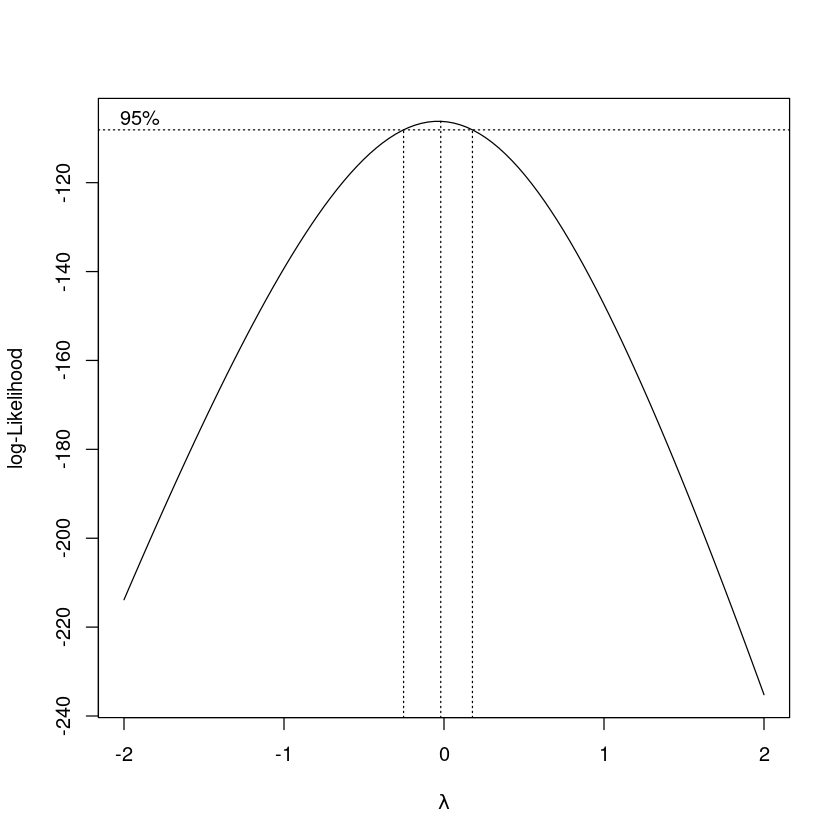

In [294]:
d17 = read.csv(f17)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d17$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d17$Rainfall_Transformed <- rain_transformed

In [295]:
lambda_rn

[1] -0.02020202

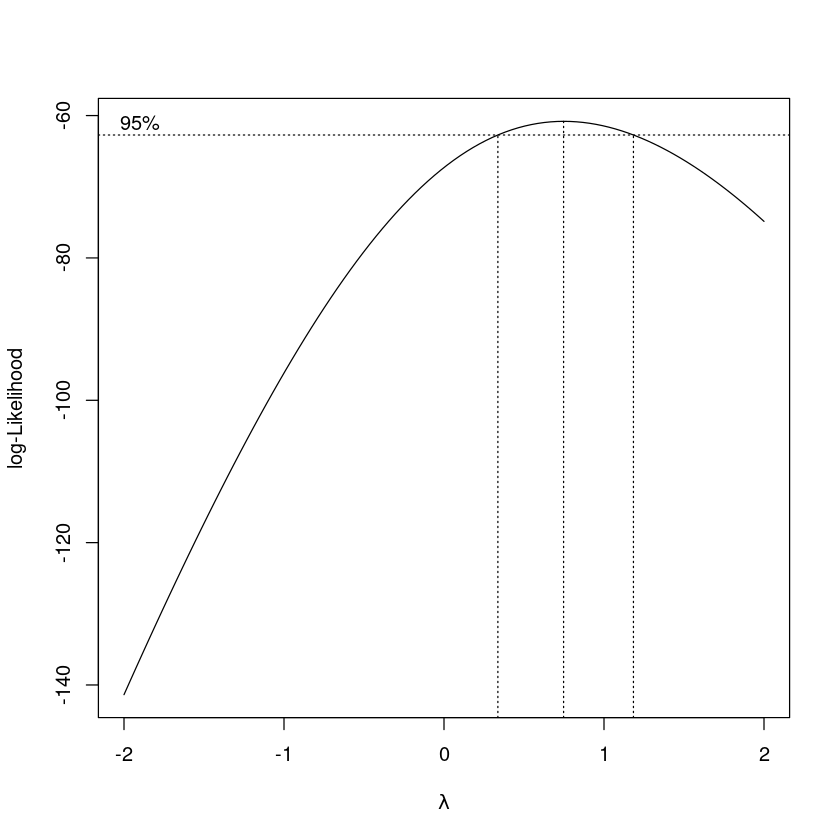

In [296]:
# Perform Box-Cox transformation on rainfall data
  elev <- d17$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d17$Elevation_Transformed <- el_transformed

In [297]:
coordinates1 = data.frame(lon = d17$Longitude, lat = d17$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d17_modb = subset(d17, select = -c(Longitude,Latitude))
sd_17 = SpatialPointsDataFrame(coords1,d17_modb)
class(sd_17)
proj4string(sd_17) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_17_prjtd <- spTransform(sd_17, CRS(desired_crs))
proj4string(sd_17_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [298]:
##Likfit vr

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"-2.7589" "-0.0037" " 0.0023" " 0.0000" " 2.4817" " 5.6675" 
Practical Range with cor=0.05 for asymptotic range: 9.809403

likfit: maximised log-likelihood = -159

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-2.7589 -0.0037  0.0023 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  2.482
      (estimated) cor. fct. parameter phi (range parameter)  =  5.668
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = -0.0202

Practical Range with cor=0.05 for asymptotic range: 9.809403

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-159"      "6"  "329.9"  "340.6" 

non spatial model:
   log.L n.params      AIC      BIC 
  "-160"      "4"  "327.9"    "335" 

Call:
likfit(geodata = gdt_17, trend = "1st", ini.cov.pars = c(3, 100), 
    nugget = 

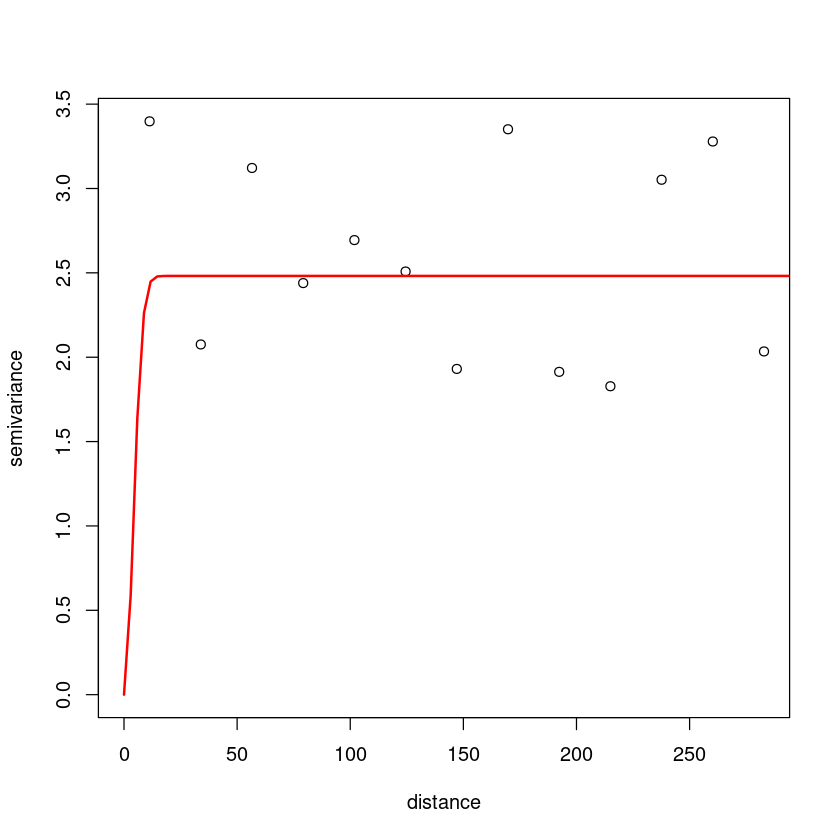

In [299]:
cord = coordinates(sd_17_prjtd)
rn = sd_17_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_17 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_17 = jitterDupCoords(gdt_17, max = jit_am)

vf_17 = variog(gdt_17, lambda = -0.0202020202020201, trend = "1st")
plot(vf_17)

vgm_rn_lk_17 = likfit(geodata = gdt_17, trend = "1st",cov.model = "gaussian", ini.cov.pars = c(3,100),nugget = 1, lambda = -0.0202020202020201, lik.method = "ML", messages = FALSE)
vgm_rn_lk_17
summary(vgm_rn_lk_17)

# Add the fitted model
lines(vgm_rn_lk_17, col = "red", lwd = 2)

In [300]:
## krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


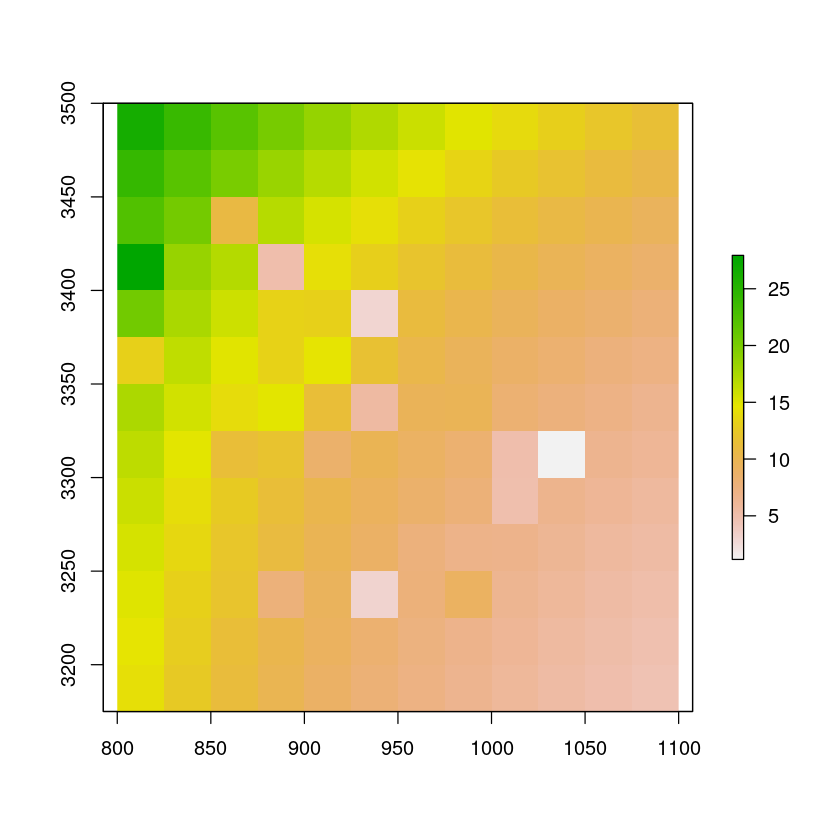

In [301]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_17 <- krige.conv(gdt_17, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_17, trend.l = "1st"))



krig_rain_lkft_17 <- krig_lkft_17$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_17 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_17))
proj4string(pr_rain_lkft_17) <- proj4string(grid_3sp)
plot(pr_rain_lkft_17)

In [302]:
## Regression

Generalized Linear Model 

44 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 39, 39, 41, 40, 40, 39, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.704162  0.2528854  1.556837

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-6.4353 -0.0035  0.0028 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  0
      (estimated) cor. fct. parameter phi (range parameter)  =  0
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.494

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 0.0001159668

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-82.54"      "6"  "177.1"  "187.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-82.54"      "4"  "173.1"  "180.2" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = c(3,

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


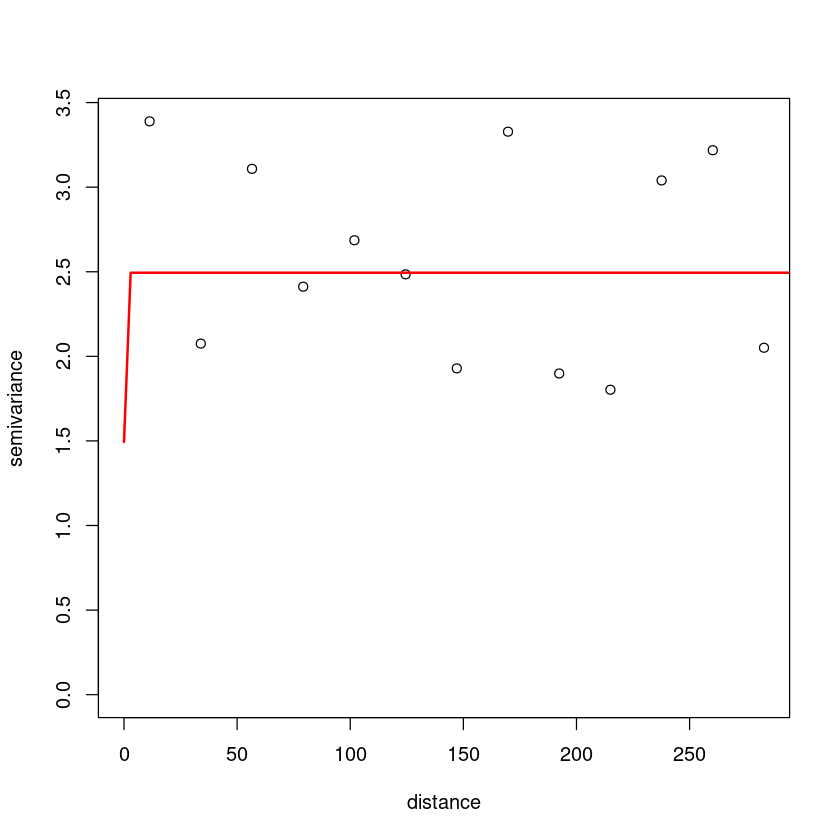

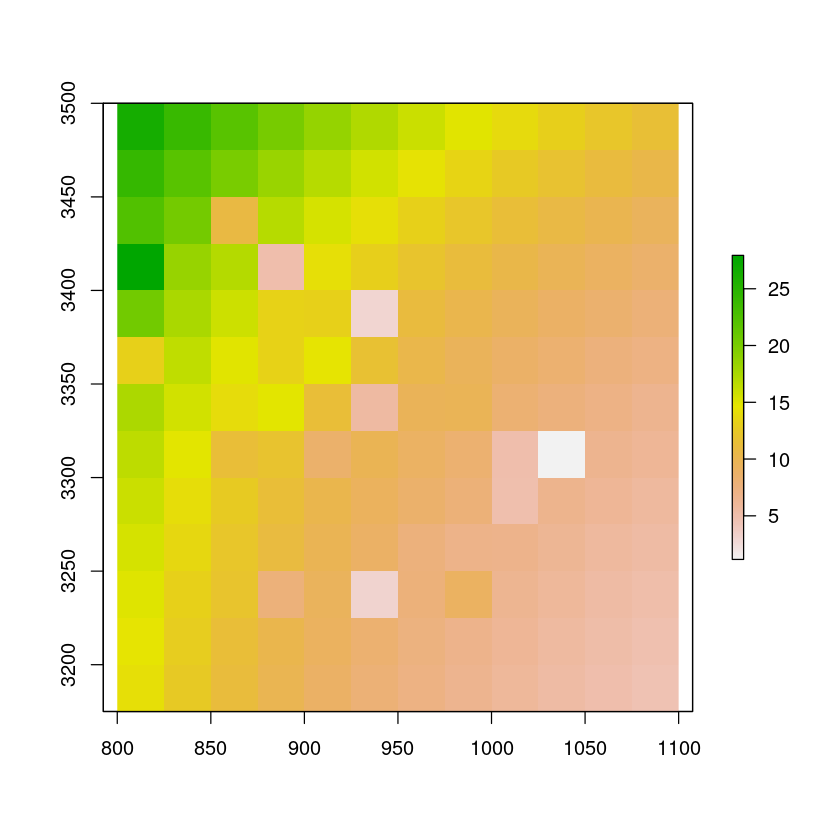

In [303]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_17 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_17))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_17 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "gaussian", 
                     ini.cov.pars = c(3, 70), 
                     nugget = 0.01, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_17)
lines(vgm_res_lk_17, col = "red", lwd = 2)

krig_lkft_regr_17 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_17))

krig_regr_17 <- krig_lkft_17$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_17 <- rasterFromXYZ(cbind(grid_df, krig_regr_17))
proj4string(pr_regr_lkft_17) <- proj4string(grid_3sp)
plot(pr_regr_lkft_17)


DAY 18

In [304]:
f18 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_18_July_23.csv"

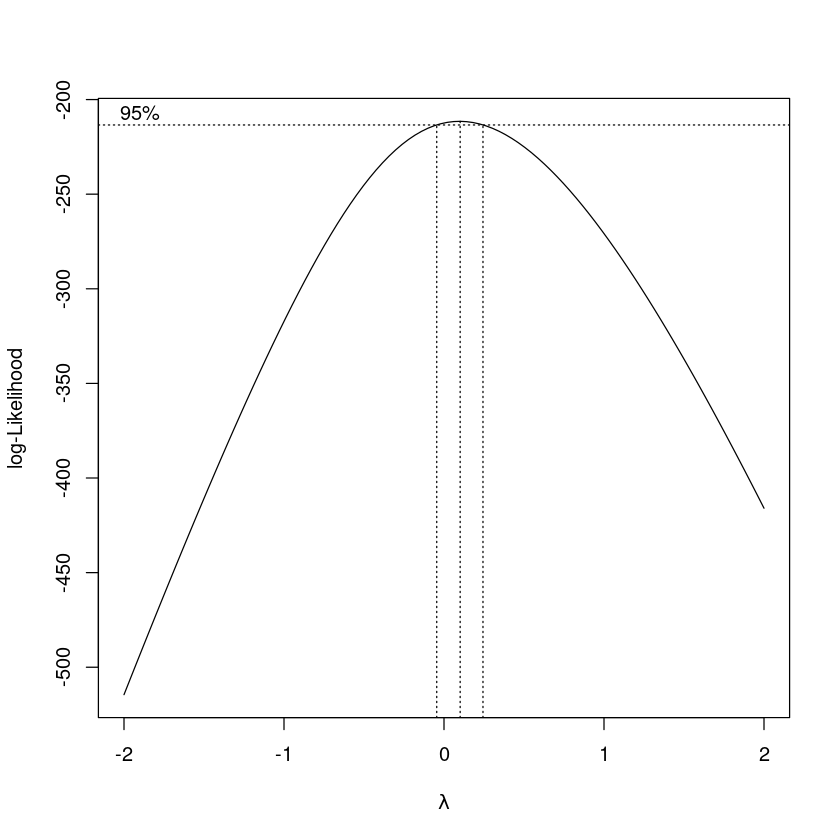

In [305]:
d18 = read.csv(f18)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d18$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d18$Rainfall_Transformed <- rain_transformed

In [306]:
lambda_rn

[1] 0.1010101

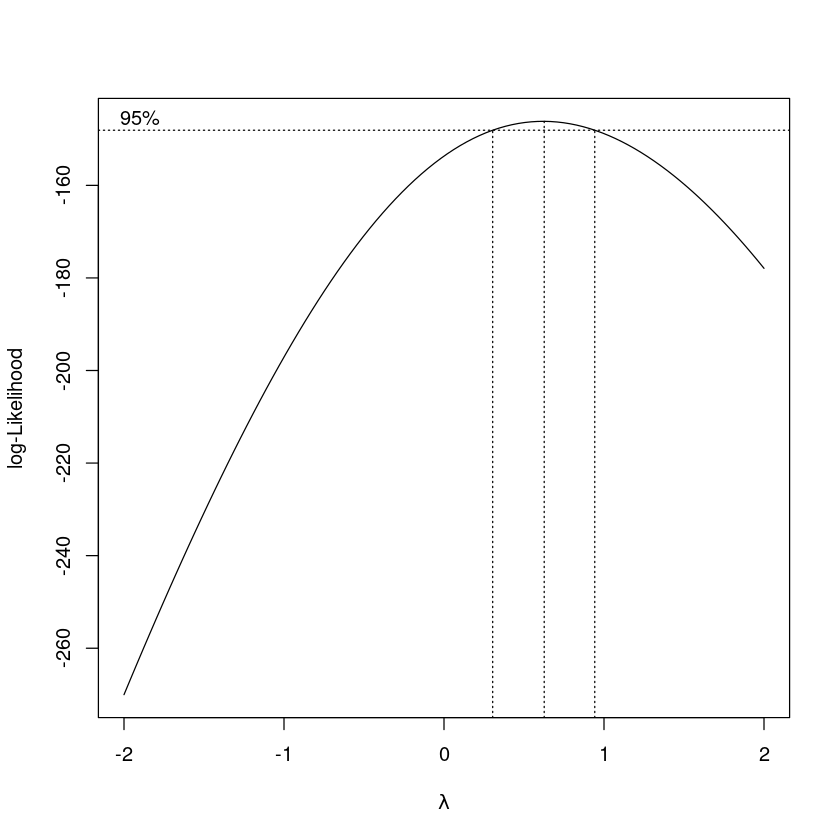

In [307]:
# Perform Box-Cox transformation on rainfall data
  elev <- d18$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d18$Elevation_Transformed <- el_transformed

In [308]:
coordinates1 = data.frame(lon = d18$Longitude, lat = d18$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d18_modb = subset(d18, select = -c(Longitude,Latitude))
sd_18 = SpatialPointsDataFrame(coords1,d18_modb)
class(sd_18)
proj4string(sd_18) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_18_prjtd <- spTransform(sd_18, CRS(desired_crs))
proj4string(sd_18_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [309]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"19.0258" "-0.0055" "-0.0034" " 0.2116" " 3.2064" "13.8635" 
Practical Range with cor=0.05 for asymptotic range: 41.5314

likfit: maximised log-likelihood = -336.7

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
19.0258 -0.0055 -0.0034 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  3.206
      (estimated) cor. fct. parameter phi (range parameter)  =  13.86
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.2116

Transformation parameter:
      (fixed) Box-Cox parameter = 0.101

Practical Range with cor=0.05 for asymptotic range: 41.5314

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-336.7"      "6"  "685.4"  "699.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-344.3"      "4"  "696.5"  "706.2" 

Call:
likfit(geodata = gdt_18, trend = "1st", ini.cov.pars = c(3.5, 
    50), nug

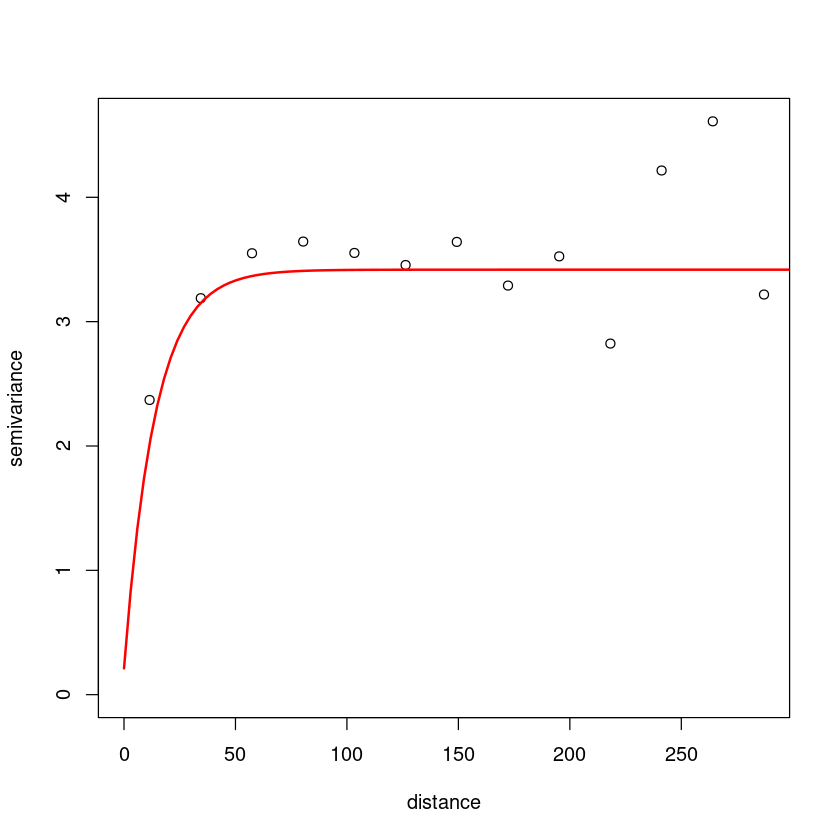

In [310]:
cord = coordinates(sd_18_prjtd)
rn = sd_18_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_18 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_18 = jitterDupCoords(gdt_18, max = jit_am)

vf_18 = variog(gdt_18, lambda = 0.101010101010101, trend = "1st")
plot(vf_18)
vgm_rn_lk_18 = likfit(geodata = gdt_18, trend = "1st",cov.model = "exponential", ini.cov.pars = c(3.5,50),nugget = 1.5, lambda = 0.101010101010101, lik.method = "ML", messages = FALSE)
vgm_rn_lk_18
summary(vgm_rn_lk_18)

# Add the fitted model
lines(vgm_rn_lk_18, col = "red", lwd = 2)

In [311]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


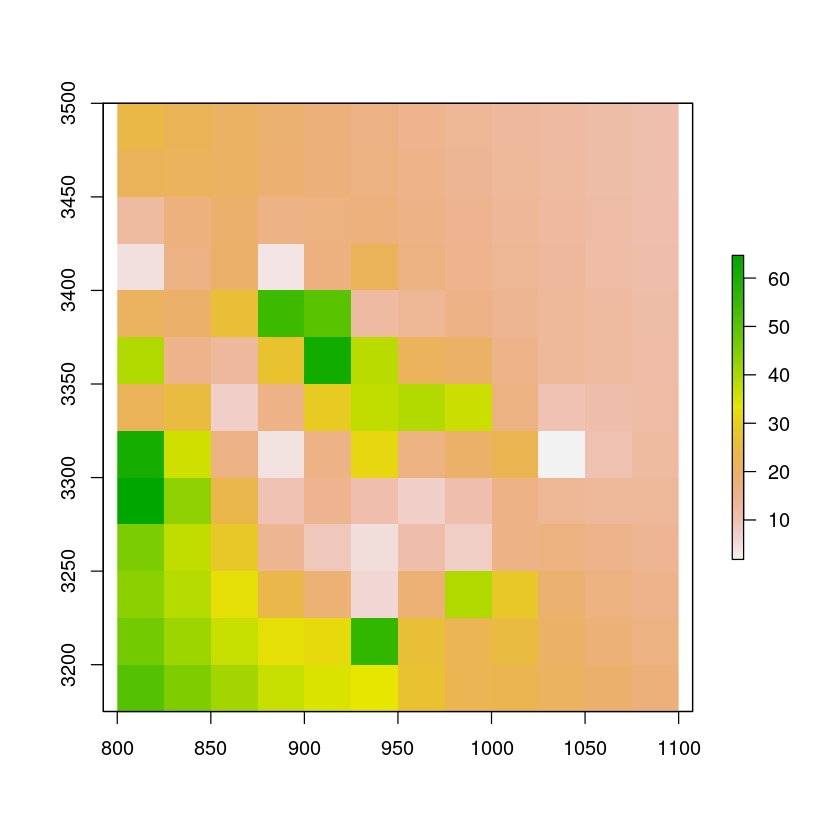

In [312]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_18 <- krige.conv(gdt_18, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_18))



krig_rain_lkft_18 <- krig_lkft_18$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_18 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_18))
proj4string(pr_rain_lkft_18) <- proj4string(grid_3sp)
plot(pr_rain_lkft_18)

In [313]:
## Regression

Generalized Linear Model 

82 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 74, 75, 73, 73, 74, 73, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  1.863152  0.118322  1.561915

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
 5.4039 -0.0042 -0.0005 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  3.253
      (estimated) cor. fct. parameter phi (range parameter)  =  12.5
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.1194

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 37.4599

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-159.4"      "6"  "330.8"  "345.2" 

non spatial model:
   log.L n.params      AIC      BIC 
"-166.4"      "4"  "340.7"  "350.3" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars 

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


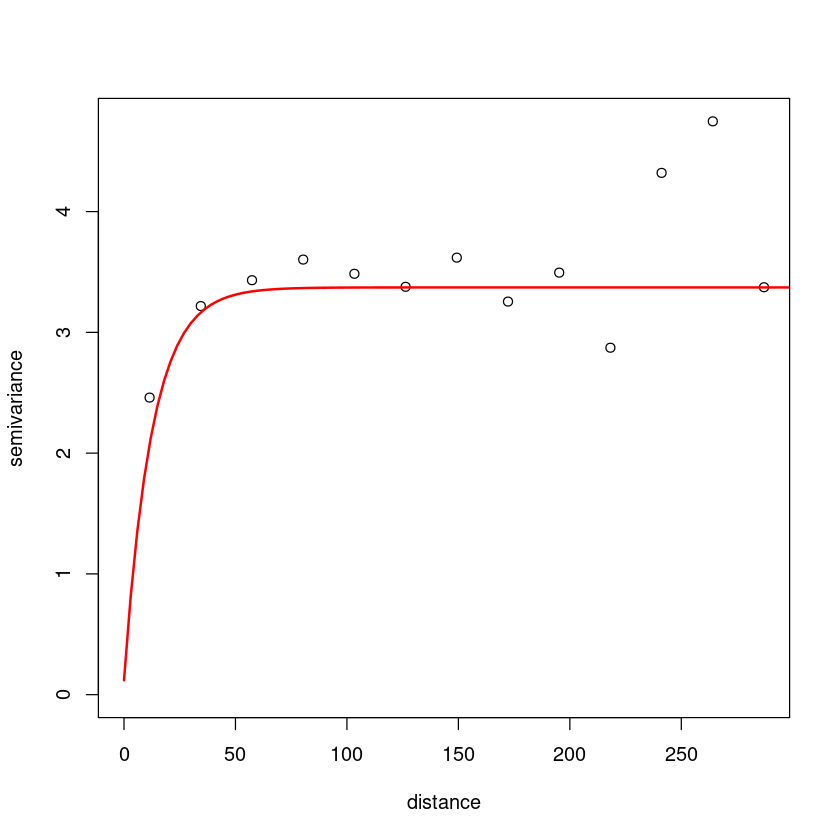

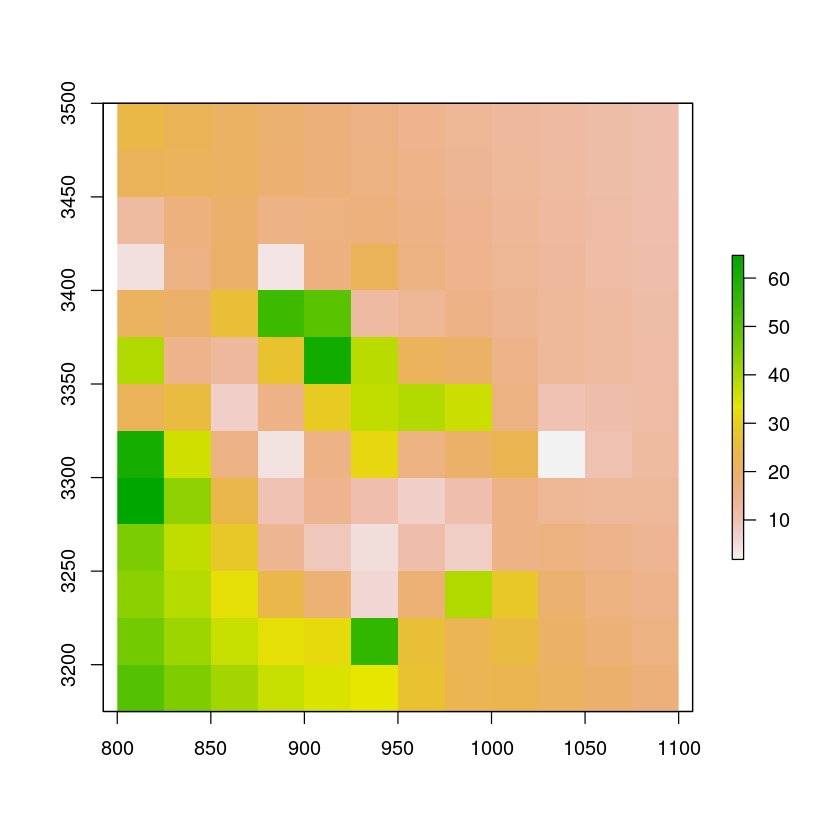

In [314]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_18 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_18))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_18 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(3.5, 60), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_18)
lines(vgm_res_lk_18, col = "red", lwd = 2)

krig_lkft_regr_18 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_18))

krig_regr_18 <- krig_lkft_18$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_18 <- rasterFromXYZ(cbind(grid_df, krig_regr_18))
proj4string(pr_regr_lkft_18) <- proj4string(grid_3sp)
plot(pr_regr_lkft_18)


DAY 19

In [315]:
f19 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_19_July_23.csv"

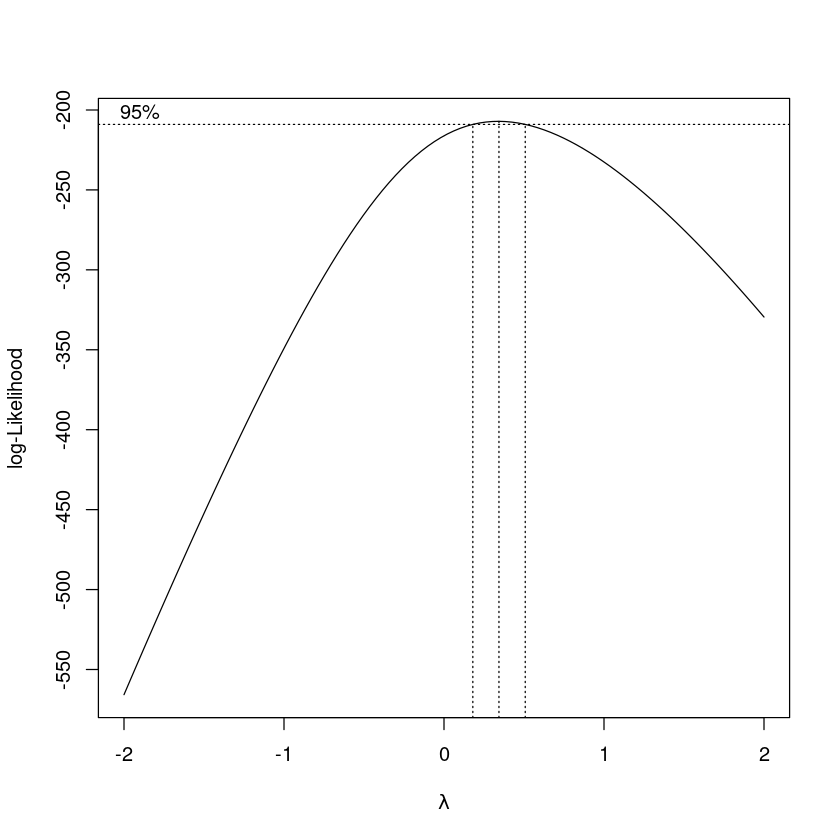

In [316]:
d19 = read.csv(f19)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d19$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d19$Rainfall_Transformed <- rain_transformed

In [317]:
lambda_rn

[1] 0.3434343

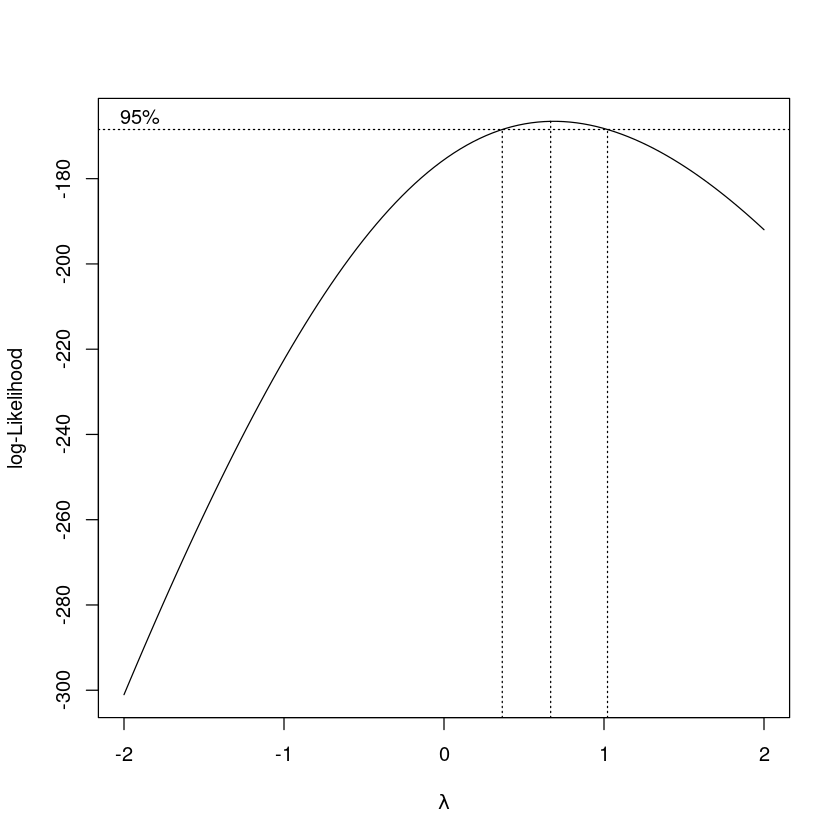

In [318]:
# Perform Box-Cox transformation on rainfall data
  elev <- d19$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d19$Elevation_Transformed <- el_transformed

In [319]:
coordinates1 = data.frame(lon = d19$Longitude, lat = d19$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d19_modb = subset(d19, select = -c(Longitude,Latitude))
sd_19 = SpatialPointsDataFrame(coords1,d19_modb)
class(sd_19)
proj4string(sd_19) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_19_prjtd <- spTransform(sd_19, CRS(desired_crs))
proj4string(sd_19_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [320]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"51.5540" "-0.0090" "-0.0119" " 0.1486" " 5.0319" "11.4322" 
Practical Range with cor=0.05 for asymptotic range: 34.24776

likfit: maximised log-likelihood = -339

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
51.5540 -0.0090 -0.0119 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  5.032
      (estimated) cor. fct. parameter phi (range parameter)  =  11.43
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.1486

Transformation parameter:
      (fixed) Box-Cox parameter = 0.3434

Practical Range with cor=0.05 for asymptotic range: 34.24776

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-339"      "6"    "690"  "705.1" 

non spatial model:
   log.L n.params      AIC      BIC 
"-344.1"      "4"  "696.1"  "706.2" 

Call:
likfit(geodata = gdt_19, trend = "1st", ini.cov.pars = c(4, 80), 
    nug

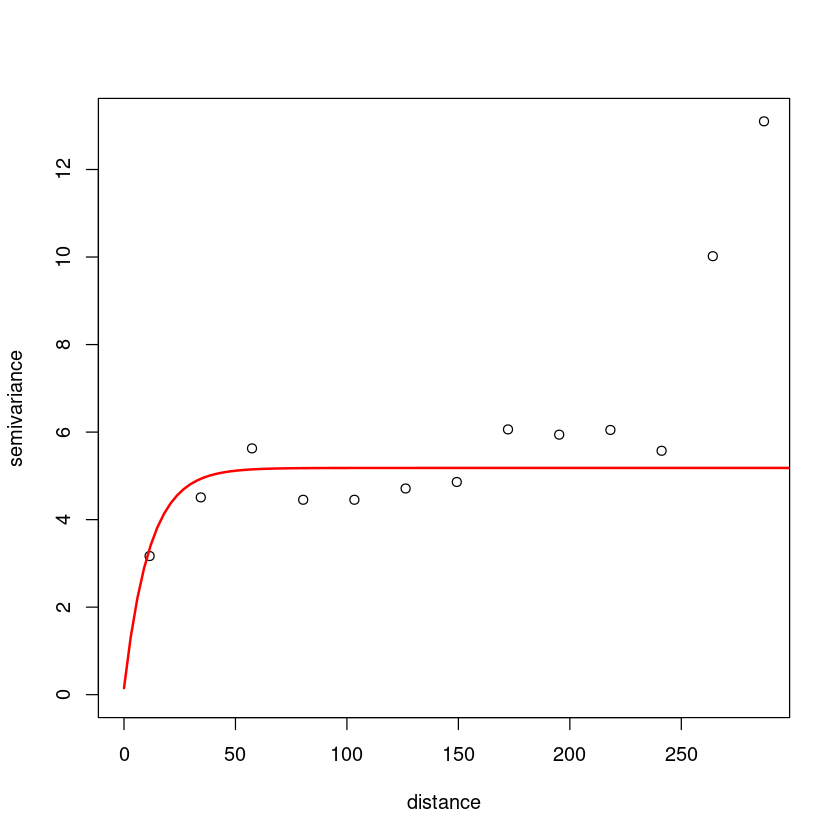

In [321]:
cord = coordinates(sd_19_prjtd)
rn = sd_19_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_19 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_19 = jitterDupCoords(gdt_19, max = jit_am)

vf_19 = variog(gdt_19, lambda = 0.343434343434343, trend = "1st")
plot(vf_19)
vgm_rn_lk_19 = likfit(geodata = gdt_19, trend = "1st",cov.model = "exponential", ini.cov.pars = c(4,80),nugget = 1.5, lambda = 0.343434343434343, lik.method = "ML", messages = FALSE)
vgm_rn_lk_19
summary(vgm_rn_lk_19)

# Add the fitted model
lines(vgm_rn_lk_19, col = "red", lwd = 2)

In [322]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


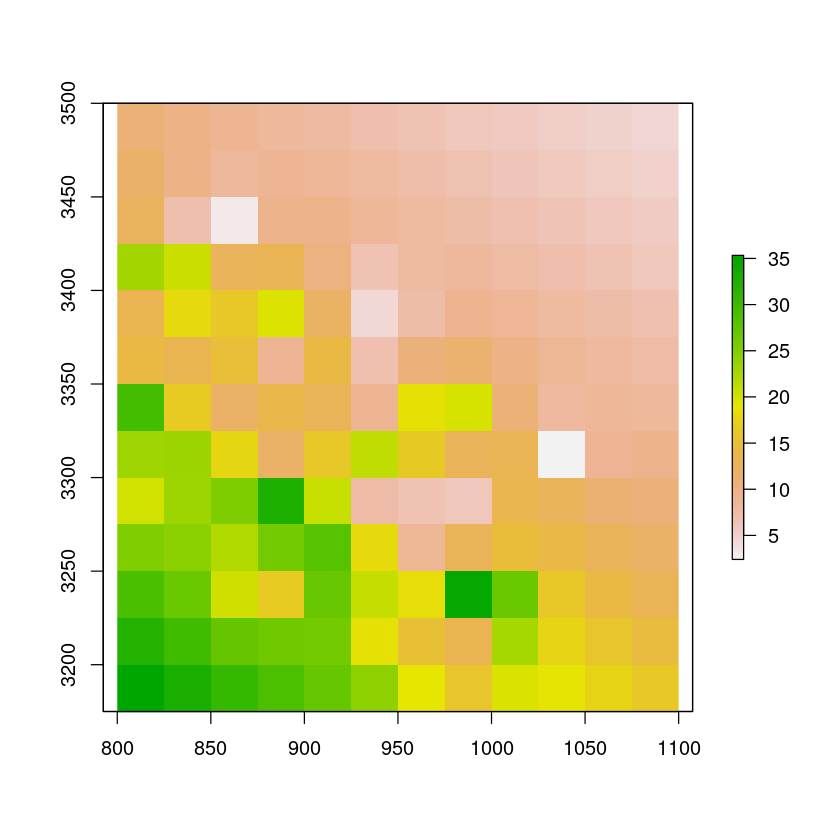

In [323]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_19 <- krige.conv(gdt_19, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_19))



krig_rain_lkft_19 <- krig_lkft_19$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_19 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_19))
proj4string(pr_rain_lkft_19) <- proj4string(grid_3sp)
plot(pr_rain_lkft_19)


In [324]:
#Regression

Generalized Linear Model 

91 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 81, 83, 80, 80, 83, 81, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  2.233745  0.1873557  1.853428

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
21.9883 -0.0060 -0.0050 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  4.907
      (estimated) cor. fct. parameter phi (range parameter)  =  10.83
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.2306

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 32.43

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-197.6"      "6"  "407.3"  "422.3" 

non spatial model:
   log.L n.params      AIC      BIC 
"-202.1"      "4"  "412.1"  "422.1" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars =

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


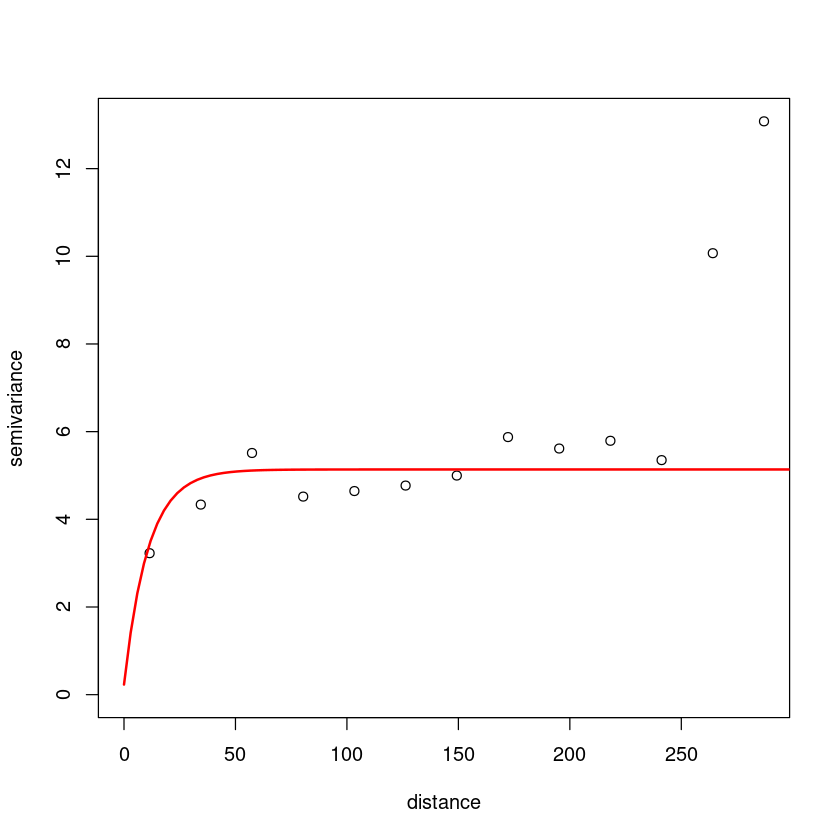

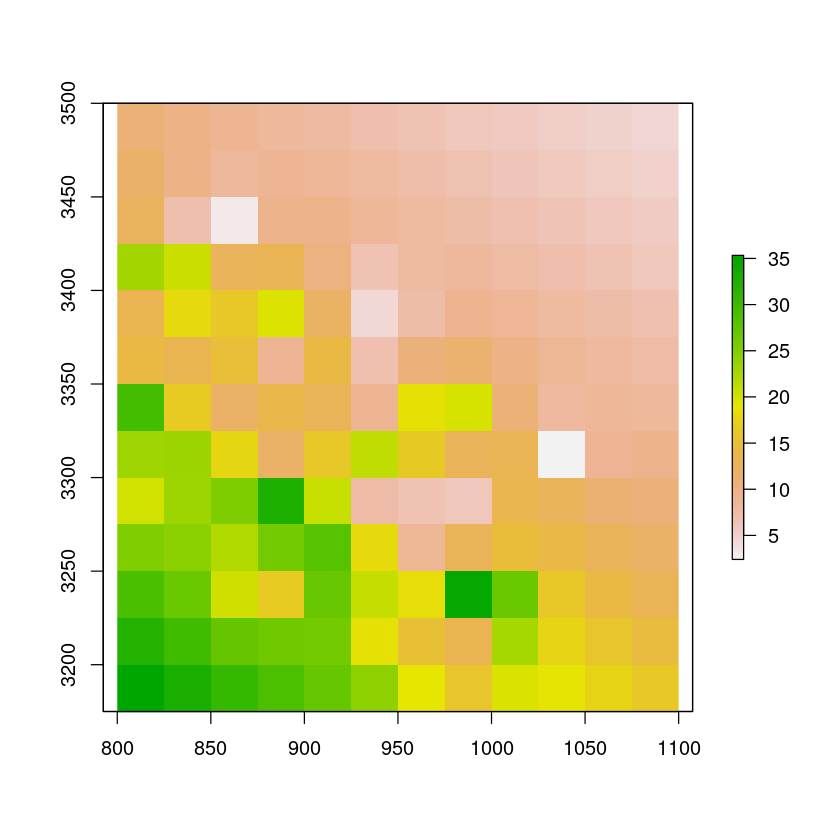

In [325]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_19 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_19))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_19 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(5, 60), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_19)
lines(vgm_res_lk_19, col = "red", lwd = 2)

krig_lkft_regr_19 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_19))

krig_regr_19 <- krig_lkft_19$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_19 <- rasterFromXYZ(cbind(grid_df, krig_regr_19))
proj4string(pr_regr_lkft_19) <- proj4string(grid_3sp)
plot(pr_regr_lkft_19)


DAY 20

In [326]:
f20 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_20_July_23.csv"

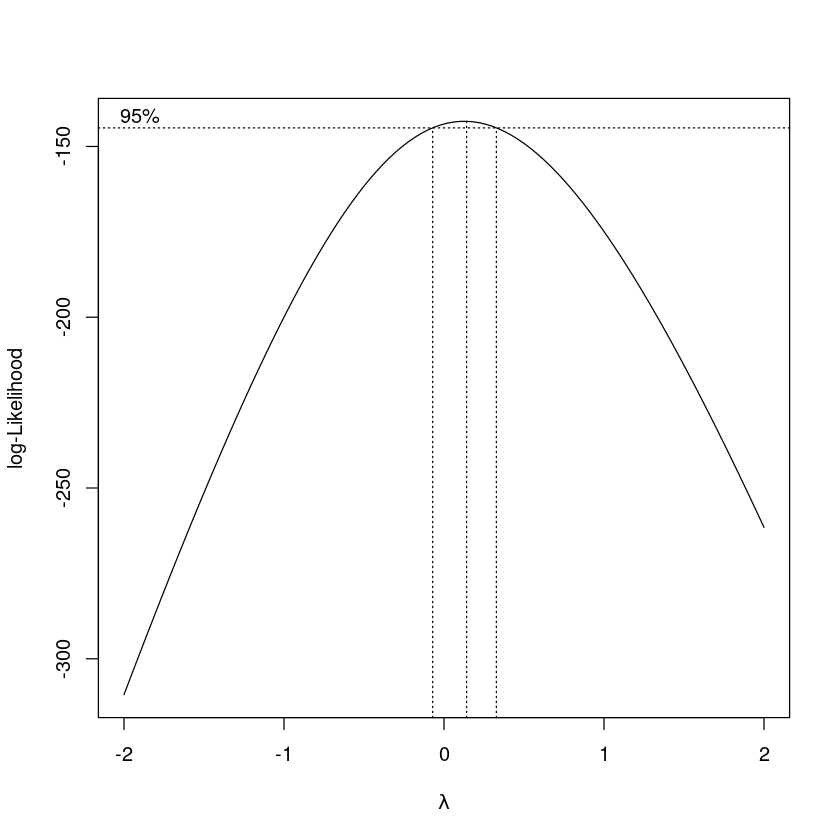

In [327]:
d20 = read.csv(f20)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d20$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d20$Rainfall_Transformed <- rain_transformed

In [328]:
lambda_rn

[1] 0.1414141

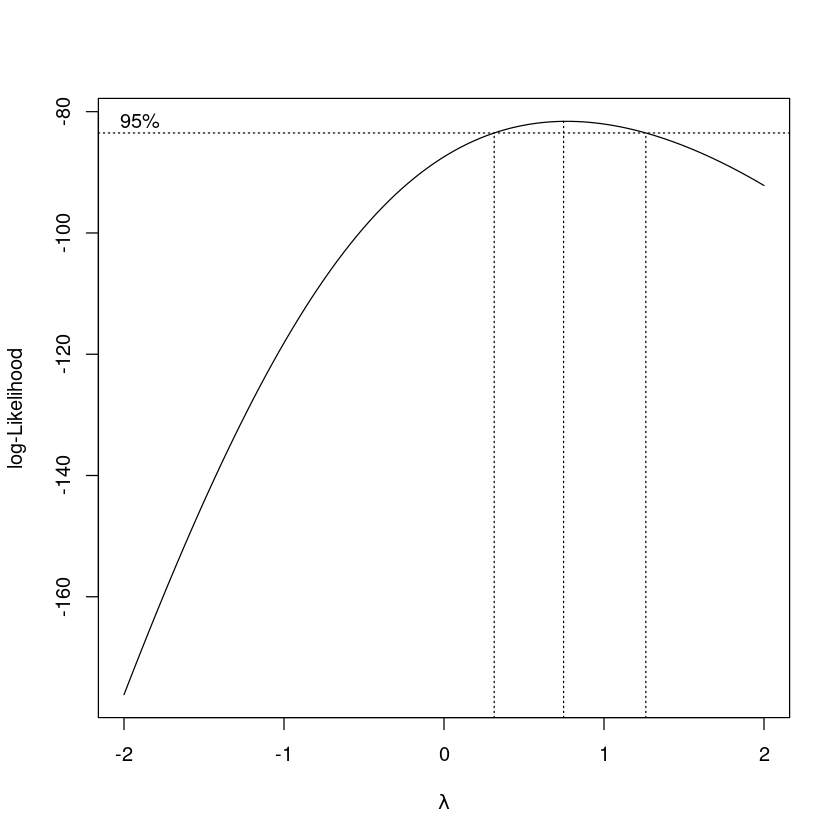

In [329]:
# Perform Box-Cox transformation on rainfall data
  elev <- d20$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d20$Elevation_Transformed <- el_transformed

In [330]:
coordinates1 = data.frame(lon = d20$Longitude, lat = d20$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d20_modb = subset(d20, select = -c(Longitude,Latitude))
sd_20 = SpatialPointsDataFrame(coords1,d20_modb)
class(sd_20)
proj4string(sd_20) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_20_prjtd <- spTransform(sd_20, CRS(desired_crs))
proj4string(sd_20_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [331]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-62.5693" " -0.0026" "  0.0200" "  0.8332" "  0.8993" " 19.7453" 
Practical Range with cor=0.05 for asymptotic range: 59.1517

likfit: maximised log-likelihood = -198

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-62.5693  -0.0026   0.0200 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0.8993
      (estimated) cor. fct. parameter phi (range parameter)  =  19.75
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.8332

Transformation parameter:
      (fixed) Box-Cox parameter = 0.1414

Practical Range with cor=0.05 for asymptotic range: 59.1517

Maximised Likelihood:
   log.L n.params      AIC      BIC 
  "-198"      "6"  "407.9"  "420.6" 

non spatial model:
   log.L n.params      AIC      BIC 
"-200.6"      "4"  "409.2"  "417.6" 

Call:
likfit(geodata = gdt_20, trend = "1st", ini.cov.pars = c(2, 90), 
 

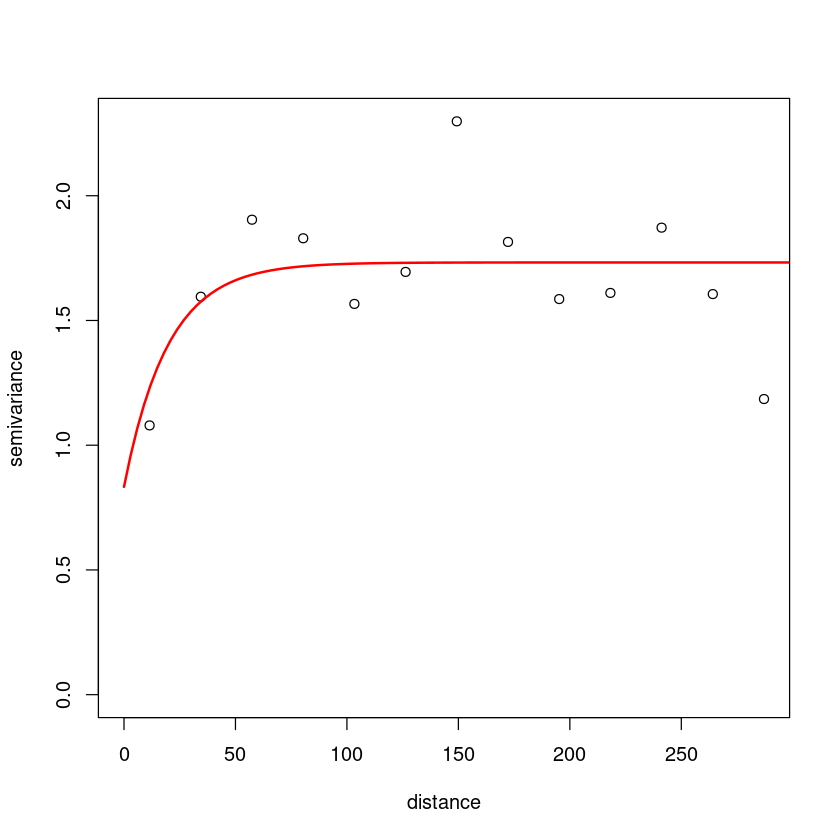

In [332]:
cord = coordinates(sd_20_prjtd)
rn = sd_20_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_20 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_20 = jitterDupCoords(gdt_20, max = jit_am)

vf_20 = variog(gdt_20, lambda = 0.141414141414141, trend = "1st")
plot(vf_20)
vgm_rn_lk_20 = likfit(geodata = gdt_20, trend = "1st",cov.model = "exponential", ini.cov.pars = c(2,90),nugget = 1, lambda = 0.141414141414141, lik.method = "ML", messages = FALSE)
vgm_rn_lk_20
summary(vgm_rn_lk_20)

# Add the fitted model
lines(vgm_rn_lk_20, col = "red", lwd = 2)

In [333]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


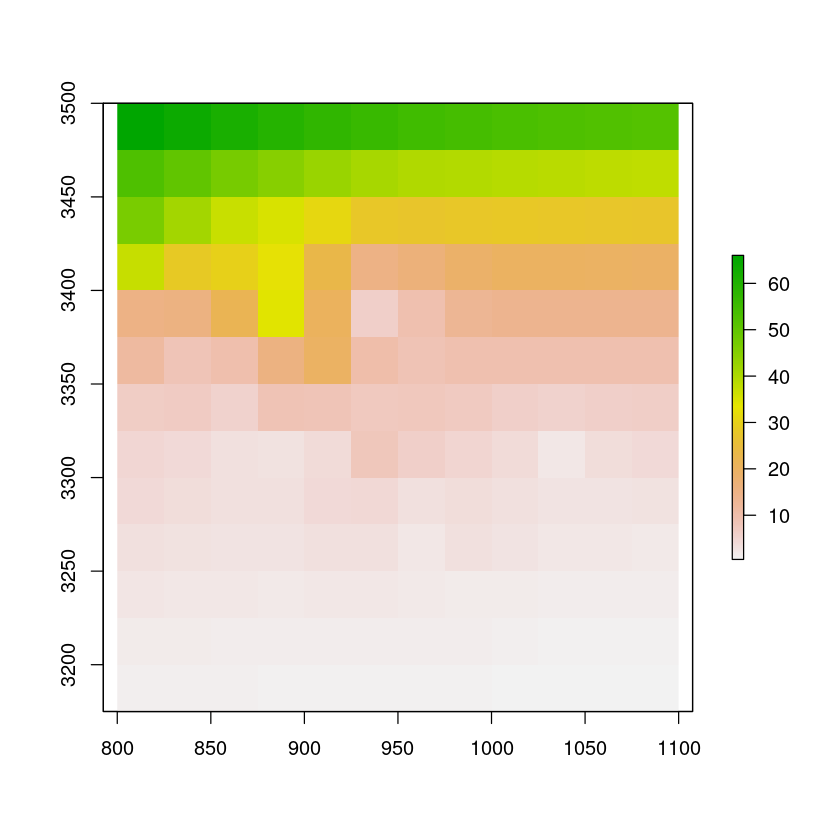

In [334]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_20 <- krige.conv(gdt_20, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_20))



krig_rain_lkft_20 <- krig_lkft_20$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_20 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_20))
proj4string(pr_rain_lkft_20) <- proj4string(grid_3sp)
plot(pr_rain_lkft_20)

In [335]:
## Regression

Generalized Linear Model 

61 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 55, 54, 55, 54, 56, 56, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  1.65944  0.2053521  1.388873

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-38.5453  -0.0064   0.0131 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.003
      (estimated) cor. fct. parameter phi (range parameter)  =  22.62
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.7015

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 67.76954

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-98.35"      "6"  "208.7"  "221.4" 

non spatial model:
   log.L n.params      AIC      BIC 
"-102.8"      "4"  "213.5"    "222" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.c

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


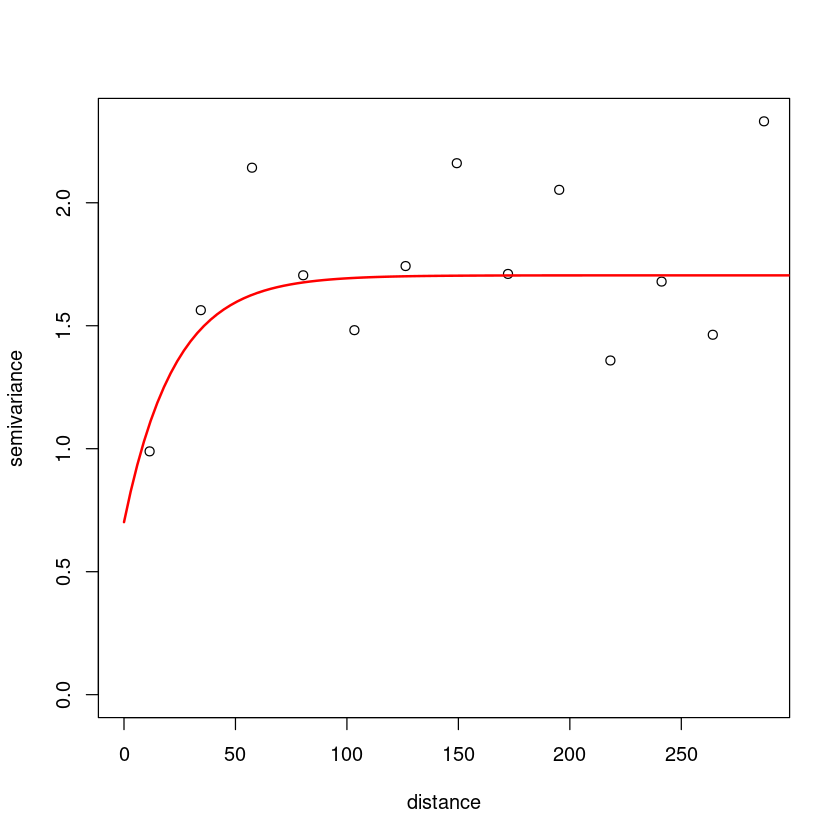

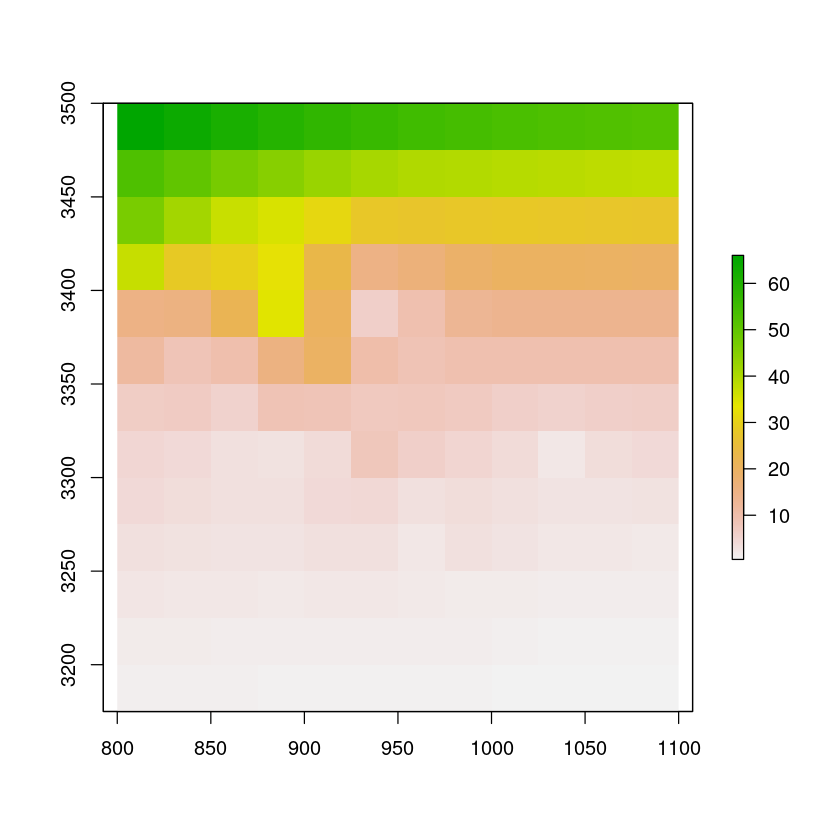

In [336]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_20 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_20))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_20 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(2, 90), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_20)
lines(vgm_res_lk_20, col = "red", lwd = 2)

krig_lkft_regr_20 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_20))

krig_regr_20 <- krig_lkft_20$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_20 <- rasterFromXYZ(cbind(grid_df, krig_regr_20))
proj4string(pr_regr_lkft_20) <- proj4string(grid_3sp)
plot(pr_regr_lkft_20)


DAY 21

In [337]:
f21 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_21_July_23.csv"

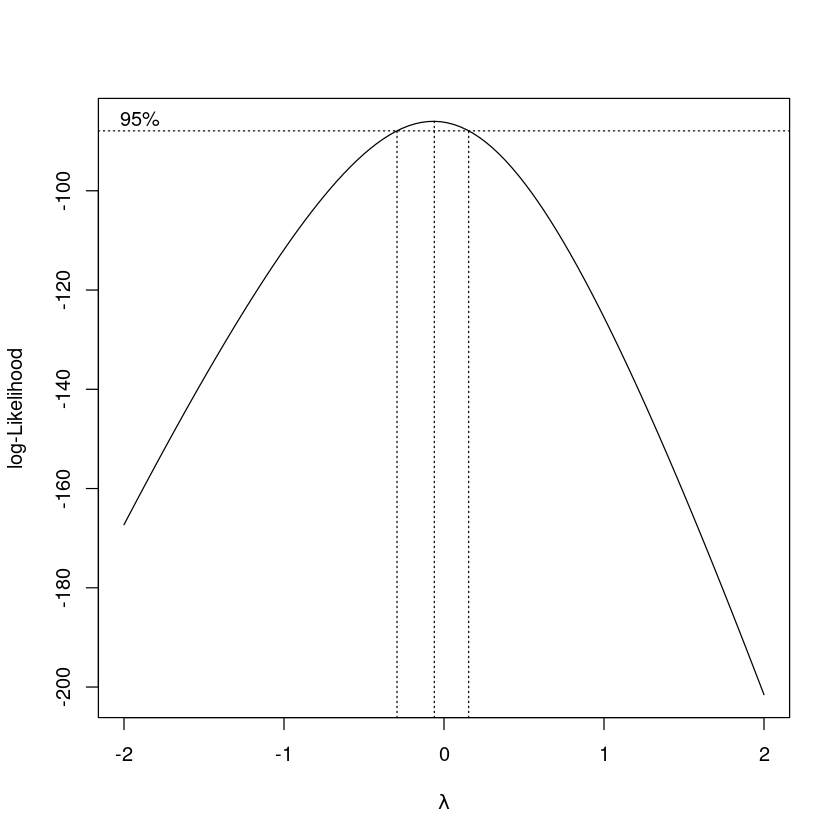

In [338]:
d21 = read.csv(f21)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d21$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d21$Rainfall_Transformed <- rain_transformed

In [339]:
lambda_rn

[1] -0.06060606

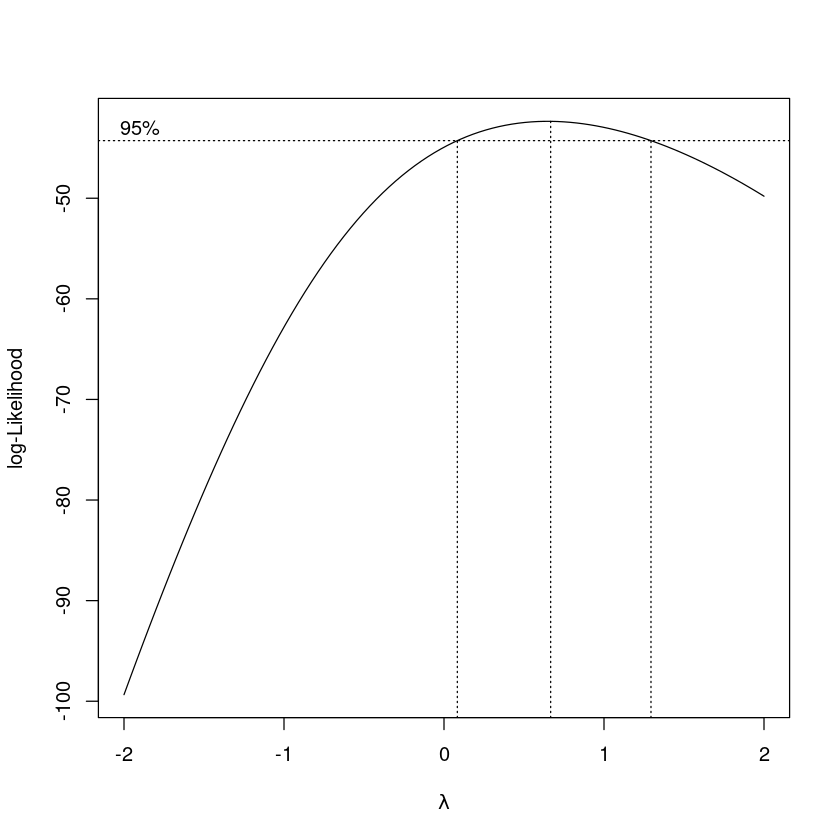

In [340]:
# Perform Box-Cox transformation on rainfall data
  elev <- d21$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d21$Elevation_Transformed <- el_transformed

In [341]:
coordinates1 = data.frame(lon = d21$Longitude, lat = d21$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d21_modb = subset(d21, select = -c(Longitude,Latitude))
sd_21 = SpatialPointsDataFrame(coords1,d21_modb)
class(sd_21)
proj4string(sd_21) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_21_prjtd <- spTransform(sd_21, CRS(desired_crs))
proj4string(sd_21_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [342]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-23.9438" "  0.0037" "  0.0065" "  0.0000" "  1.3802" " 11.3487" 
Practical Range with cor=0.05 for asymptotic range: 33.99779

likfit: maximised log-likelihood = -116.4

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-23.9438   0.0037   0.0065 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.38
      (estimated) cor. fct. parameter phi (range parameter)  =  11.35
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = -0.0606

Practical Range with cor=0.05 for asymptotic range: 33.99779

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-116.4"      "6"  "244.7"  "254.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-120.2"      "4"  "248.4"  "255.1" 

Call:
likfit(geodata = gdt_21, trend = "1st", ini.cov.pars = c(2, 50), 
    nu

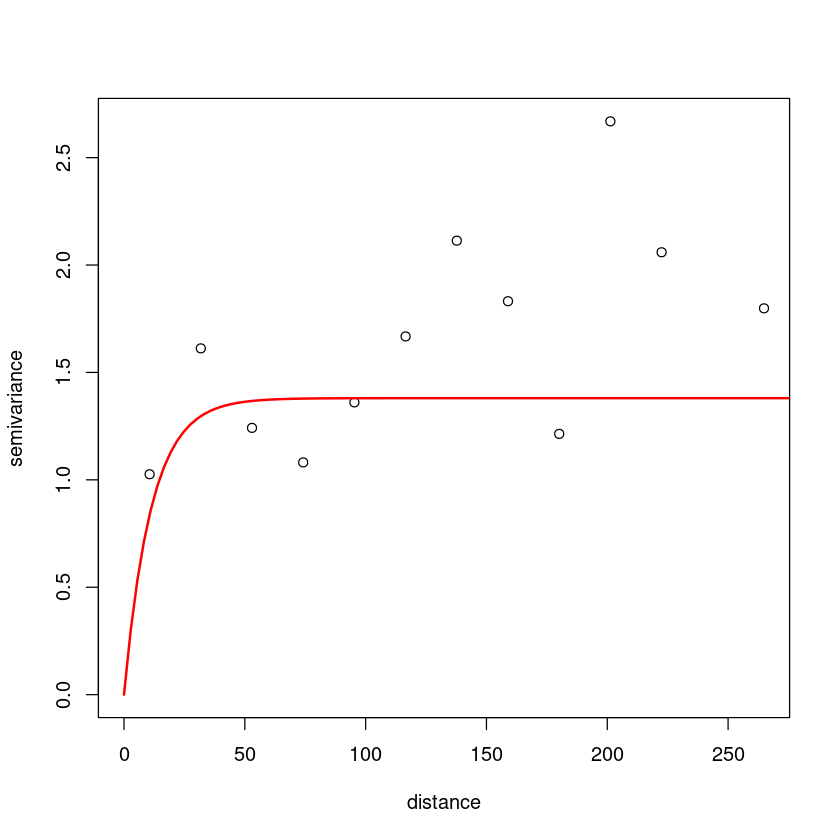

In [343]:
cord = coordinates(sd_21_prjtd)
rn = sd_21_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_21 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_21 = jitterDupCoords(gdt_21, max = jit_am)

vf_21 = variog(gdt_21, lambda = -0.0606060606060606, trend = "1st")
plot(vf_21)
vgm_rn_lk_21 = likfit(geodata = gdt_21, trend = "1st",cov.model = "exponential", ini.cov.pars = c(2,50),nugget = 0.01, lambda = -0.0606060606060606, lik.method = "ML", messages = FALSE)
vgm_rn_lk_21
summary(vgm_rn_lk_21)

# Add the fitted model
lines(vgm_rn_lk_21, col = "red", lwd = 2)

In [344]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


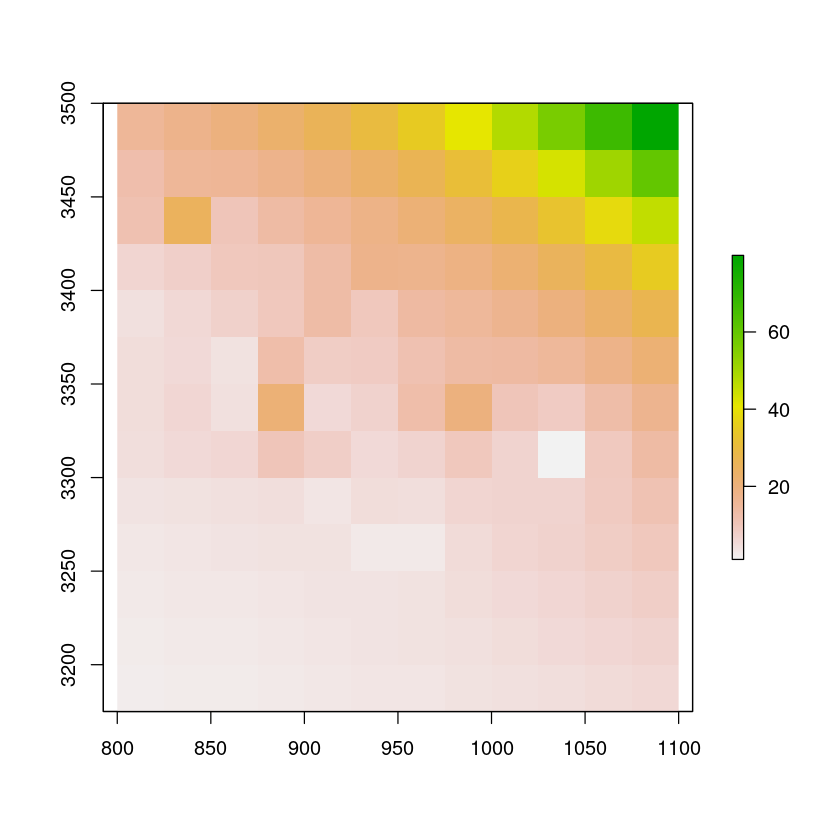

In [345]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_21 <- krige.conv(gdt_21, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_21))



krig_rain_lkft_21 <- krig_lkft_21$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_21 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_21))
proj4string(pr_rain_lkft_21) <- proj4string(grid_3sp)
plot(pr_rain_lkft_21)


In [346]:
## Regression

Generalized Linear Model 

40 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 37, 37, 35, 35, 35, 35, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  1.254621  0.479182  1.042922

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-11.1736   0.0021   0.0028 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.377
      (estimated) cor. fct. parameter phi (range parameter)  =  11.54
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 34.57515

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-60.27"      "6"  "132.5"  "142.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-63.68"      "4"  "135.4"  "142.1" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pa

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


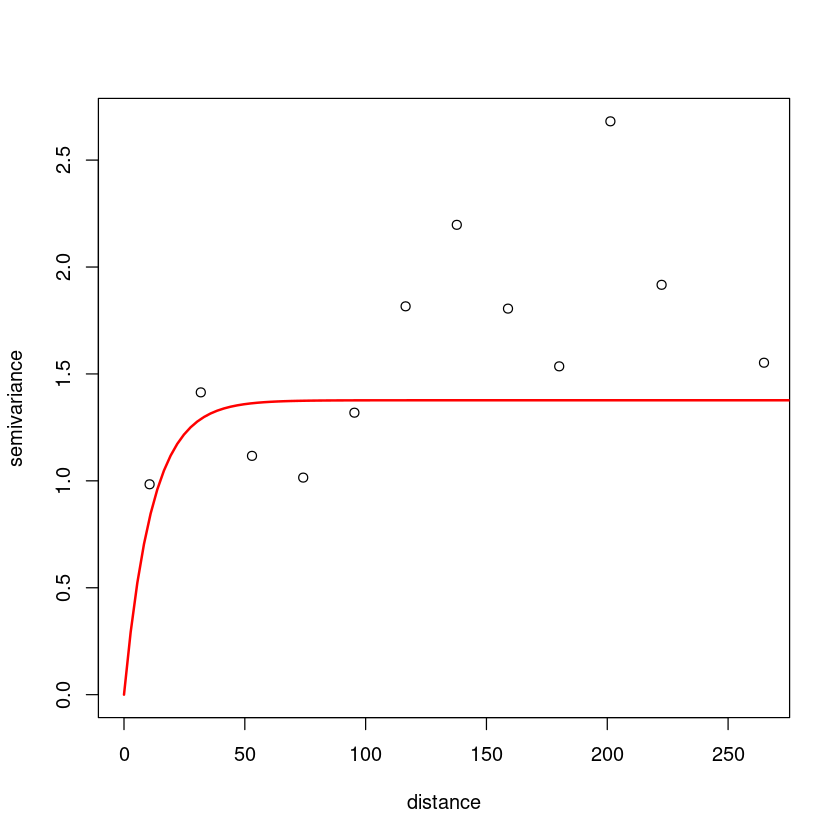

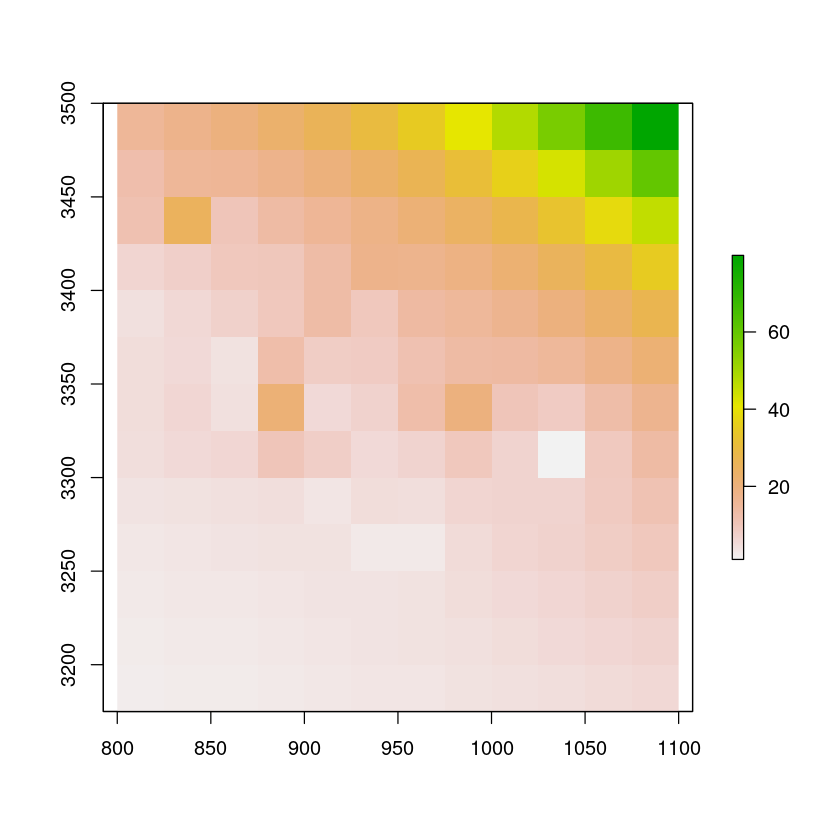

In [347]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_21 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_21))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_21 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(2, 60), 
                     nugget = 0.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_21)
lines(vgm_res_lk_21, col = "red", lwd = 2)

krig_lkft_regr_21 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_21))

krig_regr_21 <- krig_lkft_21$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_21 <- rasterFromXYZ(cbind(grid_df, krig_regr_21))
proj4string(pr_regr_lkft_21) <- proj4string(grid_3sp)
plot(pr_regr_lkft_21)


DAY 22

In [348]:
f22 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_22_July_23.csv"

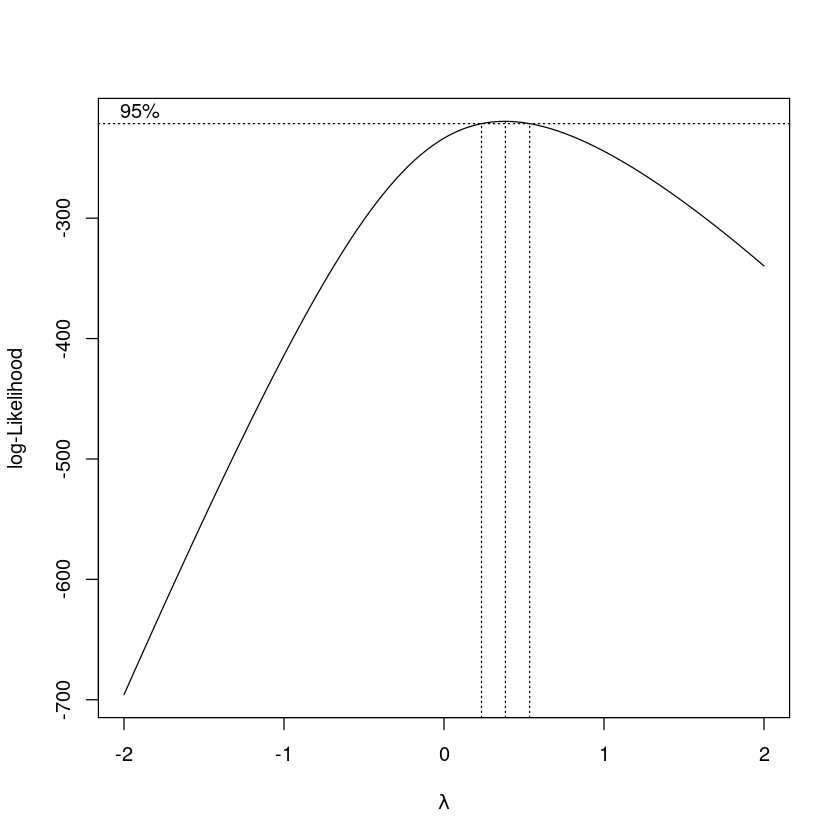

In [349]:
d22 = read.csv(f22)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d22$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d22$Rainfall_Transformed <- rain_transformed

In [350]:
lambda_rn

[1] 0.3838384

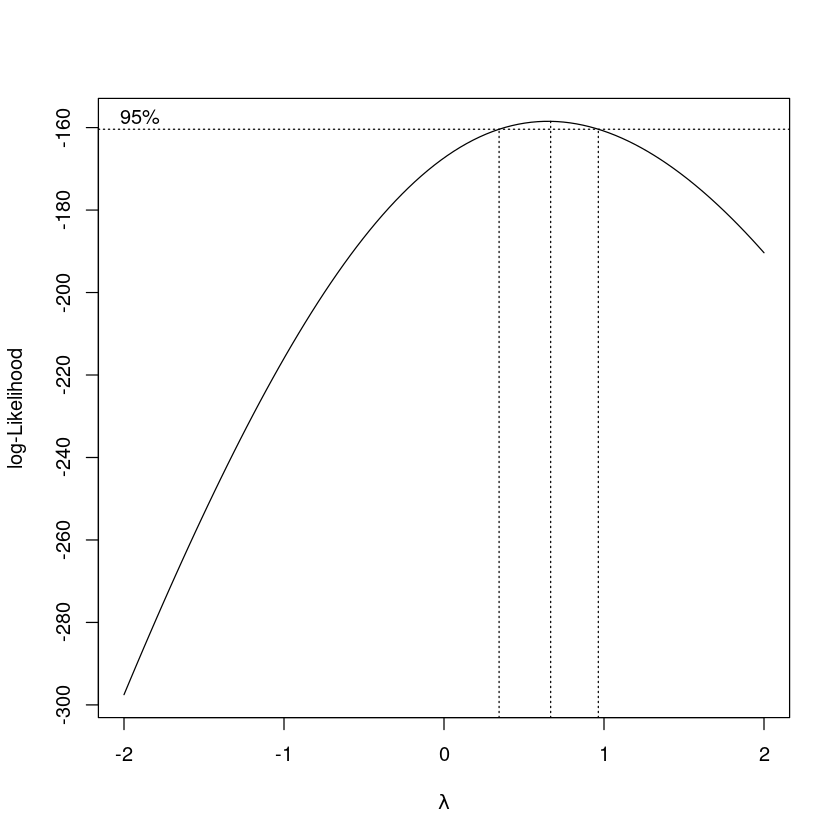

In [351]:
# Perform Box-Cox transformation on rainfall data
  elev <- d22$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d22$Elevation_Transformed <- el_transformed

In [352]:
coordinates1 = data.frame(lon = d22$Longitude, lat = d22$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d22_modb = subset(d22, select = -c(Longitude,Latitude))
sd_22 = SpatialPointsDataFrame(coords1,d22_modb)
class(sd_22)
proj4string(sd_22) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_22_prjtd <- spTransform(sd_22, CRS(desired_crs))
proj4string(sd_22_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [353]:
## likfit var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"-4.2845" " 0.0006" " 0.0032" " 4.2070" "12.3784" "16.8096" 
Practical Range with cor=0.05 for asymptotic range: 50.35716

likfit: maximised log-likelihood = -420.6

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-4.2845  0.0006  0.0032 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  12.38
      (estimated) cor. fct. parameter phi (range parameter)  =  16.81
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  4.207

Transformation parameter:
      (fixed) Box-Cox parameter = 0.3838

Practical Range with cor=0.05 for asymptotic range: 50.35716

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-420.6"      "6"  "853.1"  "868.1" 

non spatial model:
   log.L n.params      AIC      BIC 
"-426.1"      "4"  "860.2"  "870.2" 

Call:
likfit(geodata = gdt_22, trend = "1st", ini.cov.pars = c(15, 
    100), nu

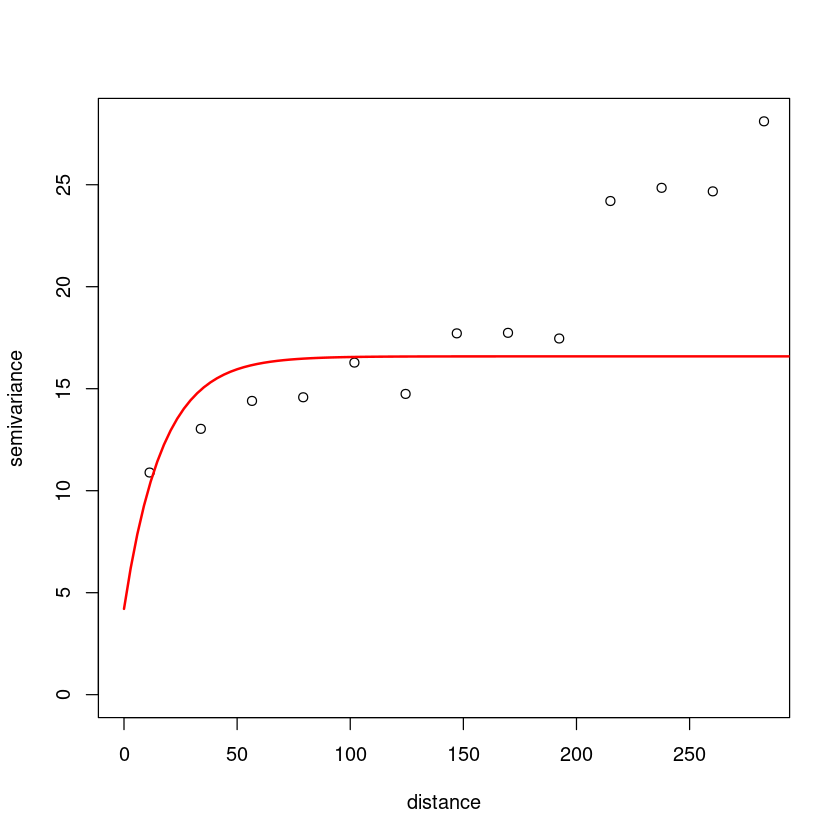

In [354]:
cord = coordinates(sd_22_prjtd)
rn = sd_22_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_22 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_22 = jitterDupCoords(gdt_22, max = jit_am)

vf_22 = variog(gdt_22, lambda = 0.383838383838384, trend = "1st")
plot(vf_22)
vgm_rn_lk_22 = likfit(geodata = gdt_22, trend = "1st",cov.model = "exponential", ini.cov.pars = c(15,100),nugget = 9, lambda = 0.383838383838384, lik.method = "ML", messages = FALSE)
vgm_rn_lk_22
summary(vgm_rn_lk_22)

# Add the fitted model
lines(vgm_rn_lk_22, col = "red", lwd = 2)


In [355]:
## krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


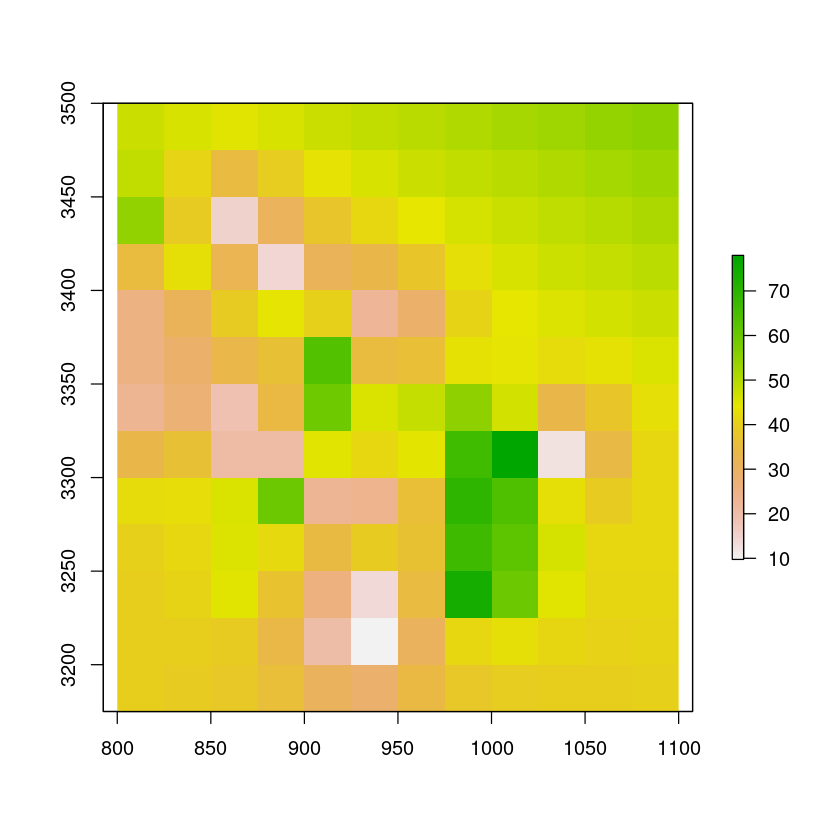

In [356]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_22 <- krige.conv(gdt_22, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_22))



krig_rain_lkft_22 <- krig_lkft_22$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_22 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_22))
proj4string(pr_rain_lkft_22) <- proj4string(grid_3sp)
plot(pr_rain_lkft_22)

In [357]:
## Regression

Generalized Linear Model 

90 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 82, 81, 82, 81, 79, 81, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  4.002475  0.1343321  3.213674

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
20.2474 -0.0037 -0.0052 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  12.47
      (estimated) cor. fct. parameter phi (range parameter)  =  17.66
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  4.133

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 52.90568

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-246.3"      "6"  "504.6"  "519.6" 

non spatial model:
   log.L n.params      AIC      BIC 
"-252.2"      "4"  "512.3"  "522.3" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


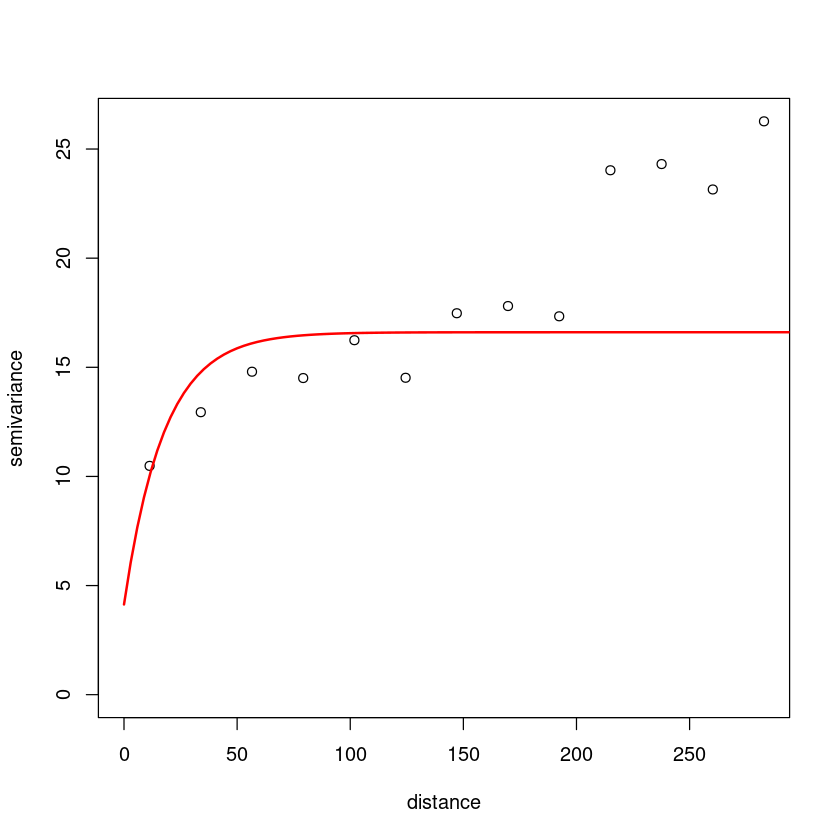

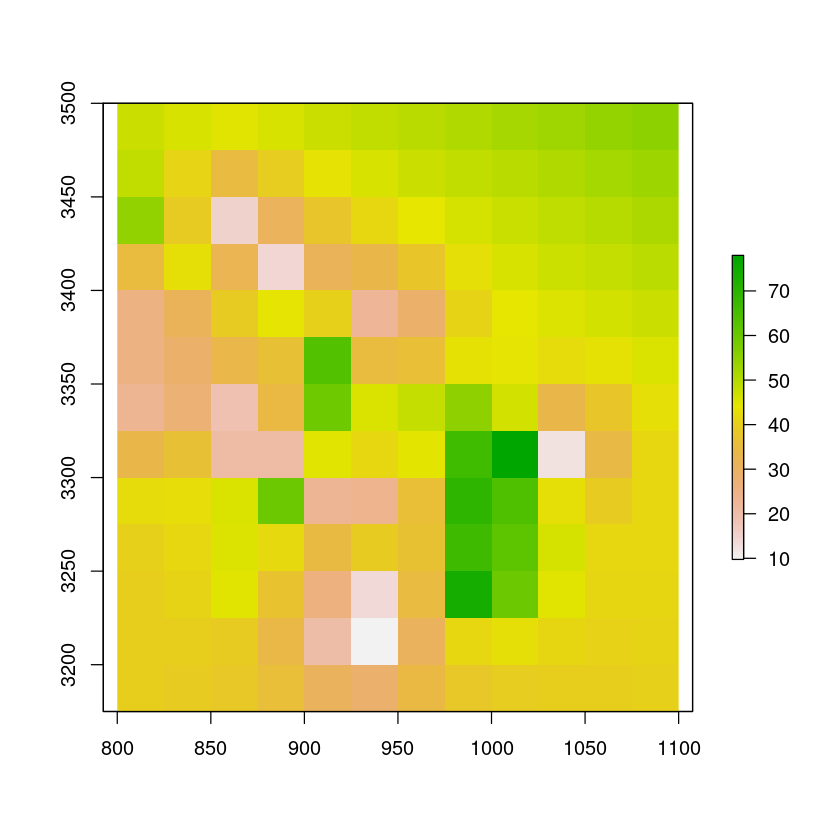

In [358]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_22 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_22))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_22 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(15, 100), 
                     nugget = 9, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_22)
lines(vgm_res_lk_22, col = "red", lwd = 2)

krig_lkft_regr_22 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_22))

krig_regr_22 <- krig_lkft_22$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_22 <- rasterFromXYZ(cbind(grid_df, krig_regr_22))
proj4string(pr_regr_lkft_22) <- proj4string(grid_3sp)
plot(pr_regr_lkft_22)

DAY 23

In [359]:
f23 =  "/data/private/GPM/Data_1/July_2023_with_elev/processed_23_July_23.csv"

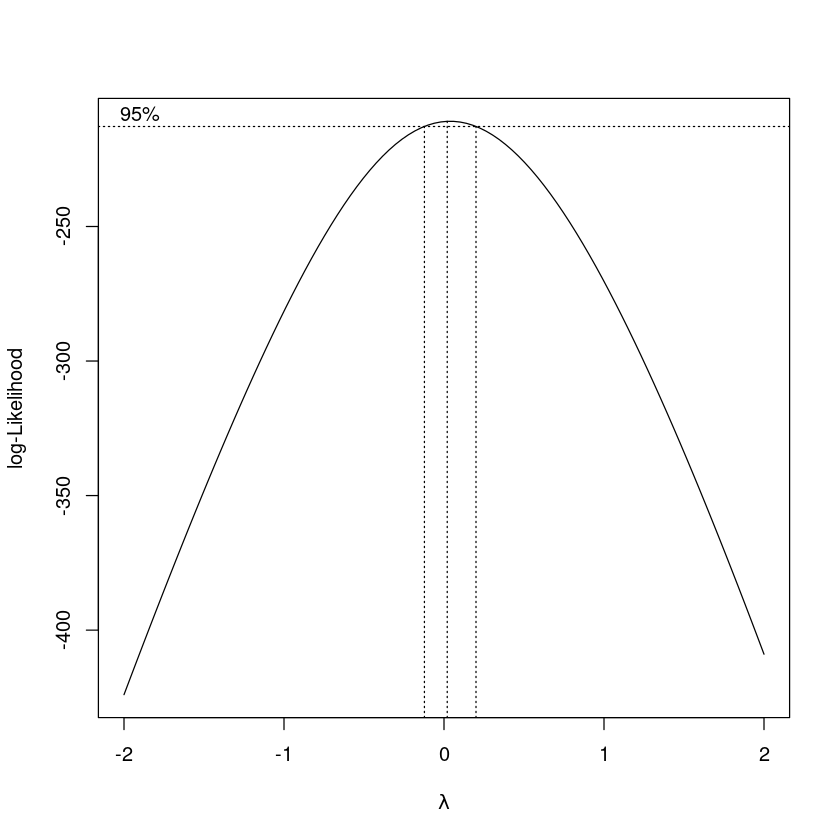

In [360]:
d23 = read.csv(f23)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d23$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d23$Rainfall_Transformed <- rain_transformed

In [361]:
lambda_rn

[1] 0.02020202

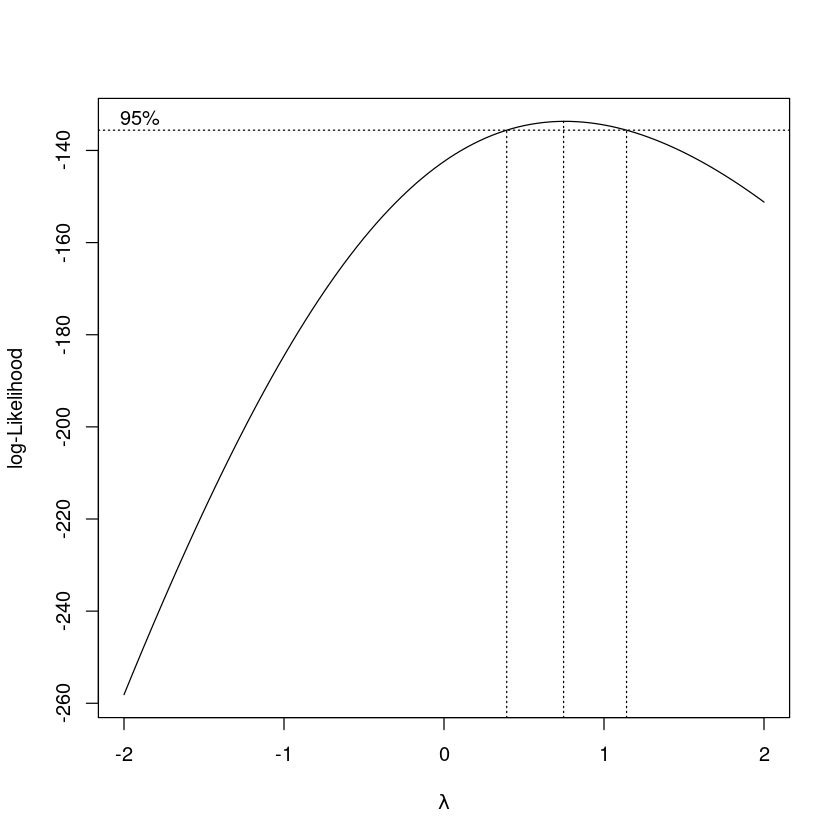

In [362]:
# Perform Box-Cox transformation on rainfall data
  elev <- d23$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d23$Elevation_Transformed <- el_transformed

In [363]:
coordinates1 = data.frame(lon = d23$Longitude, lat = d23$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d23_modb = subset(d23, select = -c(Longitude,Latitude))
sd_23 = SpatialPointsDataFrame(coords1,d23_modb)
class(sd_23)
proj4string(sd_23) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_23_prjtd <- spTransform(sd_23, CRS(desired_crs))
proj4string(sd_23_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [364]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-13.4155" "  0.0067" "  0.0028" "  0.0000" "  2.0633" " 20.9564" 
Practical Range with cor=0.05 for asymptotic range: 62.77975

likfit: maximised log-likelihood = -268.5

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-13.4155   0.0067   0.0028 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  2.063
      (estimated) cor. fct. parameter phi (range parameter)  =  20.96
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 0.0202

Practical Range with cor=0.05 for asymptotic range: 62.77975

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-268.5"      "6"  "548.9"  "563.5" 

non spatial model:
   log.L n.params      AIC      BIC 
"-285.3"      "4"  "578.7"  "588.4" 

Call:
likfit(geodata = gdt_23, trend = "1st", ini.cov.pars = c(3, 80), 
    nu

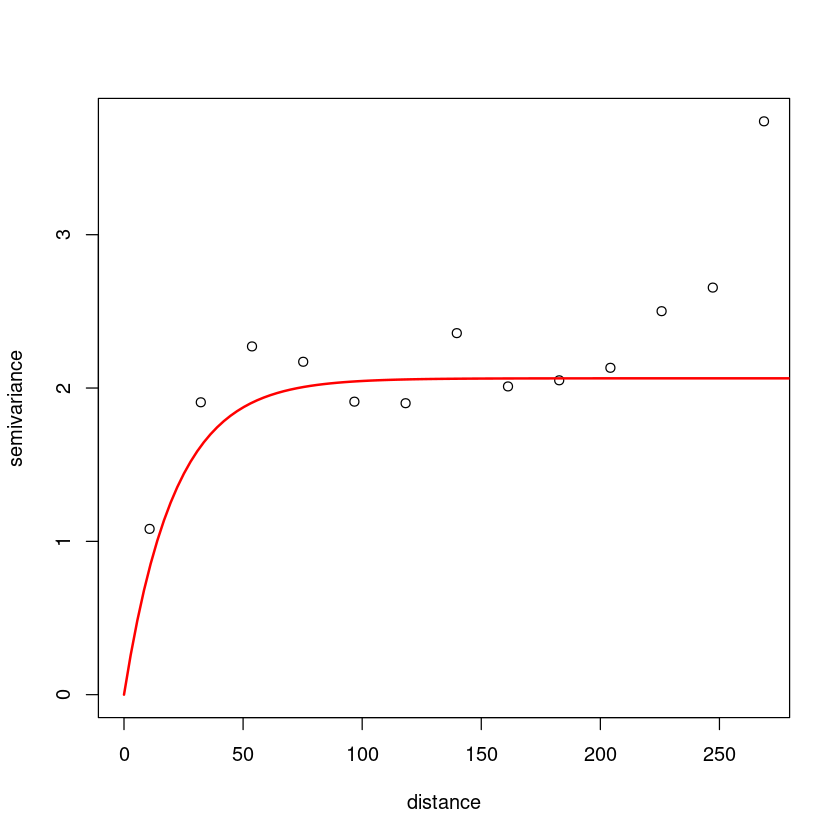

In [365]:
cord = coordinates(sd_23_prjtd)
rn = sd_23_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_23 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_23 = jitterDupCoords(gdt_23, max = jit_am)

vf_23 = variog(gdt_23, lambda = 0.0202020202020203, trend = "1st")
plot(vf_23)

vgm_rn_lk_23 = likfit(geodata = gdt_23, trend = "1st",cov.model = "exponential", ini.cov.pars = c(3,80),nugget = 1, lambda = 0.0202020202020203, lik.method = "ML", messages = FALSE)
vgm_rn_lk_23
summary(vgm_rn_lk_23)

# Add the fitted model
lines(vgm_rn_lk_23, col = "red", lwd = 2)


In [366]:
##Likfit krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


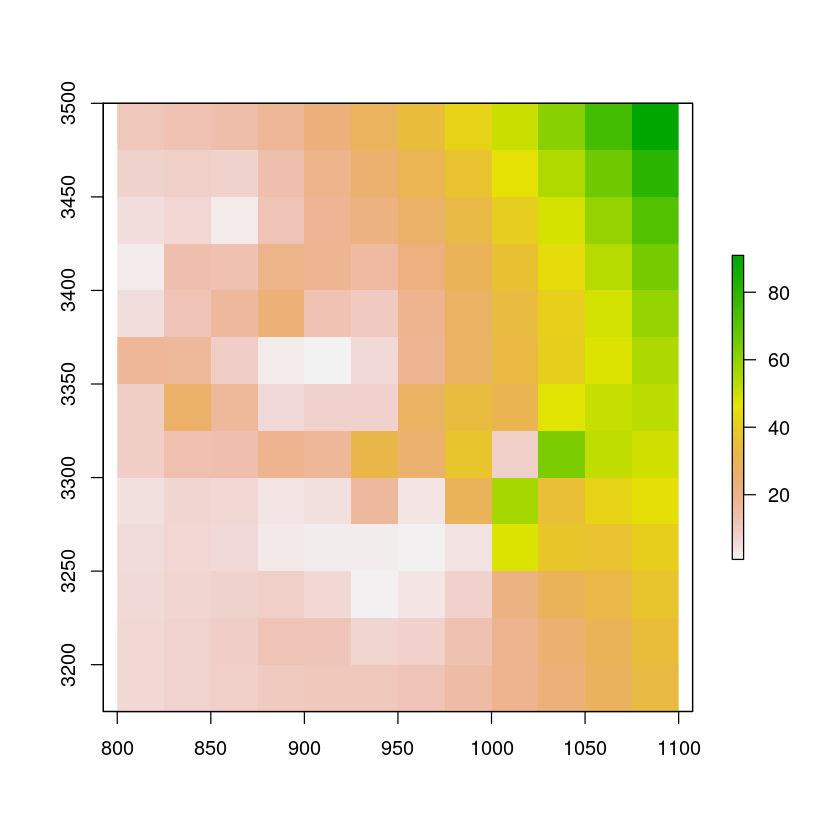

In [367]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_23 <- krige.conv(gdt_23, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_23))



krig_rain_lkft_23 <- krig_lkft_23$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_23 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_23))
proj4string(pr_rain_lkft_23) <- proj4string(grid_3sp)
plot(pr_rain_lkft_23)

In [368]:
## Regression

Generalized Linear Model 

83 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 75, 75, 75, 74, 75, 75, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.441925  0.1698839  1.230222

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
-7.6184  0.0059  0.0007 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  2.109
      (estimated) cor. fct. parameter phi (range parameter)  =  22.34
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 66.91483

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-130.1"      "6"  "272.1"  "286.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-147.4"      "4"  "302.8"  "312.5" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars = c

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


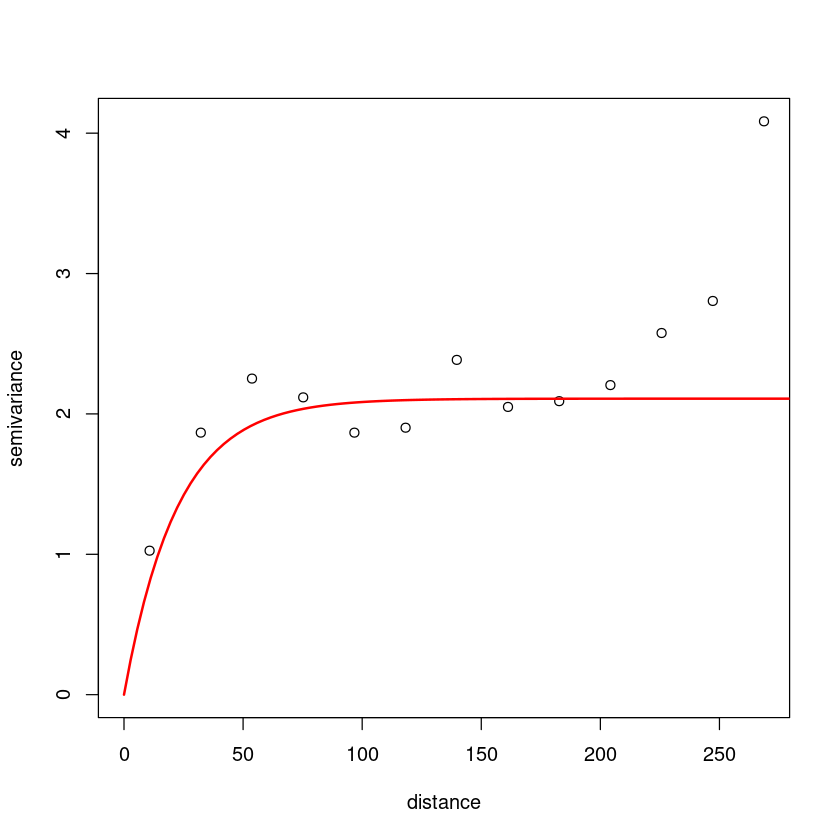

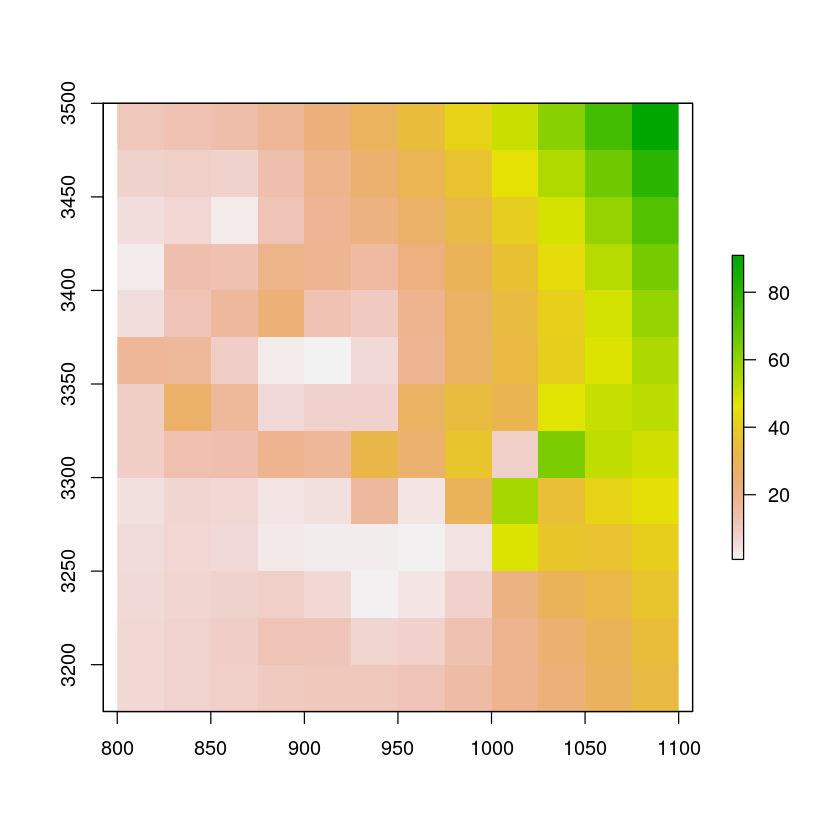

In [369]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_23 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_23))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_23 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(3, 60), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_23)
lines(vgm_res_lk_23, col = "red", lwd = 2)

krig_lkft_regr_23 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_23))

krig_regr_23 <- krig_lkft_23$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_23 <- rasterFromXYZ(cbind(grid_df, krig_regr_23))
proj4string(pr_regr_lkft_23) <- proj4string(grid_3sp)
plot(pr_regr_lkft_23)


DAY 24

In [370]:
f24 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_24_July_23.csv"

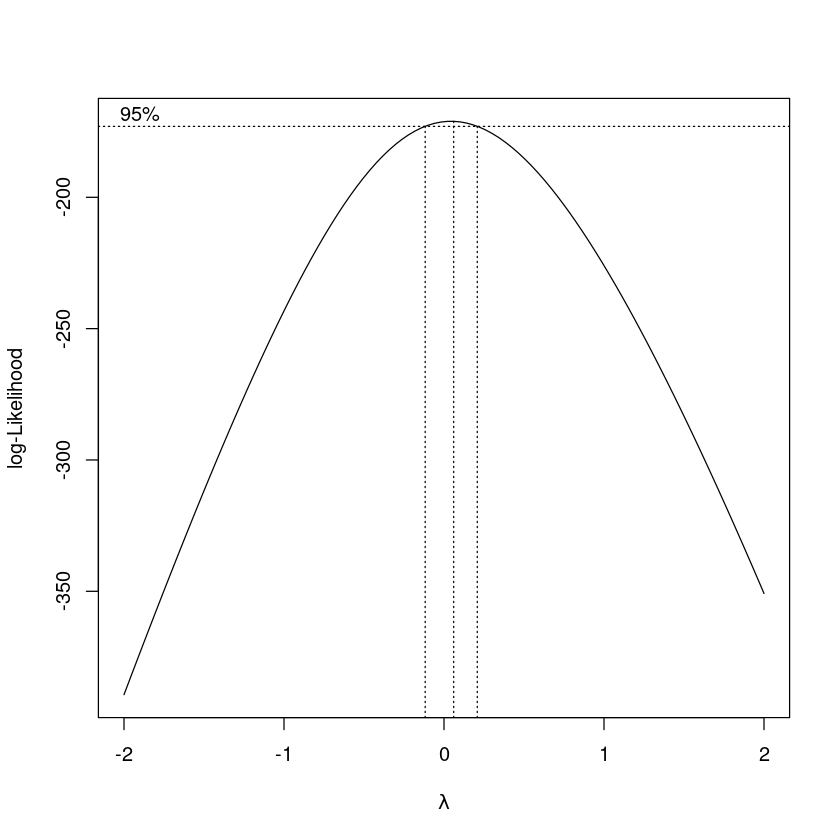

In [371]:
d24 = read.csv(f24)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d24$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d24$Rainfall_Transformed <- rain_transformed

In [372]:
lambda_rn

[1] 0.06060606

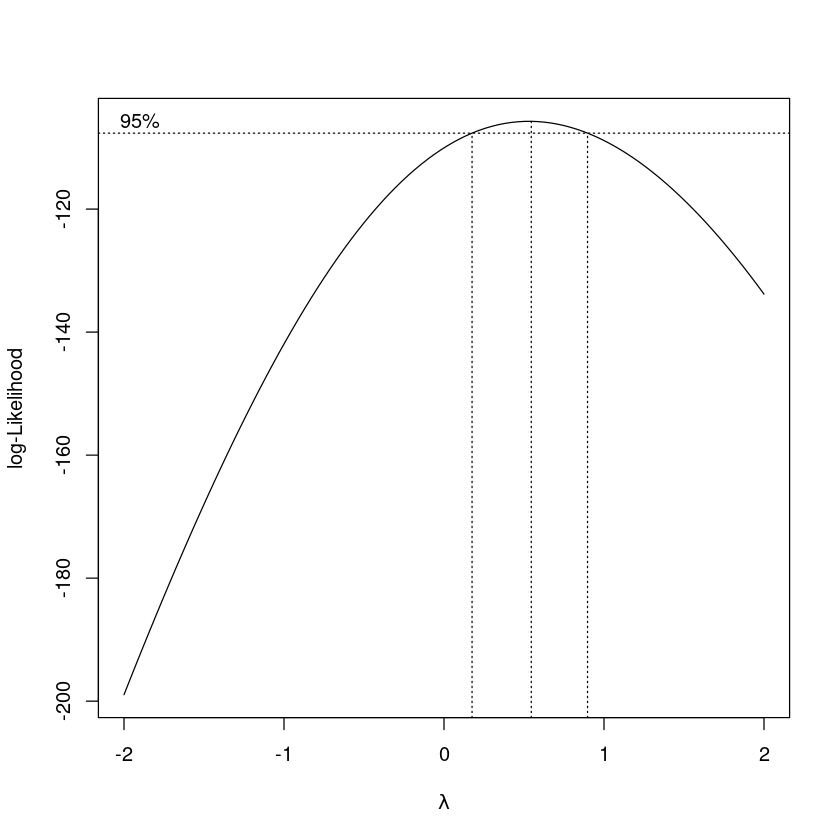

In [373]:
# Perform Box-Cox transformation on rainfall data
  elev <- d24$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d24$Elevation_Transformed <- el_transformed

In [374]:
coordinates1 = data.frame(lon = d24$Longitude, lat = d24$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d24_modb = subset(d24, select = -c(Longitude,Latitude))
sd_24 = SpatialPointsDataFrame(coords1,d24_modb)
class(sd_24)
proj4string(sd_24) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_24_prjtd <- spTransform(sd_24, CRS(desired_crs))
proj4string(sd_24_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [375]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-33.4434" "  0.0092" "  0.0083" "  0.0000" "  2.8095" "  8.4881" 
Practical Range with cor=0.05 for asymptotic range: 25.42812

likfit: maximised log-likelihood = -267.8

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-33.4434   0.0092   0.0083 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  2.809
      (estimated) cor. fct. parameter phi (range parameter)  =  8.488
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 0.0606

Practical Range with cor=0.05 for asymptotic range: 25.42812

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-267.8"      "6"  "547.5"  "560.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-270.7"      "4"  "549.4"  "558.2" 

Call:
likfit(geodata = gdt_24, trend = "1st", ini.cov.pars = c(6, 30), 
    nu

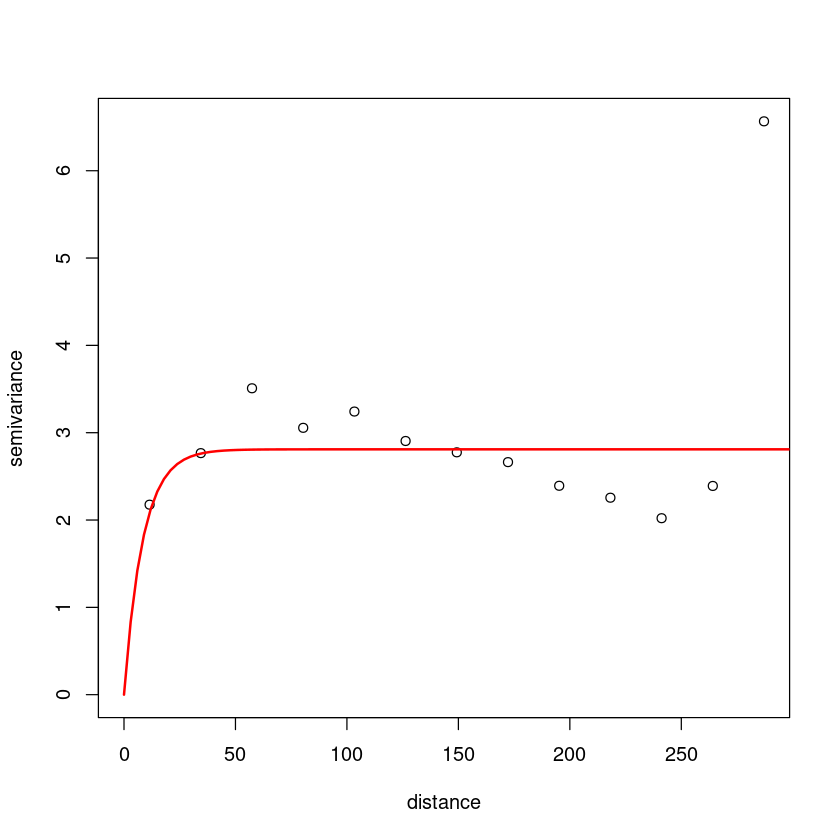

In [376]:
cord = coordinates(sd_24_prjtd)
rn = sd_24_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_24 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_24 = jitterDupCoords(gdt_24, max = jit_am)

vf_24 = variog(gdt_24, lambda = 0.060606060606061, trend = "1st")
plot(vf_24)

vgm_rn_lk_24 = likfit(geodata = gdt_24, trend = "1st",cov.model = "exponential", ini.cov.pars = c(6,30),nugget = 2, lambda = 0.060606060606061, lik.method = "ML", messages = FALSE)
vgm_rn_lk_24
summary(vgm_rn_lk_24)

# Add the fitted model
lines(vgm_rn_lk_24, col = "red", lwd = 2)


In [377]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


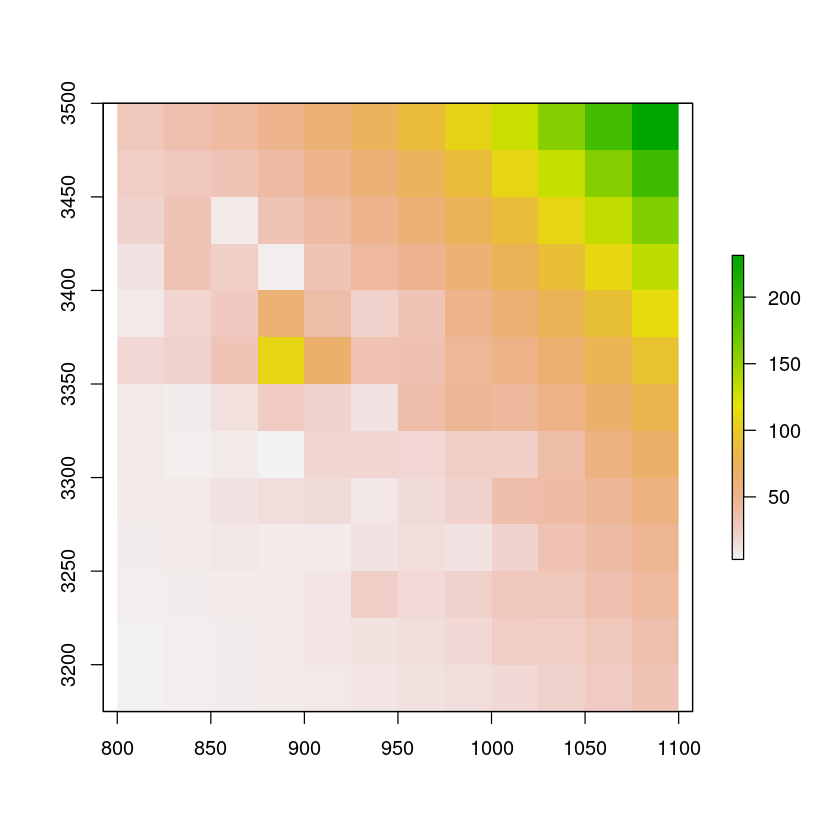

In [378]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_24 <- krige.conv(gdt_24, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_24))



krig_rain_lkft_24 <- krig_lkft_24$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_24 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_24))
proj4string(pr_rain_lkft_24) <- proj4string(grid_3sp)
plot(pr_rain_lkft_24)


In [379]:
## Regression

Generalized Linear Model 

67 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 61, 59, 62, 59, 62, 60, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.824125  0.1847682  1.573164

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-43.6615   0.0100   0.0104 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  2.724
      (estimated) cor. fct. parameter phi (range parameter)  =  8.092
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 24.24199

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-126.7"      "6"  "265.4"  "278.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-129.4"      "4"  "266.8"  "275.6" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pa

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


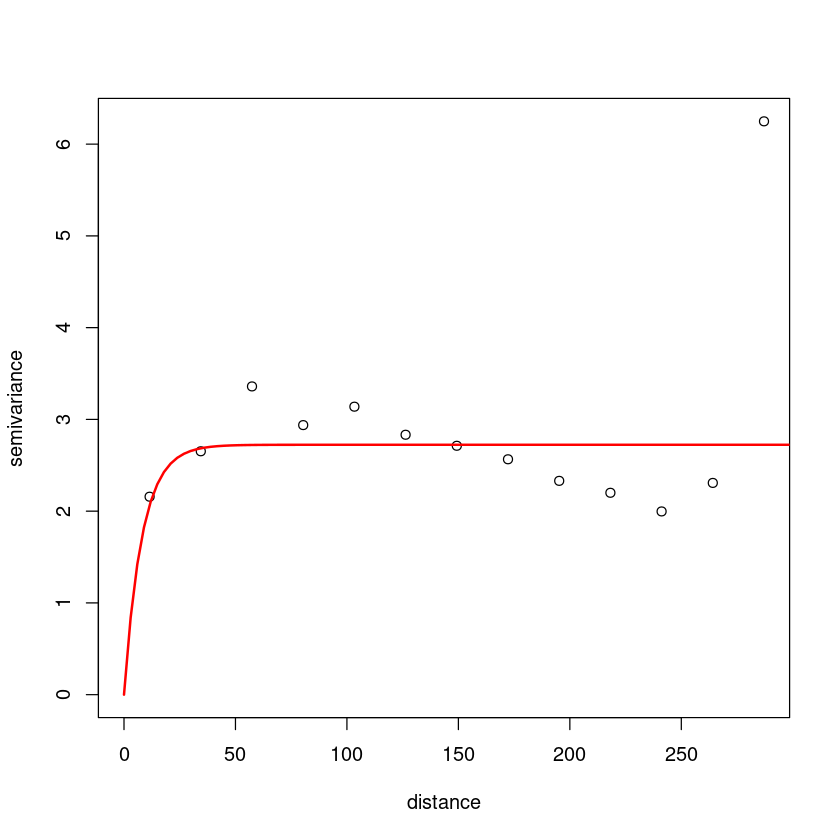

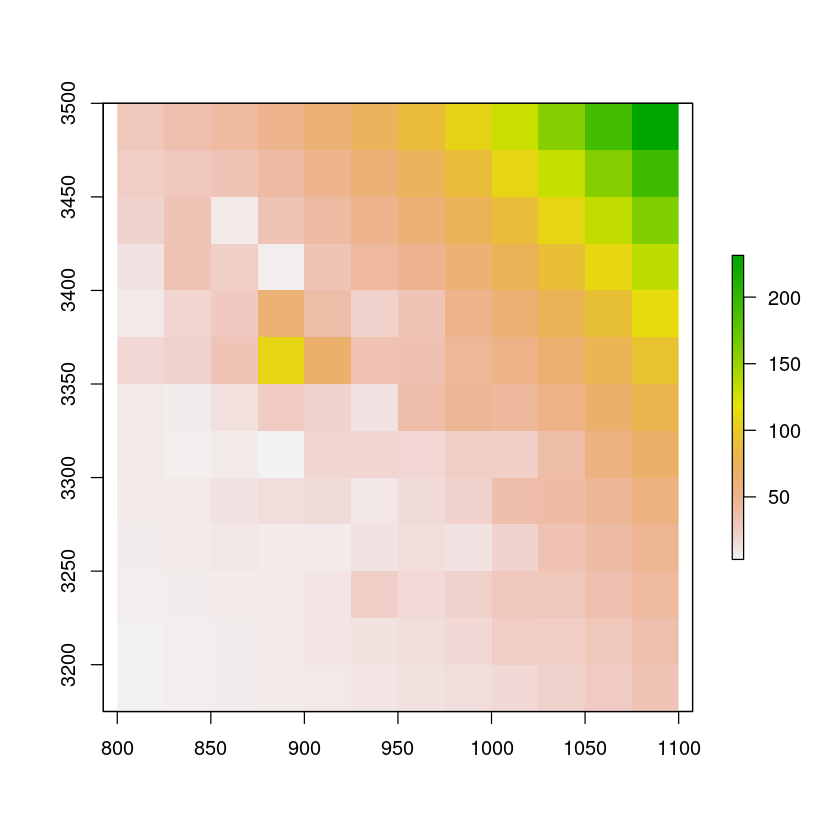

In [380]:

train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_24 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_24))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_24 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(6, 30), 
                     nugget = 2, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_24)
lines(vgm_res_lk_24, col = "red", lwd = 2)

krig_lkft_regr_24 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_24))

krig_regr_24 <- krig_lkft_24$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_24 <- rasterFromXYZ(cbind(grid_df, krig_regr_24))
proj4string(pr_regr_lkft_24) <- proj4string(grid_3sp)
plot(pr_regr_lkft_24)


DAY 25

In [381]:
f25 =  "/data/private/GPM/Data_1/July_2023_with_elev/processed_25_July_23.csv"

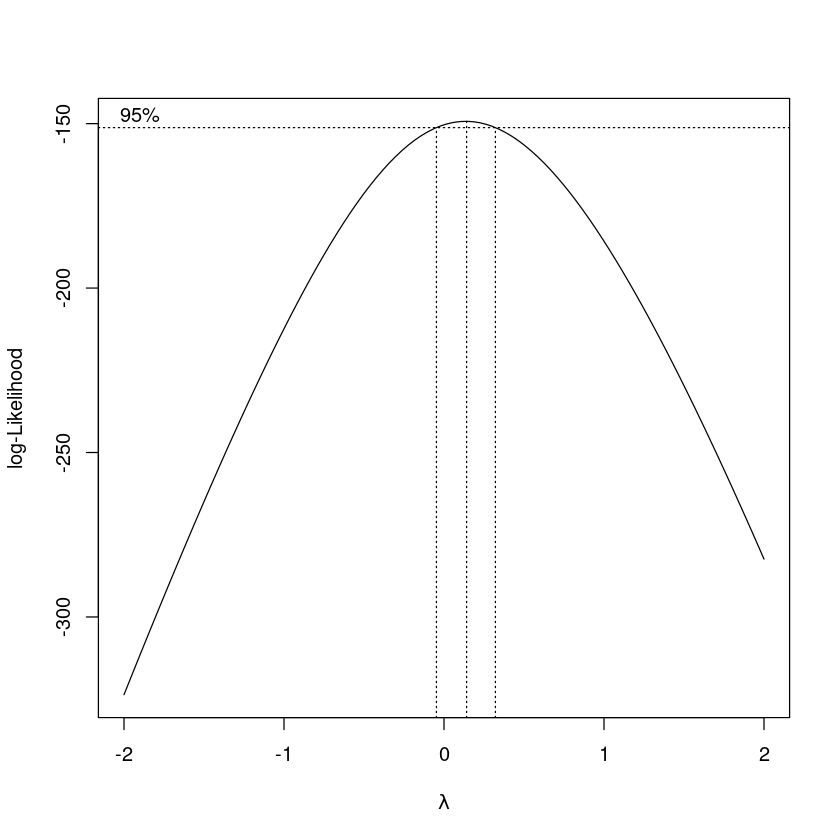

In [382]:
d25 = read.csv(f25)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d25$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d25$Rainfall_Transformed <- rain_transformed

In [383]:
lambda_rn

[1] 0.1414141

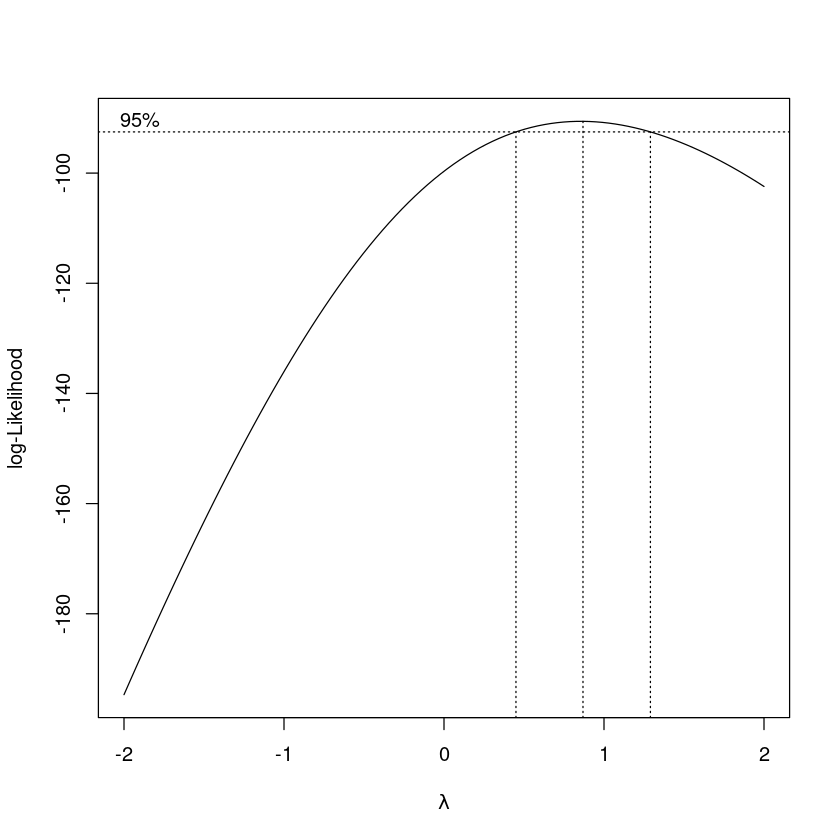

In [384]:
# Perform Box-Cox transformation on rainfall data
  elev <- d25$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d25$Elevation_Transformed <- el_transformed

In [385]:
coordinates1 = data.frame(lon = d25$Longitude, lat = d25$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d25_modb = subset(d25, select = -c(Longitude,Latitude))
sd_25 = SpatialPointsDataFrame(coords1,d25_modb)
class(sd_25)
proj4string(sd_25) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_25_prjtd <- spTransform(sd_25, CRS(desired_crs))
proj4string(sd_25_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [386]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-35.9427" "  0.0097" "  0.0088" "  2.2866" "  0.9727" " 29.9024" 
Practical Range with cor=0.05 for asymptotic range: 51.75562

likfit: maximised log-likelihood = -214.1

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-35.9427   0.0097   0.0088 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  0.9727
      (estimated) cor. fct. parameter phi (range parameter)  =  29.9
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.287

Transformation parameter:
      (fixed) Box-Cox parameter = 0.1414

Practical Range with cor=0.05 for asymptotic range: 51.75562

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-214.1"      "6"  "440.2"  "452.9" 

non spatial model:
   log.L n.params      AIC      BIC 
"-215.4"      "4"  "438.8"  "447.2" 

Call:
likfit(geodata = gdt_25, trend = "1st", ini.cov.pars = c(4, 100), 
    

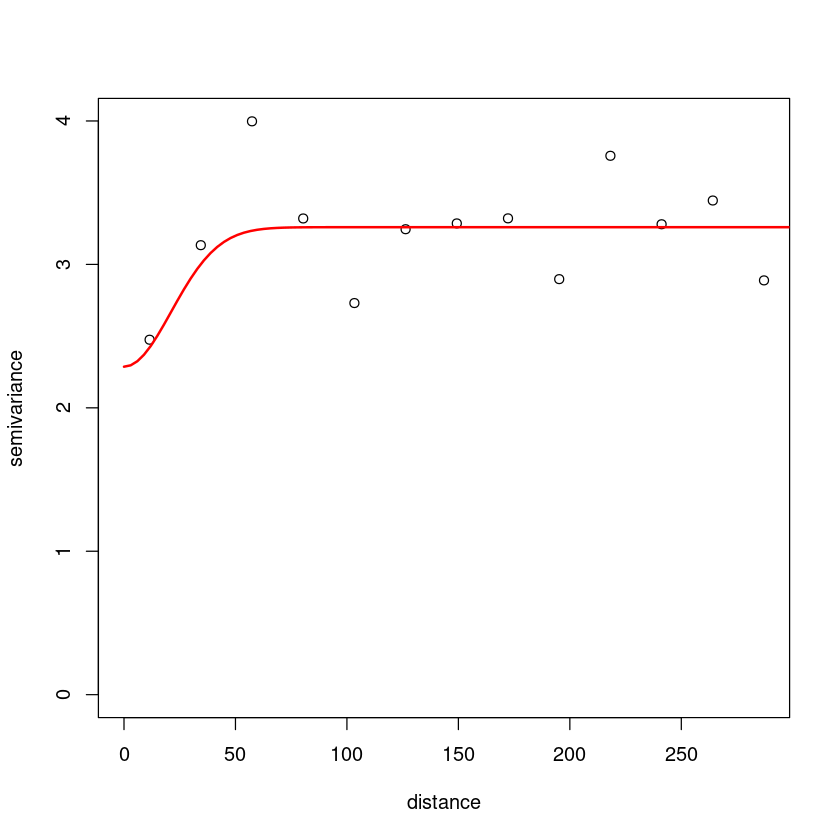

In [387]:
cord = coordinates(sd_25_prjtd)
rn = sd_25_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_25 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_25 = jitterDupCoords(gdt_25, max = jit_am)

vf_25 = variog(gdt_25, lambda = 0.141414141414141, trend = "1st")
plot(vf_25)
vgm_rn_lk_25 = likfit(geodata = gdt_25, trend = "1st",cov.model = "gaussian", ini.cov.pars = c(4,100),nugget = 1, lambda = 0.141414141414141, lik.method = "ML", messages = FALSE)
vgm_rn_lk_25
summary(vgm_rn_lk_25)

# Add the fitted model
lines(vgm_rn_lk_25, col = "red", lwd = 2)

In [388]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


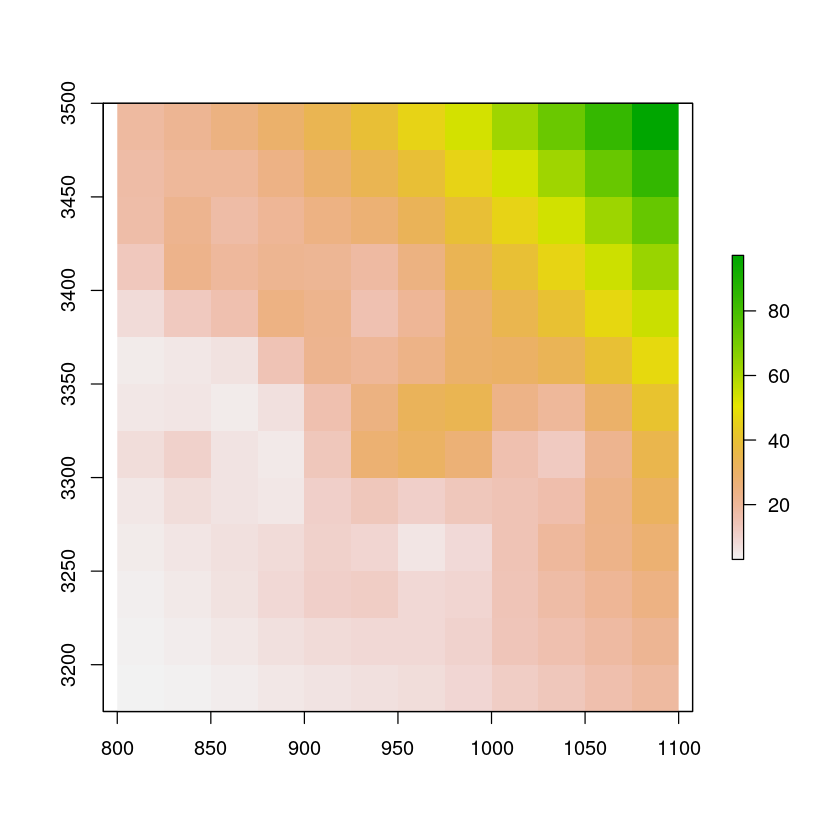

In [389]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_25 <- krige.conv(gdt_25, locations = grid_df, krige = krige.control(type.krige = 'ok', obj.model = vgm_rn_lk_25))



krig_rain_lkft_25 <- krig_lkft_25$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_25 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_25))
proj4string(pr_rain_lkft_25) <- proj4string(grid_3sp)
plot(pr_rain_lkft_25)


In [390]:
##Regression

Generalized Linear Model 

61 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 55, 55, 55, 54, 56, 56, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.951523  0.2067572  1.694465

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-43.0042   0.0103   0.0101 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0.6728
      (estimated) cor. fct. parameter phi (range parameter)  =  18.32
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.526

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 54.87397

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-121.6"      "6"  "255.2"  "267.9" 

non spatial model:
   log.L n.params      AIC      BIC 
"-121.9"      "4"  "251.9"  "260.3" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.c

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


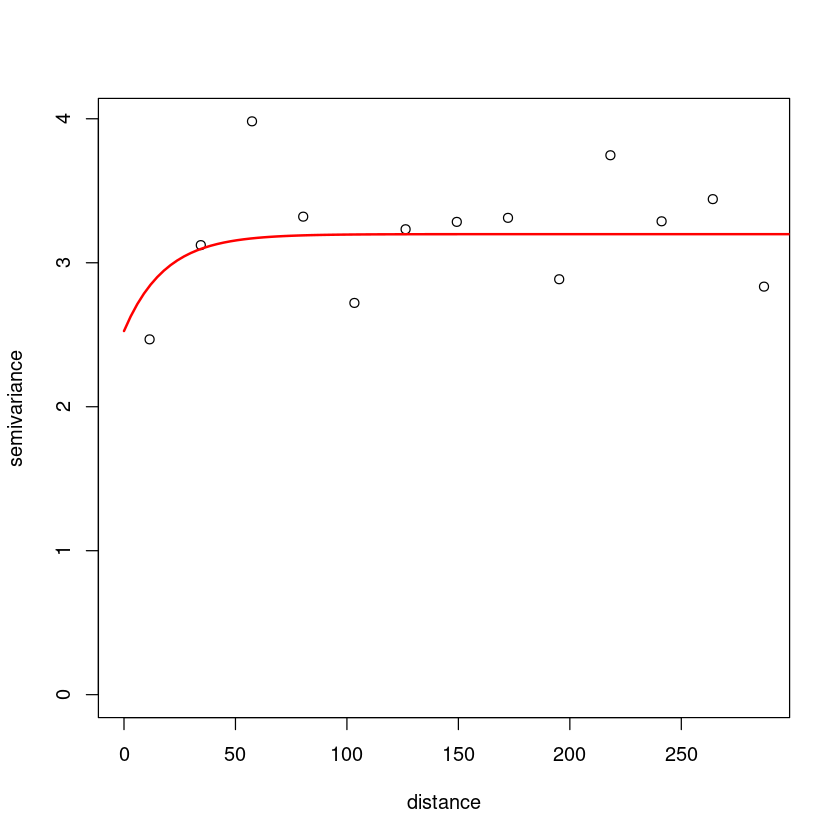

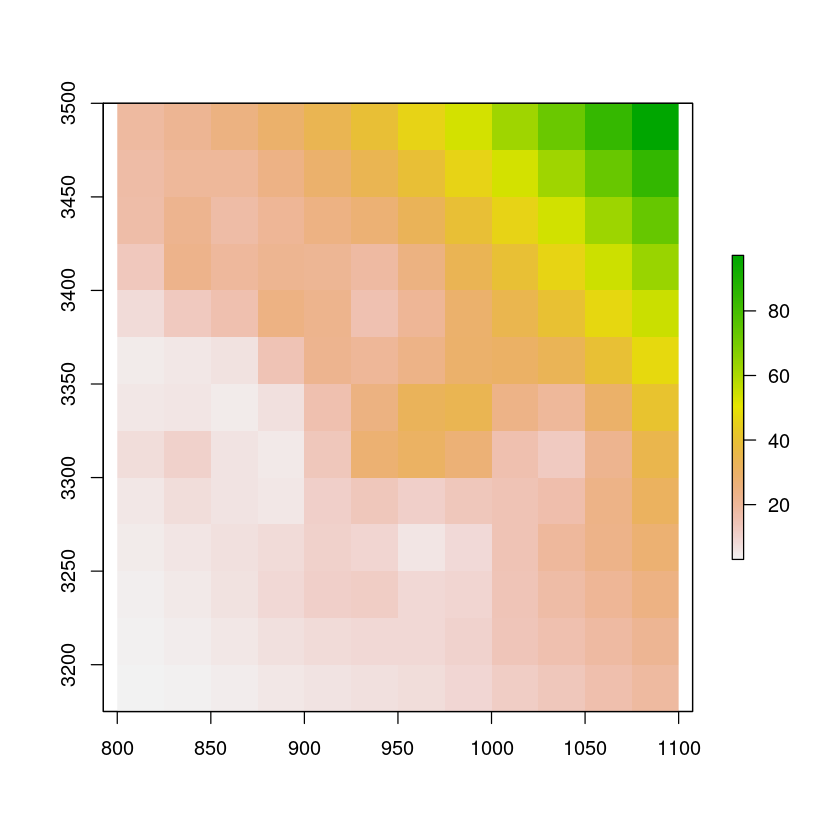

In [391]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_25 = resid(GLM)
# Filter the coordinates to match the rows used in the GLM model based on the index
cord_filtered <- cord[1:nrow(train.x), ]
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord_filtered, residuals = resd_glm_25))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_25 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(5, 70), 
                     nugget = 1, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_25)
lines(vgm_res_lk_25, col = "red", lwd = 2)

krig_lkft_regr_25 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_25))

krig_regr_25 <- krig_lkft_25$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_25 <- rasterFromXYZ(cbind(grid_df, krig_regr_25))
proj4string(pr_regr_lkft_25) <- proj4string(grid_3sp)
plot(pr_regr_lkft_25)


DAY 26

In [392]:
f26 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_26_July_23.csv"

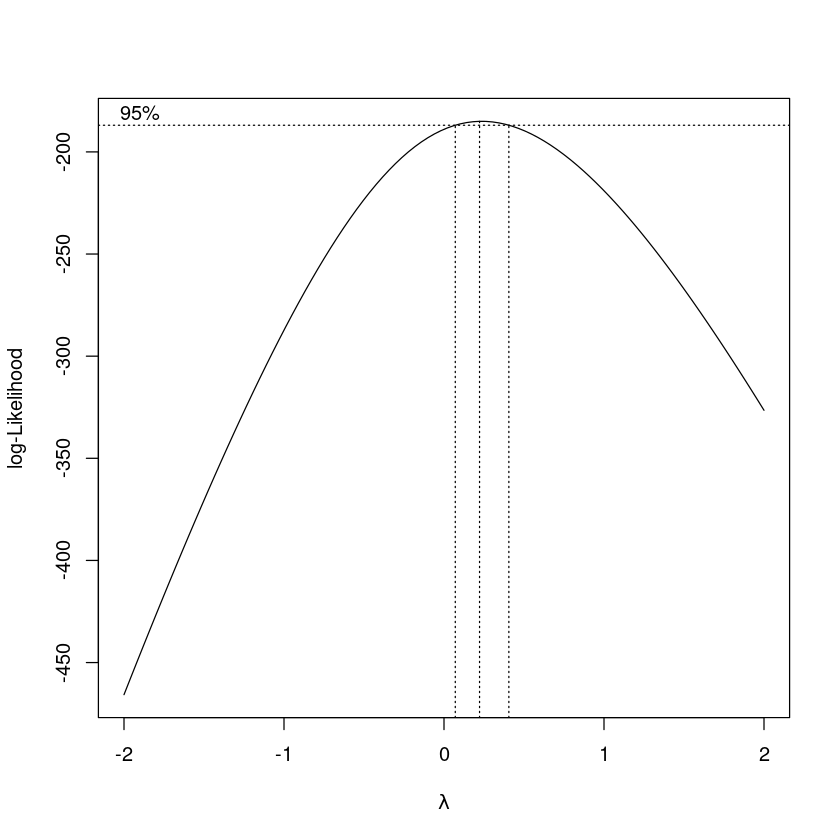

In [393]:
d26 = read.csv(f26)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d26$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d26$Rainfall_Transformed <- rain_transformed

In [394]:
lambda_rn

[1] 0.2222222

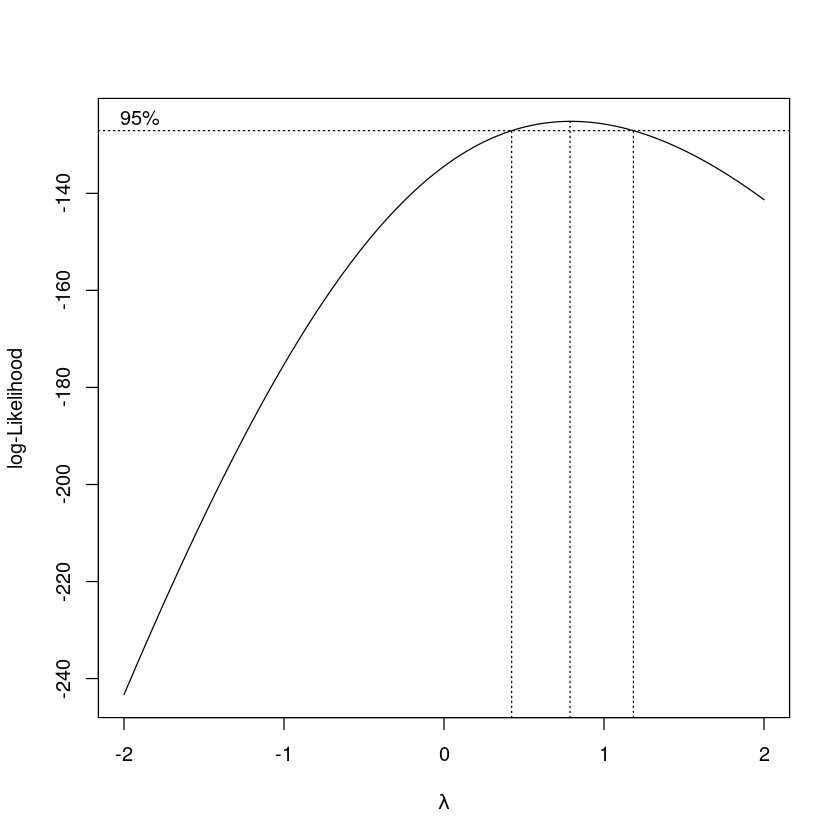

In [395]:
# Perform Box-Cox transformation on rainfall data
  elev <- d26$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d26$Elevation_Transformed <- el_transformed

In [396]:
coordinates1 = data.frame(lon = d26$Longitude, lat = d26$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d26_modb = subset(d26, select = -c(Longitude,Latitude))
sd_26 = SpatialPointsDataFrame(coords1,d26_modb)
class(sd_26)
proj4string(sd_26) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_26_prjtd <- spTransform(sd_26, CRS(desired_crs))
proj4string(sd_26_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [397]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-36.6407" " -0.0037" "  0.0131" "  2.5309" "  1.7980" " 37.7900" 
Practical Range with cor=0.05 for asymptotic range: 113.2087

likfit: maximised log-likelihood = -309.2

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-36.6407  -0.0037   0.0131 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.798
      (estimated) cor. fct. parameter phi (range parameter)  =  37.79
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.531

Transformation parameter:
      (fixed) Box-Cox parameter = 0.2222

Practical Range with cor=0.05 for asymptotic range: 113.2087

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-309.2"      "6"  "630.4"  "644.5" 

non spatial model:
   log.L n.params      AIC      BIC 
"-313.1"      "4"  "634.1"  "643.5" 

Call:
likfit(geodata = gdt_26, trend = "1st", ini.cov.pars = c(5.5, 
    1

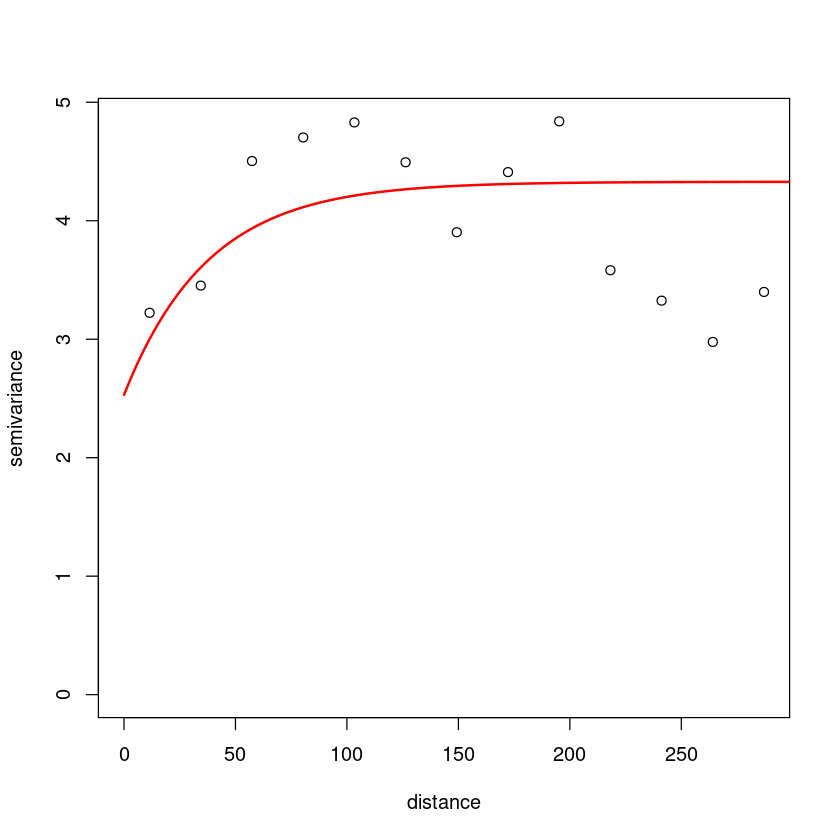

In [398]:
cord = coordinates(sd_26_prjtd)
rn = sd_26_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_26 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_26 = jitterDupCoords(gdt_26, max = jit_am)

vf_26 = variog(gdt_26, lambda = 0.222222222222222, trend = "1st")
plot(vf_26)

vgm_rn_lk_26 = likfit(geodata = gdt_26, trend = "1st",cov.model = "exponential", ini.cov.pars = c(5.5,100),nugget = 2, lambda = 0.222222222222222, lik.method = "ML", messages = FALSE)
vgm_rn_lk_26
summary(vgm_rn_lk_26)

# Add the fitted model
lines(vgm_rn_lk_26, col = "red", lwd = 2)

In [399]:
## Krg

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


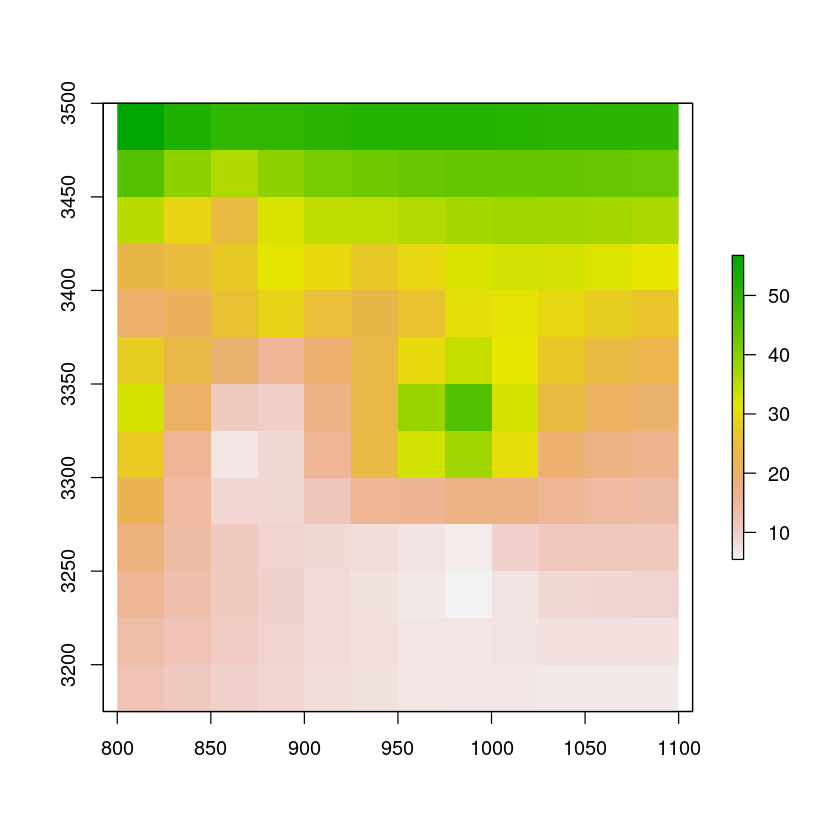

In [400]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_26 <- krige.conv(gdt_26, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_26))



krig_rain_lkft_26 <- krig_lkft_26$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_26 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_26))
proj4string(pr_rain_lkft_26) <- proj4string(grid_3sp)
plot(pr_rain_lkft_26)


In [401]:
## Regrss

Generalized Linear Model 

77 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 70, 70, 69, 69, 69, 69, ... 
Resampling results:

  RMSE      Rsquared    MAE     
  2.179482  0.07988654  1.826914

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-42.2938  -0.0034   0.0136 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.768
      (estimated) cor. fct. parameter phi (range parameter)  =  37.54
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.536

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 112.4673

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-160.6"      "6"  "333.1"  "347.2" 

non spatial model:
   log.L n.params      AIC      BIC 
"-164.3"      "4"  "336.7"  "346.1" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.co

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


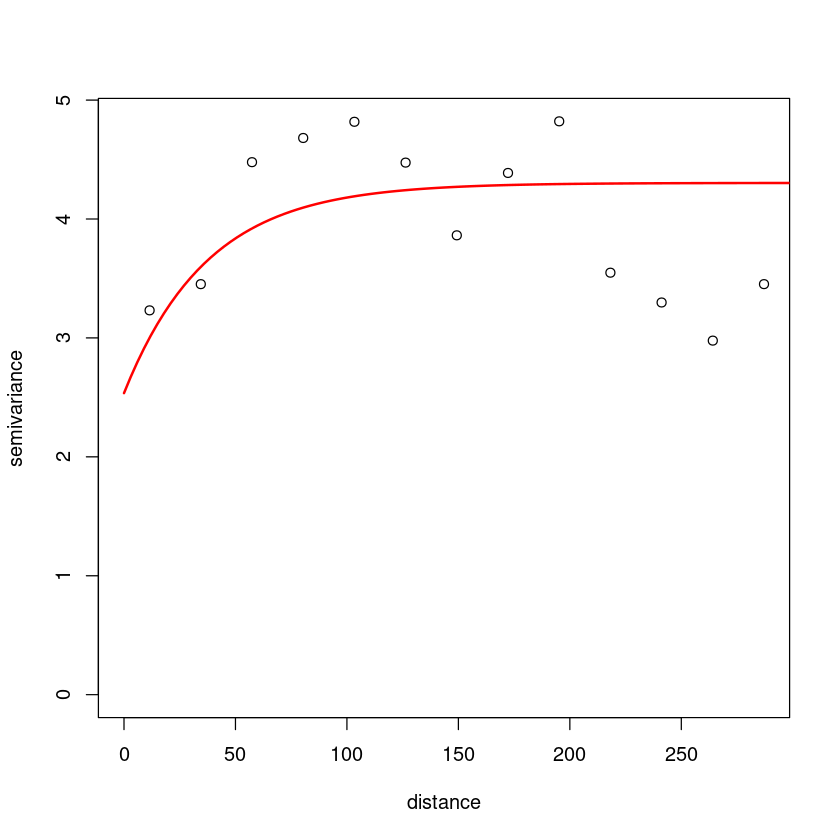

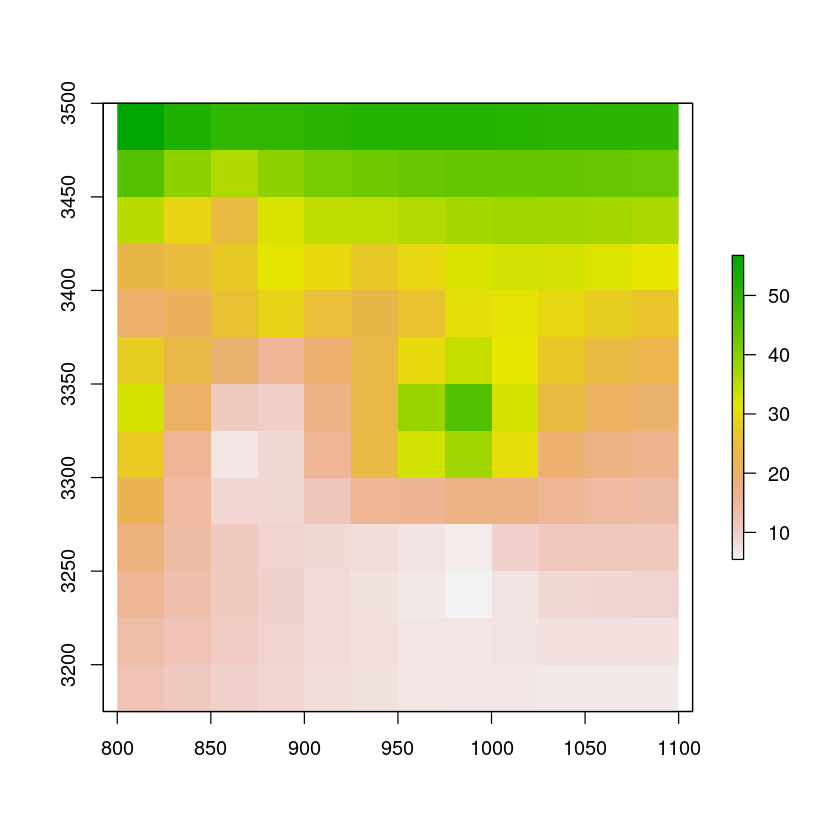

In [402]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_26 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_26))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_26 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(6, 100), 
                     nugget = 2, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_26)
lines(vgm_res_lk_26, col = "red", lwd = 2)

krig_lkft_regr_26 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_26))

krig_regr_26 <- krig_lkft_26$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_26 <- rasterFromXYZ(cbind(grid_df, krig_regr_26))
proj4string(pr_regr_lkft_26) <- proj4string(grid_3sp)
plot(pr_regr_lkft_26)


DAY 27

In [403]:
f27 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_27_July_23.csv"

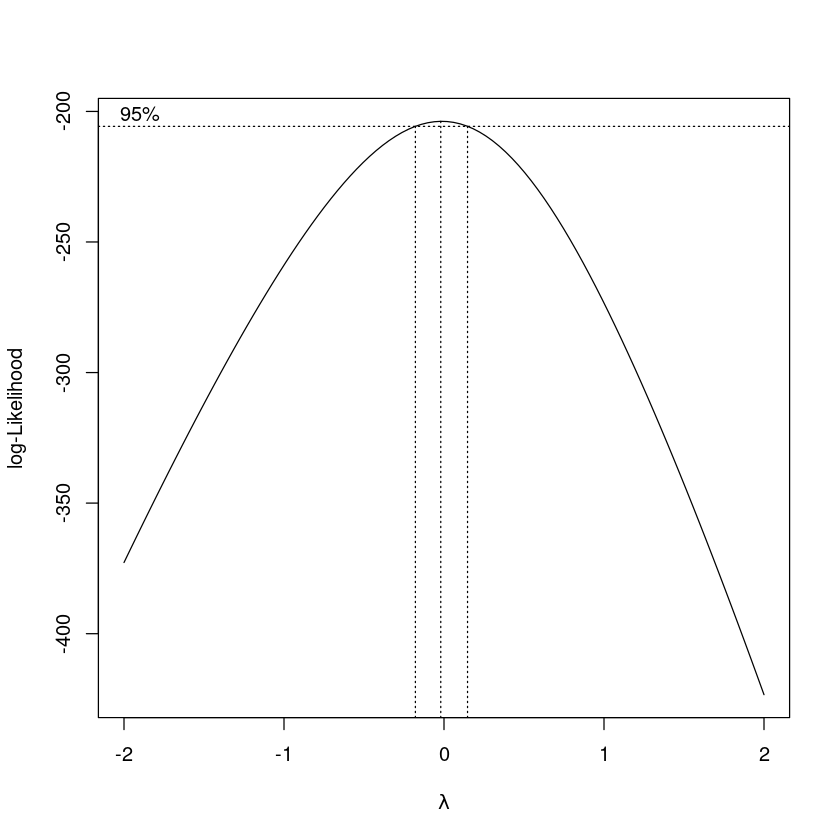

In [404]:
d27 = read.csv(f27)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d27$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d27$Rainfall_Transformed <- rain_transformed

In [405]:
lambda_rn

[1] -0.02020202

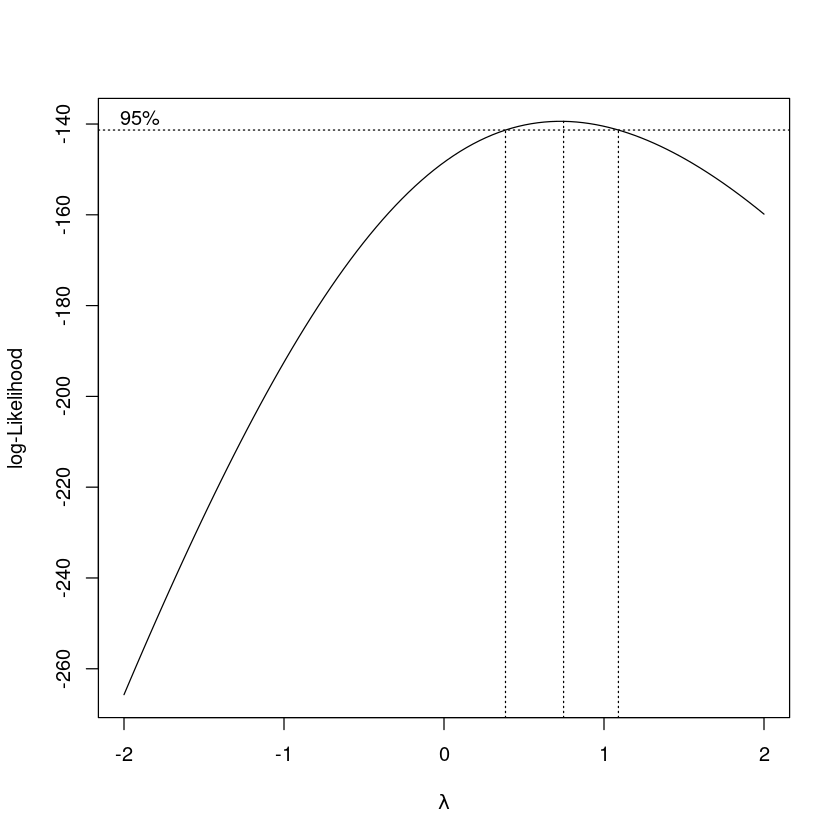

In [406]:
# Perform Box-Cox transformation on rainfall data
  elev <- d27$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d27$Elevation_Transformed <- el_transformed

In [407]:
coordinates1 = data.frame(lon = d27$Longitude, lat = d27$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d27_modb = subset(d27, select = -c(Longitude,Latitude))
sd_27 = SpatialPointsDataFrame(coords1,d27_modb)
class(sd_27)
proj4string(sd_27) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_27_prjtd <- spTransform(sd_27, CRS(desired_crs))
proj4string(sd_27_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [408]:
## Likfit Var

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
" 2.9675" " 0.0031" "-0.0013" " 0.5366" " 1.0401" "32.2413" 
Practical Range with cor=0.05 for asymptotic range: 96.58624

likfit: maximised log-likelihood = -234.9

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
 2.9675  0.0031 -0.0013 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.04
      (estimated) cor. fct. parameter phi (range parameter)  =  32.24
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.5366

Transformation parameter:
      (fixed) Box-Cox parameter = -0.0202

Practical Range with cor=0.05 for asymptotic range: 96.58624

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-234.9"      "6"  "481.8"  "496.2" 

non spatial model:
   log.L n.params      AIC      BIC 
"-244.3"      "4"  "496.6"  "506.1" 

Call:
likfit(geodata = gdt_27, trend = "1st", ini.cov.pars = c(2, 80), 
    nug

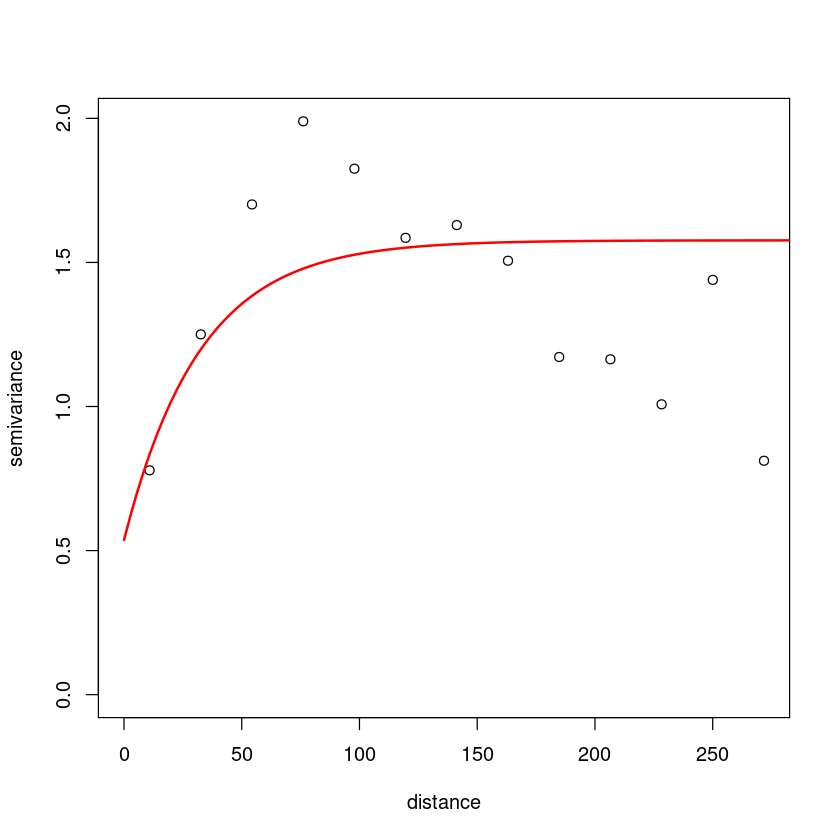

In [409]:
cord = coordinates(sd_27_prjtd)
rn = sd_27_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_27 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_27 = jitterDupCoords(gdt_27, max = jit_am)

vf_27 = variog(gdt_27, lambda = -0.0202020202020201, trend = "1st")
plot(vf_27)
vgm_rn_lk_27 = likfit(geodata = gdt_27, trend = "1st",cov.model = "exponential", ini.cov.pars = c(2,80),nugget = 1, lambda = -0.0202020202020201, lik.method = "ML", messages = FALSE)
vgm_rn_lk_27
summary(vgm_rn_lk_27)

# Add the fitted model
lines(vgm_rn_lk_27, col = "red", lwd = 2)

In [410]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


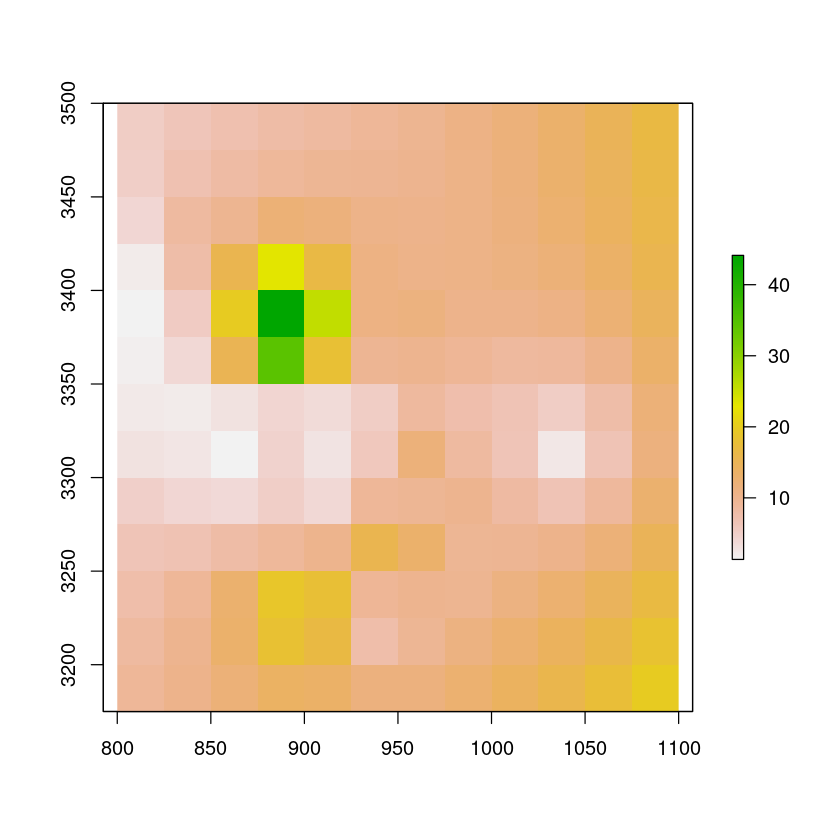

In [411]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_27 <- krige.conv(gdt_27, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_27))



krig_rain_lkft_27 <- krig_lkft_27$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_27 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_27))
proj4string(pr_rain_lkft_27) <- proj4string(grid_3sp)
plot(pr_rain_lkft_27)

In [412]:
## Regression

Generalized Linear Model 

81 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 73, 71, 73, 73, 73, 73, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.362275  0.1388723  1.141717

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
 3.1202  0.0029 -0.0017 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  1.046
      (estimated) cor. fct. parameter phi (range parameter)  =  32.1
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.531

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 96.15501

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-122.9"      "6"  "257.8"  "272.2" 

non spatial model:
   log.L n.params      AIC      BIC 
"-132.5"      "4"  "272.9"  "282.5" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars 

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


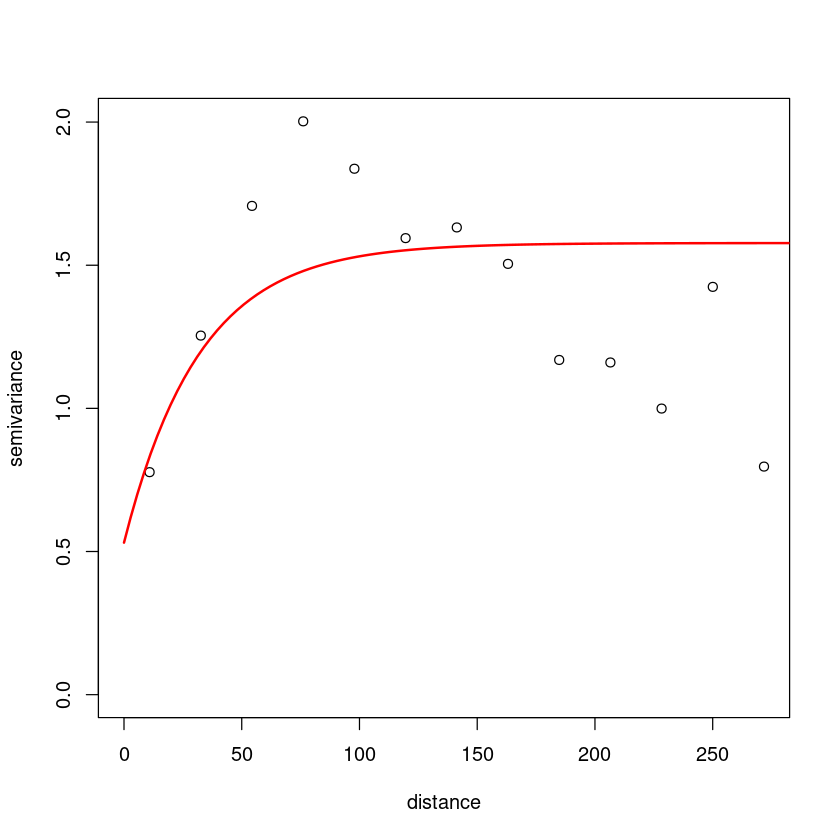

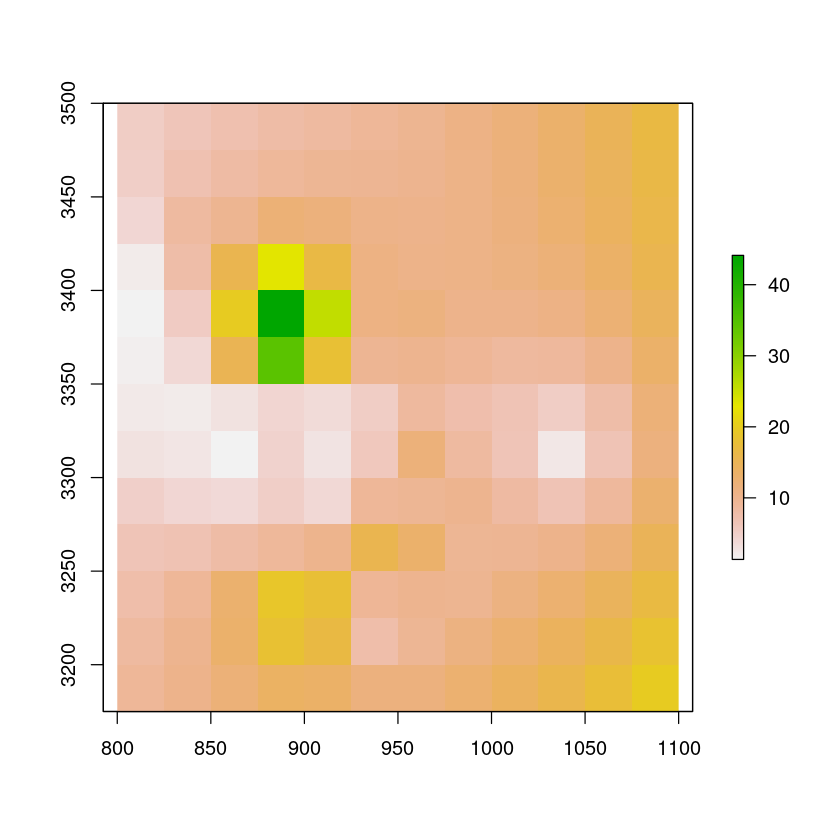

In [413]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_27 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_27))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_27 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(3, 80), 
                     nugget = 0.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_27)
lines(vgm_res_lk_27, col = "red", lwd = 2)

krig_lkft_regr_27 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_27))

krig_regr_27 <- krig_lkft_27$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_27 <- rasterFromXYZ(cbind(grid_df, krig_regr_27))
proj4string(pr_regr_lkft_27) <- proj4string(grid_3sp)
plot(pr_regr_lkft_27)


DAY 28

In [414]:
f28 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_28_July_23.csv"

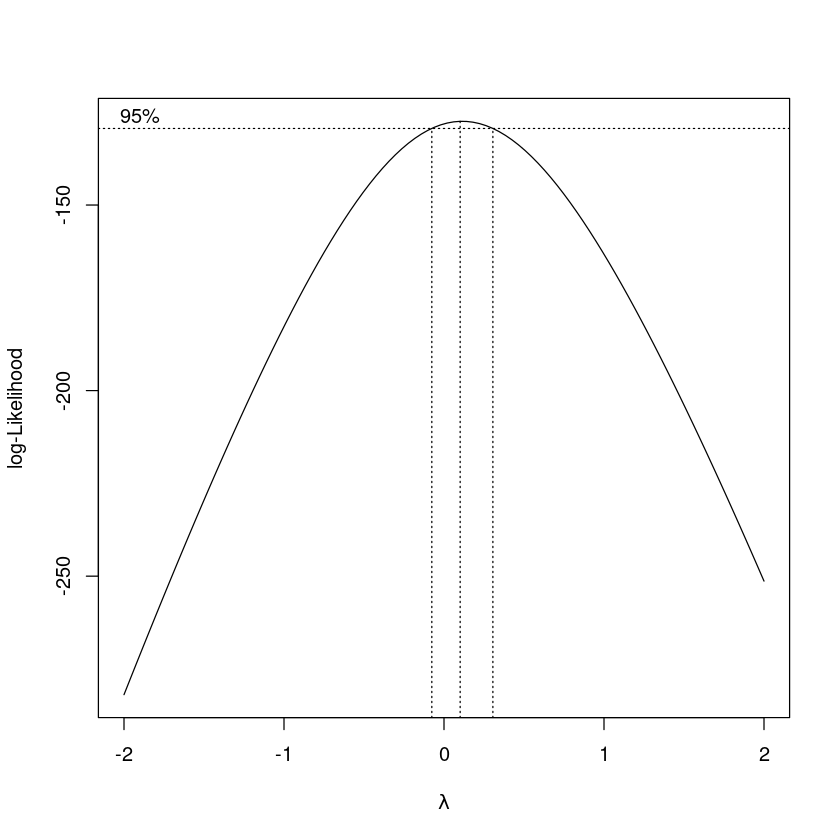

In [415]:
d28 = read.csv(f28)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d28$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d28$Rainfall_Transformed <- rain_transformed

In [416]:
lambda_rn

[1] 0.1010101

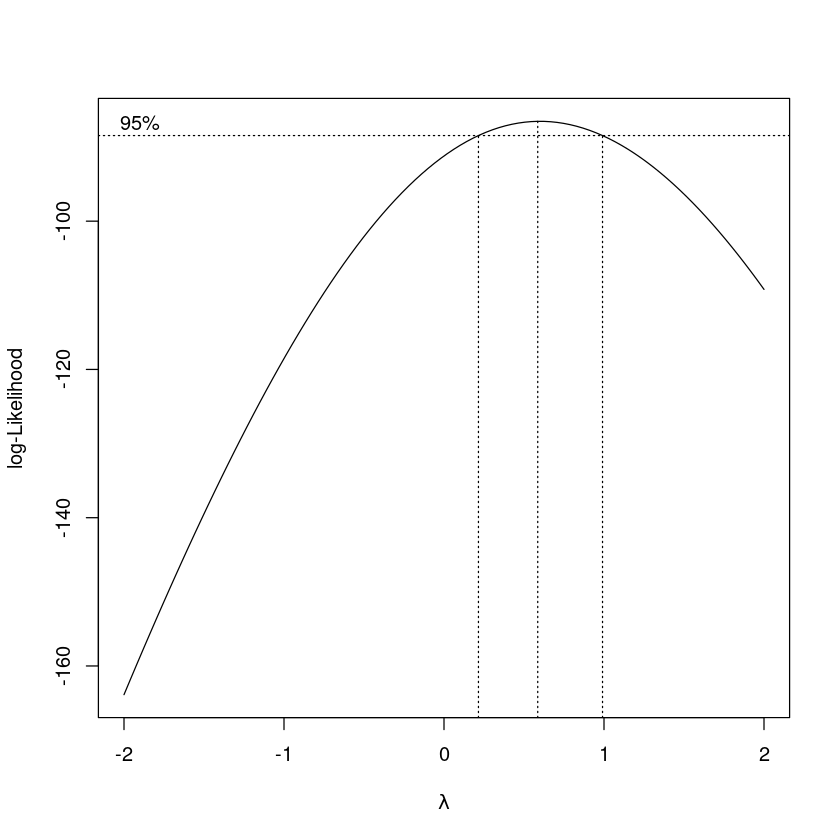

In [417]:
# Perform Box-Cox transformation on rainfall data
  elev <- d28$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d28$Elevation_Transformed <- el_transformed

In [418]:
coordinates1 = data.frame(lon = d28$Longitude, lat = d28$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d28_modb = subset(d28, select = -c(Longitude,Latitude))
sd_28 = SpatialPointsDataFrame(coords1,d28_modb)
class(sd_28)
proj4string(sd_28) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_28_prjtd <- spTransform(sd_28, CRS(desired_crs))
proj4string(sd_28_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [419]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
"23.0146" " 0.0000" "-0.0062" " 0.2864" " 3.3983" " 9.9381" 
Practical Range with cor=0.05 for asymptotic range: 17.2011

likfit: maximised log-likelihood = -193.5

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
23.0146  0.0000 -0.0062 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  3.398
      (estimated) cor. fct. parameter phi (range parameter)  =  9.938
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.2864

Transformation parameter:
      (fixed) Box-Cox parameter = 0.101

Practical Range with cor=0.05 for asymptotic range: 17.2011

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-193.5"      "6"  "399.1"  "410.8" 

non spatial model:
   log.L n.params      AIC      BIC 
"-196.2"      "4"  "400.3"  "408.2" 

Call:
likfit(geodata = gdt_28, trend = "1st", ini.cov.pars = c(4, 100), 
    nugget 

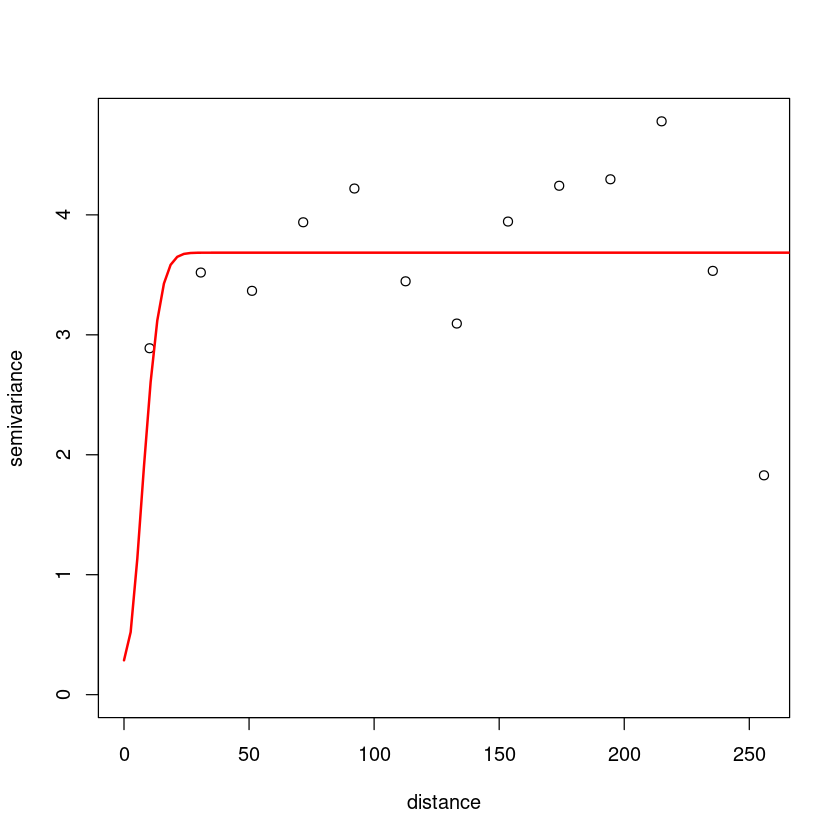

In [420]:
cord = coordinates(sd_28_prjtd)
rn = sd_28_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_28 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_28 = jitterDupCoords(gdt_28, max = jit_am)

vf_28 = variog(gdt_28, lambda = 0.101010101010101, trend = "1st")
plot(vf_28)

vgm_rn_lk_28 = likfit(geodata = gdt_28, trend = "1st",cov.model = "gaussian", ini.cov.pars = c(4,100),nugget = 2, lambda = 0.101010101010101, lik.method = "ML", messages = FALSE)
vgm_rn_lk_28
summary(vgm_rn_lk_28)

# Add the fitted model
lines(vgm_rn_lk_28, col = "red", lwd = 2)


In [421]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


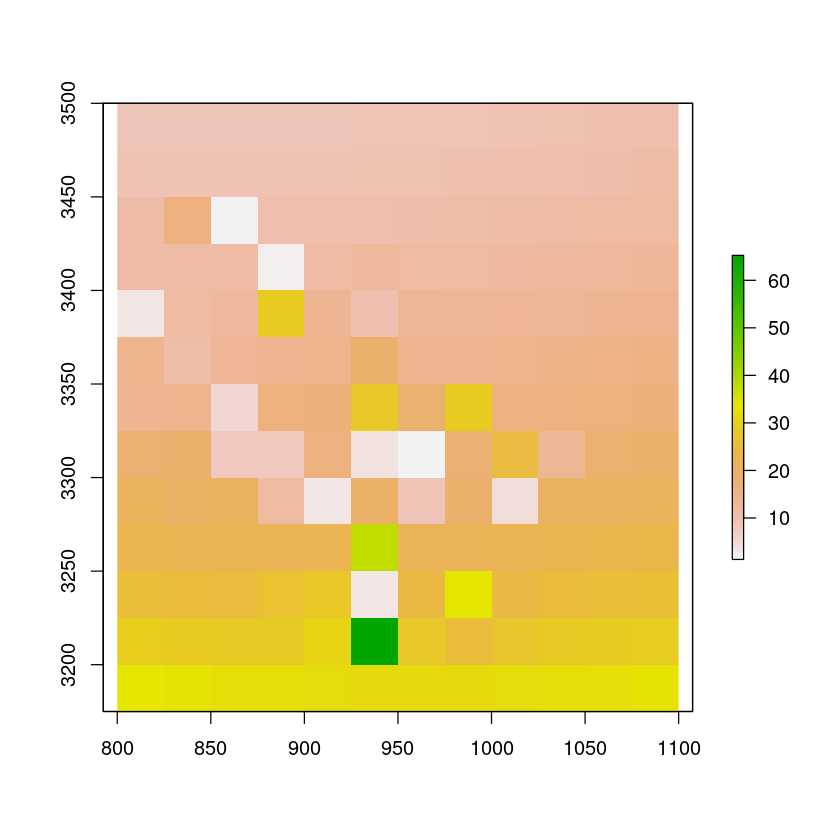

In [422]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_28 <- krige.conv(gdt_28, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_28))



krig_rain_lkft_28 <- krig_lkft_28$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_28 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_28))
proj4string(pr_rain_lkft_28) <- proj4string(grid_3sp)
plot(pr_rain_lkft_28)

In [423]:
## Regression

Generalized Linear Model 

52 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 46, 47, 46, 47, 48, 46, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.933132  0.1492447  1.707406

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
13.0489  0.0009 -0.0042 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  3.414
      (estimated) cor. fct. parameter phi (range parameter)  =  9.941
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.2944

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 17.20677

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-105.2"      "6"  "222.4"  "234.1" 

non spatial model:
   log.L n.params      AIC      BIC 
"-107.8"      "4"  "223.6"  "231.4" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.pars =

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


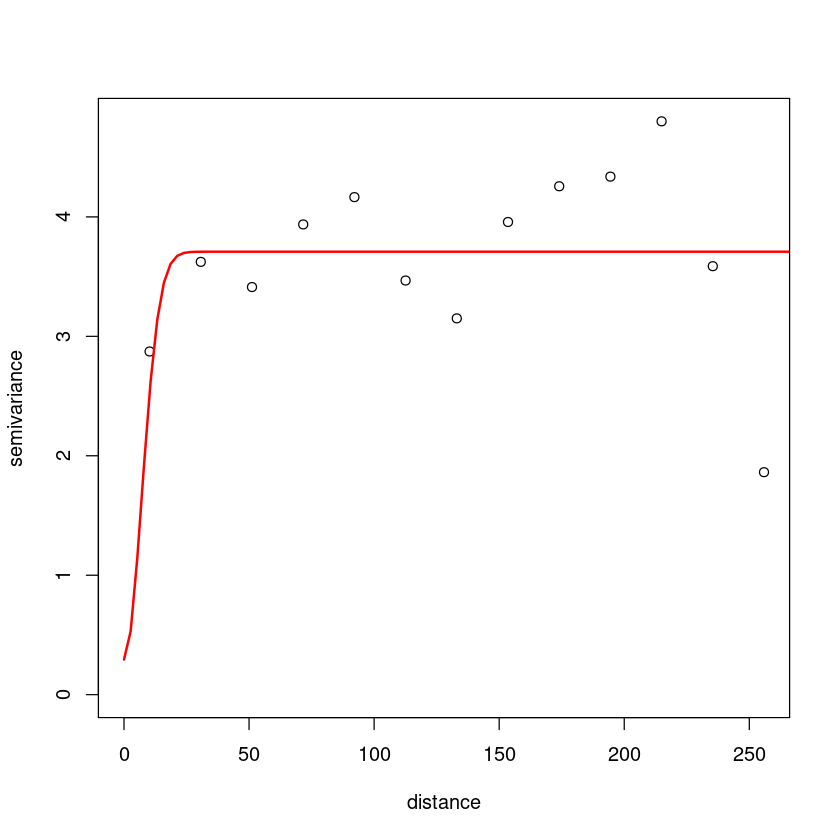

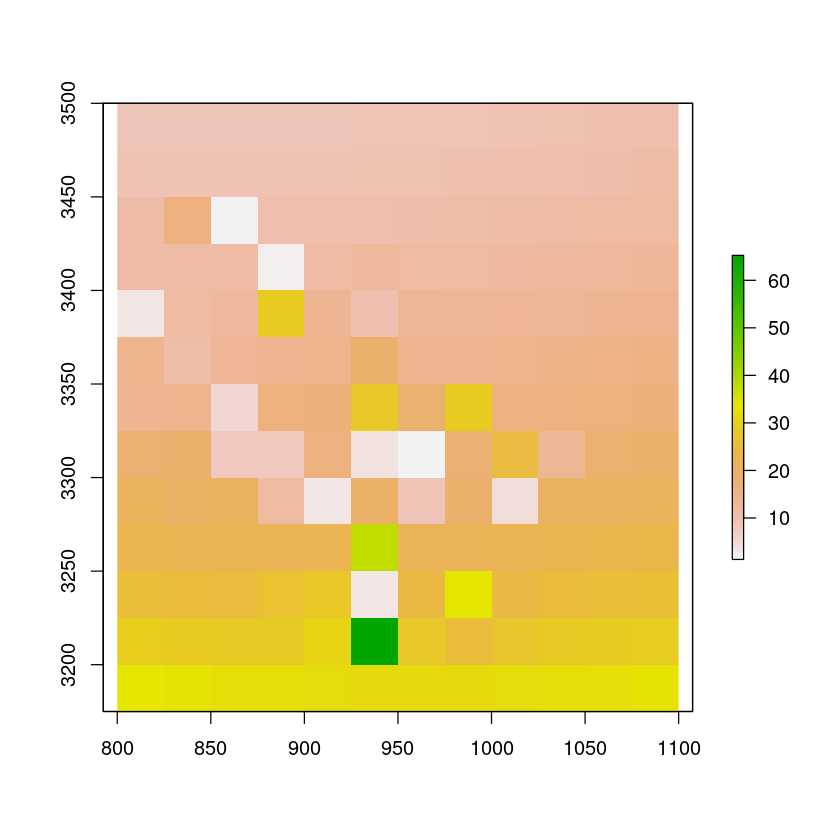

In [424]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_28 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_28))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_28 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "gaussian", 
                     ini.cov.pars = c(4, 60), 
                     nugget = 2, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_28)
lines(vgm_res_lk_28, col = "red", lwd = 2)

krig_lkft_regr_28 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_28))

krig_regr_28 <- krig_lkft_28$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_28 <- rasterFromXYZ(cbind(grid_df, krig_regr_28))
proj4string(pr_regr_lkft_28) <- proj4string(grid_3sp)
plot(pr_regr_lkft_28)


DAY 29

In [425]:
f29 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_29_July_23.csv"

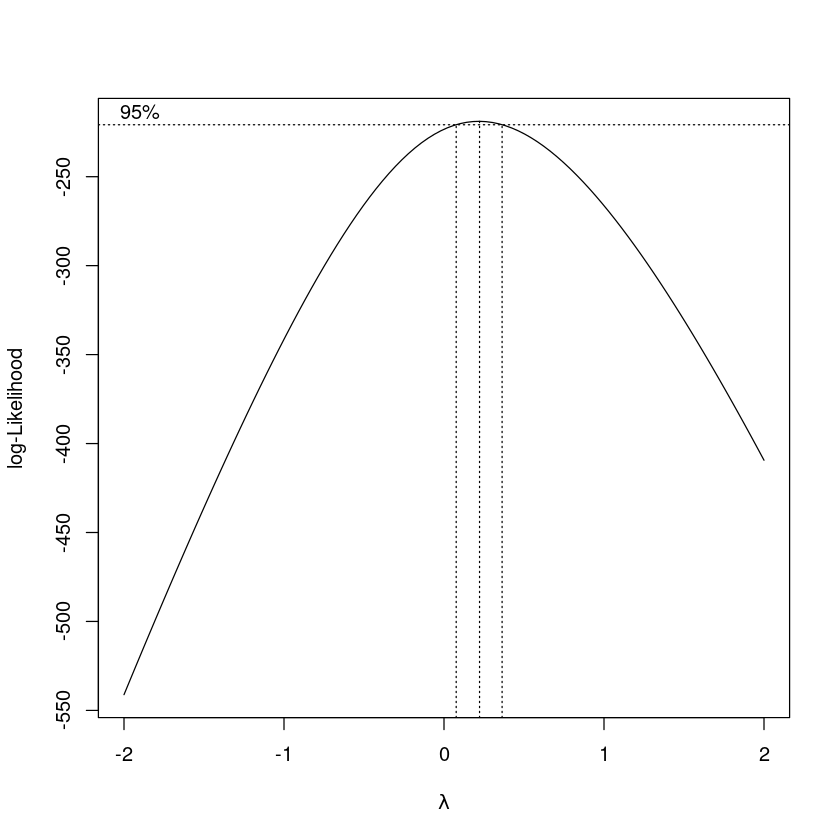

In [426]:
d29 = read.csv(f29)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d29$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d29$Rainfall_Transformed <- rain_transformed

In [427]:
lambda_rn

[1] 0.2222222

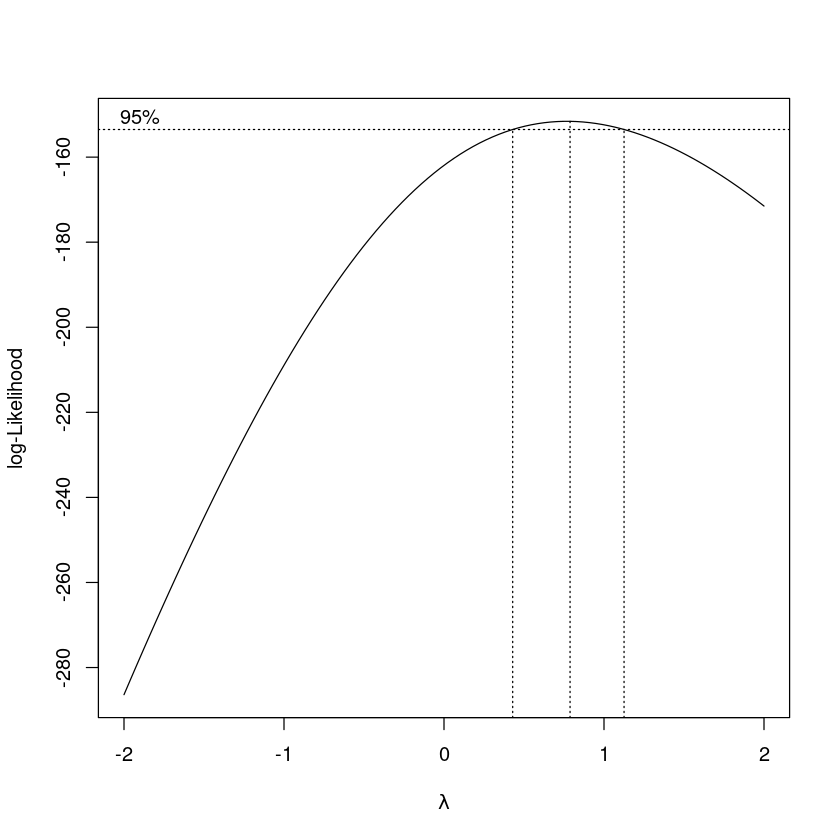

In [428]:
# Perform Box-Cox transformation on rainfall data
  elev <- d29$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d29$Elevation_Transformed <- el_transformed

In [429]:
coordinates1 = data.frame(lon = d29$Longitude, lat = d29$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d29_modb = subset(d29, select = -c(Longitude,Latitude))
sd_29 = SpatialPointsDataFrame(coords1,d29_modb)
class(sd_29)
proj4string(sd_29) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_29_prjtd <- spTransform(sd_29, CRS(desired_crs))
proj4string(sd_29_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [430]:
## Likfit Var

variog: computing omnidirectional variogram


likfit: estimated model parameters:
     beta0      beta1      beta2      tausq    sigmasq        phi 
"-36.3991" "  0.0026" "  0.0113" "  2.9498" "  1.9478" " 25.6092" 
Practical Range with cor=0.05 for asymptotic range: 44.32478

likfit: maximised log-likelihood = -345.5

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-36.3991   0.0026   0.0113 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  1.948
      (estimated) cor. fct. parameter phi (range parameter)  =  25.61
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.95

Transformation parameter:
      (fixed) Box-Cox parameter = 0.2222

Practical Range with cor=0.05 for asymptotic range: 44.32478

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-345.5"      "6"  "703.1"  "717.9" 

non spatial model:
   log.L n.params      AIC      BIC 
"-349.2"      "4"  "706.5"  "716.3" 

Call:
likfit(geodata = gdt_29, trend = "1st", ini.cov.pars = c(5, 80), 
    nu

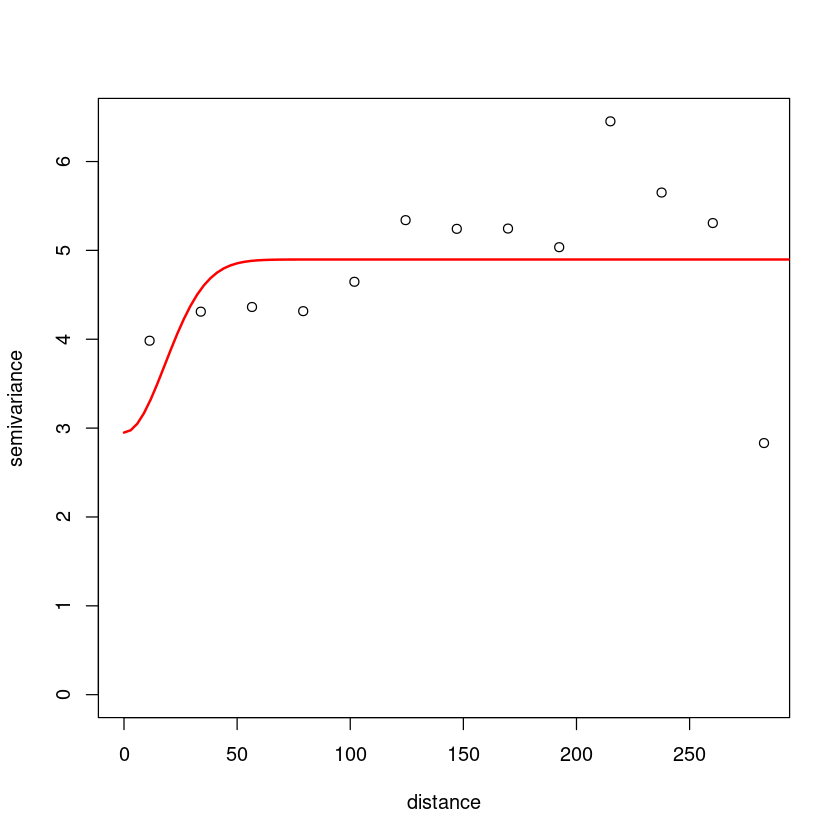

In [431]:
cord = coordinates(sd_29_prjtd)
rn = sd_29_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_29 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_29 = jitterDupCoords(gdt_29, max = jit_am)

vf_29 = variog(gdt_29, lambda = 0.222222222222222, trend = "1st")
plot(vf_29)
vgm_rn_lk_29 = likfit(geodata = gdt_29, trend = "1st",cov.model = "gaussian", ini.cov.pars = c(5,80),nugget = 3, lambda = 0.222222222222222, lik.method = "ML", messages = FALSE)
vgm_rn_lk_29
summary(vgm_rn_lk_29)

# Add the fitted model
lines(vgm_rn_lk_29, col = "red", lwd = 2)

In [432]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


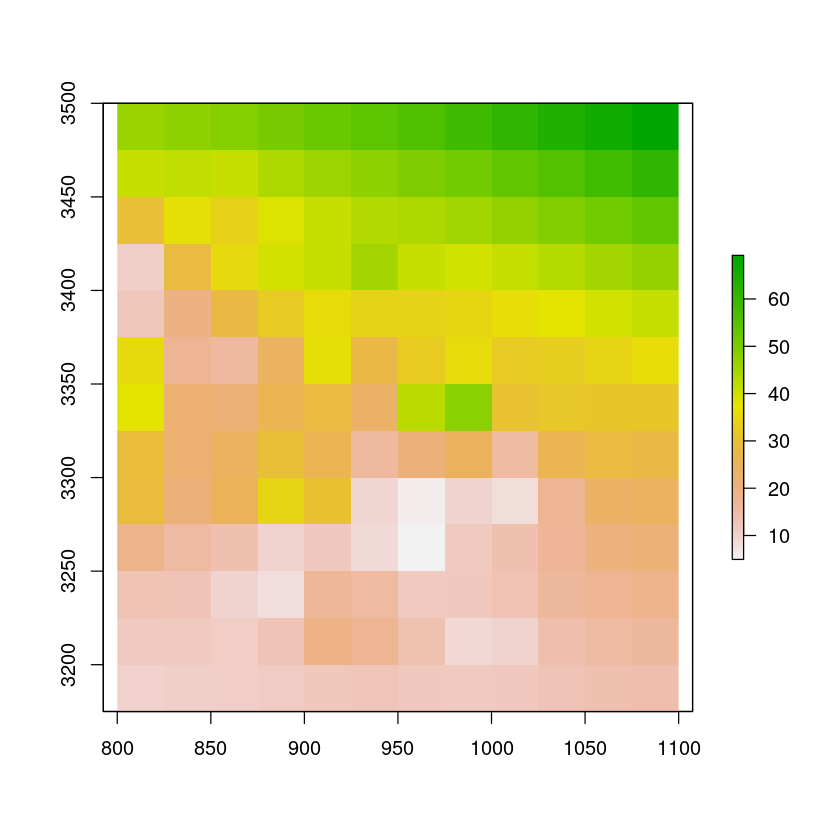

In [433]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_29 <- krige.conv(gdt_29, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_29))



krig_rain_lkft_29 <- krig_lkft_29$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_29 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_29))
proj4string(pr_rain_lkft_29) <- proj4string(grid_3sp)
plot(pr_rain_lkft_29)


In [434]:
## Regression

Generalized Linear Model 

87 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 78, 78, 78, 77, 79, 79, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  2.229249  0.1413891  1.804824

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-27.0175   0.0011   0.0079 

Parameters of the spatial component:
   correlation function: gaussian
      (estimated) variance parameter sigmasq (partial sill) =  2.065
      (estimated) cor. fct. parameter phi (range parameter)  =  26.48
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  2.864

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 45.84073

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-187.4"      "6"  "386.9"  "401.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-191.7"      "4"  "391.4"  "401.3" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.p

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


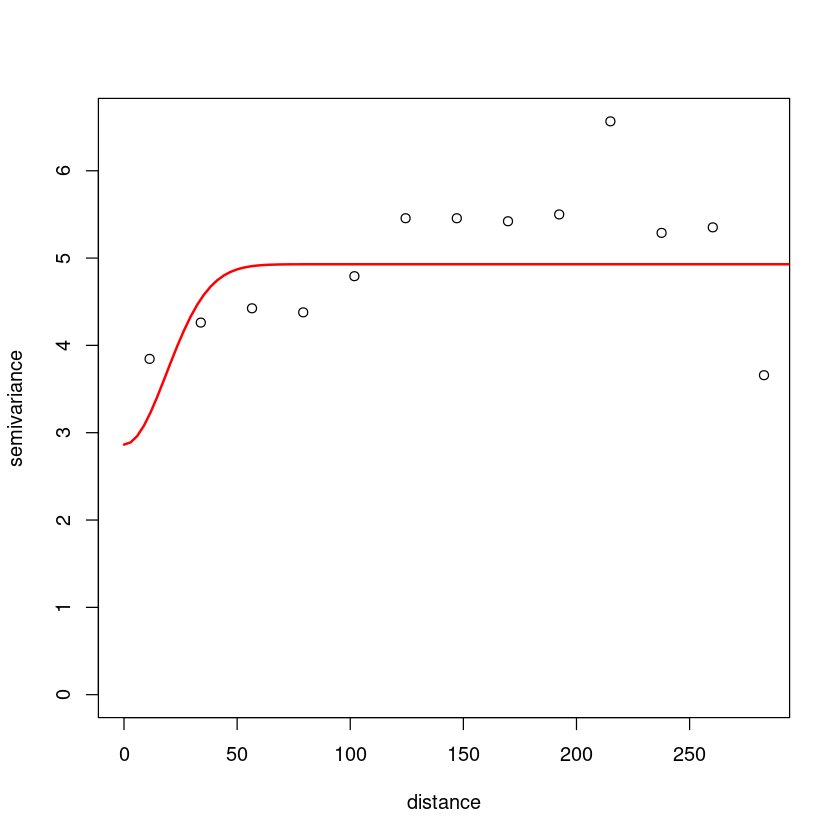

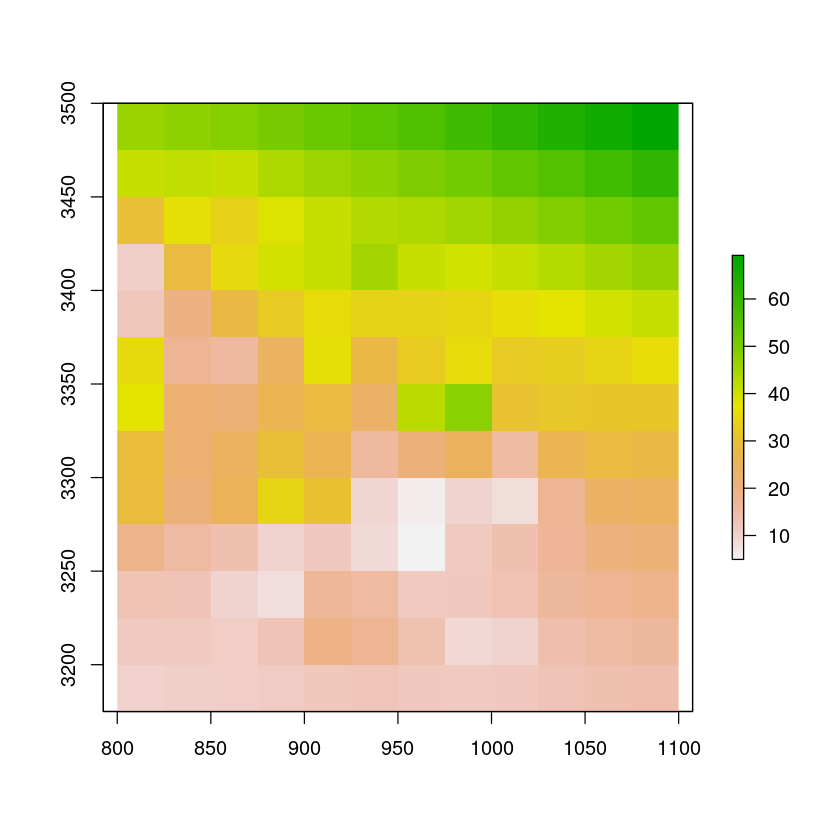

In [435]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_29 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_29))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "cte")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_29 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "gaussian", 
                     ini.cov.pars = c(5, 80), 
                     nugget = 3, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_29)
lines(vgm_res_lk_29, col = "red", lwd = 2)

krig_lkft_regr_29 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_29))

krig_regr_29 <- krig_lkft_29$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_29 <- rasterFromXYZ(cbind(grid_df, krig_regr_29))
proj4string(pr_regr_lkft_29) <- proj4string(grid_3sp)
plot(pr_regr_lkft_29)


DAY 30

In [436]:
f30 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_30_July_23.csv"

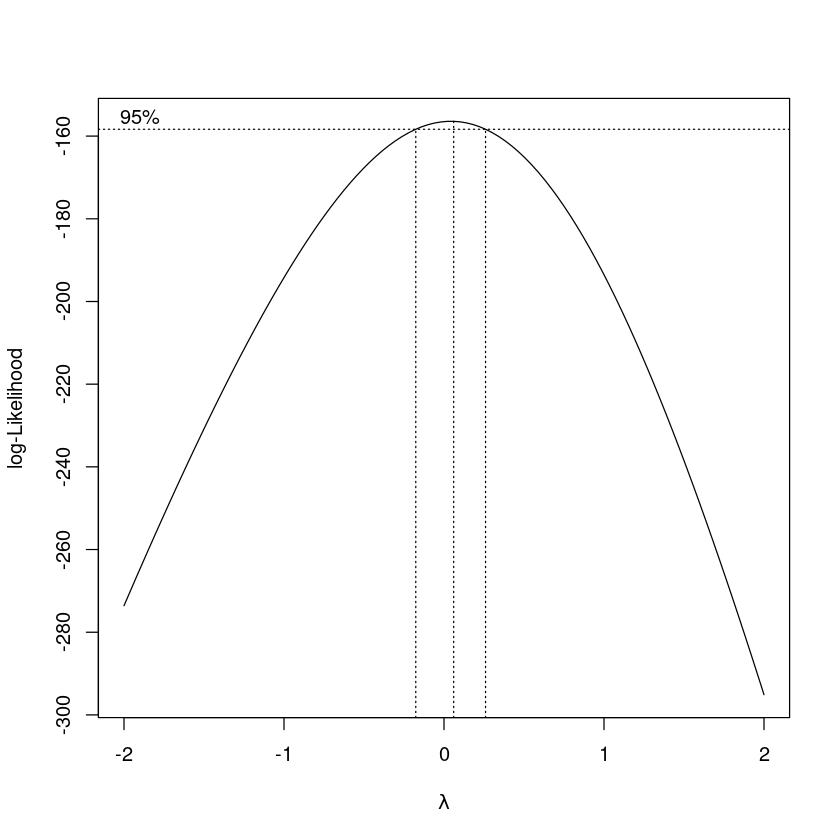

In [437]:
d30 = read.csv(f30)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d30$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d30$Rainfall_Transformed <- rain_transformed

In [438]:
lambda_rn

[1] 0.06060606

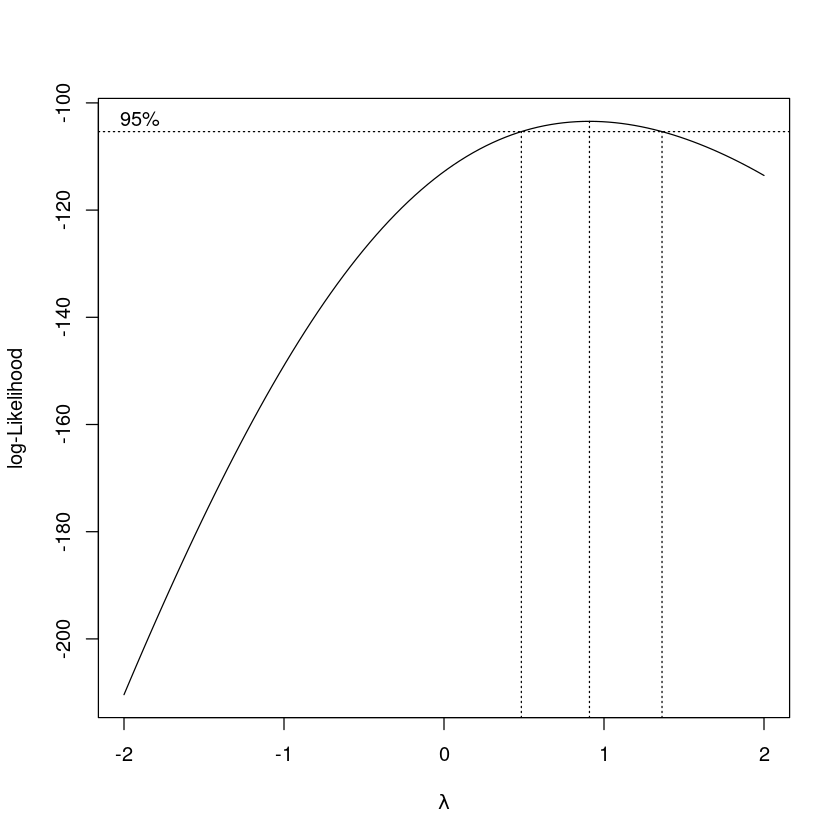

In [439]:
# Perform Box-Cox transformation on rainfall data
  elev <- d30$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d30$Elevation_Transformed <- el_transformed

In [440]:
coordinates1 = data.frame(lon = d30$Longitude, lat = d30$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d30_modb = subset(d30, select = -c(Longitude,Latitude))
sd_30 = SpatialPointsDataFrame(coords1,d30_modb)
class(sd_30)
proj4string(sd_30) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_30_prjtd <- spTransform(sd_30, CRS(desired_crs))
proj4string(sd_30_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [441]:
## Likfit

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
" 5.7529" " 0.0046" "-0.0026" " 1.1382" " 0.1433" "12.1546" 
Practical Range with cor=0.05 for asymptotic range: 36.41202

likfit: maximised log-likelihood = -178.1

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
 5.7529  0.0046 -0.0026 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0.1433
      (estimated) cor. fct. parameter phi (range parameter)  =  12.15
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.138

Transformation parameter:
      (fixed) Box-Cox parameter = 0.0606

Practical Range with cor=0.05 for asymptotic range: 36.41202

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-178.1"      "6"  "368.2"  "381.7" 

non spatial model:
   log.L n.params      AIC      BIC 
"-178.2"      "4"  "364.4"  "373.4" 

Call:
likfit(geodata = gdt_30, trend = "1st", ini.cov.pars = c(1.5, 
    80), n

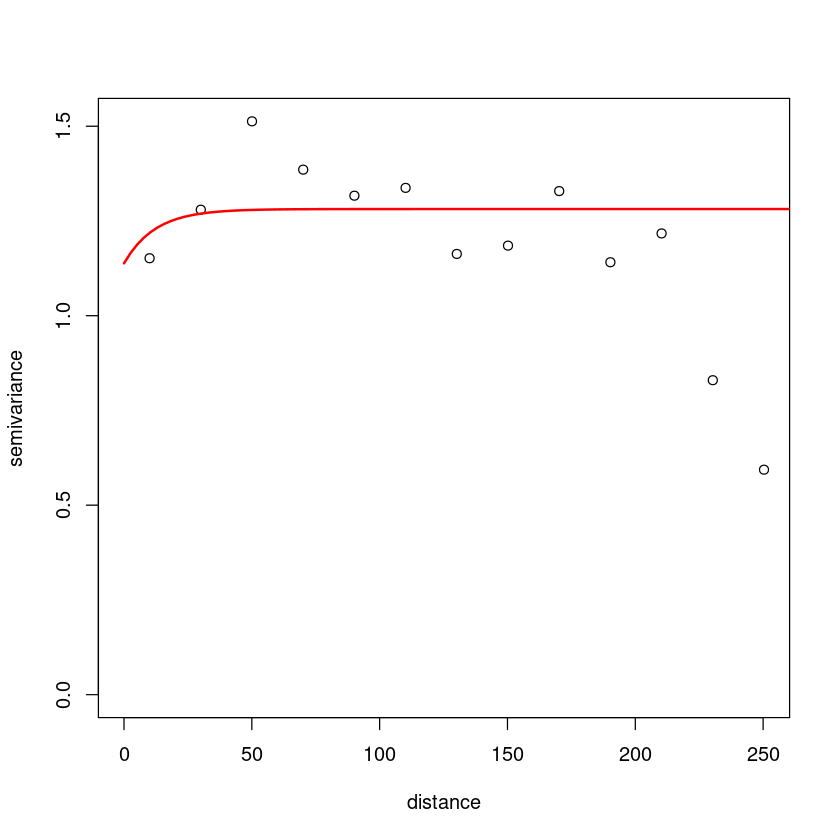

In [442]:
cord = coordinates(sd_30_prjtd)
rn = sd_30_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_30 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_30 = jitterDupCoords(gdt_30, max = jit_am)

vf_30 = variog(gdt_30, lambda = 0.060606060606061, trend = "1st")
plot(vf_30)
vgm_rn_lk_30 = likfit(geodata = gdt_30, trend = "1st",cov.model = "exponential", ini.cov.pars = c(1.5,80),nugget = 0.8, lambda = 0.060606060606061, lik.method = "ML", messages = FALSE)
vgm_rn_lk_30
summary(vgm_rn_lk_30)

# Add the fitted model
lines(vgm_rn_lk_30, col = "red", lwd = 2)

In [443]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


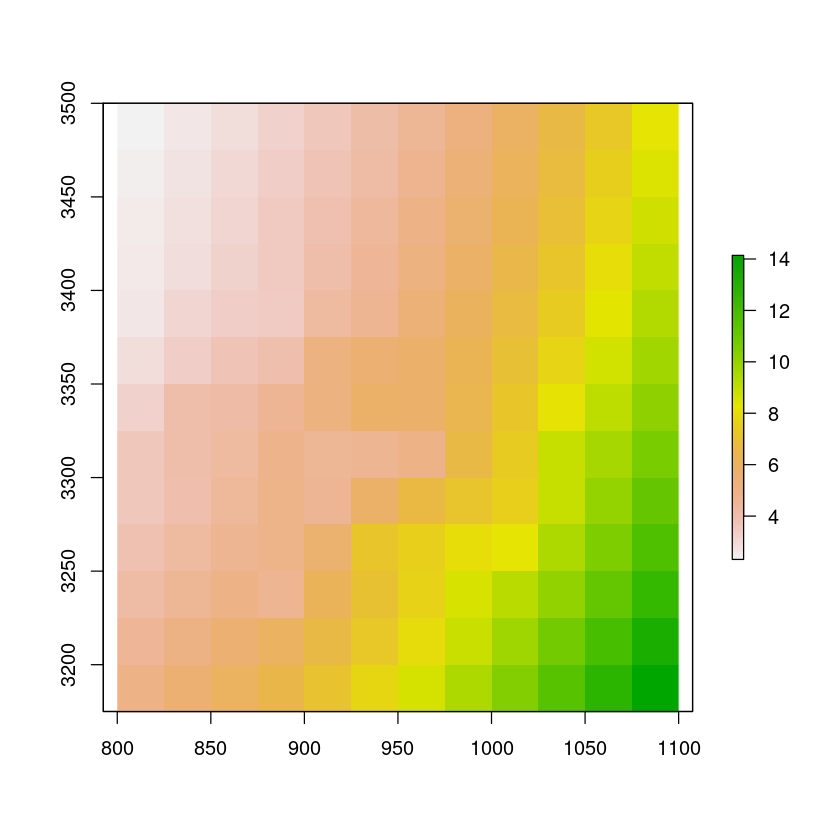

In [444]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_30 <- krige.conv(gdt_30, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_30))



krig_rain_lkft_30 <- krig_lkft_30$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_30 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_30))
proj4string(pr_rain_lkft_30) <- proj4string(grid_3sp)
plot(pr_rain_lkft_30)

In [445]:
## Regression

Generalized Linear Model 

70 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 64, 64, 65, 62, 63, 63, ... 
Resampling results:

  RMSE      Rsquared   MAE      
  1.162713  0.1643917  0.9869876

as.geodata: 1 replicated data locations found. 
 Consider using jitterDupCoords() for jittering replicated locations. 
 Use function dup.coords() to locate duplicated coordinates.
 Consider using jitterDupCoords() for jittering replicated locations 
variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
16.2269  0.0031 -0.0057 

Parameters of the spatial component:
   correlation function: exponential
      (estimated) variance parameter sigmasq (partial sill) =  0.1447
      (estimated) cor. fct. parameter phi (range parameter)  =  14.73
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  1.032

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 44.11702

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-104.9"      "6"  "221.8"  "235.3" 

non spatial model:
   log.L n.params      AIC      BIC 
  "-105"      "4"    "218"    "227" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov.par

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


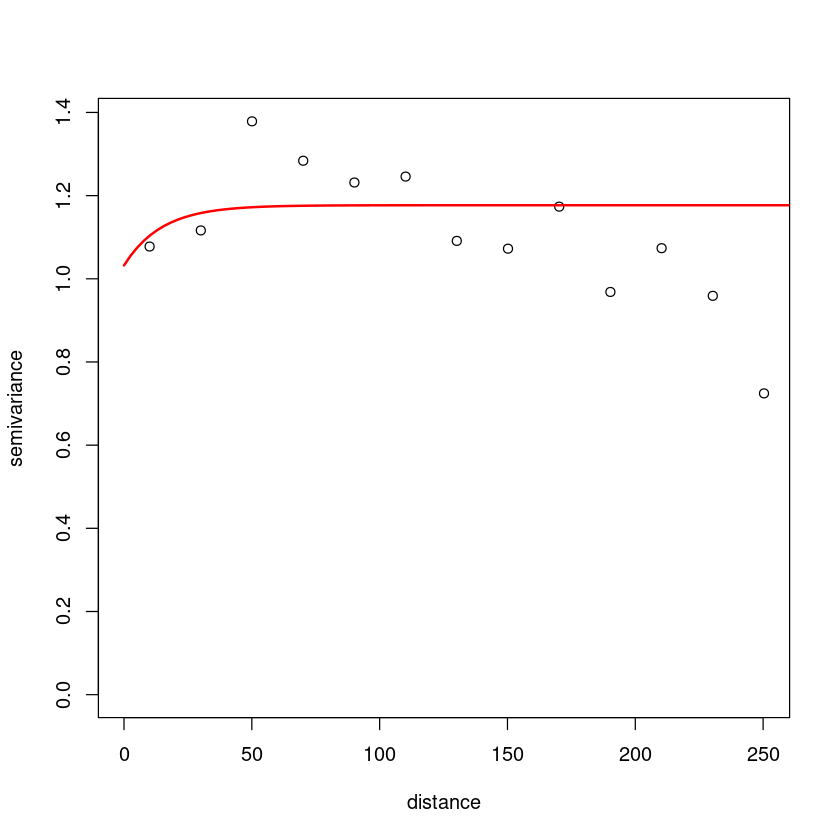

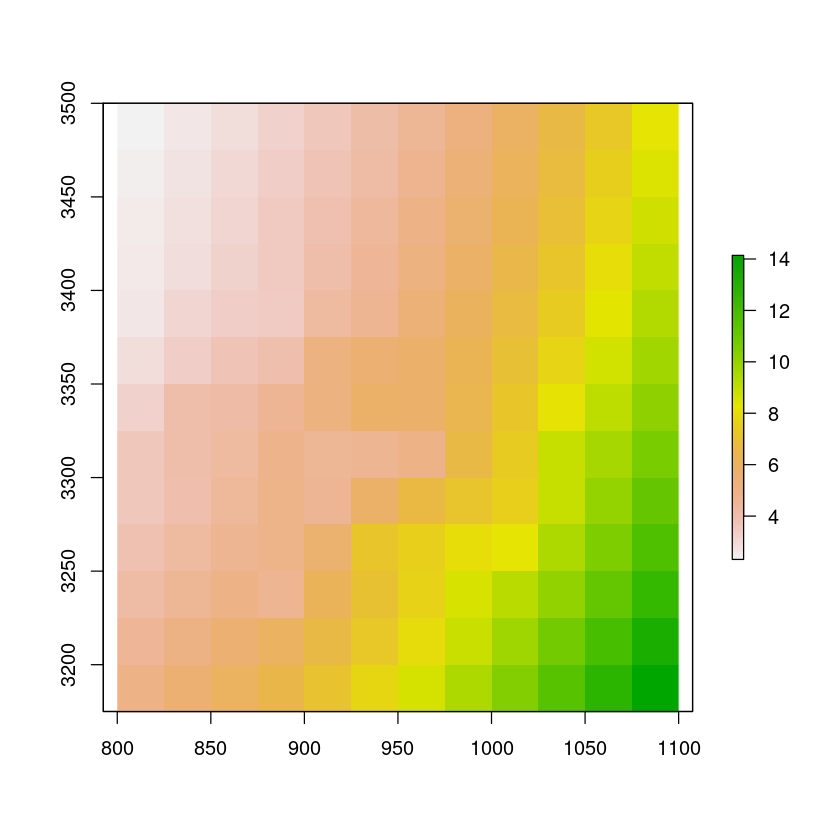

In [446]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_30 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_30))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_30 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "exponential", 
                     ini.cov.pars = c(1.5, 30), 
                     nugget = 0.9, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_30)
lines(vgm_res_lk_30, col = "red", lwd = 2)

krig_lkft_regr_30 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_30))

krig_regr_30 <- krig_lkft_30$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_30 <- rasterFromXYZ(cbind(grid_df, krig_regr_30))
proj4string(pr_regr_lkft_30) <- proj4string(grid_3sp)
plot(pr_regr_lkft_30)


DAY 31

In [447]:
f31 = "/data/private/GPM/Data_1/July_2023_with_elev/processed_31_July_23.csv"

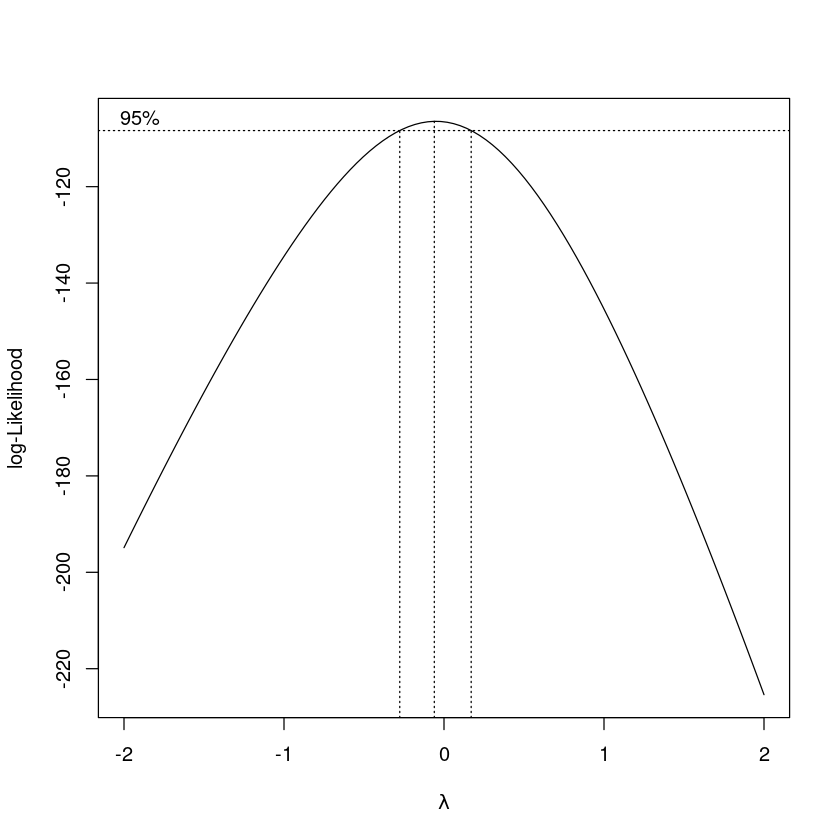

In [448]:
d31 = read.csv(f31)

  
  # Perform Box-Cox transformation on rainfall data
  rain <- d31$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
  bc_rn <- boxcox(rain ~ 1)
  lambda_rn <- bc_rn$x[which.max(bc_rn$y)]
  
  # Transform the rainfall data using the optimal lambda
  rain_transformed <- (rain ^ lambda_rn - 1) / lambda_rn
  
  # Add the transformed rainfall data to the dataframe
  d31$Rainfall_Transformed <- rain_transformed

In [449]:
lambda_rn

[1] -0.06060606

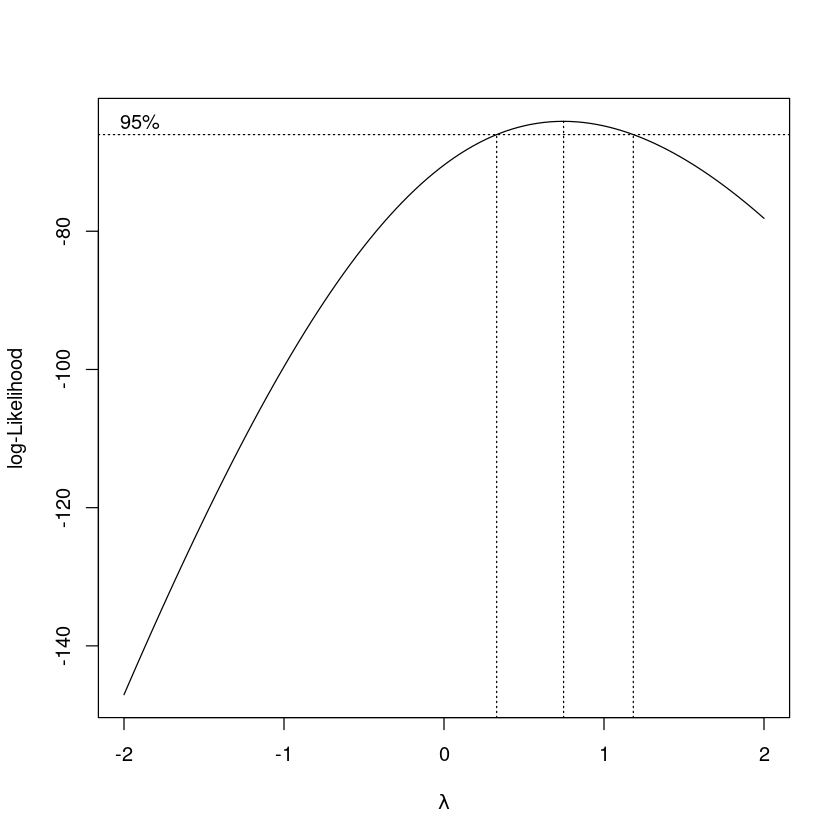

In [450]:
# Perform Box-Cox transformation on rainfall data
  elev <- d31$Elevation
  bc_el <- boxcox(elev ~ 1)
  lambda_el <- bc_el$x[which.max(bc_el$y)]
  
  # Transform the rainfall data using the optimal lambda
  el_transformed <- (elev^ lambda_el - 1) / lambda_el
  
  # Add the transformed rainfall data to the dataframe
  d31$Elevation_Transformed <- el_transformed

In [451]:
coordinates1 = data.frame(lon = d31$Longitude, lat = d31$Latitude)
coords1 = SpatialPoints(coordinates1)# make it Spatial Pixels
d31_modb = subset(d31, select = -c(Longitude,Latitude))
sd_31 = SpatialPointsDataFrame(coords1,d31_modb)
class(sd_31)
proj4string(sd_31) =CRS("+init=epsg:4326")
desired_crs <- "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"
sd_31_prjtd <- spTransform(sd_31, CRS(desired_crs))
proj4string(sd_31_prjtd)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

[1] "+proj=utm +zone=43 +datum=WGS84 +units=km +no_defs"

In [452]:
## Likfit 

variog: computing omnidirectional variogram


likfit: estimated model parameters:
    beta0     beta1     beta2     tausq   sigmasq       phi 
" 1.7357" " 0.0060" "-0.0018" " 0.4837" " 1.5413" "33.9265" 
Practical Range with cor=0.05 for asymptotic range: 33.92648

likfit: maximised log-likelihood = -138.6

Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
  beta0   beta1   beta2 
 1.7357  0.0060 -0.0018 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  1.541
      (estimated) cor. fct. parameter phi (range parameter)  =  33.93
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.4837

Transformation parameter:
      (fixed) Box-Cox parameter = -0.0606

Practical Range with cor=0.05 for asymptotic range: 33.92648

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-138.6"      "6"  "289.2"    "300" 

non spatial model:
   log.L n.params      AIC      BIC 
"-140.8"      "4"  "289.7"  "296.9" 

Call:
likfit(geodata = gdt_31, trend = "1st", ini.cov.pars = c(3, 70), 
    nugg

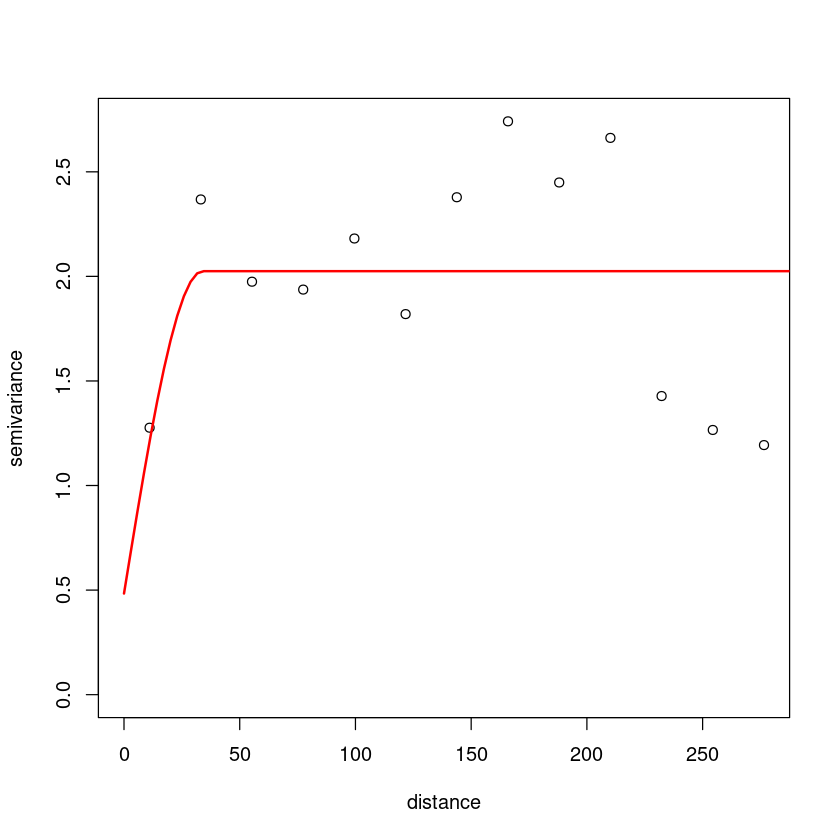

In [453]:
cord = coordinates(sd_31_prjtd)
rn = sd_31_prjtd$RAINFALL.DAILY.CUMULATIVE..0.5.mm.or.more.
rn = data.frame(rn)
gdt_31 = as.geodata(data.frame(cord, rainfall = rn))
jit_am = 1e-3
gdt_31 = jitterDupCoords(gdt_31, max = jit_am)

vf_31 = variog(gdt_31, lambda = -0.0606060606060606, trend = "1st")
plot(vf_31)
vgm_rn_lk_31 = likfit(geodata = gdt_31, trend = "1st",cov.model = "spherical", ini.cov.pars = c(3,70),nugget = 1.5, lambda = -0.0606060606060606, lik.method = "ML", messages = FALSE)
vgm_rn_lk_31
summary(vgm_rn_lk_31)

# Add the fitted model
lines(vgm_rn_lk_31, col = "red", lwd = 2)


In [454]:
## Krig

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: performing the Box-Cox data transformation
krige.conv: back-transforming the predicted mean and variance
krige.conv: back-transforming by simulating from the predictive.
           (run the function a few times and check stability of the results.
krige.conv: Kriging performed using global neighbourhood 


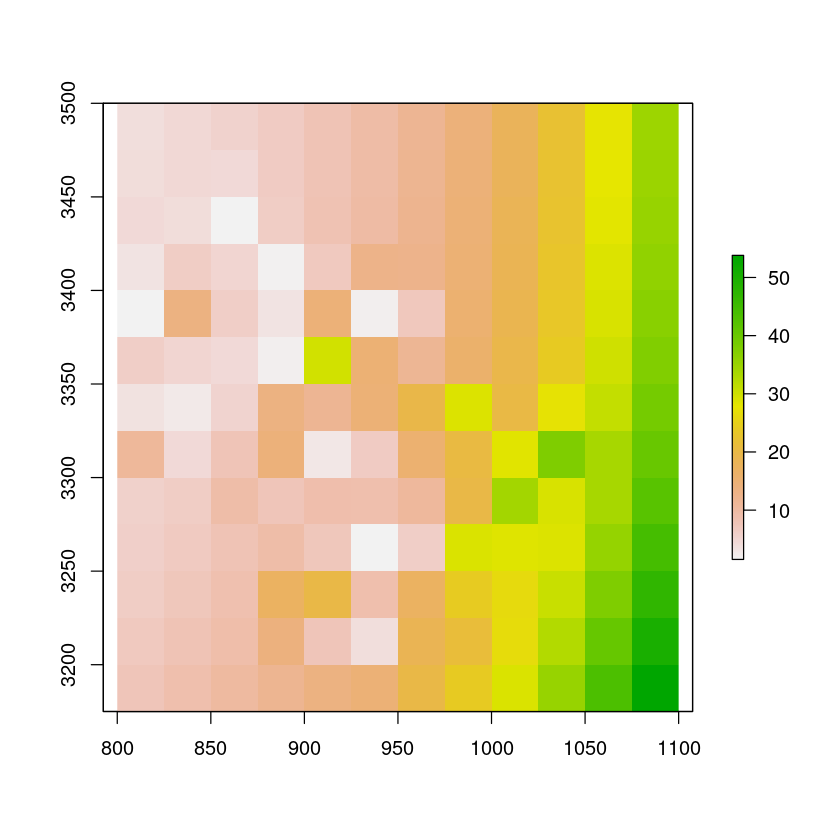

In [455]:
grid_coords <- coordinates(grid_3sp)
grid_df <- data.frame(grid_coords)
names(grid_df) <- c("lon", "lat") 


krig_lkft_31 <- krige.conv(gdt_31, locations = grid_df, krige = krige.control(obj.model = vgm_rn_lk_31))



krig_rain_lkft_31 <- krig_lkft_31$predict
# Create a new raster based on the grid and assign the kriging values
pr_rain_lkft_31 <- rasterFromXYZ(cbind(grid_df, krig_rain_lkft_31))
proj4string(pr_rain_lkft_31) <- proj4string(grid_3sp)
plot(pr_rain_lkft_31)

In [456]:
## Regression

Generalized Linear Model 

45 samples
 1 predictor

Pre-processing: centered (1), scaled (1) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 40, 39, 40, 41, 40, 41, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.449103  0.3362278  1.268499

variog: computing omnidirectional variogram


Summary of the parameter estimation
-----------------------------------
Estimation method: maximum likelihood 

Parameters of the mean component (trend):
   beta0    beta1    beta2 
-13.4819   0.0076   0.0020 

Parameters of the spatial component:
   correlation function: spherical
      (estimated) variance parameter sigmasq (partial sill) =  1.398
      (estimated) cor. fct. parameter phi (range parameter)  =  33.43
   anisotropy parameters:
      (fixed) anisotropy angle = 0  ( 0 degrees )
      (fixed) anisotropy ratio = 1

Parameter of the error component:
      (estimated) nugget =  0.5403

Transformation parameter:
      (fixed) Box-Cox parameter = 1 (no transformation)

Practical Range with cor=0.05 for asymptotic range: 33.43159

Maximised Likelihood:
   log.L n.params      AIC      BIC 
"-77.07"      "6"  "166.1"    "177" 

non spatial model:
   log.L n.params      AIC      BIC 
"-79.26"      "4"  "166.5"  "173.7" 

Call:
likfit(geodata = gdt_residuals, trend = "1st", ini.cov

krige.conv: model with mean given by a 1st order polynomial on the coordinates
krige.conv: Kriging performed using global neighbourhood 


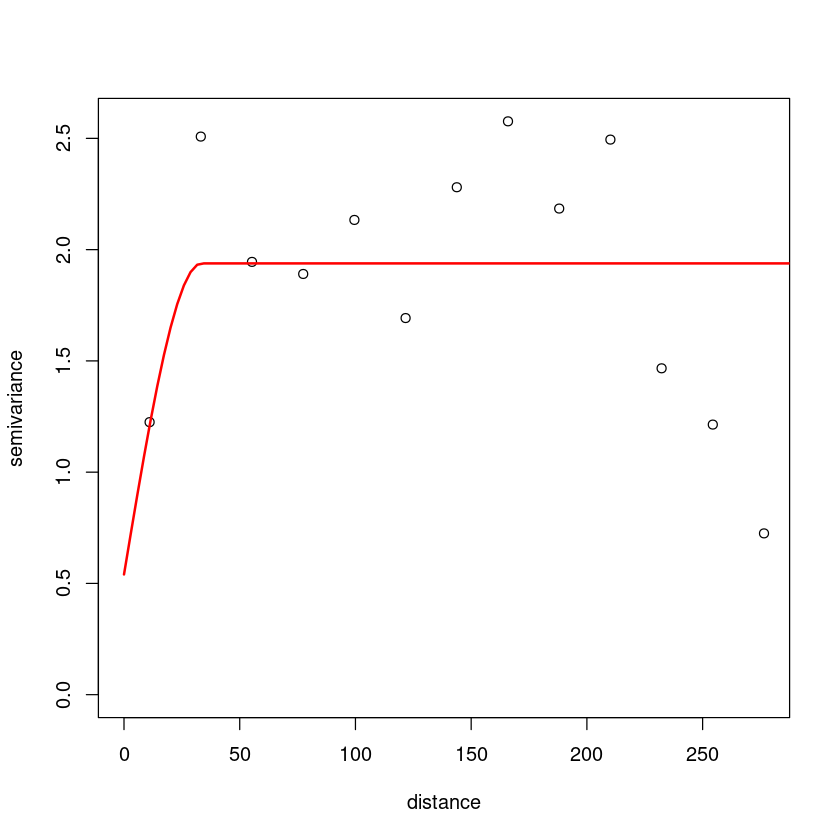

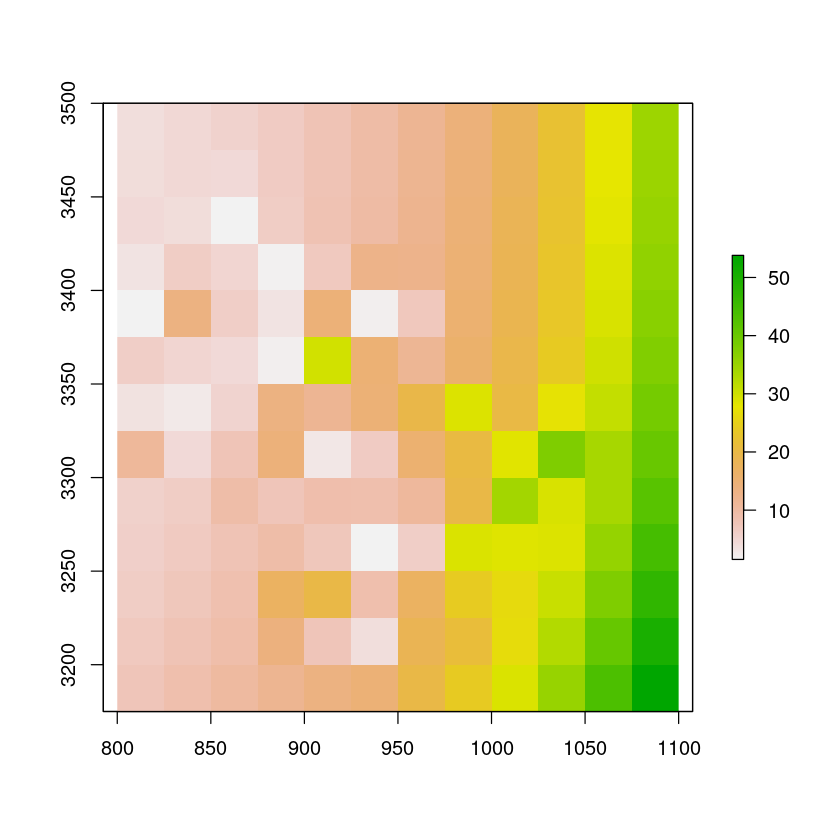

In [457]:
train.x <- data.frame(el_transformed)  # Explanatory variable
RESPONSE <- rain_transformed  # Target variable

# Set up the train control
myControl <- trainControl(method = "cv", number = 10)  # 10-fold cross-validation

GLM <- train(train.x,
             RESPONSE,
             method = "glm",
             trControl = myControl,
             preProc = c('center', 'scale'))  # Center and scale the data

# Print the model summary
print(GLM)



resd_glm_31 = resid(GLM)
# Create a geodata object for residuals
gdt_residuals <- as.geodata(data.frame(cord, residuals = resd_glm_31))
jit_am <- 1e-3
gdt_residuals <- jitterDupCoords(gdt_residuals, max = jit_am)

# Compute the variogram without specifying lambda, as the residuals are already transformed
vf_residuals <- variog(gdt_residuals, trend = "1st")
plot(vf_residuals)

# Fit the variogram model
vgm_res_lk_31 <- likfit(geodata = gdt_residuals, 
                     trend = "1st",
                     cov.model = "spherical", 
                     ini.cov.pars = c(3, 60), 
                     nugget = 1.5, 
                     lik.method = "ML", 
                     messages = FALSE)

summary(vgm_res_lk_31)
lines(vgm_res_lk_31, col = "red", lwd = 2)

krig_lkft_regr_31 <- krige.conv(gdt_residuals, locations = grid_df, krige = krige.control(obj.model = vgm_res_lk_31))

krig_regr_31 <- krig_lkft_31$predict
# Create a new raster based on the grid and assign the kriging values
pr_regr_lkft_31 <- rasterFromXYZ(cbind(grid_df, krig_regr_31))
proj4string(pr_regr_lkft_31) <- proj4string(grid_3sp)
plot(pr_regr_lkft_31)


In [460]:
# Combine the variogram objects into a list
vgm_rn_lk_list <- list(vgm_rn_lk, vgm_rn_lk_2, vgm_rn_lk_3, vgm_rn_lk_4, 
                       vgm_rn_lk_5, vgm_rn_lk_6, vgm_rn_lk_7, vgm_rn_lk_8, 
                       vgm_rn_lk_9, vgm_rn_lk_10, vgm_rn_lk_11, vgm_rn_lk_12, 
                       vgm_rn_lk_13, vgm_rn_lk_15, vgm_rn_lk_16, vgm_rn_lk_17, 
                       vgm_rn_lk_18, vgm_rn_lk_19, vgm_rn_lk_20, vgm_rn_lk_21, 
                       vgm_rn_lk_22, vgm_rn_lk_23, vgm_rn_lk_24, vgm_rn_lk_25, 
                       vgm_rn_lk_26, vgm_rn_lk_27, vgm_rn_lk_28, vgm_rn_lk_29, 
                       vgm_rn_lk_30, vgm_rn_lk_31)

# Combine the kriging results into a list
krig_lkft_list <- list(krig_lkft_1, krig_lkft_2, krig_lkft_3, krig_lkft_4, 
                       krig_lkft_5, krig_lkft_6, krig_lkft_7, krig_lkft_8, 
                       krig_lkft_9, krig_lkft_10, krig_lkft_11, krig_lkft_12, 
                       krig_lkft_13, krig_lkft_15, krig_lkft_16, krig_lkft_17, 
                       krig_lkft_18, krig_lkft_19, krig_lkft_20, krig_lkft_21, 
                       krig_lkft_22, krig_lkft_23, krig_lkft_24, krig_lkft_25, 
                       krig_lkft_26, krig_lkft_27, krig_lkft_28, krig_lkft_29, 
                       krig_lkft_30, krig_lkft_31)

In [461]:
save(vgm_rn_lk_list, krig_lkft_list, file = "variograms_and_krigings_with_rain.RData")

In [463]:
# Combine the variogram objects into a list with the prefix "res" instead of "rn"
vgm_res_lk_list <- list(vgm_res_lk, vgm_res_lk_2, vgm_res_lk_3, vgm_res_lk_4, 
                        vgm_res_lk_5, vgm_res_lk_6, vgm_res_lk_7, vgm_res_lk_8, 
                        vgm_res_lk_9, vgm_res_lk_10, vgm_res_lk_11, vgm_res_lk_12, 
                        vgm_res_lk_13, vgm_res_lk_15, vgm_res_lk_16, vgm_res_lk_17, 
                        vgm_res_lk_18, vgm_res_lk_19, vgm_res_lk_20, vgm_res_lk_21, 
                        vgm_res_lk_22, vgm_res_lk_23, vgm_res_lk_24, vgm_res_lk_25, 
                        vgm_res_lk_26, vgm_res_lk_27, vgm_res_lk_28, vgm_res_lk_29, 
                        vgm_res_lk_30, vgm_res_lk_31)

# Combine the kriging results into a list with the prefix "krig_lkft_regr"
krig_lkft_regr_list <- list(krig_lkft_regr_1, krig_lkft_regr_2, krig_lkft_regr_3, krig_lkft_regr_4, 
                            krig_lkft_regr_5, krig_lkft_regr_6, krig_lkft_regr_7, krig_lkft_regr_8, 
                            krig_lkft_regr_9, krig_lkft_regr_10, krig_lkft_regr_11, krig_lkft_regr_12, 
                            krig_lkft_regr_13, krig_lkft_regr_15, krig_lkft_regr_16, krig_lkft_regr_17, 
                            krig_lkft_regr_18, krig_lkft_regr_19, krig_lkft_regr_20, krig_lkft_regr_21, 
                            krig_lkft_regr_22, krig_lkft_regr_23, krig_lkft_regr_24, krig_lkft_regr_25, 
                            krig_lkft_regr_26, krig_lkft_regr_27, krig_lkft_regr_28, krig_lkft_regr_29, 
                            krig_lkft_regr_30, krig_lkft_regr_31)


In [464]:
save(vgm_res_lk_list, krig_lkft_regr_list, file = "variograms_and_krigings_with_residuals_reg.RData")

In [465]:
# Combine the variogram objects into a list with the prefix "pr_rain_lkft"
pr_rain_lkft_list <- list(pr_rain_lkft_1, pr_rain_lkft_2, pr_rain_lkft_3, pr_rain_lkft_4, 
                          pr_rain_lkft_5, pr_rain_lkft_6, pr_rain_lkft_7, pr_rain_lkft_8, 
                          pr_rain_lkft_9, pr_rain_lkft_10, pr_rain_lkft_11, pr_rain_lkft_12, 
                          pr_rain_lkft_13, pr_rain_lkft_15, pr_rain_lkft_16, pr_rain_lkft_17, 
                          pr_rain_lkft_18, pr_rain_lkft_19, pr_rain_lkft_20, pr_rain_lkft_21, 
                          pr_rain_lkft_22, pr_rain_lkft_23, pr_rain_lkft_24, pr_rain_lkft_25, 
                          pr_rain_lkft_26, pr_rain_lkft_27, pr_rain_lkft_28, pr_rain_lkft_29, 
                          pr_rain_lkft_30, pr_rain_lkft_31)

# Combine the kriging results into a list with the prefix "pr_regr_lkft"
pr_regr_lkft_list <- list(pr_regr_lkft_1, pr_regr_lkft_2, pr_regr_lkft_3, pr_regr_lkft_4, 
                          pr_regr_lkft_5, pr_regr_lkft_6, pr_regr_lkft_7, pr_regr_lkft_8, 
                          pr_regr_lkft_9, pr_regr_lkft_10, pr_regr_lkft_11, pr_regr_lkft_12, 
                          pr_regr_lkft_13, pr_regr_lkft_15, pr_regr_lkft_16, pr_regr_lkft_17, 
                          pr_regr_lkft_18, pr_regr_lkft_19, pr_regr_lkft_20, pr_regr_lkft_21, 
                          pr_regr_lkft_22, pr_regr_lkft_23, pr_regr_lkft_24, pr_regr_lkft_25, 
                          pr_regr_lkft_26, pr_regr_lkft_27, pr_regr_lkft_28, pr_regr_lkft_29, 
                          pr_regr_lkft_30, pr_regr_lkft_31)


In [466]:
save(pr_rain_lkft_list, file = "Krig_Rain_Raster.RData")

In [467]:
save(pr_regr_lkft_list, file = "Krig_Regression_Raster.RData")

In [476]:
print(names(pr_rain_lkft_list))

NULL


In [479]:
# Define the target CRS (WGS 84 with latitude/longitude)
target_crs <- CRS("+proj=longlat +datum=WGS84")

# Create a new list to store reprojected rasters
raster_rain_list_reprojected <- list()

# Loop through the original raster list and reproject each raster
for (i in seq_along(pr_rain_lkft_list)) {
  # Directly access the raster by index
  raster <- pr_rain_lkft_list[[i]]
  
  # Check if the raster exists
  if (!is.null(raster)) {
    # Reproject the raster to WGS 84 with a reasonable resolution (e.g., 0.25 degrees)
    raster_rain_list_reprojected[[i]] <- projectRaster(
      raster, 
      crs = target_crs, 
      res = 0.25
    )
  } else {
    warning(paste("Raster not found at index:", i))
  }
}

In [482]:
raster_regr_list_reprojected = list()

# Loop through the original raster list and reproject each raster
for (i in seq_along(pr_regr_lkft_list)) {
  # Directly access the raster by index
  raster1 <- pr_regr_lkft_list[[i]]
  
  # Check if the raster exists
  if (!is.null(raster1)) {
    # Reproject the raster to WGS 84 with a reasonable resolution (e.g., 0.25 degrees)
    raster_regr_list_reprojected[[i]] <- projectRaster(
      raster1, 
      crs = target_crs, 
      res = 0.25
    )
  } else {
    warning(paste("Raster not found at index:", i))
  }
}

In [484]:
library(rgdal)

In [468]:
uk = "/data/private/GPM/India/UK.shp"

In [489]:
# Read the shapefile
uk_shape <- readOGR(uk)

# Create a list to store cropped rasters
rain_uk <- list()

# Loop through the reprojected raster list and crop each raster
for (i in seq_along(raster_rain_list_reprojected)) {
  # Get the raster
  raster <- raster_rain_list_reprojected[[i]]
  
  # Check if the raster exists
  if (!is.null(raster)) {
    # Crop the raster using the shapefile
    cropped_rain <- crop(raster, extent(uk_shape))
    
    # Mask the raster with the shapefile to remove areas outside
    masked_rain <- mask(cropped_rain, uk_shape)
    
    # Save the cropped raster (optional)
    writeRaster(masked_rain, filename = paste0("rain_pred_", i, ".tif"), format = "GTiff", overwrite = TRUE)
    
    # Store the cropped raster in the list
    rain_uk[[i]] <- masked_rain
    
  } else {
    warning(paste("Raster not found at index:", i))
  }
}


OGR data source with driver: ESRI Shapefile 
Source: "/data/private/GPM/India/UK.shp", layer: "UK"
with 1 features
It has 1 fields
Integer64 fields read as strings:  FID 


In [493]:
of = "/data/private/GPM/DEM/Rain_Pred_Krig"

In [494]:
# Loop through the list of rasters and save each one as a GeoTIFF
for (i in seq_along(rain_uk)) {
  writeRaster(rain_uk[[i]], 
              filename = file.path(of, paste0("rain_uk_raster_", i, ".tif")), 
              format = "GTiff", 
              overwrite = TRUE)  # Set overwrite = TRUE if you want to replace existing files
}

In [ ]:
# Read the shapefile
uk_shape <- readOGR(uk)

# Create a list to store cropped rasters
rain_reg_uk <- list()

# Loop through the reprojected raster list and crop each raster
for (i in seq_along(raster_regr_list_reprojected)) {  # Added closing parenthesis here
  # Get the raster
  raster <- raster_regr_list_reprojected[[i]]
  
  # Check if the raster exists
  if (!is.null(raster)) {
    # Crop the raster using the shapefile
    cropped_rain <- crop(raster, extent(uk_shape))
    
    # Mask the raster with the shapefile to remove areas outside
    masked_rain <- mask(cropped_rain, uk_shape)
    
    # Save the cropped raster (optional)
    writeRaster(masked_rain, filename = paste0("rain_pred_", i, ".tif"), format = "GTiff", overwrite = TRUE)
    
    # Store the cropped raster in the list
    rain_reg_uk[[i]] <- masked_rain
    
  } else {
    warning(paste("Raster not found at index:", i))
  }
}

